## Simple Martingale Strategy

__使用说明__
- 按照顺序每个格子运行，选中格子，用shift+回车运行，如果有返回，返回结果直接会在下面显示，错误也是
- 这个示例里，只要定义一下 dataset的文件名就可以运行了。

Last Update: 2022.3.21

__input your data file name here__

In [ ]:
dataset_filename = "LUNAUSDT-2020-08-21-2022-03-21.csv"

In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import backtrader as bt
import datetime
import argparse

__Here defines some broker info__

In [3]:
class BinanceComissionInfo(bt.CommissionInfo):
    params = (
        ("commission", 0.075),
        ("mult", 1.0),
        ("margin", None),
        ("commtype", bt.CommInfoBase.COMM_PERC),
        ("stocklike", True),
        ("percabs", False),
        ("interest", 0.0),
        ("interest_long", False),
        ("leverage", 1.0),
        ("automargin", False),
    )
    
    def getsize(self, price, cash):
        """Returns fractional size for cash operation @price"""
        return self.p.leverage * (cash / price)


__Here defines several indicator used by strategy__

In [4]:
class DynamicHighest(bt.Indicator):
    lines = ('dyn_highest',)
    #plotlines = dict( dyn_highest = dict(_skipnan=False))

    def __init__(self):
        self._tradeopen = False

    def tradeopen(self, yesno):
        self._tradeopen = yesno

    def next(self):
        if self._tradeopen:
            self.lines.dyn_highest[0] = max(self.data[0], self.dyn_highest[-1])

class DynamicLowest(bt.Indicator):
    lines = ('dyn_lowest',)
    #plotlines = dict( dyn_lowest = dict(_skipnan=False))

    def __init__(self):
        self._tradeopen = False
        self.counter = 0

    def tradeopen(self, yesno):
        self._tradeopen = yesno

    def next(self):
        if self._tradeopen:
            self.lines.dyn_lowest[0] = min( self.data[0], self.dyn_lowest[-1])


In [5]:
class MartingaleSize():

    def __init__(self):
        self.double_time = 1
        self.init_cap = 20

    def double(self):
        self.double_time *= 2

    def reset(self):
        self.double_time = 1

    def getsize(self, cash):
        try_size = self.init_cap * self.double_time
        self.double()
        if cash < try_size:
            return cash
        return try_size

In [6]:
def pct_chg(p1,p2):
    return (p1-p2)/p2

__here is the strategy itself__

In [7]:
class Martingale(bt.Strategy):
    # sell mark:    price higher 1.3% than average holding cost
    # sell trigger: price retract from high 0.3%
    # buy mark:     price lower than 4% of average holding cost
    # buy trigger:  price rebounce 0.5% after buy mark

    params = (
        ("sell_mark", 0.013),
        ("sell_signal", -0.003),
        ("buy_mark", -0.04),
        ("buy_signal", 0.005),
        # Percentage of portfolio for a trade. Something is left for the fees
        # otherwise orders would be rejected
        ("portfolio_frac", 0.98),
        ("debug", False),

    )

    def __init__(self):
        self.val_start = self.broker.getcash()  # keep the starting cash
        self.size = None
        self.order = None

        self.dyn_highest = DynamicHighest( self.data.high, subplot=False )
        self.dyn_lowest = DynamicLowest( self.data.low, subplot=False )

        self.reset_mark()

        self.size_calc = MartingaleSize()

    def log(self, txt, dt=None):
        if self.p.debug:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))


    def reset_mark(self):
        self.sell_mark = False
        self.buy_mark = False

    def next(self):

        available_cash = self.broker.getcash() * self.p.portfolio_frac

        if not self.position:  # not in the market
            # buy in now
            self.size_calc.reset() # reset to 1
            self.size =  self.size_calc.getsize( available_cash ) / self.data.lines.close[0]  # strating from 10u
            self.order = self.buy(size=self.size)

            # reset all mark
            self.reset_mark()

            print(
                "Enter Market:"
                f"DateTime {self.datas[0].datetime.datetime(0)}, "
                f"Price {self.data[0]:.2f}, "
                f"Amount {self.size}"
            )

        else:  # in the market

            if self.p.debug:
                print(
                    (
                        f"TradeOpen: {self.dyn_highest._tradeopen},"
                        f"Dyn Highest:{self.dyn_highest[0]},"
                        f"Dyn Lowest:{self.dyn_lowest[0]},"
                    )
                )

            # process buy/sell first
            if self.sell_mark and (
                    pct_chg(self.data.lines.low[0], self.dyn_highest[0]) < self.p.sell_signal):
                # sell all
                self.order = self.close()
                self.reset_mark()

                print(
                    (
                        f"Leave Market:"
                        f"DateTime {self.datas[0].datetime.datetime(0)}, "
                        f"Market Price {self.data[0]:.2f}, "
                        f"Market Low {self.data.lines.low[0]:.2f},"
                        f"Position Cost {self.position.price}， "
                        f"Position Size {self.position.size}， "
                        f"Recent High {self.dyn_highest[0]} "
                    )
                )

                return

            if self.buy_mark and (
                    pct_chg(self.data.lines.high[0], self.dyn_lowest[0]) > self.p.buy_signal):
                # buy
                self.size = self.size_calc.getsize( available_cash ) / self.data.lines.close[0]  # strating from 10u
                self.order = self.buy(size=self.size)
                self.reset_mark()

                print(
                    (
                        f"Double Bet:"
                        f"DateTime {self.datas[0].datetime.datetime(0)}, "
                        f"Market Price {self.data[0]:.2f},"
                        f"Market High  {self.data.lines.high[0]:.2f},"
                        f"Position Cost {self.position.price}， "
                        f"Position Size {self.position.size}， "
                        f"Recent Low {self.dyn_lowest[0]} "
                    )
                )
                return

            if (pct_chg(self.data.lines.high, self.position.price) > self.p.sell_mark):
                self.sell_mark = True

            if (pct_chg(self.data.lines.low, self.position.price) < self.p.buy_mark):
                self.buy_mark = True

        #if self.order:
        #    return  # pending order execution. Waiting in orderbook

        #print(
        #        f"DateTime {self.datas[0].datetime.datetime(0)}, "
        #        f"Price {self.data[0]:.2f}, "
        #        f"Position {self.position.upopened}"
        #    )

    def notify_order(self, order):
        """Execute when buy or sell is triggered
        Notify if order was accepted or rejected
        """
        if order.alive():
            print(f"Order is alive: {self.datas[0].datetime.datetime(0)}")

            # submitted, accepted, partial, created
            # Returns if the order is in a status in which it can still be executed
            return

        order_side = "Buy" if order.isbuy() else "Sell"
        if order.status == order.Completed:
            print(
                (
                    f"{order_side} Order Completed - Datetime{self.datas[0].datetime.datetime(0)} "
                    f"Size: {order.executed.size} "
                    f"@Price: {order.executed.price} "
                    f"Value: {order.executed.value:.2f} "
                    f"Comm: {order.executed.comm:.6f} "
                )
            )
        elif order.status in {order.Canceled, order.Margin, order.Rejected}:
            print(f"{order_side} Order Canceled/Margin/Rejected")
        self.order = None  # indicate no order pending

    def notify_trade(self, trade):
        """Execute after each trade
        Calcuate Gross and Net Profit/loss"""

        self.dyn_highest.tradeopen(trade.isopen)
        self.dyn_lowest.tradeopen(trade.isopen)

        # trade closed
        if trade.isclosed:
            print(f"Operational profit, Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}")

    def stop(self):
        """ Calculate the actual returns """
        self.roi = (self.broker.getvalue() / self.val_start) - 1.0
        val_end = self.broker.getvalue()
        print(
            f"ROI: {100.0 * self.roi:.2f}%%, Start cash {self.val_start:.2f}, "
            f"End cash: {val_end:.2f}"
        )


__Below Runs the Strategy__

In [10]:
# Create a cerebro entity
cerebro = bt.Cerebro(runonce=False,
                    preload=False,
                    )


# Create a Data Feed
data = bt.feeds.GenericCSVData(
    dataname=dataset_filename,
    dtformat="%Y-%m-%dT%H:%M:%S",
    timeframe=bt.TimeFrame.Ticks
)

# Add the Data Feed to Cerebro
cerebro.resampledata(data, timeframe=bt.TimeFrame.Minutes, compression=1)

# Add a Commission and Support Fractional Size
cerebro.broker.addcommissioninfo(BinanceComissionInfo())

# Set our desired cash start
cerebro.broker.setcash(10000)

# Add a strategy
cerebro.addstrategy(Martingale)

# Add Oberserver
cerebro.addobserver(bt.observers.DrawDown)

# Analyzer
cerebro.addanalyzer(
    bt.analyzers.SharpeRatio,
    timeframe=bt.TimeFrame.Days,
    riskfreerate=0,
    _name='dailysharp'
    )

cerebro.addanalyzer(
    bt.analyzers.TimeReturn,
    timeframe=bt.TimeFrame.NoTimeFrame,
    _name='alltimereturn'
    )

cerebro.addanalyzer(
    bt.analyzers.TradeAnalyzer,
    _name="trade_analysis",
)

cerebro.addanalyzer(
    bt.analyzers.TimeReturn,
    data=data,
    _name="benchmark",
    timeframe=bt.TimeFrame.NoTimeFrame,
)


# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Add a writer
# csv_out = 'test.csv'
# cerebro.addwriter(bt.WriterFile, csv=args.writercsv, out=csv_out)

# Run over everything
results = cerebro.run()

st0 = results[0]
for alyzer in st0.analyzers:
    alyzer.print()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())




Starting Portfolio Value: 10000.00
Enter Market:DateTime 2020-08-21 10:00:00, Price 0.48, Amount 41.5541242468315
Order is alive: 2020-08-21 10:01:00
Order is alive: 2020-08-21 10:01:00
Buy Order Completed - Datetime2020-08-21 10:01:00 Size: 41.5541242468315 @Price: 0.4849 Value: 20.15 Comm: 0.015112 
Leave Market:DateTime 2020-08-21 10:02:00, Market Price 0.49, Market Low 0.49,Position Cost 0.4849， Position Size 41.5541242468315， Recent High 0.4991 
Order is alive: 2020-08-21 10:03:00
Order is alive: 2020-08-21 10:03:00
Sell Order Completed - Datetime2020-08-21 10:03:00 Size: -41.5541242468315 @Price: 0.4929 Value: 20.15 Comm: 0.015362 
Operational profit, Gross: 0.33, Net: 0.30
Enter Market:DateTime 2020-08-21 10:03:00, Price 0.49, Amount 41.00041000410004
Order is alive: 2020-08-21 10:04:00
Order is alive: 2020-08-21 10:04:00
Buy Order Completed - Datetime2020-08-21 10:04:00 Size: 41.00041000410004 @Price: 0.4878 Value: 20.00 Comm: 0.015000 
Double Bet:DateTime 2020-08-21 10:32:00, 

Buy Order Completed - Datetime2020-08-22 15:21:00 Size: 42.06098843322818 @Price: 0.47870000000000007 Value: 20.13 Comm: 0.015101 
Leave Market:DateTime 2020-08-22 15:24:00, Market Price 0.48, Market Low 0.48,Position Cost 0.4787， Position Size 42.06098843322818， Recent High 0.4876 
Order is alive: 2020-08-22 15:25:00
Order is alive: 2020-08-22 15:25:00
Sell Order Completed - Datetime2020-08-22 15:25:00 Size: -42.06098843322818 @Price: 0.4820999999999999 Value: 20.13 Comm: 0.015208 
Operational profit, Gross: 0.14, Net: 0.11
Enter Market:DateTime 2020-08-22 15:25:00, Price 0.47, Amount 42.435815828559306
Order is alive: 2020-08-22 15:26:00
Order is alive: 2020-08-22 15:26:00
Buy Order Completed - Datetime2020-08-22 15:26:00 Size: 42.435815828559306 @Price: 0.47279999999999994 Value: 20.06 Comm: 0.015048 
Leave Market:DateTime 2020-08-22 15:39:00, Market Price 0.48, Market Low 0.48,Position Cost 0.4728， Position Size 42.435815828559306， Recent High 0.4819 
Order is alive: 2020-08-22 15:

Leave Market:DateTime 2020-08-23 17:20:00, Market Price 0.48, Market Low 0.48,Position Cost 0.4769， Position Size 41.937513105472846， Recent High 0.485 
Order is alive: 2020-08-23 17:21:00
Order is alive: 2020-08-23 17:21:00
Sell Order Completed - Datetime2020-08-23 17:21:00 Size: -41.937513105472846 @Price: 0.47709999999999997 Value: 20.00 Comm: 0.015006 
Operational profit, Gross: 0.01, Net: -0.02
Enter Market:DateTime 2020-08-23 17:21:00, Price 0.48, Amount 41.919932928107315
Order is alive: 2020-08-23 17:22:00
Order is alive: 2020-08-23 17:22:00
Buy Order Completed - Datetime2020-08-23 17:22:00 Size: 41.919932928107315 @Price: 0.4771 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2020-08-23 18:01:00, Market Price 0.48, Market Low 0.48,Position Cost 0.4771， Position Size 41.919932928107315， Recent High 0.488 
Order is alive: 2020-08-23 18:02:00
Order is alive: 2020-08-23 18:02:00
Sell Order Completed - Datetime2020-08-23 18:02:00 Size: -41.919932928107315 @Price: 0.4802 Value: 2

Double Bet:DateTime 2020-08-25 06:59:00, Market Price 0.51,Market High  0.51,Position Cost 0.5275， Position Size 37.91469194312796， Recent Low 0.5 
Order is alive: 2020-08-25 07:00:00
Order is alive: 2020-08-25 07:00:00
Buy Order Completed - Datetime2020-08-25 07:00:00 Size: 77.71517388770157 @Price: 0.5147 Value: 40.00 Comm: 0.030000 
Double Bet:DateTime 2020-08-25 07:16:00, Market Price 0.50,Market High  0.50,Position Cost 0.518897082245015， Position Size 115.62986583082953， Recent Low 0.4941 
Order is alive: 2020-08-25 07:17:00
Order is alive: 2020-08-25 07:17:00
Buy Order Completed - Datetime2020-08-25 07:17:00 Size: 160.03200640128026 @Price: 0.4986 Value: 79.79 Comm: 0.059844 
Double Bet:DateTime 2020-08-25 07:52:00, Market Price 0.48,Market High  0.49,Position Cost 0.5071138683770248， Position Size 275.6618722321098， Recent Low 0.4785 
Order is alive: 2020-08-25 07:53:00
Order is alive: 2020-08-25 07:53:00
Buy Order Completed - Datetime2020-08-25 07:53:00 Size: 331.4688212140045

Double Bet:DateTime 2020-08-27 12:01:00, Market Price 0.49,Market High  0.49,Position Cost 0.5076， Position Size 39.40110323089046， Recent Low 0.4838 
Order is alive: 2020-08-27 12:02:00
Order is alive: 2020-08-27 12:02:00
Buy Order Completed - Datetime2020-08-27 12:02:00 Size: 82.27067050596462 @Price: 0.4862 Value: 40.00 Comm: 0.030000 
Double Bet:DateTime 2020-08-27 12:50:00, Market Price 0.48,Market High  0.48,Position Cost 0.4931299853470095， Position Size 121.67177373685507， Recent Low 0.473 
Order is alive: 2020-08-27 12:51:00
Order is alive: 2020-08-27 12:51:00
Buy Order Completed - Datetime2020-08-27 12:51:00 Size: 167.25904244198202 @Price: 0.47700000000000004 Value: 79.78 Comm: 0.059837 
Leave Market:DateTime 2020-08-27 13:16:00, Market Price 0.49, Market Low 0.49,Position Cost 0.48379250470225166， Position Size 288.93081617883706， Recent High 0.513 
Order is alive: 2020-08-27 13:17:00
Order is alive: 2020-08-27 13:17:00
Sell Order Completed - Datetime2020-08-27 13:17:00 Siz

Double Bet:DateTime 2020-08-28 12:42:00, Market Price 0.53,Market High  0.53,Position Cost 0.5533， Position Size 36.146755828664375， Recent Low 0.5277 
Order is alive: 2020-08-28 12:43:00
Order is alive: 2020-08-28 12:43:00
Buy Order Completed - Datetime2020-08-28 12:43:00 Size: 74.86430844095078 @Price: 0.5351 Value: 40.06 Comm: 0.030045 
Leave Market:DateTime 2020-08-28 15:46:00, Market Price 0.55, Market Low 0.55,Position Cost 0.5410261746602474， Position Size 111.01106426961516， Recent High 0.5552 
Order is alive: 2020-08-28 15:47:00
Order is alive: 2020-08-28 15:47:00
Sell Order Completed - Datetime2020-08-28 15:47:00 Size: -111.01106426961516 @Price: 0.5473 Value: 60.06 Comm: 0.045567 
Operational profit, Gross: 0.70, Net: 0.61
Enter Market:DateTime 2020-08-28 15:47:00, Price 0.55, Amount 36.68378576669112
Order is alive: 2020-08-28 15:48:00
Order is alive: 2020-08-28 15:48:00
Buy Order Completed - Datetime2020-08-28 15:48:00 Size: 36.68378576669112 @Price: 0.5474 Value: 20.08 Co

Double Bet:DateTime 2020-08-31 22:39:00, Market Price 0.51,Market High  0.51,Position Cost 0.5298， Position Size 37.75722106852936， Recent Low 0.5078 
Order is alive: 2020-08-31 22:40:00
Order is alive: 2020-08-31 22:40:00
Buy Order Completed - Datetime2020-08-31 22:40:00 Size: 78.32386919913843 @Price: 0.5107 Value: 40.00 Comm: 0.030000 
Double Bet:DateTime 2020-09-01 03:43:00, Market Price 0.49,Market High  0.49,Position Cost 0.516912578816636， Position Size 116.08109026766779， Recent Low 0.4901 
Order is alive: 2020-09-01 03:44:00
Order is alive: 2020-09-01 03:44:00
Buy Order Completed - Datetime2020-09-01 03:44:00 Size: 163.16540893330614 @Price: 0.4905 Value: 80.03 Comm: 0.060024 
Double Bet:DateTime 2020-09-01 04:05:00, Market Price 0.48,Market High  0.48,Position Cost 0.5014795501629877， Position Size 279.2464992009739， Recent Low 0.4791 
Order is alive: 2020-09-01 04:06:00
Order is alive: 2020-09-01 04:06:00
Buy Order Completed - Datetime2020-09-01 04:06:00 Size: 331.0573142975

Double Bet:DateTime 2020-09-05 10:07:00, Market Price 0.36,Market High  0.36,Position Cost 0.3773， Position Size 53.00821627352239， Recent Low 0.3566 
Order is alive: 2020-09-05 10:08:00
Order is alive: 2020-09-05 10:08:00
Buy Order Completed - Datetime2020-09-05 10:08:00 Size: 111.70064227869311 @Price: 0.35830000000000006 Value: 40.02 Comm: 0.030017 
Double Bet:DateTime 2020-09-05 11:22:00, Market Price 0.35,Market High  0.35,Position Cost 0.3644147658847848， Position Size 164.7088585522155， Recent Low 0.3459 
Order is alive: 2020-09-05 11:23:00
Order is alive: 2020-09-05 11:23:00
Buy Order Completed - Datetime2020-09-05 11:23:00 Size: 230.3484019579614 @Price: 0.3473 Value: 80.00 Comm: 0.060000 
Double Bet:DateTime 2020-09-05 12:21:00, Market Price 0.34,Market High  0.34,Position Cost 0.3544355568801113， Position Size 395.0572605101769， Recent Low 0.3366 
Order is alive: 2020-09-05 12:22:00
Order is alive: 2020-09-05 12:22:00
Buy Order Completed - Datetime2020-09-05 12:22:00 Size: 4

Leave Market:DateTime 2020-09-08 17:13:00, Market Price 0.33, Market Low 0.32,Position Cost 0.3199， Position Size 62.519537355423566， Recent High 0.326 
Order is alive: 2020-09-08 17:14:00
Order is alive: 2020-09-08 17:14:00
Sell Order Completed - Datetime2020-09-08 17:14:00 Size: -62.519537355423566 @Price: 0.3258 Value: 20.00 Comm: 0.015277 
Operational profit, Gross: 0.37, Net: 0.34
Enter Market:DateTime 2020-09-08 17:14:00, Price 0.33, Amount 61.31207847946045
Order is alive: 2020-09-08 17:15:00
Order is alive: 2020-09-08 17:15:00
Buy Order Completed - Datetime2020-09-08 17:15:00 Size: 61.31207847946045 @Price: 0.3263 Value: 20.01 Comm: 0.015005 
Double Bet:DateTime 2020-09-08 22:21:00, Market Price 0.31,Market High  0.31,Position Cost 0.3263， Position Size 61.31207847946045， Recent Low 0.3116 
Order is alive: 2020-09-08 22:22:00
Order is alive: 2020-09-08 22:22:00
Buy Order Completed - Datetime2020-09-08 22:22:00 Size: 127.7139208173691 @Price: 0.3127 Value: 39.94 Comm: 0.029952 


Double Bet:DateTime 2020-09-11 03:15:00, Market Price 0.32,Market High  0.32,Position Cost 0.34044427927495924， Position Size 176.17397006360392， Recent Low 0.3229 
Order is alive: 2020-09-11 03:16:00
Order is alive: 2020-09-11 03:16:00
Buy Order Completed - Datetime2020-09-11 03:16:00 Size: 247.7547228244038 @Price: 0.3232 Value: 80.07 Comm: 0.060056 
Double Bet:DateTime 2020-09-11 04:01:00, Market Price 0.31,Market High  0.32,Position Cost 0.3303662833672777， Position Size 423.92869288800773， Recent Low 0.3142 
Order is alive: 2020-09-11 04:02:00
Order is alive: 2020-09-11 04:02:00
Buy Order Completed - Datetime2020-09-11 04:02:00 Size: 509.2297899427117 @Price: 0.3141 Value: 159.95 Comm: 0.119962 
Leave Market:DateTime 2020-09-11 06:23:00, Market Price 0.33, Market Low 0.33,Position Cost 0.3214896817881544， Position Size 933.1584828307194， Recent High 0.3543 
Order is alive: 2020-09-11 06:24:00
Order is alive: 2020-09-11 06:24:00
Sell Order Completed - Datetime2020-09-11 06:24:00 Si

Double Bet:DateTime 2020-09-14 09:22:00, Market Price 0.31,Market High  0.31,Position Cost 0.3208， Position Size 62.344139650872826， Recent Low 0.3061 
Order is alive: 2020-09-14 09:23:00
Order is alive: 2020-09-14 09:23:00
Buy Order Completed - Datetime2020-09-14 09:23:00 Size: 129.9545159194282 @Price: 0.3078 Value: 40.00 Comm: 0.030000 
Leave Market:DateTime 2020-09-14 11:01:00, Market Price 0.32, Market Low 0.32,Position Cost 0.3120146618917211， Position Size 192.298655570301， Recent High 0.323 
Order is alive: 2020-09-14 11:02:00
Order is alive: 2020-09-14 11:02:00
Sell Order Completed - Datetime2020-09-14 11:02:00 Size: -192.298655570301 @Price: 0.3161 Value: 60.00 Comm: 0.045589 
Operational profit, Gross: 0.79, Net: 0.70
Enter Market:DateTime 2020-09-14 11:02:00, Price 0.32, Amount 63.291139240506325
Order is alive: 2020-09-14 11:03:00
Order is alive: 2020-09-14 11:03:00
Buy Order Completed - Datetime2020-09-14 11:03:00 Size: 63.291139240506325 @Price: 0.3163 Value: 20.02 Comm:

Leave Market:DateTime 2020-09-16 01:11:00, Market Price 0.34, Market Low 0.33,Position Cost 0.33087853944073214， Position Size 422.5936222100417， Recent High 0.355 
Order is alive: 2020-09-16 01:12:00
Order is alive: 2020-09-16 01:12:00
Sell Order Completed - Datetime2020-09-16 01:12:00 Size: -422.5936222100417 @Price: 0.33529999999999993 Value: 139.83 Comm: 0.106272 
Operational profit, Gross: 1.87, Net: 1.66
Enter Market:DateTime 2020-09-16 01:12:00, Price 0.34, Amount 59.68367651447329
Order is alive: 2020-09-16 01:13:00
Order is alive: 2020-09-16 01:13:00
Buy Order Completed - Datetime2020-09-16 01:13:00 Size: 59.68367651447329 @Price: 0.3348 Value: 19.98 Comm: 0.014987 
Leave Market:DateTime 2020-09-16 01:42:00, Market Price 0.34, Market Low 0.34,Position Cost 0.3348， Position Size 59.68367651447329， Recent High 0.3411 
Order is alive: 2020-09-16 01:43:00
Order is alive: 2020-09-16 01:43:00
Sell Order Completed - Datetime2020-09-16 01:43:00 Size: -59.68367651447329 @Price: 0.34059

Double Bet:DateTime 2020-09-20 13:08:00, Market Price 0.30,Market High  0.31,Position Cost 0.31833289338007836， Position Size 188.38274058231983， Recent Low 0.3037 
Order is alive: 2020-09-20 13:09:00
Order is alive: 2020-09-20 13:09:00
Buy Order Completed - Datetime2020-09-20 13:09:00 Size: 262.5533311453889 @Price: 0.3047 Value: 80.00 Comm: 0.060000 
Leave Market:DateTime 2020-09-20 16:43:00, Market Price 0.32, Market Low 0.31,Position Cost 0.3103952680834912， Position Size 450.93607172770874， Recent High 0.3287 
Order is alive: 2020-09-20 16:44:00
Order is alive: 2020-09-20 16:44:00
Sell Order Completed - Datetime2020-09-20 16:44:00 Size: -450.93607172770874 @Price: 0.3173 Value: 139.97 Comm: 0.107312 
Operational profit, Gross: 3.11, Net: 2.90
Enter Market:DateTime 2020-09-20 16:44:00, Price 0.32, Amount 62.421972534332085
Order is alive: 2020-09-20 16:45:00
Order is alive: 2020-09-20 16:45:00
Buy Order Completed - Datetime2020-09-20 16:45:00 Size: 62.421972534332085 @Price: 0.3211

Leave Market:DateTime 2020-09-25 07:21:00, Market Price 0.33, Market Low 0.33,Position Cost 0.32， Position Size 62.480474851608875， Recent High 0.328 
Order is alive: 2020-09-25 07:22:00
Order is alive: 2020-09-25 07:22:00
Sell Order Completed - Datetime2020-09-25 07:22:00 Size: -62.480474851608875 @Price: 0.3281 Value: 19.99 Comm: 0.015375 
Operational profit, Gross: 0.51, Net: 0.48
Enter Market:DateTime 2020-09-25 07:22:00, Price 0.33, Amount 60.7164541590771
Order is alive: 2020-09-25 07:23:00
Order is alive: 2020-09-25 07:23:00
Buy Order Completed - Datetime2020-09-25 07:23:00 Size: 60.7164541590771 @Price: 0.3294 Value: 20.00 Comm: 0.015000 
Double Bet:DateTime 2020-09-25 07:43:00, Market Price 0.31,Market High  0.31,Position Cost 0.3294， Position Size 60.7164541590771， Recent Low 0.3119 
Order is alive: 2020-09-25 07:44:00
Order is alive: 2020-09-25 07:44:00
Buy Order Completed - Datetime2020-09-25 07:44:00 Size: 128.24623276691247 @Price: 0.3119 Value: 40.00 Comm: 0.030000 
Doub

Double Bet:DateTime 2020-09-28 13:50:00, Market Price 0.34,Market High  0.34,Position Cost 0.3477， Position Size 57.537399309551205， Recent Low 0.333 
Order is alive: 2020-09-28 13:51:00
Order is alive: 2020-09-28 13:51:00
Buy Order Completed - Datetime2020-09-28 13:51:00 Size: 119.33174224343675 @Price: 0.3352 Value: 40.00 Comm: 0.030000 
Double Bet:DateTime 2020-09-28 23:47:00, Market Price 0.32,Market High  0.33,Position Cost 0.33926638198757764， Position Size 176.86914155298797， Recent Low 0.3226 
Order is alive: 2020-09-28 23:48:00
Order is alive: 2020-09-28 23:48:00
Buy Order Completed - Datetime2020-09-28 23:48:00 Size: 246.38127502309825 @Price: 0.324 Value: 79.83 Comm: 0.059871 
Leave Market:DateTime 2020-09-29 04:48:00, Market Price 0.34, Market Low 0.34,Position Cost 0.33037956106128835， Position Size 423.2504165760862， Recent High 0.3499 
Order is alive: 2020-09-29 04:49:00
Order is alive: 2020-09-29 04:49:00
Sell Order Completed - Datetime2020-09-29 04:49:00 Size: -423.250

Double Bet:DateTime 2020-10-02 10:27:00, Market Price 0.29,Market High  0.29,Position Cost 0.3056962155097955， Position Size 457.5124011428925， Recent Low 0.2907 
Order is alive: 2020-10-02 10:28:00
Order is alive: 2020-10-02 10:28:00
Buy Order Completed - Datetime2020-10-02 10:28:00 Size: 546.0750853242321 @Price: 0.2919 Value: 159.40 Comm: 0.119549 
Leave Market:DateTime 2020-10-02 13:50:00, Market Price 0.30, Market Low 0.30,Position Cost 0.2981893766310209， Position Size 1003.5874864671246， Recent High 0.3246 
Order is alive: 2020-10-02 13:51:00
Order is alive: 2020-10-02 13:51:00
Sell Order Completed - Datetime2020-10-02 13:51:00 Size: -1003.5874864671246 @Price: 0.3024 Value: 299.26 Comm: 0.227614 
Operational profit, Gross: 4.23, Net: 3.77
Enter Market:DateTime 2020-10-02 13:51:00, Price 0.30, Amount 66.11570247933885
Order is alive: 2020-10-02 13:52:00
Order is alive: 2020-10-02 13:52:00
Buy Order Completed - Datetime2020-10-02 13:52:00 Size: 66.11570247933885 @Price: 0.3026 Va

Double Bet:DateTime 2020-10-05 18:30:00, Market Price 0.31,Market High  0.31,Position Cost 0.3223， Position Size 62.01550387596899， Recent Low 0.3077 
Order is alive: 2020-10-05 18:31:00
Order is alive: 2020-10-05 18:31:00
Buy Order Completed - Datetime2020-10-05 18:31:00 Size: 129.32428063368897 @Price: 0.309 Value: 39.96 Comm: 0.029971 
Double Bet:DateTime 2020-10-06 08:02:00, Market Price 0.30,Market High  0.30,Position Cost 0.31331068846274757， Position Size 191.33978450965796， Recent Low 0.3 
Order is alive: 2020-10-06 08:03:00
Order is alive: 2020-10-06 08:03:00
Buy Order Completed - Datetime2020-10-06 08:03:00 Size: 265.51609691337535 @Price: 0.3013 Value: 80.00 Comm: 0.060000 
Leave Market:DateTime 2020-10-06 09:14:00, Market Price 0.31, Market Low 0.31,Position Cost 0.3063303008798233， Position Size 456.85588142303334， Recent High 0.3225 
Order is alive: 2020-10-06 09:15:00
Order is alive: 2020-10-06 09:15:00
Sell Order Completed - Datetime2020-10-06 09:15:00 Size: -456.855881

Leave Market:DateTime 2020-10-11 16:57:00, Market Price 0.32, Market Low 0.32,Position Cost 0.31， Position Size 64.51612903225806， Recent High 0.338 
Order is alive: 2020-10-11 16:58:00
Order is alive: 2020-10-11 16:58:00
Sell Order Completed - Datetime2020-10-11 16:58:00 Size: -64.51612903225806 @Price: 0.3216 Value: 20.00 Comm: 0.015561 
Operational profit, Gross: 0.75, Net: 0.72
Enter Market:DateTime 2020-10-11 16:58:00, Price 0.32, Amount 62.441461130190454
Order is alive: 2020-10-11 16:59:00
Order is alive: 2020-10-11 16:59:00
Buy Order Completed - Datetime2020-10-11 16:59:00 Size: 62.441461130190454 @Price: 0.3202 Value: 19.99 Comm: 0.014995 
Leave Market:DateTime 2020-10-11 22:08:00, Market Price 0.32, Market Low 0.32,Position Cost 0.3202， Position Size 62.441461130190454， Recent High 0.325 
Order is alive: 2020-10-11 22:09:00
Order is alive: 2020-10-11 22:09:00
Sell Order Completed - Datetime2020-10-11 22:09:00 Size: -62.441461130190454 @Price: 0.3234 Value: 19.99 Comm: 0.01514

Leave Market:DateTime 2020-10-23 11:13:00, Market Price 0.32, Market Low 0.32,Position Cost 0.3175， Position Size 62.93266205160478， Recent High 0.3228 
Order is alive: 2020-10-23 11:14:00
Order is alive: 2020-10-23 11:14:00
Sell Order Completed - Datetime2020-10-23 11:14:00 Size: -62.93266205160478 @Price: 0.3226 Value: 19.98 Comm: 0.015227 
Operational profit, Gross: 0.32, Net: 0.29
Enter Market:DateTime 2020-10-23 11:14:00, Price 0.32, Amount 61.919504643962846
Order is alive: 2020-10-23 11:15:00
Order is alive: 2020-10-23 11:15:00
Buy Order Completed - Datetime2020-10-23 11:15:00 Size: 61.919504643962846 @Price: 0.32250000000000006 Value: 19.97 Comm: 0.014977 
Leave Market:DateTime 2020-10-23 13:38:00, Market Price 0.33, Market Low 0.33,Position Cost 0.3225， Position Size 61.919504643962846， Recent High 0.3275 
Order is alive: 2020-10-23 13:39:00
Order is alive: 2020-10-23 13:39:00
Sell Order Completed - Datetime2020-10-23 13:39:00 Size: -61.919504643962846 @Price: 0.3266 Value: 19

Leave Market:DateTime 2020-11-06 00:02:00, Market Price 0.29, Market Low 0.29,Position Cost 0.2883， Position Size 69.3721817551162， Recent High 0.2954 
Order is alive: 2020-11-06 00:03:00
Order is alive: 2020-11-06 00:03:00
Sell Order Completed - Datetime2020-11-06 00:03:00 Size: -69.3721817551162 @Price: 0.2943 Value: 20.00 Comm: 0.015312 
Operational profit, Gross: 0.42, Net: 0.39
Enter Market:DateTime 2020-11-06 00:03:00, Price 0.29, Amount 67.98096532970767
Order is alive: 2020-11-06 00:04:00
Order is alive: 2020-11-06 00:04:00
Buy Order Completed - Datetime2020-11-06 00:04:00 Size: 67.98096532970767 @Price: 0.2942 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2020-11-06 07:13:00, Market Price 0.30, Market Low 0.30,Position Cost 0.2942， Position Size 67.98096532970767， Recent High 0.3019 
Order is alive: 2020-11-06 07:14:00
Order is alive: 2020-11-06 07:14:00
Sell Order Completed - Datetime2020-11-06 07:14:00 Size: -67.98096532970767 @Price: 0.3016 Value: 20.00 Comm: 0.015377 

Double Bet:DateTime 2020-11-11 21:40:00, Market Price 0.32,Market High  0.32,Position Cost 0.3355， Position Size 59.61251862891207， Recent Low 0.3207 
Order is alive: 2020-11-11 21:41:00
Order is alive: 2020-11-11 21:41:00
Buy Order Completed - Datetime2020-11-11 21:41:00 Size: 124.37810945273633 @Price: 0.3215 Value: 39.99 Comm: 0.029991 
Double Bet:DateTime 2020-11-12 02:18:00, Market Price 0.31,Market High  0.31,Position Cost 0.32603596614950636， Position Size 183.9906280816484， Recent Low 0.3098 
Order is alive: 2020-11-12 02:19:00
Order is alive: 2020-11-12 02:19:00
Buy Order Completed - Datetime2020-11-12 02:19:00 Size: 257.73195876288656 @Price: 0.31 Value: 79.90 Comm: 0.059923 
Leave Market:DateTime 2020-11-12 07:39:00, Market Price 0.32, Market Low 0.32,Position Cost 0.31667945803908404， Position Size 441.72258684453493， Recent High 0.336 
Order is alive: 2020-11-12 07:40:00
Order is alive: 2020-11-12 07:40:00
Sell Order Completed - Datetime2020-11-12 07:40:00 Size: -441.72258

Leave Market:DateTime 2020-11-18 09:00:00, Market Price 0.31, Market Low 0.31,Position Cost 0.3108130047694754， Position Size 193.16941879344967， Recent High 0.3175 
Order is alive: 2020-11-18 09:01:00
Order is alive: 2020-11-18 09:01:00
Sell Order Completed - Datetime2020-11-18 09:01:00 Size: -193.16941879344967 @Price: 0.3144 Value: 60.04 Comm: 0.045549 
Operational profit, Gross: 0.69, Net: 0.60
Enter Market:DateTime 2020-11-18 09:01:00, Price 0.31, Amount 63.57279084551812
Order is alive: 2020-11-18 09:02:00
Order is alive: 2020-11-18 09:02:00
Buy Order Completed - Datetime2020-11-18 09:02:00 Size: 63.57279084551812 @Price: 0.3146 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2020-11-18 10:11:00, Market Price 0.32, Market Low 0.32,Position Cost 0.3146， Position Size 63.57279084551812， Recent High 0.3189 
Order is alive: 2020-11-18 10:12:00
Order is alive: 2020-11-18 10:12:00
Sell Order Completed - Datetime2020-11-18 10:12:00 Size: -63.57279084551812 @Price: 0.3178 Value: 20.00

Leave Market:DateTime 2020-11-21 15:21:00, Market Price 0.35, Market Low 0.35,Position Cost 0.3427656055230607， Position Size 175.11580706029525， Recent High 0.3526 
Order is alive: 2020-11-21 15:22:00
Order is alive: 2020-11-21 15:22:00
Sell Order Completed - Datetime2020-11-21 15:22:00 Size: -175.11580706029525 @Price: 0.3466 Value: 60.02 Comm: 0.045521 
Operational profit, Gross: 0.67, Net: 0.58
Enter Market:DateTime 2020-11-21 15:22:00, Price 0.35, Amount 57.703404500865545
Order is alive: 2020-11-21 15:23:00
Order is alive: 2020-11-21 15:23:00
Buy Order Completed - Datetime2020-11-21 15:23:00 Size: 57.703404500865545 @Price: 0.3467 Value: 20.01 Comm: 0.015004 
Leave Market:DateTime 2020-11-21 16:39:00, Market Price 0.35, Market Low 0.35,Position Cost 0.3467， Position Size 57.703404500865545， Recent High 0.3513 
Order is alive: 2020-11-21 16:40:00
Order is alive: 2020-11-21 16:40:00
Sell Order Completed - Datetime2020-11-21 16:40:00 Size: -57.703404500865545 @Price: 0.3509 Value: 2

Leave Market:DateTime 2020-11-23 17:10:00, Market Price 0.39, Market Low 0.38,Position Cost 0.3804， Position Size 52.576235541535226， Recent High 0.3939 
Order is alive: 2020-11-23 17:11:00
Order is alive: 2020-11-23 17:11:00
Sell Order Completed - Datetime2020-11-23 17:11:00 Size: -52.576235541535226 @Price: 0.3864 Value: 20.00 Comm: 0.015237 
Operational profit, Gross: 0.32, Net: 0.29
Enter Market:DateTime 2020-11-23 17:11:00, Price 0.39, Amount 51.840331778123385
Order is alive: 2020-11-23 17:12:00
Order is alive: 2020-11-23 17:12:00
Buy Order Completed - Datetime2020-11-23 17:12:00 Size: 51.840331778123385 @Price: 0.3858 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2020-11-23 17:19:00, Market Price 0.39, Market Low 0.39,Position Cost 0.3858， Position Size 51.840331778123385， Recent High 0.392 
Order is alive: 2020-11-23 17:20:00
Order is alive: 2020-11-23 17:20:00
Sell Order Completed - Datetime2020-11-23 17:20:00 Size: -51.840331778123385 @Price: 0.39200000000000007 Value: 2

Double Bet:DateTime 2020-11-25 03:18:00, Market Price 0.41,Market High  0.41,Position Cost 0.4245， Position Size 47.1253534401508， Recent Low 0.4039 
Order is alive: 2020-11-25 03:19:00
Order is alive: 2020-11-25 03:19:00
Buy Order Completed - Datetime2020-11-25 03:19:00 Size: 98.52216748768473 @Price: 0.4053 Value: 39.93 Comm: 0.029948 
Leave Market:DateTime 2020-11-25 12:08:00, Market Price 0.41, Market Low 0.41,Position Cost 0.4115123047497609， Position Size 145.64752092783553， Recent High 0.4258 
Order is alive: 2020-11-25 12:09:00
Order is alive: 2020-11-25 12:09:00
Sell Order Completed - Datetime2020-11-25 12:09:00 Size: -145.64752092783553 @Price: 0.4145 Value: 59.94 Comm: 0.045278 
Operational profit, Gross: 0.44, Net: 0.34
Enter Market:DateTime 2020-11-25 12:09:00, Price 0.41, Amount 48.20438659918052
Order is alive: 2020-11-25 12:10:00
Order is alive: 2020-11-25 12:10:00
Buy Order Completed - Datetime2020-11-25 12:10:00 Size: 48.20438659918052 @Price: 0.4149 Value: 20.00 Comm

Order is alive: 2020-11-27 07:05:00
Order is alive: 2020-11-27 07:05:00
Buy Order Completed - Datetime2020-11-27 07:05:00 Size: 104.22094841063054 @Price: 0.3838 Value: 40.00 Comm: 0.030000 
Double Bet:DateTime 2020-11-27 08:31:00, Market Price 0.37,Market High  0.37,Position Cost 0.3904582802547771， Position Size 153.64027136590605， Recent Low 0.369 
Order is alive: 2020-11-27 08:32:00
Order is alive: 2020-11-27 08:32:00
Buy Order Completed - Datetime2020-11-27 08:32:00 Size: 215.63342318059298 @Price: 0.371 Value: 80.00 Comm: 0.060000 
Leave Market:DateTime 2020-11-27 20:16:00, Market Price 0.38, Market Low 0.38,Position Cost 0.37909582567837463， Position Size 369.27369454649903， Recent High 0.4077 
Order is alive: 2020-11-27 20:17:00
Order is alive: 2020-11-27 20:17:00
Sell Order Completed - Datetime2020-11-27 20:17:00 Size: -369.27369454649903 @Price: 0.3842999999999999 Value: 139.99 Comm: 0.106434 
Operational profit, Gross: 1.92, Net: 1.71
Enter Market:DateTime 2020-11-27 20:17:0

Double Bet:DateTime 2020-11-30 05:29:00, Market Price 0.41,Market High  0.41,Position Cost 0.4239， Position Size 47.180938900684126， Recent Low 0.4054 
Order is alive: 2020-11-30 05:30:00
Order is alive: 2020-11-30 05:30:00
Buy Order Completed - Datetime2020-11-30 05:30:00 Size: 96.78199854827002 @Price: 0.4134999999999999 Value: 40.02 Comm: 0.030015 
Double Bet:DateTime 2020-11-30 09:51:00, Market Price 0.40,Market High  0.40,Position Cost 0.416908389501229， Position Size 143.96293744895416， Recent Low 0.3947 
Order is alive: 2020-11-30 09:52:00
Order is alive: 2020-11-30 09:52:00
Buy Order Completed - Datetime2020-11-30 09:52:00 Size: 201.663725737333 @Price: 0.3965 Value: 79.96 Comm: 0.059970 
Leave Market:DateTime 2020-12-01 02:06:00, Market Price 0.41, Market Low 0.41,Position Cost 0.4050006511769486， Position Size 345.62666318628715， Recent High 0.4246 
Order is alive: 2020-12-01 02:07:00
Order is alive: 2020-12-01 02:07:00
Sell Order Completed - Datetime2020-12-01 02:07:00 Size:

Leave Market:DateTime 2020-12-03 08:50:00, Market Price 0.45, Market Low 0.45,Position Cost 0.4487680046879578， Position Size 133.69937110761683， Recent High 0.4582 
Order is alive: 2020-12-03 08:51:00
Order is alive: 2020-12-03 08:51:00
Sell Order Completed - Datetime2020-12-03 08:51:00 Size: -133.69937110761683 @Price: 0.4548 Value: 60.00 Comm: 0.045605 
Operational profit, Gross: 0.81, Net: 0.72
Enter Market:DateTime 2020-12-03 08:51:00, Price 0.46, Amount 43.92708104546453
Order is alive: 2020-12-03 08:52:00
Order is alive: 2020-12-03 08:52:00
Buy Order Completed - Datetime2020-12-03 08:52:00 Size: 43.92708104546453 @Price: 0.4553 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2020-12-03 13:20:00, Market Price 0.46, Market Low 0.46,Position Cost 0.4553， Position Size 43.92708104546453， Recent High 0.4742 
Order is alive: 2020-12-03 13:21:00
Order is alive: 2020-12-03 13:21:00
Sell Order Completed - Datetime2020-12-03 13:21:00 Size: -43.92708104546453 @Price: 0.4645 Value: 20.00

Double Bet:DateTime 2020-12-04 02:18:00, Market Price 0.48,Market High  0.50,Position Cost 0.5025， Position Size 39.800995024875625， Recent Low 0.4763 
Order is alive: 2020-12-04 02:19:00
Order is alive: 2020-12-04 02:19:00
Buy Order Completed - Datetime2020-12-04 02:19:00 Size: 83.43763037129746 @Price: 0.4788 Value: 39.95 Comm: 0.029962 
Double Bet:DateTime 2020-12-04 03:53:00, Market Price 0.47,Market High  0.47,Position Cost 0.48645412287793044， Position Size 123.23862539617309， Recent Low 0.4666 
Order is alive: 2020-12-04 03:54:00
Order is alive: 2020-12-04 03:54:00
Buy Order Completed - Datetime2020-12-04 03:54:00 Size: 170.5756929637527 @Price: 0.4691 Value: 80.02 Comm: 0.060013 
Leave Market:DateTime 2020-12-04 04:08:00, Market Price 0.48, Market Low 0.48,Position Cost 0.4763790810889362， Position Size 293.8143183599258， Recent High 0.5082 
Order is alive: 2020-12-04 04:09:00
Order is alive: 2020-12-04 04:09:00
Sell Order Completed - Datetime2020-12-04 04:09:00 Size: -293.8143

Leave Market:DateTime 2020-12-05 09:28:00, Market Price 0.50, Market Low 0.50,Position Cost 0.4946， Position Size 40.4040404040404， Recent High 0.5024 
Order is alive: 2020-12-05 09:29:00
Order is alive: 2020-12-05 09:29:00
Sell Order Completed - Datetime2020-12-05 09:29:00 Size: -40.4040404040404 @Price: 0.5001 Value: 19.98 Comm: 0.015155 
Operational profit, Gross: 0.22, Net: 0.19
Enter Market:DateTime 2020-12-05 09:29:00, Price 0.50, Amount 39.992001599680066
Order is alive: 2020-12-05 09:30:00
Order is alive: 2020-12-05 09:30:00
Buy Order Completed - Datetime2020-12-05 09:30:00 Size: 39.992001599680066 @Price: 0.5001 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2020-12-05 23:51:00, Market Price 0.51, Market Low 0.51,Position Cost 0.5001， Position Size 39.992001599680066， Recent High 0.513 
Order is alive: 2020-12-05 23:52:00
Order is alive: 2020-12-05 23:52:00
Sell Order Completed - Datetime2020-12-05 23:52:00 Size: -39.992001599680066 @Price: 0.5081 Value: 20.00 Comm: 0.0152

Leave Market:DateTime 2020-12-09 01:37:00, Market Price 0.49, Market Low 0.48,Position Cost 0.47902434790657794， Position Size 626.4344637897539， Recent High 0.528 
Order is alive: 2020-12-09 01:38:00
Order is alive: 2020-12-09 01:38:00
Sell Order Completed - Datetime2020-12-09 01:38:00 Size: -626.4344637897539 @Price: 0.48539999999999994 Value: 300.08 Comm: 0.228053 
Operational profit, Gross: 3.99, Net: 3.54
Enter Market:DateTime 2020-12-09 01:38:00, Price 0.49, Amount 41.160732661041365
Order is alive: 2020-12-09 01:39:00
Order is alive: 2020-12-09 01:39:00
Buy Order Completed - Datetime2020-12-09 01:39:00 Size: 41.160732661041365 @Price: 0.4857 Value: 19.99 Comm: 0.014994 
Leave Market:DateTime 2020-12-09 02:05:00, Market Price 0.49, Market Low 0.49,Position Cost 0.4857， Position Size 41.160732661041365， Recent High 0.4937 
Order is alive: 2020-12-09 02:06:00
Order is alive: 2020-12-09 02:06:00
Sell Order Completed - Datetime2020-12-09 02:06:00 Size: -41.160732661041365 @Price: 0.4

Leave Market:DateTime 2020-12-12 19:25:00, Market Price 0.48, Market Low 0.48,Position Cost 0.4756， Position Size 42.052144659377625， Recent High 0.4822 
Order is alive: 2020-12-12 19:26:00
Order is alive: 2020-12-12 19:26:00
Sell Order Completed - Datetime2020-12-12 19:26:00 Size: -42.052144659377625 @Price: 0.48200000000000004 Value: 20.00 Comm: 0.015202 
Operational profit, Gross: 0.27, Net: 0.24
Enter Market:DateTime 2020-12-12 19:26:00, Price 0.48, Amount 41.49377593360996
Order is alive: 2020-12-12 19:27:00
Order is alive: 2020-12-12 19:27:00
Buy Order Completed - Datetime2020-12-12 19:27:00 Size: 41.49377593360996 @Price: 0.482 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2020-12-12 21:30:00, Market Price 0.49, Market Low 0.49,Position Cost 0.482， Position Size 41.49377593360996， Recent High 0.489 
Order is alive: 2020-12-12 21:31:00
Order is alive: 2020-12-12 21:31:00
Sell Order Completed - Datetime2020-12-12 21:31:00 Size: -41.49377593360996 @Price: 0.486 Value: 20.00 Co

Leave Market:DateTime 2020-12-17 11:33:00, Market Price 0.52, Market Low 0.51,Position Cost 0.5082869615696225， Position Size 275.195737659406， Recent High 0.5355 
Order is alive: 2020-12-17 11:34:00
Order is alive: 2020-12-17 11:34:00
Sell Order Completed - Datetime2020-12-17 11:34:00 Size: -275.195737659406 @Price: 0.5159 Value: 139.88 Comm: 0.106480 
Operational profit, Gross: 2.10, Net: 1.88
Enter Market:DateTime 2020-12-17 11:34:00, Price 0.52, Amount 38.789759503491084
Order is alive: 2020-12-17 11:35:00
Order is alive: 2020-12-17 11:35:00
Buy Order Completed - Datetime2020-12-17 11:35:00 Size: 38.789759503491084 @Price: 0.5157 Value: 20.00 Comm: 0.015003 
Double Bet:DateTime 2020-12-17 18:14:00, Market Price 0.49,Market High  0.49,Position Cost 0.5157， Position Size 38.789759503491084， Recent Low 0.4885 
Order is alive: 2020-12-17 18:15:00
Order is alive: 2020-12-17 18:15:00
Buy Order Completed - Datetime2020-12-17 18:15:00 Size: 81.61599673536013 @Price: 0.4902 Value: 40.01 Com

Double Bet:DateTime 2020-12-21 08:37:00, Market Price 0.49,Market High  0.49,Position Cost 0.5112， Position Size 39.10833007430583， Recent Low 0.4859 
Order is alive: 2020-12-21 08:38:00
Order is alive: 2020-12-21 08:38:00
Buy Order Completed - Datetime2020-12-21 08:38:00 Size: 81.81632235631008 @Price: 0.4888 Value: 39.99 Comm: 0.029994 
Double Bet:DateTime 2020-12-21 09:31:00, Market Price 0.48,Market High  0.48,Position Cost 0.49604440034398356， Position Size 120.92465243061591， Recent Low 0.4689 
Order is alive: 2020-12-21 09:32:00
Order is alive: 2020-12-21 09:32:00
Buy Order Completed - Datetime2020-12-21 09:32:00 Size: 168.0672268907563 @Price: 0.476 Value: 80.00 Comm: 0.060000 
Double Bet:DateTime 2020-12-21 10:30:00, Market Price 0.45,Market High  0.46,Position Cost 0.4843873019216602， Position Size 288.9918793213722， Recent Low 0.4538 
Order is alive: 2020-12-21 10:31:00
Order is alive: 2020-12-21 10:31:00
Buy Order Completed - Datetime2020-12-21 10:31:00 Size: 352.2677234698

Double Bet:DateTime 2020-12-23 18:40:00, Market Price 0.48,Market High  0.48,Position Cost 0.4963， Position Size 40.33071183706392， Recent Low 0.4749 
Order is alive: 2020-12-23 18:41:00
Order is alive: 2020-12-23 18:41:00
Buy Order Completed - Datetime2020-12-23 18:41:00 Size: 84.03361344537815 @Price: 0.4758 Value: 39.98 Comm: 0.029987 
Double Bet:DateTime 2020-12-23 22:01:00, Market Price 0.46,Market High  0.46,Position Cost 0.48244804469273744， Position Size 124.36432528244208， Recent Low 0.4616 
Order is alive: 2020-12-23 22:02:00
Order is alive: 2020-12-23 22:02:00
Buy Order Completed - Datetime2020-12-23 22:02:00 Size: 172.22820236813777 @Price: 0.4646 Value: 80.02 Comm: 0.060013 
Double Bet:DateTime 2020-12-23 22:43:00, Market Price 0.45,Market High  0.45,Position Cost 0.4720838703908217， Position Size 296.5925276505799， Recent Low 0.4516 
Order is alive: 2020-12-23 22:44:00
Order is alive: 2020-12-23 22:44:00
Buy Order Completed - Datetime2020-12-23 22:44:00 Size: 352.42290748

Double Bet:DateTime 2020-12-24 21:59:00, Market Price 0.51,Market High  0.51,Position Cost 0.5251， Position Size 38.087983241287375， Recent Low 0.4997 
Order is alive: 2020-12-24 22:00:00
Order is alive: 2020-12-24 22:00:00
Buy Order Completed - Datetime2020-12-24 22:00:00 Size: 78.43137254901961 @Price: 0.5094 Value: 39.95 Comm: 0.029965 
Leave Market:DateTime 2020-12-25 05:34:00, Market Price 0.52, Market Low 0.52,Position Cost 0.5145320343545698， Position Size 116.51935579030699， Recent High 0.5273 
Order is alive: 2020-12-25 05:35:00
Order is alive: 2020-12-25 05:35:00
Sell Order Completed - Datetime2020-12-25 05:35:00 Size: -116.51935579030699 @Price: 0.5219 Value: 59.95 Comm: 0.045609 
Operational profit, Gross: 0.86, Net: 0.77
Enter Market:DateTime 2020-12-25 05:35:00, Price 0.52, Amount 38.15337657382678
Order is alive: 2020-12-25 05:36:00
Order is alive: 2020-12-25 05:36:00
Buy Order Completed - Datetime2020-12-25 05:36:00 Size: 38.15337657382678 @Price: 0.5242 Value: 20.00 Co

Leave Market:DateTime 2020-12-28 03:54:00, Market Price 0.58, Market Low 0.58,Position Cost 0.5679， Position Size 35.21746786406057， Recent High 0.583 
Order is alive: 2020-12-28 03:55:00
Order is alive: 2020-12-28 03:55:00
Sell Order Completed - Datetime2020-12-28 03:55:00 Size: -35.21746786406057 @Price: 0.5808 Value: 20.00 Comm: 0.015341 
Operational profit, Gross: 0.45, Net: 0.42
Enter Market:DateTime 2020-12-28 03:55:00, Price 0.58, Amount 34.46493193175943
Order is alive: 2020-12-28 03:56:00
Order is alive: 2020-12-28 03:56:00
Buy Order Completed - Datetime2020-12-28 03:56:00 Size: 34.46493193175943 @Price: 0.5804 Value: 20.00 Comm: 0.015003 
Leave Market:DateTime 2020-12-28 04:00:00, Market Price 0.58, Market Low 0.58,Position Cost 0.5804， Position Size 34.46493193175943， Recent High 0.588 
Order is alive: 2020-12-28 04:01:00
Order is alive: 2020-12-28 04:01:00
Sell Order Completed - Datetime2020-12-28 04:01:00 Size: -34.46493193175943 @Price: 0.5843 Value: 20.00 Comm: 0.015103 

Double Bet:DateTime 2020-12-29 14:43:00, Market Price 0.64,Market High  0.64,Position Cost 0.6657， Position Size 30.048076923076923， Recent Low 0.6351 
Order is alive: 2020-12-29 14:44:00
Order is alive: 2020-12-29 14:44:00
Buy Order Completed - Datetime2020-12-29 14:44:00 Size: 62.539086929330836 @Price: 0.6395 Value: 39.99 Comm: 0.029995 
Double Bet:DateTime 2020-12-29 16:14:00, Market Price 0.62,Market High  0.62,Position Cost 0.6480029023746702， Position Size 92.58716385240776， Recent Low 0.618 
Order is alive: 2020-12-29 16:15:00
Order is alive: 2020-12-29 16:15:00
Buy Order Completed - Datetime2020-12-29 16:15:00 Size: 128.72083668543846 @Price: 0.6215 Value: 80.00 Comm: 0.060000 
Leave Market:DateTime 2020-12-29 23:42:00, Market Price 0.64, Market Low 0.64,Position Cost 0.6325878439042619， Position Size 221.30800053784623， Recent High 0.6657 
Order is alive: 2020-12-29 23:43:00
Order is alive: 2020-12-29 23:43:00
Sell Order Completed - Datetime2020-12-29 23:43:00 Size: -221.3080

Double Bet:DateTime 2020-12-31 01:01:00, Market Price 0.66,Market High  0.66,Position Cost 0.6896， Position Size 28.960324355632782， Recent Low 0.6543 
Order is alive: 2020-12-31 01:02:00
Order is alive: 2020-12-31 01:02:00
Buy Order Completed - Datetime2020-12-31 01:02:00 Size: 60.80875646093037 @Price: 0.6572 Value: 39.96 Comm: 0.029973 
Leave Market:DateTime 2020-12-31 01:15:00, Market Price 0.68, Market Low 0.67,Position Cost 0.6676525355566454， Position Size 89.76908081656315， Recent High 0.6909 
Order is alive: 2020-12-31 01:16:00
Order is alive: 2020-12-31 01:16:00
Sell Order Completed - Datetime2020-12-31 01:16:00 Size: -89.76908081656315 @Price: 0.6778 Value: 59.93 Comm: 0.045634 
Operational profit, Gross: 0.91, Net: 0.82
Enter Market:DateTime 2020-12-31 01:16:00, Price 0.68, Amount 29.420417769932335
Order is alive: 2020-12-31 01:17:00
Order is alive: 2020-12-31 01:17:00
Buy Order Completed - Datetime2020-12-31 01:17:00 Size: 29.420417769932335 @Price: 0.6794 Value: 19.99 Co

Leave Market:DateTime 2021-01-03 21:42:00, Market Price 0.66, Market Low 0.66,Position Cost 0.6478， Position Size 30.873726458783572， Recent High 0.6588 
Order is alive: 2021-01-03 21:43:00
Order is alive: 2021-01-03 21:43:00
Sell Order Completed - Datetime2021-01-03 21:43:00 Size: -30.873726458783572 @Price: 0.6583 Value: 20.00 Comm: 0.015243 
Operational profit, Gross: 0.32, Net: 0.29
Enter Market:DateTime 2021-01-03 21:43:00, Price 0.66, Amount 30.404378230465184
Order is alive: 2021-01-03 21:44:00
Order is alive: 2021-01-03 21:44:00
Buy Order Completed - Datetime2021-01-03 21:44:00 Size: 30.404378230465184 @Price: 0.6578 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-01-04 01:28:00, Market Price 0.67, Market Low 0.67,Position Cost 0.6578， Position Size 30.404378230465184， Recent High 0.668 
Order is alive: 2021-01-04 01:29:00
Order is alive: 2021-01-04 01:29:00
Sell Order Completed - Datetime2021-01-04 01:29:00 Size: -30.404378230465184 @Price: 0.6671 Value: 20.00 Comm: 0.

Leave Market:DateTime 2021-01-07 05:47:00, Market Price 0.73, Market Low 0.73,Position Cost 0.7178， Position Size 27.90957298353335， Recent High 0.7321 
Order is alive: 2021-01-07 05:48:00
Order is alive: 2021-01-07 05:48:00
Sell Order Completed - Datetime2021-01-07 05:48:00 Size: -27.90957298353335 @Price: 0.7316 Value: 20.03 Comm: 0.015314 
Operational profit, Gross: 0.39, Net: 0.35
Enter Market:DateTime 2021-01-07 05:48:00, Price 0.73, Amount 27.307482250136534
Order is alive: 2021-01-07 05:49:00
Order is alive: 2021-01-07 05:49:00
Buy Order Completed - Datetime2021-01-07 05:49:00 Size: 27.307482250136534 @Price: 0.7335 Value: 20.03 Comm: 0.015023 
Leave Market:DateTime 2021-01-07 06:26:00, Market Price 0.74, Market Low 0.74,Position Cost 0.7335， Position Size 27.307482250136534， Recent High 0.7453 
Order is alive: 2021-01-07 06:27:00
Order is alive: 2021-01-07 06:27:00
Sell Order Completed - Datetime2021-01-07 06:27:00 Size: -27.307482250136534 @Price: 0.744 Value: 20.03 Comm: 0.01

Double Bet:DateTime 2021-01-07 10:10:00, Market Price 0.87,Market High  0.88,Position Cost 0.9056978685868585， Position Size 66.36176650506731， Recent Low 0.86 
Order is alive: 2021-01-07 10:11:00
Order is alive: 2021-01-07 10:11:00
Buy Order Completed - Datetime2021-01-07 10:11:00 Size: 91.5646102781275 @Price: 0.8736 Value: 79.99 Comm: 0.059993 
Double Bet:DateTime 2021-01-07 10:22:00, Market Price 0.87,Market High  0.87,Position Cost 0.8870877485563773， Position Size 157.92637678319483， Recent Low 0.8504 
Order is alive: 2021-01-07 10:23:00
Order is alive: 2021-01-07 10:23:00
Buy Order Completed - Datetime2021-01-07 10:23:00 Size: 184.69352418330834 @Price: 0.8657 Value: 159.89 Comm: 0.119917 
Leave Market:DateTime 2021-01-07 11:02:00, Market Price 0.89, Market Low 0.89,Position Cost 0.875558416360318， Position Size 342.61990096650317， Recent High 0.9565 
Order is alive: 2021-01-07 11:03:00
Order is alive: 2021-01-07 11:03:00
Sell Order Completed - Datetime2021-01-07 11:03:00 Size: 

Double Bet:DateTime 2021-01-10 17:27:00, Market Price 0.84,Market High  0.85,Position Cost 0.8812， Position Size 22.698899103393487， Recent Low 0.8421 
Order is alive: 2021-01-10 17:28:00
Order is alive: 2021-01-10 17:28:00
Buy Order Completed - Datetime2021-01-10 17:28:00 Size: 47.34848484848485 @Price: 0.8454 Value: 40.03 Comm: 0.030021 
Double Bet:DateTime 2021-01-10 20:18:00, Market Price 0.82,Market High  0.82,Position Cost 0.8570010126582277， Position Size 70.04738395187834， Recent Low 0.8192 
Order is alive: 2021-01-10 20:19:00
Order is alive: 2021-01-10 20:19:00
Buy Order Completed - Datetime2021-01-10 20:19:00 Size: 97.25261366399222 @Price: 0.8222 Value: 79.96 Comm: 0.059971 
Leave Market:DateTime 2021-01-10 20:36:00, Market Price 0.85, Market Low 0.85,Position Cost 0.8367709499720508， Position Size 167.29999761587055， Recent High 0.8871 
Order is alive: 2021-01-10 20:37:00
Order is alive: 2021-01-10 20:37:00
Sell Order Completed - Datetime2021-01-10 20:37:00 Size: -167.29999

Leave Market:DateTime 2021-01-12 06:01:00, Market Price 0.75, Market Low 0.75,Position Cost 0.742， Position Size 27.00148508167949， Recent High 0.7546 
Order is alive: 2021-01-12 06:02:00
Order is alive: 2021-01-12 06:02:00
Sell Order Completed - Datetime2021-01-12 06:02:00 Size: -27.00148508167949 @Price: 0.7547 Value: 20.04 Comm: 0.015284 
Operational profit, Gross: 0.34, Net: 0.31
Enter Market:DateTime 2021-01-12 06:02:00, Price 0.76, Amount 26.490066225165563
Order is alive: 2021-01-12 06:03:00
Order is alive: 2021-01-12 06:03:00
Buy Order Completed - Datetime2021-01-12 06:03:00 Size: 26.490066225165563 @Price: 0.7549 Value: 20.00 Comm: 0.014998 
Leave Market:DateTime 2021-01-12 06:15:00, Market Price 0.77, Market Low 0.77,Position Cost 0.7549， Position Size 26.490066225165563， Recent High 0.7688 
Order is alive: 2021-01-12 06:16:00
Order is alive: 2021-01-12 06:16:00
Sell Order Completed - Datetime2021-01-12 06:16:00 Size: -26.490066225165563 @Price: 0.7683999999999999 Value: 20.0

Double Bet:DateTime 2021-01-14 04:50:00, Market Price 0.81,Market High  0.81,Position Cost 0.8404， Position Size 23.798191337458352， Recent Low 0.8042 
Order is alive: 2021-01-14 04:51:00
Order is alive: 2021-01-14 04:51:00
Buy Order Completed - Datetime2021-01-14 04:51:00 Size: 49.51107810372571 @Price: 0.8082 Value: 40.01 Comm: 0.030011 
Leave Market:DateTime 2021-01-14 08:11:00, Market Price 0.83, Market Low 0.83,Position Cost 0.8186529995580022， Position Size 73.30926944118406， Recent High 0.8428 
Order is alive: 2021-01-14 08:12:00
Order is alive: 2021-01-14 08:12:00
Sell Order Completed - Datetime2021-01-14 08:12:00 Size: -73.30926944118406 @Price: 0.8318 Value: 60.01 Comm: 0.045734 
Operational profit, Gross: 0.96, Net: 0.87
Enter Market:DateTime 2021-01-14 08:12:00, Price 0.83, Amount 24.015369836695484
Order is alive: 2021-01-14 08:13:00
Order is alive: 2021-01-14 08:13:00
Buy Order Completed - Datetime2021-01-14 08:13:00 Size: 24.015369836695484 @Price: 0.8327000000000001 Val

Double Bet:DateTime 2021-01-17 06:52:00, Market Price 0.75,Market High  0.75,Position Cost 0.7835446674768469， Position Size 76.55582396273323， Recent Low 0.75 
Order is alive: 2021-01-17 06:53:00
Order is alive: 2021-01-17 06:53:00
Buy Order Completed - Datetime2021-01-17 06:53:00 Size: 106.15711252653927 @Price: 0.7536 Value: 80.00 Comm: 0.060000 
Leave Market:DateTime 2021-01-17 08:43:00, Market Price 0.78, Market Low 0.78,Position Cost 0.766146668758261， Position Size 182.7129364892725， Recent High 0.8079 
Order is alive: 2021-01-17 08:44:00
Order is alive: 2021-01-17 08:44:00
Sell Order Completed - Datetime2021-01-17 08:44:00 Size: -182.7129364892725 @Price: 0.7756 Value: 139.98 Comm: 0.106284 
Operational profit, Gross: 1.73, Net: 1.52
Enter Market:DateTime 2021-01-17 08:44:00, Price 0.78, Amount 25.76655501159495
Order is alive: 2021-01-17 08:45:00
Order is alive: 2021-01-17 08:45:00
Buy Order Completed - Datetime2021-01-17 08:45:00 Size: 25.76655501159495 @Price: 0.7758 Value: 

Leave Market:DateTime 2021-01-19 09:03:00, Market Price 0.95, Market Low 0.94,Position Cost 0.929， Position Size 21.53547970281038， Recent High 0.9473 
Order is alive: 2021-01-19 09:04:00
Order is alive: 2021-01-19 09:04:00
Sell Order Completed - Datetime2021-01-19 09:04:00 Size: -21.53547970281038 @Price: 0.9471000000000002 Value: 20.01 Comm: 0.015297 
Operational profit, Gross: 0.39, Net: 0.36
Enter Market:DateTime 2021-01-19 09:04:00, Price 0.95, Amount 21.112635912593685
Order is alive: 2021-01-19 09:05:00
Order is alive: 2021-01-19 09:05:00
Buy Order Completed - Datetime2021-01-19 09:05:00 Size: 21.112635912593685 @Price: 0.9475 Value: 20.00 Comm: 0.015003 
Leave Market:DateTime 2021-01-19 09:59:00, Market Price 0.97, Market Low 0.96,Position Cost 0.9475， Position Size 21.112635912593685， Recent High 0.9656 
Order is alive: 2021-01-19 10:00:00
Order is alive: 2021-01-19 10:00:00
Sell Order Completed - Datetime2021-01-19 10:00:00 Size: -21.112635912593685 @Price: 0.9655 Value: 20.0

Leave Market:DateTime 2021-01-22 13:27:00, Market Price 0.86, Market Low 0.85,Position Cost 0.8411， Position Size 23.767082590612002， Recent High 0.8558 
Order is alive: 2021-01-22 13:28:00
Order is alive: 2021-01-22 13:28:00
Sell Order Completed - Datetime2021-01-22 13:28:00 Size: -23.767082590612002 @Price: 0.8557 Value: 19.99 Comm: 0.015253 
Operational profit, Gross: 0.35, Net: 0.32
Enter Market:DateTime 2021-01-22 13:28:00, Price 0.86, Amount 23.3590282644242
Order is alive: 2021-01-22 13:29:00
Order is alive: 2021-01-22 13:29:00
Buy Order Completed - Datetime2021-01-22 13:29:00 Size: 23.3590282644242 @Price: 0.8562 Value: 20.00 Comm: 0.015000 
Double Bet:DateTime 2021-01-22 23:17:00, Market Price 0.81,Market High  0.82,Position Cost 0.8562， Position Size 23.3590282644242， Recent Low 0.8149 
Order is alive: 2021-01-22 23:18:00
Order is alive: 2021-01-22 23:18:00
Buy Order Completed - Datetime2021-01-22 23:18:00 Size: 49.085777395999514 @Price: 0.8164 Value: 40.07 Comm: 0.030055 
L

Leave Market:DateTime 2021-01-25 14:53:00, Market Price 0.93, Market Low 0.93,Position Cost 0.9245， Position Size 21.63331530557058， Recent High 0.937 
Order is alive: 2021-01-25 14:54:00
Order is alive: 2021-01-25 14:54:00
Sell Order Completed - Datetime2021-01-25 14:54:00 Size: -21.63331530557058 @Price: 0.9348000000000001 Value: 20.00 Comm: 0.015167 
Operational profit, Gross: 0.22, Net: 0.19
Enter Market:DateTime 2021-01-25 14:54:00, Price 0.93, Amount 21.406400513753614
Order is alive: 2021-01-25 14:55:00
Order is alive: 2021-01-25 14:55:00
Buy Order Completed - Datetime2021-01-25 14:55:00 Size: 21.406400513753614 @Price: 0.9342999999999999 Value: 20.00 Comm: 0.015000 
Double Bet:DateTime 2021-01-25 19:46:00, Market Price 0.89,Market High  0.90,Position Cost 0.9343， Position Size 21.406400513753614， Recent Low 0.8897 
Order is alive: 2021-01-25 19:47:00
Order is alive: 2021-01-25 19:47:00
Buy Order Completed - Datetime2021-01-25 19:47:00 Size: 44.73772508667934 @Price: 0.895 Value

Double Bet:DateTime 2021-01-26 18:10:00, Market Price 1.16,Market High  1.17,Position Cost 1.198322549556456， Position Size 50.059187272565396， Recent Low 1.1426 
Order is alive: 2021-01-26 18:11:00
Order is alive: 2021-01-26 18:11:00
Buy Order Completed - Datetime2021-01-26 18:11:00 Size: 68.90611541774332 @Price: 1.1615 Value: 80.03 Comm: 0.060026 
Leave Market:DateTime 2021-01-26 18:26:00, Market Price 1.20, Market Low 1.20,Position Cost 1.1769944917754587， Position Size 118.96530269030872， Recent High 1.2387 
Order is alive: 2021-01-26 18:27:00
Order is alive: 2021-01-26 18:27:00
Sell Order Completed - Datetime2021-01-26 18:27:00 Size: -118.96530269030872 @Price: 1.203 Value: 140.02 Comm: 0.107336 
Operational profit, Gross: 3.09, Net: 2.88
Enter Market:DateTime 2021-01-26 18:27:00, Price 1.19, Amount 16.80672268907563
Order is alive: 2021-01-26 18:28:00
Order is alive: 2021-01-26 18:28:00
Buy Order Completed - Datetime2021-01-26 18:28:00 Size: 16.80672268907563 @Price: 1.1965 Valu

Leave Market:DateTime 2021-01-27 08:36:00, Market Price 1.24, Market Low 1.24,Position Cost 1.2239263955710713， Position Size 114.46660289461221， Recent High 1.295 
Order is alive: 2021-01-27 08:37:00
Order is alive: 2021-01-27 08:37:00
Sell Order Completed - Datetime2021-01-27 08:37:00 Size: -114.46660289461221 @Price: 1.2435 Value: 140.10 Comm: 0.106754 
Operational profit, Gross: 2.24, Net: 2.03
Enter Market:DateTime 2021-01-27 08:37:00, Price 1.25, Amount 16.01537475976938
Order is alive: 2021-01-27 08:38:00
Order is alive: 2021-01-27 08:38:00
Buy Order Completed - Datetime2021-01-27 08:38:00 Size: 16.01537475976938 @Price: 1.2488 Value: 20.00 Comm: 0.015000 
Double Bet:DateTime 2021-01-27 08:43:00, Market Price 1.18,Market High  1.20,Position Cost 1.2488， Position Size 16.01537475976938， Recent Low 1.1811 
Order is alive: 2021-01-27 08:44:00
Order is alive: 2021-01-27 08:44:00
Buy Order Completed - Datetime2021-01-27 08:44:00 Size: 33.852403520649965 @Price: 1.182 Value: 40.01 Com

Leave Market:DateTime 2021-01-28 09:08:00, Market Price 1.46, Market Low 1.44,Position Cost 1.4421， Position Size 13.872511618228481， Recent High 1.4682 
Order is alive: 2021-01-28 09:09:00
Order is alive: 2021-01-28 09:09:00
Sell Order Completed - Datetime2021-01-28 09:09:00 Size: -13.872511618228481 @Price: 1.4637 Value: 20.01 Comm: 0.015229 
Operational profit, Gross: 0.30, Net: 0.27
Enter Market:DateTime 2021-01-28 09:09:00, Price 1.44, Amount 13.901438798915686
Order is alive: 2021-01-28 09:10:00
Order is alive: 2021-01-28 09:10:00
Buy Order Completed - Datetime2021-01-28 09:10:00 Size: 13.901438798915686 @Price: 1.4404 Value: 20.02 Comm: 0.015018 
Leave Market:DateTime 2021-01-28 09:12:00, Market Price 1.49, Market Low 1.47,Position Cost 1.4404， Position Size 13.901438798915686， Recent High 1.5 
Order is alive: 2021-01-28 09:13:00
Order is alive: 2021-01-28 09:13:00
Sell Order Completed - Datetime2021-01-28 09:13:00 Size: -13.901438798915686 @Price: 1.4939 Value: 20.02 Comm: 0.01

Double Bet:DateTime 2021-01-28 16:13:00, Market Price 1.46,Market High  1.46,Position Cost 1.519， Position Size 13.171759747102213， Recent Low 1.4501 
Order is alive: 2021-01-28 16:14:00
Order is alive: 2021-01-28 16:14:00
Buy Order Completed - Datetime2021-01-28 16:14:00 Size: 27.45178779768032 @Price: 1.4583 Value: 40.03 Comm: 0.030025 
Leave Market:DateTime 2021-01-28 17:39:00, Market Price 1.49, Market Low 1.49,Position Cost 1.4779813391486236， Position Size 40.62354754478253， Recent High 1.5312 
Order is alive: 2021-01-28 17:40:00
Order is alive: 2021-01-28 17:40:00
Sell Order Completed - Datetime2021-01-28 17:40:00 Size: -40.62354754478253 @Price: 1.4872 Value: 60.04 Comm: 0.045312 
Operational profit, Gross: 0.37, Net: 0.28
Enter Market:DateTime 2021-01-28 17:40:00, Price 1.49, Amount 13.457139012245996
Order is alive: 2021-01-28 17:41:00
Order is alive: 2021-01-28 17:41:00
Buy Order Completed - Datetime2021-01-28 17:41:00 Size: 13.457139012245996 @Price: 1.4872999999999998 Valu

Double Bet:DateTime 2021-01-29 09:43:00, Market Price 1.58,Market High  1.59,Position Cost 1.6613， Position Size 12.022843402464684， Recent Low 1.5771 
Order is alive: 2021-01-29 09:44:00
Order is alive: 2021-01-29 09:44:00
Buy Order Completed - Datetime2021-01-29 09:44:00 Size: 25.363008052755056 @Price: 1.5781 Value: 40.03 Comm: 0.030019 
Double Bet:DateTime 2021-01-29 14:13:00, Market Price 1.54,Market High  1.54,Position Cost 1.6048561265063928， Position Size 37.385851455219736， Recent Low 1.5286 
Order is alive: 2021-01-29 14:14:00
Order is alive: 2021-01-29 14:14:00
Buy Order Completed - Datetime2021-01-29 14:14:00 Size: 52.03590477429426 @Price: 1.5377000000000003 Value: 80.02 Comm: 0.060012 
Double Bet:DateTime 2021-01-29 15:49:00, Market Price 1.51,Market High  1.52,Position Cost 1.5657769364832415， Position Size 89.42175622951399， Recent Low 1.4964 
Order is alive: 2021-01-29 15:50:00
Order is alive: 2021-01-29 15:50:00
Buy Order Completed - Datetime2021-01-29 15:50:00 Size: 

Leave Market:DateTime 2021-01-31 08:11:00, Market Price 1.42, Market Low 1.42,Position Cost 1.395473703898565， Position Size 100.3121337678796， Recent High 1.4661 
Order is alive: 2021-01-31 08:12:00
Order is alive: 2021-01-31 08:12:00
Sell Order Completed - Datetime2021-01-31 08:12:00 Size: -100.3121337678796 @Price: 1.4255 Value: 139.98 Comm: 0.107246 
Operational profit, Gross: 3.01, Net: 2.80
Enter Market:DateTime 2021-01-31 08:12:00, Price 1.42, Amount 14.04297149276787
Order is alive: 2021-01-31 08:13:00
Order is alive: 2021-01-31 08:13:00
Buy Order Completed - Datetime2021-01-31 08:13:00 Size: 14.04297149276787 @Price: 1.4258 Value: 20.02 Comm: 0.015017 
Leave Market:DateTime 2021-01-31 10:39:00, Market Price 1.45, Market Low 1.45,Position Cost 1.4258， Position Size 14.04297149276787， Recent High 1.4498 
Order is alive: 2021-01-31 10:40:00
Order is alive: 2021-01-31 10:40:00
Sell Order Completed - Datetime2021-01-31 10:40:00 Size: -14.04297149276787 @Price: 1.4459999999999997 Va

Leave Market:DateTime 2021-02-01 12:44:00, Market Price 1.58, Market Low 1.56,Position Cost 1.5316， Position Size 13.044612575006523， Recent High 1.5841 
Order is alive: 2021-02-01 12:45:00
Order is alive: 2021-02-01 12:45:00
Sell Order Completed - Datetime2021-02-01 12:45:00 Size: -13.044612575006523 @Price: 1.5778 Value: 19.98 Comm: 0.015436 
Operational profit, Gross: 0.60, Net: 0.57
Enter Market:DateTime 2021-02-01 12:45:00, Price 1.56, Amount 12.840267077555213
Order is alive: 2021-02-01 12:46:00
Order is alive: 2021-02-01 12:46:00
Buy Order Completed - Datetime2021-02-01 12:46:00 Size: 12.840267077555213 @Price: 1.5576999999999999 Value: 20.00 Comm: 0.015001 
Leave Market:DateTime 2021-02-01 14:12:00, Market Price 1.56, Market Low 1.54,Position Cost 1.5577， Position Size 12.840267077555213， Recent High 1.6234 
Order is alive: 2021-02-01 14:13:00
Order is alive: 2021-02-01 14:13:00
Sell Order Completed - Datetime2021-02-01 14:13:00 Size: -12.840267077555213 @Price: 1.5567 Value: 2

Leave Market:DateTime 2021-02-01 21:29:00, Market Price 1.87, Market Low 1.86,Position Cost 1.8452， Position Size 10.838933448948623， Recent High 1.889 
Order is alive: 2021-02-01 21:30:00
Order is alive: 2021-02-01 21:30:00
Sell Order Completed - Datetime2021-02-01 21:30:00 Size: -10.838933448948623 @Price: 1.8741 Value: 20.00 Comm: 0.015235 
Operational profit, Gross: 0.31, Net: 0.28
Enter Market:DateTime 2021-02-01 21:30:00, Price 1.87, Amount 10.669511869831954
Order is alive: 2021-02-01 21:31:00
Order is alive: 2021-02-01 21:31:00
Buy Order Completed - Datetime2021-02-01 21:31:00 Size: 10.669511869831954 @Price: 1.8745000000000003 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-02-01 21:45:00, Market Price 1.90, Market Low 1.89,Position Cost 1.8745， Position Size 10.669511869831954， Recent High 1.94 
Order is alive: 2021-02-01 21:46:00
Order is alive: 2021-02-01 21:46:00
Sell Order Completed - Datetime2021-02-01 21:46:00 Size: -10.669511869831954 @Price: 1.897 Value: 20.00

Leave Market:DateTime 2021-02-02 18:13:00, Market Price 2.12, Market Low 2.11,Position Cost 2.075， Position Size 9.649715333397666， Recent High 2.118 
Order is alive: 2021-02-02 18:14:00
Order is alive: 2021-02-02 18:14:00
Sell Order Completed - Datetime2021-02-02 18:14:00 Size: -9.649715333397666 @Price: 2.1164 Value: 20.02 Comm: 0.015317 
Operational profit, Gross: 0.40, Net: 0.37
Enter Market:DateTime 2021-02-02 18:14:00, Price 2.12, Amount 9.425959091337544
Order is alive: 2021-02-02 18:15:00
Order is alive: 2021-02-02 18:15:00
Buy Order Completed - Datetime2021-02-02 18:15:00 Size: 9.425959091337544 @Price: 2.122 Value: 20.00 Comm: 0.015001 
Leave Market:DateTime 2021-02-02 19:27:00, Market Price 2.15, Market Low 2.15,Position Cost 2.122， Position Size 9.425959091337544， Recent High 2.164 
Order is alive: 2021-02-02 19:28:00
Order is alive: 2021-02-02 19:28:00
Sell Order Completed - Datetime2021-02-02 19:28:00 Size: -9.425959091337544 @Price: 2.1546 Value: 20.00 Comm: 0.015232 
Op

Buy Order Completed - Datetime2021-02-03 03:47:00 Size: 8.637443316778233 @Price: 2.3133 Value: 19.98 Comm: 0.014986 
Double Bet:DateTime 2021-02-03 09:30:00, Market Price 2.23,Market High  2.23,Position Cost 2.3133， Position Size 8.637443316778233， Recent Low 2.211 
Order is alive: 2021-02-03 09:31:00
Order is alive: 2021-02-03 09:31:00
Buy Order Completed - Datetime2021-02-03 09:31:00 Size: 17.97187401716314 @Price: 2.2251 Value: 39.99 Comm: 0.029992 
Double Bet:DateTime 2021-02-03 10:33:00, Market Price 2.15,Market High  2.16,Position Cost 2.2537299152653607， Position Size 26.609317333941377， Recent Low 2.1537 
Order is alive: 2021-02-03 10:34:00
Order is alive: 2021-02-03 10:34:00
Buy Order Completed - Datetime2021-02-03 10:34:00 Size: 37.13158505453701 @Price: 2.1544 Value: 80.00 Comm: 0.059997 
Double Bet:DateTime 2021-02-03 13:04:00, Market Price 2.10,Market High  2.11,Position Cost 2.195866329107497， Position Size 63.74090238847839， Recent Low 2.0979 
Order is alive: 2021-02-03

Order is alive: 2021-02-04 13:24:00
Order is alive: 2021-02-04 13:24:00
Sell Order Completed - Datetime2021-02-04 13:24:00 Size: -8.889283968176365 @Price: 2.2819 Value: 19.96 Comm: 0.015213 
Operational profit, Gross: 0.32, Net: 0.29
Enter Market:DateTime 2021-02-04 13:24:00, Price 2.29, Amount 8.72905027932961
Order is alive: 2021-02-04 13:25:00
Order is alive: 2021-02-04 13:25:00
Buy Order Completed - Datetime2021-02-04 13:25:00 Size: 8.72905027932961 @Price: 2.2919 Value: 20.01 Comm: 0.015005 
Leave Market:DateTime 2021-02-04 13:27:00, Market Price 2.36, Market Low 2.34,Position Cost 2.2919， Position Size 8.72905027932961， Recent High 2.3802 
Order is alive: 2021-02-04 13:28:00
Order is alive: 2021-02-04 13:28:00
Sell Order Completed - Datetime2021-02-04 13:28:00 Size: -8.72905027932961 @Price: 2.3629 Value: 20.01 Comm: 0.015469 
Operational profit, Gross: 0.62, Net: 0.59
Enter Market:DateTime 2021-02-04 13:28:00, Price 2.34, Amount 8.54920064973925
Order is alive: 2021-02-04 13:29

Double Bet:DateTime 2021-02-04 21:31:00, Market Price 2.55,Market High  2.55,Position Cost 2.6495， Position Size 7.548878991469767， Recent Low 2.5401 
Order is alive: 2021-02-04 21:32:00
Order is alive: 2021-02-04 21:32:00
Buy Order Completed - Datetime2021-02-04 21:32:00 Size: 15.664773839827687 @Price: 2.5543 Value: 40.01 Comm: 0.030009 
Leave Market:DateTime 2021-02-04 21:54:00, Market Price 2.62, Market Low 2.61,Position Cost 2.5852582160640836， Position Size 23.213652831297452， Recent High 2.6786 
Order is alive: 2021-02-04 21:55:00
Order is alive: 2021-02-04 21:55:00
Sell Order Completed - Datetime2021-02-04 21:55:00 Size: -23.213652831297452 @Price: 2.6185 Value: 60.01 Comm: 0.045589 
Operational profit, Gross: 0.77, Net: 0.68
Enter Market:DateTime 2021-02-04 21:55:00, Price 2.63, Amount 7.610639674264622
Order is alive: 2021-02-04 21:56:00
Order is alive: 2021-02-04 21:56:00
Buy Order Completed - Datetime2021-02-04 21:56:00 Size: 7.610639674264622 @Price: 2.6279 Value: 20.00 Co

Double Bet:DateTime 2021-02-05 17:03:00, Market Price 2.84,Market High  2.85,Position Cost 2.936226675544713， Position Size 20.408065876320375， Recent Low 2.7853 
Order is alive: 2021-02-05 17:04:00
Order is alive: 2021-02-05 17:04:00
Buy Order Completed - Datetime2021-02-05 17:04:00 Size: 28.167030490810507 @Price: 2.8401 Value: 80.00 Comm: 0.059998 
Leave Market:DateTime 2021-02-05 22:46:00, Market Price 2.92, Market Low 2.92,Position Cost 2.8804861170374463， Position Size 48.57509636713088， Recent High 3.028 
Order is alive: 2021-02-05 22:47:00
Order is alive: 2021-02-05 22:47:00
Sell Order Completed - Datetime2021-02-05 22:47:00 Size: -48.57509636713088 @Price: 2.9199 Value: 139.92 Comm: 0.106376 
Operational profit, Gross: 1.91, Net: 1.70
Enter Market:DateTime 2021-02-05 22:47:00, Price 2.91, Amount 6.872379905161157
Order is alive: 2021-02-05 22:48:00
Order is alive: 2021-02-05 22:48:00
Buy Order Completed - Datetime2021-02-05 22:48:00 Size: 6.872379905161157 @Price: 2.91 Value: 

Leave Market:DateTime 2021-02-07 09:44:00, Market Price 2.69, Market Low 2.69,Position Cost 2.6595， Position Size 7.520210565895845， Recent High 2.7 
Order is alive: 2021-02-07 09:45:00
Order is alive: 2021-02-07 09:45:00
Sell Order Completed - Datetime2021-02-07 09:45:00 Size: -7.520210565895845 @Price: 2.6916000000000007 Value: 20.00 Comm: 0.015181 
Operational profit, Gross: 0.24, Net: 0.21
Enter Market:DateTime 2021-02-07 09:45:00, Price 2.70, Amount 7.404939094375949
Order is alive: 2021-02-07 09:46:00
Order is alive: 2021-02-07 09:46:00
Buy Order Completed - Datetime2021-02-07 09:46:00 Size: 7.404939094375949 @Price: 2.7025 Value: 20.01 Comm: 0.015009 
Leave Market:DateTime 2021-02-07 09:58:00, Market Price 2.73, Market Low 2.70,Position Cost 2.7025， Position Size 7.404939094375949， Recent High 2.7418 
Order is alive: 2021-02-07 09:59:00
Order is alive: 2021-02-07 09:59:00
Sell Order Completed - Datetime2021-02-07 09:59:00 Size: -7.404939094375949 @Price: 2.7305 Value: 20.01 Comm

Leave Market:DateTime 2021-02-08 00:12:00, Market Price 3.14, Market Low 3.13,Position Cost 3.1145， Position Size 6.422401335859478， Recent High 3.1593 
Order is alive: 2021-02-08 00:13:00
Order is alive: 2021-02-08 00:13:00
Sell Order Completed - Datetime2021-02-08 00:13:00 Size: -6.422401335859478 @Price: 3.139 Value: 20.00 Comm: 0.015120 
Operational profit, Gross: 0.16, Net: 0.13
Enter Market:DateTime 2021-02-08 00:13:00, Price 3.15, Amount 6.351827738431734
Order is alive: 2021-02-08 00:14:00
Order is alive: 2021-02-08 00:14:00
Buy Order Completed - Datetime2021-02-08 00:14:00 Size: 6.351827738431734 @Price: 3.1497999999999995 Value: 20.01 Comm: 0.015005 
Leave Market:DateTime 2021-02-08 01:06:00, Market Price 3.20, Market Low 3.19,Position Cost 3.1498， Position Size 6.351827738431734， Recent High 3.2165 
Order is alive: 2021-02-08 01:07:00
Order is alive: 2021-02-08 01:07:00
Sell Order Completed - Datetime2021-02-08 01:07:00 Size: -6.351827738431734 @Price: 3.2029999999999994 Val

Order is alive: 2021-02-08 15:25:00
Order is alive: 2021-02-08 15:25:00
Sell Order Completed - Datetime2021-02-08 15:25:00 Size: -32.970915743682696 @Price: 4.3246 Value: 140.15 Comm: 0.106940 
Operational profit, Gross: 2.44, Net: 2.23
Enter Market:DateTime 2021-02-08 15:25:00, Price 4.37, Amount 4.575716671623693
Order is alive: 2021-02-08 15:26:00
Order is alive: 2021-02-08 15:26:00
Buy Order Completed - Datetime2021-02-08 15:26:00 Size: 4.575716671623693 @Price: 4.3709 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-02-08 15:27:00, Market Price 4.46, Market Low 4.39,Position Cost 4.3709， Position Size 4.575716671623693， Recent High 4.46 
Order is alive: 2021-02-08 15:28:00
Order is alive: 2021-02-08 15:28:00
Sell Order Completed - Datetime2021-02-08 15:28:00 Size: -4.575716671623693 @Price: 4.46 Value: 20.00 Comm: 0.015306 
Operational profit, Gross: 0.41, Net: 0.38
Enter Market:DateTime 2021-02-08 15:28:00, Price 4.38, Amount 4.567878677142335
Order is alive: 2021-02-08 15

Leave Market:DateTime 2021-02-08 20:47:00, Market Price 4.89, Market Low 4.86,Position Cost 4.8416， Position Size 4.130865829477859， Recent High 4.9098 
Order is alive: 2021-02-08 20:48:00
Order is alive: 2021-02-08 20:48:00
Sell Order Completed - Datetime2021-02-08 20:48:00 Size: -4.130865829477859 @Price: 4.8836 Value: 20.00 Comm: 0.015130 
Operational profit, Gross: 0.17, Net: 0.14
Enter Market:DateTime 2021-02-08 20:48:00, Price 4.92, Amount 4.06462757849812
Order is alive: 2021-02-08 20:49:00
Order is alive: 2021-02-08 20:49:00
Buy Order Completed - Datetime2021-02-08 20:49:00 Size: 4.06462757849812 @Price: 4.9166 Value: 19.98 Comm: 0.014988 
Leave Market:DateTime 2021-02-08 21:03:00, Market Price 5.18, Market Low 5.10,Position Cost 4.9166， Position Size 4.06462757849812， Recent High 5.23 
Order is alive: 2021-02-08 21:04:00
Order is alive: 2021-02-08 21:04:00
Sell Order Completed - Datetime2021-02-08 21:04:00 Size: -4.06462757849812 @Price: 5.1772 Value: 19.98 Comm: 0.015783 
Ope

Leave Market:DateTime 2021-02-08 23:57:00, Market Price 5.80, Market Low 5.80,Position Cost 5.740655027441058， Position Size 10.45252966291974， Recent High 5.9989 
Order is alive: 2021-02-08 23:58:00
Order is alive: 2021-02-08 23:58:00
Sell Order Completed - Datetime2021-02-08 23:58:00 Size: -10.45252966291974 @Price: 5.8031 Value: 60.00 Comm: 0.045493 
Operational profit, Gross: 0.65, Net: 0.56
Enter Market:DateTime 2021-02-08 23:58:00, Price 5.81, Amount 3.4416299559471364
Order is alive: 2021-02-08 23:59:00
Order is alive: 2021-02-08 23:59:00
Buy Order Completed - Datetime2021-02-08 23:59:00 Size: 3.4416299559471364 @Price: 5.8048 Value: 19.98 Comm: 0.014983 
Double Bet:DateTime 2021-02-09 00:15:00, Market Price 5.54,Market High  5.60,Position Cost 5.8048， Position Size 3.4416299559471364， Recent Low 5.5289 
Order is alive: 2021-02-09 00:16:00
Order is alive: 2021-02-09 00:16:00
Buy Order Completed - Datetime2021-02-09 00:16:00 Size: 7.22608617107759 @Price: 5.5344 Value: 39.99 Comm

Leave Market:DateTime 2021-02-09 11:12:00, Market Price 5.32, Market Low 5.29,Position Cost 5.2112872749005215， Position Size 242.10334366056816， Recent High 5.9 
Order is alive: 2021-02-09 11:13:00
Order is alive: 2021-02-09 11:13:00
Sell Order Completed - Datetime2021-02-09 11:13:00 Size: -242.10334366056816 @Price: 5.3233 Value: 1261.67 Comm: 0.966592 
Operational profit, Gross: 27.12, Net: 25.21
Enter Market:DateTime 2021-02-09 11:13:00, Price 5.31, Amount 3.7634307434657432
Order is alive: 2021-02-09 11:14:00
Order is alive: 2021-02-09 11:14:00
Buy Order Completed - Datetime2021-02-09 11:14:00 Size: 3.7634307434657432 @Price: 5.3135 Value: 20.00 Comm: 0.014998 
Leave Market:DateTime 2021-02-09 11:17:00, Market Price 5.39, Market Low 5.37,Position Cost 5.3135， Position Size 3.7634307434657432， Recent High 5.4019 
Order is alive: 2021-02-09 11:18:00
Order is alive: 2021-02-09 11:18:00
Sell Order Completed - Datetime2021-02-09 11:18:00 Size: -3.7634307434657432 @Price: 5.400000000000

Order is alive: 2021-02-09 14:45:00
Order is alive: 2021-02-09 14:45:00
Buy Order Completed - Datetime2021-02-09 14:45:00 Size: 2.8572244921283465 @Price: 7.024500000000001 Value: 20.07 Comm: 0.015053 
Leave Market:DateTime 2021-02-09 14:52:00, Market Price 7.13, Market Low 7.07,Position Cost 7.0245， Position Size 2.8572244921283465， Recent High 7.319 
Order is alive: 2021-02-09 14:53:00
Order is alive: 2021-02-09 14:53:00
Sell Order Completed - Datetime2021-02-09 14:53:00 Size: -2.8572244921283465 @Price: 7.130700000000001 Value: 20.07 Comm: 0.015281 
Operational profit, Gross: 0.30, Net: 0.27
Enter Market:DateTime 2021-02-09 14:53:00, Price 7.07, Amount 2.828094288663584
Order is alive: 2021-02-09 14:54:00
Order is alive: 2021-02-09 14:54:00
Buy Order Completed - Datetime2021-02-09 14:54:00 Size: 2.828094288663584 @Price: 7.0695 Value: 19.99 Comm: 0.014995 
Double Bet:DateTime 2021-02-09 15:01:00, Market Price 6.80,Market High  6.89,Position Cost 7.0695， Position Size 2.8280942886635

Double Bet:DateTime 2021-02-09 23:11:00, Market Price 6.58,Market High  6.60,Position Cost 6.881352594195714， Position Size 8.718561078365777， Recent Low 6.5504 
Order is alive: 2021-02-09 23:12:00
Order is alive: 2021-02-09 23:12:00
Buy Order Completed - Datetime2021-02-09 23:12:00 Size: 12.150483741133943 @Price: 6.5837 Value: 80.00 Comm: 0.059996 
Double Bet:DateTime 2021-02-10 00:04:00, Market Price 6.37,Market High  6.42,Position Cost 6.708051753761366， Position Size 20.86904481949972， Recent Low 6.3577 
Order is alive: 2021-02-10 00:05:00
Order is alive: 2021-02-10 00:05:00
Buy Order Completed - Datetime2021-02-10 00:05:00 Size: 25.12444451423457 @Price: 6.3658 Value: 159.94 Comm: 0.119953 
Double Bet:DateTime 2021-02-10 00:10:00, Market Price 6.25,Market High  6.32,Position Cost 6.521093005428916， Position Size 45.99348933373429， Recent Low 6.2515 
Order is alive: 2021-02-10 00:11:00
Order is alive: 2021-02-10 00:11:00
Buy Order Completed - Datetime2021-02-10 00:11:00 Size: 51.1

Leave Market:DateTime 2021-02-10 16:10:00, Market Price 6.09, Market Low 6.02,Position Cost 5.930709879881211， Position Size 10.11913969452389， Recent High 6.1522 
Order is alive: 2021-02-10 16:11:00
Order is alive: 2021-02-10 16:11:00
Sell Order Completed - Datetime2021-02-10 16:11:00 Size: -10.11913969452389 @Price: 6.0871 Value: 60.01 Comm: 0.046197 
Operational profit, Gross: 1.58, Net: 1.49
Enter Market:DateTime 2021-02-10 16:11:00, Price 6.13, Amount 3.260036838416274
Order is alive: 2021-02-10 16:12:00
Order is alive: 2021-02-10 16:12:00
Buy Order Completed - Datetime2021-02-10 16:12:00 Size: 3.260036838416274 @Price: 6.134200000000001 Value: 20.00 Comm: 0.014998 
Double Bet:DateTime 2021-02-10 16:33:00, Market Price 5.93,Market High  5.93,Position Cost 6.1342， Position Size 3.260036838416274， Recent Low 5.8801 
Order is alive: 2021-02-10 16:34:00
Order is alive: 2021-02-10 16:34:00
Buy Order Completed - Datetime2021-02-10 16:34:00 Size: 6.740702044117895 @Price: 5.9319 Value: 3

Leave Market:DateTime 2021-02-11 11:20:00, Market Price 6.48, Market Low 6.42,Position Cost 6.3444， Position Size 3.147128245476003， Recent High 6.4805 
Order is alive: 2021-02-11 11:21:00
Order is alive: 2021-02-11 11:21:00
Sell Order Completed - Datetime2021-02-11 11:21:00 Size: -3.147128245476003 @Price: 6.4804 Value: 19.97 Comm: 0.015296 
Operational profit, Gross: 0.43, Net: 0.40
Enter Market:DateTime 2021-02-11 11:21:00, Price 6.48, Amount 3.084943931144051
Order is alive: 2021-02-11 11:22:00
Order is alive: 2021-02-11 11:22:00
Buy Order Completed - Datetime2021-02-11 11:22:00 Size: 3.084943931144051 @Price: 6.4809 Value: 19.99 Comm: 0.014995 
Double Bet:DateTime 2021-02-11 12:19:00, Market Price 6.24,Market High  6.25,Position Cost 6.4809， Position Size 3.084943931144051， Recent Low 6.2161 
Order is alive: 2021-02-11 12:20:00
Order is alive: 2021-02-11 12:20:00
Buy Order Completed - Datetime2021-02-11 12:20:00 Size: 6.411900487304437 @Price: 6.2392 Value: 40.01 Comm: 0.030004 
D

Double Bet:DateTime 2021-02-12 14:37:00, Market Price 5.81,Market High  5.86,Position Cost 6.1099， Position Size 3.273375996333819， Recent Low 5.8067 
Order is alive: 2021-02-12 14:38:00
Order is alive: 2021-02-12 14:38:00
Buy Order Completed - Datetime2021-02-12 14:38:00 Size: 6.884800082617601 @Price: 5.8099 Value: 40.00 Comm: 0.030000 
Double Bet:DateTime 2021-02-12 14:40:00, Market Price 5.68,Market High  5.69,Position Cost 5.9065721576066155， Position Size 10.15817607895142， Recent Low 5.6 
Order is alive: 2021-02-12 14:41:00
Order is alive: 2021-02-12 14:41:00
Buy Order Completed - Datetime2021-02-12 14:41:00 Size: 14.085994999471774 @Price: 5.683900000000001 Value: 80.06 Comm: 0.060048 
Leave Market:DateTime 2021-02-12 15:41:00, Market Price 5.85, Market Low 5.83,Position Cost 5.777198425321751， Position Size 24.244171078423193， Recent High 6.1576 
Order is alive: 2021-02-12 15:42:00
Order is alive: 2021-02-12 15:42:00
Sell Order Completed - Datetime2021-02-12 15:42:00 Size: -24

Double Bet:DateTime 2021-02-14 11:13:00, Market Price 5.88,Market High  5.88,Position Cost 6.1331， Position Size 3.262376641383248， Recent Low 5.8443 
Order is alive: 2021-02-14 11:14:00
Order is alive: 2021-02-14 11:14:00
Buy Order Completed - Datetime2021-02-14 11:14:00 Size: 6.806425265450585 @Price: 5.877 Value: 40.00 Comm: 0.030001 
Double Bet:DateTime 2021-02-14 13:42:00, Market Price 5.73,Market High  5.73,Position Cost 5.959978557487677， Position Size 10.068801906833833， Recent Low 5.6874 
Order is alive: 2021-02-14 13:43:00
Order is alive: 2021-02-14 13:43:00
Buy Order Completed - Datetime2021-02-14 13:43:00 Size: 13.964773857943339 @Price: 5.7287 Value: 80.00 Comm: 0.060000 
Double Bet:DateTime 2021-02-14 13:54:00, Market Price 5.60,Market High  5.62,Position Cost 5.8255935294287156， Position Size 24.033575764777172， Recent Low 5.578 
Order is alive: 2021-02-14 13:55:00
Order is alive: 2021-02-14 13:55:00
Buy Order Completed - Datetime2021-02-14 13:55:00 Size: 28.573469533538

Leave Market:DateTime 2021-02-15 04:57:00, Market Price 5.28, Market Low 5.24,Position Cost 5.2064， Position Size 3.8479298137601967， Recent High 5.2835 
Order is alive: 2021-02-15 04:58:00
Order is alive: 2021-02-15 04:58:00
Sell Order Completed - Datetime2021-02-15 04:58:00 Size: -3.8479298137601967 @Price: 5.2773 Value: 20.03 Comm: 0.015230 
Operational profit, Gross: 0.27, Net: 0.24
Enter Market:DateTime 2021-02-15 04:58:00, Price 5.16, Amount 3.872666718302223
Order is alive: 2021-02-15 04:59:00
Order is alive: 2021-02-15 04:59:00
Buy Order Completed - Datetime2021-02-15 04:59:00 Size: 3.872666718302223 @Price: 5.1644 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-02-15 05:00:00, Market Price 5.20, Market Low 5.18,Position Cost 5.1644， Position Size 3.872666718302223， Recent High 5.2616 
Order is alive: 2021-02-15 05:01:00
Order is alive: 2021-02-15 05:01:00
Sell Order Completed - Datetime2021-02-15 05:01:00 Size: -3.872666718302223 @Price: 5.2026 Value: 20.00 Comm: 0.015

Leave Market:DateTime 2021-02-16 03:58:00, Market Price 5.74, Market Low 5.71,Position Cost 5.6309， Position Size 3.5519562398991242， Recent High 5.7401 
Order is alive: 2021-02-16 03:59:00
Order is alive: 2021-02-16 03:59:00
Sell Order Completed - Datetime2021-02-16 03:59:00 Size: -3.5519562398991242 @Price: 5.737400000000001 Value: 20.00 Comm: 0.015284 
Operational profit, Gross: 0.38, Net: 0.35
Enter Market:DateTime 2021-02-16 03:59:00, Price 5.74, Amount 3.4855350296270475
Order is alive: 2021-02-16 04:00:00
Order is alive: 2021-02-16 04:00:00
Buy Order Completed - Datetime2021-02-16 04:00:00 Size: 3.4855350296270475 @Price: 5.738 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-02-16 04:14:00, Market Price 5.81, Market Low 5.80,Position Cost 5.738， Position Size 3.4855350296270475， Recent High 5.816 
Order is alive: 2021-02-16 04:15:00
Order is alive: 2021-02-16 04:15:00
Sell Order Completed - Datetime2021-02-16 04:15:00 Size: -3.4855350296270475 @Price: 5.8108 Value: 20.00

Leave Market:DateTime 2021-02-16 18:41:00, Market Price 6.35, Market Low 6.35,Position Cost 6.2982， Position Size 3.174603174603175， Recent High 6.385 
Order is alive: 2021-02-16 18:42:00
Order is alive: 2021-02-16 18:42:00
Sell Order Completed - Datetime2021-02-16 18:42:00 Size: -3.174603174603175 @Price: 6.3454999999999995 Value: 19.99 Comm: 0.015108 
Operational profit, Gross: 0.15, Net: 0.12
Enter Market:DateTime 2021-02-16 18:42:00, Price 6.32, Amount 3.1644067528440107
Order is alive: 2021-02-16 18:43:00
Order is alive: 2021-02-16 18:43:00
Buy Order Completed - Datetime2021-02-16 18:43:00 Size: 3.1644067528440107 @Price: 6.3285 Value: 20.03 Comm: 0.015019 
Leave Market:DateTime 2021-02-16 18:53:00, Market Price 6.43, Market Low 6.40,Position Cost 6.3285， Position Size 3.1644067528440107， Recent High 6.4459 
Order is alive: 2021-02-16 18:54:00
Order is alive: 2021-02-16 18:54:00
Sell Order Completed - Datetime2021-02-16 18:54:00 Size: -3.1644067528440107 @Price: 6.4237 Value: 20.0

Leave Market:DateTime 2021-02-17 15:53:00, Market Price 6.67, Market Low 6.67,Position Cost 6.5983， Position Size 3.0302571173164043， Recent High 6.701 
Order is alive: 2021-02-17 15:54:00
Order is alive: 2021-02-17 15:54:00
Sell Order Completed - Datetime2021-02-17 15:54:00 Size: -3.0302571173164043 @Price: 6.6701 Value: 19.99 Comm: 0.015159 
Operational profit, Gross: 0.22, Net: 0.19
Enter Market:DateTime 2021-02-17 15:54:00, Price 6.75, Amount 2.964851683294543
Order is alive: 2021-02-17 15:55:00
Order is alive: 2021-02-17 15:55:00
Buy Order Completed - Datetime2021-02-17 15:55:00 Size: 2.964851683294543 @Price: 6.7457 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-02-17 16:03:00, Market Price 6.82, Market Low 6.79,Position Cost 6.7457， Position Size 2.964851683294543， Recent High 6.8601 
Order is alive: 2021-02-17 16:04:00
Order is alive: 2021-02-17 16:04:00
Sell Order Completed - Datetime2021-02-17 16:04:00 Size: -2.964851683294543 @Price: 6.8042 Value: 20.00 Comm: 0.0151

Double Bet:DateTime 2021-02-18 17:55:00, Market Price 6.49,Market High  6.49,Position Cost 6.707766258526099， Position Size 187.85909061571434， Recent Low 6.4 
Order is alive: 2021-02-18 17:56:00
Order is alive: 2021-02-18 17:56:00
Buy Order Completed - Datetime2021-02-18 17:56:00 Size: 197.2204246402268 @Price: 6.4821 Value: 1278.40 Comm: 0.958802 
Leave Market:DateTime 2021-02-18 18:52:00, Market Price 6.71, Market Low 6.67,Position Cost 6.592190140944492， Position Size 385.07951525594115， Recent High 7.5358 
Order is alive: 2021-02-18 18:53:00
Order is alive: 2021-02-18 18:53:00
Sell Order Completed - Datetime2021-02-18 18:53:00 Size: -385.07951525594115 @Price: 6.705 Value: 2538.52 Comm: 1.936469 
Operational profit, Gross: 43.44, Net: 39.60
Enter Market:DateTime 2021-02-18 18:53:00, Price 6.71, Amount 2.978850163836759
Order is alive: 2021-02-18 18:54:00
Order is alive: 2021-02-18 18:54:00
Buy Order Completed - Datetime2021-02-18 18:54:00 Size: 2.978850163836759 @Price: 6.714 Valu

Double Bet:DateTime 2021-02-19 13:26:00, Market Price 6.48,Market High  6.49,Position Cost 6.695745637840702， Position Size 8.956079785690454， Recent Low 6.4135 
Order is alive: 2021-02-19 13:27:00
Order is alive: 2021-02-19 13:27:00
Buy Order Completed - Datetime2021-02-19 13:27:00 Size: 12.34453599975311 @Price: 6.4806 Value: 80.00 Comm: 0.060000 
Double Bet:DateTime 2021-02-19 15:01:00, Market Price 6.34,Market High  6.34,Position Cost 6.571060365909298， Position Size 21.30061578544356， Recent Low 6.3044 
Order is alive: 2021-02-19 15:02:00
Order is alive: 2021-02-19 15:02:00
Buy Order Completed - Datetime2021-02-19 15:02:00 Size: 25.24933720489837 @Price: 6.3394 Value: 160.07 Comm: 0.120049 
Double Bet:DateTime 2021-02-20 00:25:00, Market Price 6.22,Market High  6.22,Position Cost 6.445404584966456， Position Size 46.549952990341936， Recent Low 6.18 
Order is alive: 2021-02-20 00:26:00
Order is alive: 2021-02-20 00:26:00
Buy Order Completed - Datetime2021-02-20 00:26:00 Size: 51.483

Double Bet:DateTime 2021-02-21 03:50:00, Market Price 5.99,Market High  5.99,Position Cost 6.2007， Position Size 3.225442288773848， Recent Low 5.89 
Order is alive: 2021-02-21 03:51:00
Order is alive: 2021-02-21 03:51:00
Buy Order Completed - Datetime2021-02-21 03:51:00 Size: 6.672560762006439 @Price: 5.9945 Value: 40.00 Comm: 0.029999 
Double Bet:DateTime 2021-02-21 04:07:00, Market Price 5.88,Market High  5.91,Position Cost 6.061693978071439， Position Size 9.898003050780288， Recent Low 5.8 
Order is alive: 2021-02-21 04:08:00
Order is alive: 2021-02-21 04:08:00
Buy Order Completed - Datetime2021-02-21 04:08:00 Size: 13.60012240110161 @Price: 5.8835 Value: 80.02 Comm: 0.060012 
Leave Market:DateTime 2021-02-21 08:49:00, Market Price 6.03, Market Low 6.03,Position Cost 5.958559797522723， Position Size 23.498125451881897， Recent High 6.2175 
Order is alive: 2021-02-21 08:50:00
Order is alive: 2021-02-21 08:50:00
Sell Order Completed - Datetime2021-02-21 08:50:00 Size: -23.49812545188189

Order is alive: 2021-02-22 05:13:00
Order is alive: 2021-02-22 05:13:00
Sell Order Completed - Datetime2021-02-22 05:13:00 Size: -3.0323245800230456 @Price: 6.72 Value: 20.01 Comm: 0.015283 
Operational profit, Gross: 0.36, Net: 0.33
Enter Market:DateTime 2021-02-22 05:13:00, Price 6.76, Amount 2.9581422866439877
Order is alive: 2021-02-22 05:14:00
Order is alive: 2021-02-22 05:14:00
Buy Order Completed - Datetime2021-02-22 05:14:00 Size: 2.9581422866439877 @Price: 6.7621 Value: 20.00 Comm: 0.015002 
Leave Market:DateTime 2021-02-22 05:23:00, Market Price 6.83, Market Low 6.80,Position Cost 6.7621， Position Size 2.9581422866439877， Recent High 6.855 
Order is alive: 2021-02-22 05:24:00
Order is alive: 2021-02-22 05:24:00
Sell Order Completed - Datetime2021-02-22 05:24:00 Size: -2.9581422866439877 @Price: 6.8386 Value: 20.00 Comm: 0.015172 
Operational profit, Gross: 0.23, Net: 0.20
Enter Market:DateTime 2021-02-22 05:24:00, Price 6.83, Amount 2.9277004376912155
Order is alive: 2021-02-

Leave Market:DateTime 2021-02-22 08:30:00, Market Price 7.91, Market Low 7.76,Position Cost 7.7275， Position Size 2.5826779787962137， Recent High 7.922 
Order is alive: 2021-02-22 08:31:00
Order is alive: 2021-02-22 08:31:00
Sell Order Completed - Datetime2021-02-22 08:31:00 Size: -2.5826779787962137 @Price: 7.9172 Value: 19.96 Comm: 0.015336 
Operational profit, Gross: 0.49, Net: 0.46
Enter Market:DateTime 2021-02-22 08:31:00, Price 7.98, Amount 2.5069253813660235
Order is alive: 2021-02-22 08:32:00
Order is alive: 2021-02-22 08:32:00
Buy Order Completed - Datetime2021-02-22 08:32:00 Size: 2.5069253813660235 @Price: 7.9769 Value: 20.00 Comm: 0.014998 
Leave Market:DateTime 2021-02-22 08:43:00, Market Price 8.15, Market Low 8.04,Position Cost 7.9769， Position Size 2.5069253813660235， Recent High 8.1871 
Order is alive: 2021-02-22 08:44:00
Order is alive: 2021-02-22 08:44:00
Sell Order Completed - Datetime2021-02-22 08:44:00 Size: -2.5069253813660235 @Price: 8.1497 Value: 20.00 Comm: 0.

Order is alive: 2021-02-22 14:31:00
Order is alive: 2021-02-22 14:31:00
Sell Order Completed - Datetime2021-02-22 14:31:00 Size: -3.079291762894534 @Price: 6.514100000000001 Value: 19.96 Comm: 0.015044 
Operational profit, Gross: 0.10, Net: 0.07
Enter Market:DateTime 2021-02-22 14:31:00, Price 6.56, Amount 3.0491058497095724
Order is alive: 2021-02-22 14:32:00
Order is alive: 2021-02-22 14:32:00
Buy Order Completed - Datetime2021-02-22 14:32:00 Size: 3.0491058497095724 @Price: 6.5609 Value: 20.00 Comm: 0.015004 
Leave Market:DateTime 2021-02-22 14:34:00, Market Price 6.66, Market Low 6.61,Position Cost 6.5609， Position Size 3.0491058497095724， Recent High 6.6991 
Order is alive: 2021-02-22 14:35:00
Order is alive: 2021-02-22 14:35:00
Sell Order Completed - Datetime2021-02-22 14:35:00 Size: -3.0491058497095724 @Price: 6.6567 Value: 20.00 Comm: 0.015223 
Operational profit, Gross: 0.29, Net: 0.26
Enter Market:DateTime 2021-02-22 14:35:00, Price 6.66, Amount 3.003093185981561
Order is ali

Double Bet:DateTime 2021-02-23 01:50:00, Market Price 6.62,Market High  6.65,Position Cost 6.88331817644028， Position Size 8.719267129116997， Recent Low 6.582 
Order is alive: 2021-02-23 01:51:00
Order is alive: 2021-02-23 01:51:00
Buy Order Completed - Datetime2021-02-23 01:51:00 Size: 12.075836251660428 @Price: 6.628899999999999 Value: 80.05 Comm: 0.060037 
Double Bet:DateTime 2021-02-23 02:29:00, Market Price 6.49,Market High  6.50,Position Cost 6.73557607668333， Position Size 20.795103380777427， Recent Low 6.4629 
Order is alive: 2021-02-23 02:30:00
Order is alive: 2021-02-23 02:30:00
Buy Order Completed - Datetime2021-02-23 02:30:00 Size: 24.66471404347156 @Price: 6.474300000000001 Value: 159.69 Comm: 0.119765 
Double Bet:DateTime 2021-02-23 02:54:00, Market Price 6.38,Market High  6.38,Position Cost 6.593817924474894， Position Size 45.45981742424898， Recent Low 6.3267 
Order is alive: 2021-02-23 02:55:00
Order is alive: 2021-02-23 02:55:00
Buy Order Completed - Datetime2021-02-23

Order is alive: 2021-02-23 07:44:00
Order is alive: 2021-02-23 07:44:00
Buy Order Completed - Datetime2021-02-23 07:44:00 Size: 2.834667989511728 @Price: 7.0461 Value: 19.97 Comm: 0.014980 
Double Bet:DateTime 2021-02-23 07:57:00, Market Price 6.85,Market High  6.88,Position Cost 7.0461， Position Size 2.834667989511728， Recent Low 6.749 
Order is alive: 2021-02-23 07:58:00
Order is alive: 2021-02-23 07:58:00
Buy Order Completed - Datetime2021-02-23 07:58:00 Size: 5.836178470337623 @Price: 6.852699999999999 Value: 39.99 Comm: 0.029995 
Double Bet:DateTime 2021-02-23 08:24:00, Market Price 6.59,Market High  6.65,Position Cost 6.9159262134625665， Position Size 8.67084645984935， Recent Low 6.5778 
Order is alive: 2021-02-23 08:25:00
Order is alive: 2021-02-23 08:25:00
Buy Order Completed - Datetime2021-02-23 08:25:00 Size: 12.142184986188266 @Price: 6.588900000000001 Value: 80.00 Comm: 0.060003 
Double Bet:DateTime 2021-02-23 08:28:00, Market Price 6.39,Market High  6.48,Position Cost 6.72

Double Bet:DateTime 2021-02-23 11:37:00, Market Price 6.03,Market High  6.10,Position Cost 6.3253， Position Size 3.16190536417245， Recent Low 6.0051 
Order is alive: 2021-02-23 11:38:00
Order is alive: 2021-02-23 11:38:00
Buy Order Completed - Datetime2021-02-23 11:38:00 Size: 6.638673593016116 @Price: 6.0381 Value: 40.08 Comm: 0.030064 
Leave Market:DateTime 2021-02-23 12:22:00, Market Price 6.21, Market Low 6.19,Position Cost 6.130757711810408， Position Size 9.800578957188566， Recent High 6.4026 
Order is alive: 2021-02-23 12:23:00
Order is alive: 2021-02-23 12:23:00
Sell Order Completed - Datetime2021-02-23 12:23:00 Size: -9.800578957188566 @Price: 6.1963 Value: 60.08 Comm: 0.045545 
Operational profit, Gross: 0.64, Net: 0.55
Enter Market:DateTime 2021-02-23 12:23:00, Price 6.18, Amount 3.2373984266243645
Order is alive: 2021-02-23 12:24:00
Order is alive: 2021-02-23 12:24:00
Buy Order Completed - Datetime2021-02-23 12:24:00 Size: 3.2373984266243645 @Price: 6.1782 Value: 20.00 Comm:

Double Bet:DateTime 2021-02-24 00:23:00, Market Price 6.41,Market High  6.46,Position Cost 6.6916， Position Size 2.9897600717542416， Recent Low 6.4045 
Order is alive: 2021-02-24 00:24:00
Order is alive: 2021-02-24 00:24:00
Buy Order Completed - Datetime2021-02-24 00:24:00 Size: 6.24287921589437 @Price: 6.4105 Value: 40.02 Comm: 0.030015 
Leave Market:DateTime 2021-02-24 00:59:00, Market Price 6.60, Market Low 6.57,Position Cost 6.501527227425037， Position Size 9.232639287648611， Recent High 6.6957 
Order is alive: 2021-02-24 01:00:00
Order is alive: 2021-02-24 01:00:00
Sell Order Completed - Datetime2021-02-24 01:00:00 Size: -9.232639287648611 @Price: 6.5948 Value: 60.03 Comm: 0.045666 
Operational profit, Gross: 0.86, Net: 0.77
Enter Market:DateTime 2021-02-24 01:00:00, Price 6.60, Amount 3.0311756414725455
Order is alive: 2021-02-24 01:01:00
Order is alive: 2021-02-24 01:01:00
Buy Order Completed - Datetime2021-02-24 01:01:00 Size: 3.0311756414725455 @Price: 6.608 Value: 20.03 Comm:

Leave Market:DateTime 2021-02-24 08:12:00, Market Price 7.37, Market Low 7.36,Position Cost 7.28， Position Size 2.7472527472527473， Recent High 7.386 
Order is alive: 2021-02-24 08:13:00
Order is alive: 2021-02-24 08:13:00
Sell Order Completed - Datetime2021-02-24 08:13:00 Size: -2.7472527472527473 @Price: 7.376099999999999 Value: 20.00 Comm: 0.015198 
Operational profit, Gross: 0.26, Net: 0.23
Enter Market:DateTime 2021-02-24 08:13:00, Price 7.38, Amount 2.708485685653151
Order is alive: 2021-02-24 08:14:00
Order is alive: 2021-02-24 08:14:00
Buy Order Completed - Datetime2021-02-24 08:14:00 Size: 2.708485685653151 @Price: 7.3845 Value: 20.00 Comm: 0.015001 
Double Bet:DateTime 2021-02-24 12:01:00, Market Price 7.13,Market High  7.13,Position Cost 7.3845， Position Size 2.708485685653151， Recent Low 7.0684 
Order is alive: 2021-02-24 12:02:00
Order is alive: 2021-02-24 12:02:00
Buy Order Completed - Datetime2021-02-24 12:02:00 Size: 5.613010959403899 @Price: 7.1237 Value: 39.99 Comm: 0

Double Bet:DateTime 2021-02-25 15:49:00, Market Price 6.86,Market High  6.89,Position Cost 7.1447， Position Size 2.7992777863311264， Recent Low 6.8111 
Order is alive: 2021-02-25 15:50:00
Order is alive: 2021-02-25 15:50:00
Buy Order Completed - Datetime2021-02-25 15:50:00 Size: 5.831668877841117 @Price: 6.8594 Value: 40.00 Comm: 0.030001 
Double Bet:DateTime 2021-02-25 17:15:00, Market Price 6.64,Market High  6.67,Position Cost 6.951931443364779， Position Size 8.630946664172242， Recent Low 6.6328 
Order is alive: 2021-02-25 17:16:00
Order is alive: 2021-02-25 17:16:00
Buy Order Completed - Datetime2021-02-25 17:16:00 Size: 12.055818439374304 @Price: 6.641600000000001 Value: 80.07 Comm: 0.060052 
Double Bet:DateTime 2021-02-25 18:56:00, Market Price 6.50,Market High  6.50,Position Cost 6.771076702736757， Position Size 20.68676510354655， Recent Low 6.465 
Order is alive: 2021-02-25 18:57:00
Order is alive: 2021-02-25 18:57:00
Buy Order Completed - Datetime2021-02-25 18:57:00 Size: 24.62

Leave Market:DateTime 2021-02-26 15:47:00, Market Price 6.13, Market Low 6.10,Position Cost 6.0229， Position Size 3.324357567900003， Recent High 6.1289 
Order is alive: 2021-02-26 15:48:00
Order is alive: 2021-02-26 15:48:00
Sell Order Completed - Datetime2021-02-26 15:48:00 Size: -3.324357567900003 @Price: 6.1289 Value: 20.02 Comm: 0.015281 
Operational profit, Gross: 0.35, Net: 0.32
Enter Market:DateTime 2021-02-26 15:48:00, Price 6.11, Amount 3.2710738935592554
Order is alive: 2021-02-26 15:49:00
Order is alive: 2021-02-26 15:49:00
Buy Order Completed - Datetime2021-02-26 15:49:00 Size: 3.2710738935592554 @Price: 6.1139 Value: 20.00 Comm: 0.014999 
Leave Market:DateTime 2021-02-26 16:07:00, Market Price 6.20, Market Low 6.19,Position Cost 6.1139， Position Size 3.2710738935592554， Recent High 6.2177 
Order is alive: 2021-02-26 16:08:00
Order is alive: 2021-02-26 16:08:00
Sell Order Completed - Datetime2021-02-26 16:08:00 Size: -3.2710738935592554 @Price: 6.213 Value: 20.00 Comm: 0.01

Double Bet:DateTime 2021-02-27 21:24:00, Market Price 6.09,Market High  6.09,Position Cost 6.3063， Position Size 3.172337219446427， Recent Low 6.0505 
Order is alive: 2021-02-27 21:25:00
Order is alive: 2021-02-27 21:25:00
Buy Order Completed - Datetime2021-02-27 21:25:00 Size: 6.57051808535103 @Price: 6.0873 Value: 40.00 Comm: 0.029998 
Double Bet:DateTime 2021-02-27 23:18:00, Market Price 5.89,Market High  5.92,Position Cost 6.158607828077532， Position Size 9.742855304797457， Recent Low 5.8801 
Order is alive: 2021-02-27 23:19:00
Order is alive: 2021-02-27 23:19:00
Buy Order Completed - Datetime2021-02-27 23:19:00 Size: 13.589957021760918 @Price: 5.883499999999999 Value: 79.96 Comm: 0.059967 
Double Bet:DateTime 2021-02-27 23:24:00, Market Price 5.84,Market High  5.89,Position Cost 5.998374097672556， Position Size 23.332812326558376， Recent Low 5.68 
Order is alive: 2021-02-27 23:25:00
Order is alive: 2021-02-27 23:25:00
Buy Order Completed - Datetime2021-02-27 23:25:00 Size: 27.4066

Double Bet:DateTime 2021-03-01 06:20:00, Market Price 5.72,Market High  5.73,Position Cost 5.9328， Position Size 3.371771528761211， Recent Low 5.6925 
Order is alive: 2021-03-01 06:21:00
Order is alive: 2021-03-01 06:21:00
Buy Order Completed - Datetime2021-03-01 06:21:00 Size: 6.990684912354288 @Price: 5.7268 Value: 40.03 Comm: 0.030026 
Leave Market:DateTime 2021-03-01 08:03:00, Market Price 5.85, Market Low 5.85,Position Cost 5.793828984765511， Position Size 10.3624564411155， Recent High 5.9504 
Order is alive: 2021-03-01 08:04:00
Order is alive: 2021-03-01 08:04:00
Sell Order Completed - Datetime2021-03-01 08:04:00 Size: -10.3624564411155 @Price: 5.8528 Value: 60.04 Comm: 0.045487 
Operational profit, Gross: 0.61, Net: 0.52
Enter Market:DateTime 2021-03-01 08:04:00, Price 5.85, Amount 3.4212597078244213
Order is alive: 2021-03-01 08:05:00
Order is alive: 2021-03-01 08:05:00
Buy Order Completed - Datetime2021-03-01 08:05:00 Size: 3.4212597078244213 @Price: 5.856099999999999 Value: 2

Double Bet:DateTime 2021-03-02 06:26:00, Market Price 6.36,Market High  6.36,Position Cost 6.6557， Position Size 3.0060270843040295， Recent Low 6.3251 
Order is alive: 2021-03-02 06:27:00
Order is alive: 2021-03-02 06:27:00
Buy Order Completed - Datetime2021-03-02 06:27:00 Size: 6.289505959306896 @Price: 6.3598 Value: 40.00 Comm: 0.030000 
Leave Market:DateTime 2021-03-02 09:02:00, Market Price 6.54, Market Low 6.53,Position Cost 6.455489339177482， Position Size 9.295533043610925， Recent High 6.6788 
Order is alive: 2021-03-02 09:03:00
Order is alive: 2021-03-02 09:03:00
Sell Order Completed - Datetime2021-03-02 09:03:00 Size: -9.295533043610925 @Price: 6.5369 Value: 60.01 Comm: 0.045573 
Operational profit, Gross: 0.76, Net: 0.67
Enter Market:DateTime 2021-03-02 09:03:00, Price 6.56, Amount 3.0506406345332517
Order is alive: 2021-03-02 09:04:00
Order is alive: 2021-03-02 09:04:00
Buy Order Completed - Datetime2021-03-02 09:04:00 Size: 3.0506406345332517 @Price: 6.556000000000001 Value

Order is alive: 2021-03-03 08:34:00
Sell Order Completed - Datetime2021-03-03 08:34:00 Size: -2.671867902850883 @Price: 7.523 Value: 19.98 Comm: 0.015075 
Operational profit, Gross: 0.12, Net: 0.09
Enter Market:DateTime 2021-03-03 08:34:00, Price 7.52, Amount 2.659539101873645
Order is alive: 2021-03-03 08:35:00
Order is alive: 2021-03-03 08:35:00
Buy Order Completed - Datetime2021-03-03 08:35:00 Size: 2.659539101873645 @Price: 7.5201 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-03-03 08:36:00, Market Price 7.55, Market Low 7.53,Position Cost 7.5201， Position Size 2.659539101873645， Recent High 7.6141 
Order is alive: 2021-03-03 08:37:00
Order is alive: 2021-03-03 08:37:00
Sell Order Completed - Datetime2021-03-03 08:37:00 Size: -2.659539101873645 @Price: 7.5305 Value: 20.00 Comm: 0.015021 
Operational profit, Gross: 0.03, Net: -0.00
Enter Market:DateTime 2021-03-03 08:37:00, Price 7.53, Amount 2.6557250793397866
Order is alive: 2021-03-03 08:38:00
Order is alive: 2021-03-03

Leave Market:DateTime 2021-03-03 18:35:00, Market Price 7.41, Market Low 7.41,Position Cost 7.3459， Position Size 2.723385713118549， Recent High 7.45 
Order is alive: 2021-03-03 18:36:00
Order is alive: 2021-03-03 18:36:00
Sell Order Completed - Datetime2021-03-03 18:36:00 Size: -2.723385713118549 @Price: 7.4081 Value: 20.01 Comm: 0.015131 
Operational profit, Gross: 0.17, Net: 0.14
Enter Market:DateTime 2021-03-03 18:36:00, Price 7.40, Amount 2.702994918369553
Order is alive: 2021-03-03 18:37:00
Order is alive: 2021-03-03 18:37:00
Buy Order Completed - Datetime2021-03-03 18:37:00 Size: 2.702994918369553 @Price: 7.4088 Value: 20.03 Comm: 0.015019 
Double Bet:DateTime 2021-03-03 19:18:00, Market Price 7.07,Market High  7.10,Position Cost 7.4088， Position Size 2.702994918369553， Recent Low 7.0548 
Order is alive: 2021-03-03 19:19:00
Order is alive: 2021-03-03 19:19:00
Buy Order Completed - Datetime2021-03-03 19:19:00 Size: 5.656428531025511 @Price: 7.0581000000000005 Value: 39.92 Comm: 0

Leave Market:DateTime 2021-03-04 16:21:00, Market Price 7.94, Market Low 7.93,Position Cost 7.85， Position Size 2.547770700636943， Recent High 7.96 
Order is alive: 2021-03-04 16:22:00
Order is alive: 2021-03-04 16:22:00
Sell Order Completed - Datetime2021-03-04 16:22:00 Size: -2.547770700636943 @Price: 7.9532 Value: 20.00 Comm: 0.015197 
Operational profit, Gross: 0.26, Net: 0.23
Enter Market:DateTime 2021-03-04 16:22:00, Price 7.98, Amount 2.506265664160401
Order is alive: 2021-03-04 16:23:00
Order is alive: 2021-03-04 16:23:00
Buy Order Completed - Datetime2021-03-04 16:23:00 Size: 2.506265664160401 @Price: 7.98 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-03-04 17:20:00, Market Price 8.06, Market Low 8.05,Position Cost 7.98， Position Size 2.506265664160401， Recent High 8.1 
Order is alive: 2021-03-04 17:21:00
Order is alive: 2021-03-04 17:21:00
Sell Order Completed - Datetime2021-03-04 17:21:00 Size: -2.506265664160401 @Price: 8.0633 Value: 20.00 Comm: 0.015157 
Operatio

Order is alive: 2021-03-05 12:58:00
Order is alive: 2021-03-05 12:58:00
Buy Order Completed - Datetime2021-03-05 12:58:00 Size: 2.5037869778039283 @Price: 7.969 Value: 19.95 Comm: 0.014965 
Leave Market:DateTime 2021-03-05 13:14:00, Market Price 8.11, Market Low 8.09,Position Cost 7.969， Position Size 2.5037869778039283， Recent High 8.1199 
Order is alive: 2021-03-05 13:15:00
Order is alive: 2021-03-05 13:15:00
Sell Order Completed - Datetime2021-03-05 13:15:00 Size: -2.5037869778039283 @Price: 8.096 Value: 19.95 Comm: 0.015203 
Operational profit, Gross: 0.32, Net: 0.29
Enter Market:DateTime 2021-03-05 13:15:00, Price 8.11, Amount 2.46669955599408
Order is alive: 2021-03-05 13:16:00
Order is alive: 2021-03-05 13:16:00
Buy Order Completed - Datetime2021-03-05 13:16:00 Size: 2.46669955599408 @Price: 8.1188 Value: 20.03 Comm: 0.015020 
Leave Market:DateTime 2021-03-05 13:54:00, Market Price 8.29, Market Low 8.21,Position Cost 8.1188， Position Size 2.46669955599408， Recent High 8.3 
Order

Leave Market:DateTime 2021-03-06 05:42:00, Market Price 8.72, Market Low 8.70,Position Cost 8.600547110676183， Position Size 6.975862039112888， Recent High 8.9 
Order is alive: 2021-03-06 05:43:00
Order is alive: 2021-03-06 05:43:00
Sell Order Completed - Datetime2021-03-06 05:43:00 Size: -6.975862039112888 @Price: 8.7162 Value: 60.00 Comm: 0.045602 
Operational profit, Gross: 0.81, Net: 0.72
Enter Market:DateTime 2021-03-06 05:43:00, Price 8.73, Amount 2.2910557184750733
Order is alive: 2021-03-06 05:44:00
Order is alive: 2021-03-06 05:44:00
Buy Order Completed - Datetime2021-03-06 05:44:00 Size: 2.2910557184750733 @Price: 8.7292 Value: 20.00 Comm: 0.014999 
Leave Market:DateTime 2021-03-06 06:34:00, Market Price 8.83, Market Low 8.82,Position Cost 8.7292， Position Size 2.2910557184750733， Recent High 8.8479 
Order is alive: 2021-03-06 06:35:00
Order is alive: 2021-03-06 06:35:00
Sell Order Completed - Datetime2021-03-06 06:35:00 Size: -2.2910557184750733 @Price: 8.831 Value: 20.00 Co

Leave Market:DateTime 2021-03-08 11:14:00, Market Price 8.69, Market Low 8.65,Position Cost 8.5873， Position Size 2.3306220430232827， Recent High 8.7 
Order is alive: 2021-03-08 11:15:00
Order is alive: 2021-03-08 11:15:00
Sell Order Completed - Datetime2021-03-08 11:15:00 Size: -2.3306220430232827 @Price: 8.6922 Value: 20.01 Comm: 0.015194 
Operational profit, Gross: 0.24, Net: 0.21
Enter Market:DateTime 2021-03-08 11:15:00, Price 8.69, Amount 2.3002254220913647
Order is alive: 2021-03-08 11:16:00
Order is alive: 2021-03-08 11:16:00
Buy Order Completed - Datetime2021-03-08 11:16:00 Size: 2.3002254220913647 @Price: 8.6947 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-03-08 13:06:00, Market Price 8.79, Market Low 8.78,Position Cost 8.6947， Position Size 2.3002254220913647， Recent High 8.811 
Order is alive: 2021-03-08 13:07:00
Order is alive: 2021-03-08 13:07:00
Sell Order Completed - Datetime2021-03-08 13:07:00 Size: -2.3002254220913647 @Price: 8.7865 Value: 20.00 Comm: 0.015

Leave Market:DateTime 2021-03-09 04:39:00, Market Price 10.45, Market Low 10.38,Position Cost 10.1962， Position Size 1.9609765663300325， Recent High 10.45 
Order is alive: 2021-03-09 04:40:00
Order is alive: 2021-03-09 04:40:00
Sell Order Completed - Datetime2021-03-09 04:40:00 Size: -1.9609765663300325 @Price: 10.4498 Value: 19.99 Comm: 0.015369 
Operational profit, Gross: 0.50, Net: 0.47
Enter Market:DateTime 2021-03-09 04:40:00, Price 10.40, Amount 1.9226702043798427
Order is alive: 2021-03-09 04:41:00
Order is alive: 2021-03-09 04:41:00
Buy Order Completed - Datetime2021-03-09 04:41:00 Size: 1.9226702043798427 @Price: 10.4022 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-03-09 04:53:00, Market Price 10.55, Market Low 10.54,Position Cost 10.4022， Position Size 1.9226702043798427， Recent High 10.6047 
Order is alive: 2021-03-09 04:54:00
Order is alive: 2021-03-09 04:54:00
Sell Order Completed - Datetime2021-03-09 04:54:00 Size: -1.9226702043798427 @Price: 10.5682 Value: 20.

Leave Market:DateTime 2021-03-09 13:56:00, Market Price 11.63, Market Low 11.59,Position Cost 11.4305， Position Size 1.7484657213295334， Recent High 11.66 
Order is alive: 2021-03-09 13:57:00
Order is alive: 2021-03-09 13:57:00
Sell Order Completed - Datetime2021-03-09 13:57:00 Size: -1.7484657213295334 @Price: 11.6464 Value: 19.99 Comm: 0.015272 
Operational profit, Gross: 0.38, Net: 0.35
Enter Market:DateTime 2021-03-09 13:57:00, Price 11.59, Amount 1.7256999870572503
Order is alive: 2021-03-09 13:58:00
Order is alive: 2021-03-09 13:58:00
Buy Order Completed - Datetime2021-03-09 13:58:00 Size: 1.7256999870572503 @Price: 11.6063 Value: 20.03 Comm: 0.015022 
Leave Market:DateTime 2021-03-09 14:03:00, Market Price 11.78, Market Low 11.74,Position Cost 11.6063， Position Size 1.7256999870572503， Recent High 11.88 
Order is alive: 2021-03-09 14:04:00
Order is alive: 2021-03-09 14:04:00
Sell Order Completed - Datetime2021-03-09 14:04:00 Size: -1.7256999870572503 @Price: 11.7841 Value: 20.03

Double Bet:DateTime 2021-03-11 05:37:00, Market Price 10.72,Market High  10.77,Position Cost 11.3198， Position Size 1.769316513031016， Recent Low 10.6 
Order is alive: 2021-03-11 05:38:00
Order is alive: 2021-03-11 05:38:00
Buy Order Completed - Datetime2021-03-11 05:38:00 Size: 3.7296732806206174 @Price: 10.7165 Value: 39.97 Comm: 0.029977 
Double Bet:DateTime 2021-03-11 08:16:00, Market Price 10.44,Market High  10.50,Position Cost 10.91061359038053， Position Size 5.498989793651633， Recent Low 10.3888 
Order is alive: 2021-03-11 08:17:00
Order is alive: 2021-03-11 08:17:00
Buy Order Completed - Datetime2021-03-11 08:17:00 Size: 7.663202260644667 @Price: 10.439 Value: 80.00 Comm: 0.059997 
Leave Market:DateTime 2021-03-11 11:55:00, Market Price 10.76, Market Low 10.76,Position Cost 10.63603392180814， Position Size 13.1621920542963， Recent High 11.46 
Order is alive: 2021-03-11 11:56:00
Order is alive: 2021-03-11 11:56:00
Sell Order Completed - Datetime2021-03-11 11:56:00 Size: -13.1621

Leave Market:DateTime 2021-03-12 08:05:00, Market Price 12.13, Market Low 12.07,Position Cost 11.905， Position Size 1.6795572687039697， Recent High 12.1282 
Order is alive: 2021-03-12 08:06:00
Order is alive: 2021-03-12 08:06:00
Sell Order Completed - Datetime2021-03-12 08:06:00 Size: -1.6795572687039697 @Price: 12.1161 Value: 20.00 Comm: 0.015262 
Operational profit, Gross: 0.35, Net: 0.32
Enter Market:DateTime 2021-03-12 08:06:00, Price 12.15, Amount 1.6454675596070623
Order is alive: 2021-03-12 08:07:00
Order is alive: 2021-03-12 08:07:00
Buy Order Completed - Datetime2021-03-12 08:07:00 Size: 1.6454675596070623 @Price: 12.1546 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-03-12 08:10:00, Market Price 12.40, Market Low 12.32,Position Cost 12.1546， Position Size 1.6454675596070623， Recent High 12.4032 
Order is alive: 2021-03-12 08:11:00
Order is alive: 2021-03-12 08:11:00
Sell Order Completed - Datetime2021-03-12 08:11:00 Size: -1.6454675596070623 @Price: 12.4025 Value: 20

Double Bet:DateTime 2021-03-12 20:13:00, Market Price 13.06,Market High  13.07,Position Cost 13.6556， Position Size 1.4643968515467691， Recent Low 12.9882 
Order is alive: 2021-03-12 20:14:00
Order is alive: 2021-03-12 20:14:00
Buy Order Completed - Datetime2021-03-12 20:14:00 Size: 3.0627871362940273 @Price: 13.06 Value: 40.00 Comm: 0.030000 
Leave Market:DateTime 2021-03-12 21:46:00, Market Price 13.44, Market Low 13.40,Position Cost 13.252657238390093， Position Size 4.527183987840797， Recent High 13.7796 
Order is alive: 2021-03-12 21:47:00
Order is alive: 2021-03-12 21:47:00
Sell Order Completed - Datetime2021-03-12 21:47:00 Size: -4.527183987840797 @Price: 13.4344 Value: 60.00 Comm: 0.045615 
Operational profit, Gross: 0.82, Net: 0.73
Enter Market:DateTime 2021-03-12 21:47:00, Price 13.44, Amount 1.4885714923673496
Order is alive: 2021-03-12 21:48:00
Order is alive: 2021-03-12 21:48:00
Buy Order Completed - Datetime2021-03-12 21:48:00 Size: 1.4885714923673496 @Price: 13.4498 Value

Leave Market:DateTime 2021-03-14 04:10:00, Market Price 14.47, Market Low 14.45,Position Cost 14.3264， Position Size 1.396950457152037， Recent High 14.846 
Order is alive: 2021-03-14 04:11:00
Order is alive: 2021-03-14 04:11:00
Sell Order Completed - Datetime2021-03-14 04:11:00 Size: -1.396950457152037 @Price: 14.4933 Value: 20.01 Comm: 0.015185 
Operational profit, Gross: 0.23, Net: 0.20
Enter Market:DateTime 2021-03-14 04:11:00, Price 14.56, Amount 1.3733905579399142
Order is alive: 2021-03-14 04:12:00
Order is alive: 2021-03-14 04:12:00
Buy Order Completed - Datetime2021-03-14 04:12:00 Size: 1.3733905579399142 @Price: 14.5624 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-03-14 05:00:00, Market Price 14.75, Market Low 14.71,Position Cost 14.5624， Position Size 1.3733905579399142， Recent High 14.7593 
Order is alive: 2021-03-14 05:01:00
Order is alive: 2021-03-14 05:01:00
Sell Order Completed - Datetime2021-03-14 05:01:00 Size: -1.3733905579399142 @Price: 14.748200000000002 

Double Bet:DateTime 2021-03-14 15:30:00, Market Price 15.68,Market High  15.69,Position Cost 16.3312， Position Size 1.224559770762411， Recent Low 15.6 
Order is alive: 2021-03-14 15:31:00
Order is alive: 2021-03-14 15:31:00
Buy Order Completed - Datetime2021-03-14 15:31:00 Size: 2.5503372821055583 @Price: 15.672900000000002 Value: 39.97 Comm: 0.029978 
Leave Market:DateTime 2021-03-14 18:23:00, Market Price 16.10, Market Low 16.09,Position Cost 15.886449584479514， Position Size 3.7748970528679693， Recent High 16.5088 
Order is alive: 2021-03-14 18:24:00
Order is alive: 2021-03-14 18:24:00
Sell Order Completed - Datetime2021-03-14 18:24:00 Size: -3.7748970528679693 @Price: 16.1067 Value: 59.97 Comm: 0.045601 
Operational profit, Gross: 0.83, Net: 0.74
Enter Market:DateTime 2021-03-14 18:24:00, Price 16.09, Amount 1.2426759784519985
Order is alive: 2021-03-14 18:25:00
Order is alive: 2021-03-14 18:25:00
Buy Order Completed - Datetime2021-03-14 18:25:00 Size: 1.2426759784519985 @Price: 16

Leave Market:DateTime 2021-03-15 18:30:00, Market Price 15.94, Market Low 15.93,Position Cost 15.760777097379608， Position Size 3.80691888663127， Recent High 16.1219 
Order is alive: 2021-03-15 18:31:00
Order is alive: 2021-03-15 18:31:00
Sell Order Completed - Datetime2021-03-15 18:31:00 Size: -3.80691888663127 @Price: 15.9281 Value: 60.00 Comm: 0.045478 
Operational profit, Gross: 0.64, Net: 0.55
Enter Market:DateTime 2021-03-15 18:31:00, Price 15.94, Amount 1.2546185645909003
Order is alive: 2021-03-15 18:32:00
Order is alive: 2021-03-15 18:32:00
Buy Order Completed - Datetime2021-03-15 18:32:00 Size: 1.2546185645909003 @Price: 15.933700000000002 Value: 19.99 Comm: 0.014993 
Leave Market:DateTime 2021-03-15 18:43:00, Market Price 16.17, Market Low 16.14,Position Cost 15.9337， Position Size 1.2546185645909003， Recent High 16.1886 
Order is alive: 2021-03-15 18:44:00
Order is alive: 2021-03-15 18:44:00
Sell Order Completed - Datetime2021-03-15 18:44:00 Size: -1.2546185645909003 @Price

Leave Market:DateTime 2021-03-16 11:10:00, Market Price 19.20, Market Low 19.06,Position Cost 18.8445， Position Size 1.0610192150579847， Recent High 19.25 
Order is alive: 2021-03-16 11:11:00
Order is alive: 2021-03-16 11:11:00
Sell Order Completed - Datetime2021-03-16 11:11:00 Size: -1.0610192150579847 @Price: 19.1681 Value: 19.99 Comm: 0.015253 
Operational profit, Gross: 0.34, Net: 0.31
Enter Market:DateTime 2021-03-16 11:11:00, Price 19.10, Amount 1.0469943409955869
Order is alive: 2021-03-16 11:12:00
Order is alive: 2021-03-16 11:12:00
Buy Order Completed - Datetime2021-03-16 11:12:00 Size: 1.0469943409955869 @Price: 19.0646 Value: 19.96 Comm: 0.014970 
Leave Market:DateTime 2021-03-16 11:14:00, Market Price 19.24, Market Low 19.23,Position Cost 19.0646， Position Size 1.0469943409955869， Recent High 19.3457 
Order is alive: 2021-03-16 11:15:00
Order is alive: 2021-03-16 11:15:00
Sell Order Completed - Datetime2021-03-16 11:15:00 Size: -1.0469943409955869 @Price: 19.245 Value: 19.9

Double Bet:DateTime 2021-03-17 04:01:00, Market Price 18.82,Market High  18.82,Position Cost 19.6725297833483， Position Size 3.049938196092434， Recent Low 18.6801 
Order is alive: 2021-03-17 04:02:00
Order is alive: 2021-03-17 04:02:00
Buy Order Completed - Datetime2021-03-17 04:02:00 Size: 4.251135850360018 @Price: 18.8185 Value: 80.00 Comm: 0.060000 
Leave Market:DateTime 2021-03-17 07:06:00, Market Price 19.43, Market Low 19.42,Position Cost 19.17526094233014， Position Size 7.3010740464524515， Recent High 20.4047 
Order is alive: 2021-03-17 07:07:00
Order is alive: 2021-03-17 07:07:00
Sell Order Completed - Datetime2021-03-17 07:07:00 Size: -7.3010740464524515 @Price: 19.4302 Value: 140.00 Comm: 0.106396 
Operational profit, Gross: 1.86, Net: 1.65
Enter Market:DateTime 2021-03-17 07:07:00, Price 19.44, Amount 1.028933613203276
Order is alive: 2021-03-17 07:08:00
Order is alive: 2021-03-17 07:08:00
Buy Order Completed - Datetime2021-03-17 07:08:00 Size: 1.028933613203276 @Price: 19.4

Double Bet:DateTime 2021-03-18 19:42:00, Market Price 18.41,Market High  18.48,Position Cost 19.1762， Position Size 1.0429540630882912， Recent Low 18.3832 
Order is alive: 2021-03-18 19:43:00
Order is alive: 2021-03-18 19:43:00
Buy Order Completed - Datetime2021-03-18 19:43:00 Size: 2.17296827466319 @Price: 18.408 Value: 40.00 Comm: 0.030000 
Leave Market:DateTime 2021-03-18 22:05:00, Market Price 18.91, Market Low 18.91,Position Cost 18.657134533461594， Position Size 3.215922337751481， Recent High 19.2296 
Order is alive: 2021-03-18 22:06:00
Order is alive: 2021-03-18 22:06:00
Sell Order Completed - Datetime2021-03-18 22:06:00 Size: -3.215922337751481 @Price: 18.9136 Value: 60.00 Comm: 0.045619 
Operational profit, Gross: 0.82, Net: 0.73
Enter Market:DateTime 2021-03-18 22:06:00, Price 18.93, Amount 1.0566970819310082
Order is alive: 2021-03-18 22:07:00
Order is alive: 2021-03-18 22:07:00
Buy Order Completed - Datetime2021-03-18 22:07:00 Size: 1.0566970819310082 @Price: 18.9322 Value:

Leave Market:DateTime 2021-03-19 07:23:00, Market Price 21.69, Market Low 21.64,Position Cost 21.436380146594853， Position Size 2.7990873583313842， Recent High 21.8188 
Order is alive: 2021-03-19 07:24:00
Order is alive: 2021-03-19 07:24:00
Sell Order Completed - Datetime2021-03-19 07:24:00 Size: -2.7990873583313842 @Price: 21.6967 Value: 60.00 Comm: 0.045548 
Operational profit, Gross: 0.73, Net: 0.64
Enter Market:DateTime 2021-03-19 07:24:00, Price 21.72, Amount 0.9209120713154307
Order is alive: 2021-03-19 07:25:00
Order is alive: 2021-03-19 07:25:00
Buy Order Completed - Datetime2021-03-19 07:25:00 Size: 0.9209120713154307 @Price: 21.7177 Value: 20.00 Comm: 0.015000 
Double Bet:DateTime 2021-03-19 09:50:00, Market Price 20.93,Market High  20.95,Position Cost 21.7177， Position Size 0.9209120713154307， Recent Low 20.8333 
Order is alive: 2021-03-19 09:51:00
Order is alive: 2021-03-19 09:51:00
Buy Order Completed - Datetime2021-03-19 09:51:00 Size: 1.9115067930172658 @Price: 20.9214 V

Leave Market:DateTime 2021-03-22 05:48:00, Market Price 21.81, Market Low 21.81,Position Cost 21.546290897541418， Position Size 2.784935756332592， Recent High 22.2495 
Order is alive: 2021-03-22 05:49:00
Order is alive: 2021-03-22 05:49:00
Sell Order Completed - Datetime2021-03-22 05:49:00 Size: -2.784935756332592 @Price: 21.8107 Value: 60.01 Comm: 0.045556 
Operational profit, Gross: 0.74, Net: 0.65
Enter Market:DateTime 2021-03-22 05:49:00, Price 21.82, Amount 0.9163844966070864
Order is alive: 2021-03-22 05:50:00
Order is alive: 2021-03-22 05:50:00
Buy Order Completed - Datetime2021-03-22 05:50:00 Size: 0.9163844966070864 @Price: 21.8235 Value: 20.00 Comm: 0.014999 
Double Bet:DateTime 2021-03-22 18:19:00, Market Price 20.89,Market High  20.90,Position Cost 21.8235， Position Size 0.9163844966070864， Recent Low 20.7951 
Order is alive: 2021-03-22 18:20:00
Order is alive: 2021-03-22 18:20:00
Buy Order Completed - Datetime2021-03-22 18:20:00 Size: 1.91508512553383 @Price: 20.8871 Value

Leave Market:DateTime 2021-03-24 07:01:00, Market Price 18.28, Market Low 18.22,Position Cost 18.0834， Position Size 1.1059867060397934， Recent High 18.3271 
Order is alive: 2021-03-24 07:02:00
Order is alive: 2021-03-24 07:02:00
Sell Order Completed - Datetime2021-03-24 07:02:00 Size: -1.1059867060397934 @Price: 18.278 Value: 20.00 Comm: 0.015161 
Operational profit, Gross: 0.22, Net: 0.19
Enter Market:DateTime 2021-03-24 07:02:00, Price 18.24, Amount 1.0963529818060223
Order is alive: 2021-03-24 07:03:00
Order is alive: 2021-03-24 07:03:00
Buy Order Completed - Datetime2021-03-24 07:03:00 Size: 1.0963529818060223 @Price: 18.2526 Value: 20.01 Comm: 0.015008 
Leave Market:DateTime 2021-03-24 08:16:00, Market Price 18.54, Market Low 18.49,Position Cost 18.2526， Position Size 1.0963529818060223， Recent High 18.5435 
Order is alive: 2021-03-24 08:17:00
Order is alive: 2021-03-24 08:17:00
Sell Order Completed - Datetime2021-03-24 08:17:00 Size: -1.0963529818060223 @Price: 18.5244 Value: 20

Leave Market:DateTime 2021-03-26 04:53:00, Market Price 18.01, Market Low 17.95,Position Cost 17.5718， Position Size 1.1383233635178744， Recent High 18.012 
Order is alive: 2021-03-26 04:54:00
Order is alive: 2021-03-26 04:54:00
Sell Order Completed - Datetime2021-03-26 04:54:00 Size: -1.1383233635178744 @Price: 18.0121 Value: 20.00 Comm: 0.015378 
Operational profit, Gross: 0.50, Net: 0.47
Enter Market:DateTime 2021-03-26 04:54:00, Price 18.06, Amount 1.1074442401825069
Order is alive: 2021-03-26 04:55:00
Order is alive: 2021-03-26 04:55:00
Buy Order Completed - Datetime2021-03-26 04:55:00 Size: 1.1074442401825069 @Price: 18.0596 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-03-26 05:20:00, Market Price 18.25, Market Low 18.25,Position Cost 18.0596， Position Size 1.1074442401825069， Recent High 18.3587 
Order is alive: 2021-03-26 05:21:00
Order is alive: 2021-03-26 05:21:00
Sell Order Completed - Datetime2021-03-26 05:21:00 Size: -1.1074442401825069 @Price: 18.248 Value: 20.

Leave Market:DateTime 2021-03-30 14:37:00, Market Price 19.14, Market Low 19.09,Position Cost 18.84851136656392， Position Size 3.182587207179859， Recent High 19.5 
Order is alive: 2021-03-30 14:38:00
Order is alive: 2021-03-30 14:38:00
Sell Order Completed - Datetime2021-03-30 14:38:00 Size: -3.182587207179859 @Price: 19.1341 Value: 59.99 Comm: 0.045672 
Operational profit, Gross: 0.91, Net: 0.82
Enter Market:DateTime 2021-03-30 14:38:00, Price 19.07, Amount 1.0487511995091845
Order is alive: 2021-03-30 14:39:00
Order is alive: 2021-03-30 14:39:00
Buy Order Completed - Datetime2021-03-30 14:39:00 Size: 1.0487511995091845 @Price: 19.0678 Value: 20.00 Comm: 0.014998 
Double Bet:DateTime 2021-03-31 02:42:00, Market Price 18.35,Market High  18.64,Position Cost 19.0678， Position Size 1.0487511995091845， Recent Low 17.6659 
Order is alive: 2021-03-31 02:43:00
Order is alive: 2021-03-31 02:43:00
Buy Order Completed - Datetime2021-03-31 02:43:00 Size: 2.179658338555431 @Price: 18.3541 Value: 4

Leave Market:DateTime 2021-04-02 04:23:00, Market Price 18.96, Market Low 18.94,Position Cost 18.7619， Position Size 1.0654336048413304， Recent High 19.0131 
Order is alive: 2021-04-02 04:24:00
Order is alive: 2021-04-02 04:24:00
Sell Order Completed - Datetime2021-04-02 04:24:00 Size: -1.0654336048413304 @Price: 18.9729 Value: 19.99 Comm: 0.015161 
Operational profit, Gross: 0.22, Net: 0.19
Enter Market:DateTime 2021-04-02 04:24:00, Price 18.93, Amount 1.0562450488513335
Order is alive: 2021-04-02 04:25:00
Order is alive: 2021-04-02 04:25:00
Buy Order Completed - Datetime2021-04-02 04:25:00 Size: 1.0562450488513335 @Price: 18.9351 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-04-02 07:11:00, Market Price 19.04, Market Low 19.03,Position Cost 18.9351， Position Size 1.0562450488513335， Recent High 19.5 
Order is alive: 2021-04-02 07:12:00
Order is alive: 2021-04-02 07:12:00
Sell Order Completed - Datetime2021-04-02 07:12:00 Size: -1.0562450488513335 @Price: 19.045 Value: 20.00

Leave Market:DateTime 2021-04-08 17:06:00, Market Price 16.08, Market Low 16.03,Position Cost 15.6286， Position Size 1.2797133442108968， Recent High 16.0801 
Order is alive: 2021-04-08 17:07:00
Order is alive: 2021-04-08 17:07:00
Sell Order Completed - Datetime2021-04-08 17:07:00 Size: -1.2797133442108968 @Price: 16.0717 Value: 20.00 Comm: 0.015425 
Operational profit, Gross: 0.57, Net: 0.54
Enter Market:DateTime 2021-04-08 17:07:00, Price 16.11, Amount 1.2414803411587978
Order is alive: 2021-04-08 17:08:00
Order is alive: 2021-04-08 17:08:00
Buy Order Completed - Datetime2021-04-08 17:08:00 Size: 1.2414803411587978 @Price: 16.1178 Value: 20.01 Comm: 0.015007 
Leave Market:DateTime 2021-04-09 02:19:00, Market Price 16.32, Market Low 16.31,Position Cost 16.1178， Position Size 1.2414803411587978， Recent High 16.3921 
Order is alive: 2021-04-09 02:20:00
Order is alive: 2021-04-09 02:20:00
Sell Order Completed - Datetime2021-04-09 02:20:00 Size: -1.2414803411587978 @Price: 16.3304 Value: 2

Leave Market:DateTime 2021-04-13 09:40:00, Market Price 15.56, Market Low 15.42,Position Cost 15.1559， Position Size 1.3196181025211302， Recent High 15.5782 
Order is alive: 2021-04-13 09:41:00
Order is alive: 2021-04-13 09:41:00
Sell Order Completed - Datetime2021-04-13 09:41:00 Size: -1.3196181025211302 @Price: 15.564699999999998 Value: 20.00 Comm: 0.015405 
Operational profit, Gross: 0.54, Net: 0.51
Enter Market:DateTime 2021-04-13 09:41:00, Price 15.74, Amount 1.2703171346726712
Order is alive: 2021-04-13 09:42:00
Order is alive: 2021-04-13 09:42:00
Buy Order Completed - Datetime2021-04-13 09:42:00 Size: 1.2703171346726712 @Price: 15.7327 Value: 19.99 Comm: 0.014989 
Leave Market:DateTime 2021-04-13 09:45:00, Market Price 16.16, Market Low 16.02,Position Cost 15.7327， Position Size 1.2703171346726712， Recent High 16.1754 
Order is alive: 2021-04-13 09:46:00
Order is alive: 2021-04-13 09:46:00
Sell Order Completed - Datetime2021-04-13 09:46:00 Size: -1.2703171346726712 @Price: 16.16

Leave Market:DateTime 2021-04-15 12:58:00, Market Price 16.23, Market Low 16.23,Position Cost 16.0201， Position Size 1.2484394506866416， Recent High 16.2782 
Order is alive: 2021-04-15 12:59:00
Order is alive: 2021-04-15 12:59:00
Sell Order Completed - Datetime2021-04-15 12:59:00 Size: -1.2484394506866416 @Price: 16.23 Value: 20.00 Comm: 0.015197 
Operational profit, Gross: 0.26, Net: 0.23
Enter Market:DateTime 2021-04-15 12:59:00, Price 16.20, Amount 1.234567901234568
Order is alive: 2021-04-15 13:00:00
Order is alive: 2021-04-15 13:00:00
Buy Order Completed - Datetime2021-04-15 13:00:00 Size: 1.234567901234568 @Price: 16.2 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-04-15 14:33:00, Market Price 16.45, Market Low 16.45,Position Cost 16.2， Position Size 1.234567901234568， Recent High 16.5136 
Order is alive: 2021-04-15 14:34:00
Order is alive: 2021-04-15 14:34:00
Sell Order Completed - Datetime2021-04-15 14:34:00 Size: -1.234567901234568 @Price: 16.4614 Value: 20.00 Comm: 0

Leave Market:DateTime 2021-04-17 10:50:00, Market Price 15.99, Market Low 15.97,Position Cost 15.840896524139769， Position Size 3.788229066876071， Recent High 16.255 
Order is alive: 2021-04-17 10:51:00
Order is alive: 2021-04-17 10:51:00
Sell Order Completed - Datetime2021-04-17 10:51:00 Size: -3.788229066876071 @Price: 15.9891 Value: 60.01 Comm: 0.045428 
Operational profit, Gross: 0.56, Net: 0.47
Enter Market:DateTime 2021-04-17 10:51:00, Price 16.01, Amount 1.2494689756853339
Order is alive: 2021-04-17 10:52:00
Order is alive: 2021-04-17 10:52:00
Buy Order Completed - Datetime2021-04-17 10:52:00 Size: 1.2494689756853339 @Price: 16.0068 Value: 20.00 Comm: 0.015000 
Double Bet:DateTime 2021-04-17 15:07:00, Market Price 15.43,Market High  15.45,Position Cost 16.0068， Position Size 1.2494689756853339， Recent Low 15.3547 
Order is alive: 2021-04-17 15:08:00
Order is alive: 2021-04-17 15:08:00
Buy Order Completed - Datetime2021-04-17 15:08:00 Size: 2.592739034334347 @Price: 15.4332 Value

Order is alive: 2021-04-18 05:14:00
Order is alive: 2021-04-18 05:14:00
Buy Order Completed - Datetime2021-04-18 05:14:00 Size: 1.537846399901578 @Price: 13.0012 Value: 19.99 Comm: 0.014995 
Leave Market:DateTime 2021-04-18 05:44:00, Market Price 13.10, Market Low 13.08,Position Cost 13.0012， Position Size 1.537846399901578， Recent High 13.1876 
Order is alive: 2021-04-18 05:45:00
Order is alive: 2021-04-18 05:45:00
Sell Order Completed - Datetime2021-04-18 05:45:00 Size: -1.537846399901578 @Price: 13.122999999999998 Value: 19.99 Comm: 0.015136 
Operational profit, Gross: 0.19, Net: 0.16
Enter Market:DateTime 2021-04-18 05:45:00, Price 13.21, Amount 1.5135462388375964
Order is alive: 2021-04-18 05:46:00
Order is alive: 2021-04-18 05:46:00
Buy Order Completed - Datetime2021-04-18 05:46:00 Size: 1.5135462388375964 @Price: 13.2142 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-04-18 07:22:00, Market Price 13.39, Market Low 13.35,Position Cost 13.2142， Position Size 1.513546238837

Leave Market:DateTime 2021-04-18 19:57:00, Market Price 13.44, Market Low 13.40,Position Cost 13.4247， Position Size 1.4900686921667088， Recent High 13.6967 
Order is alive: 2021-04-18 19:58:00
Order is alive: 2021-04-18 19:58:00
Sell Order Completed - Datetime2021-04-18 19:58:00 Size: -1.4900686921667088 @Price: 13.4267 Value: 20.00 Comm: 0.015005 
Operational profit, Gross: 0.00, Net: -0.03
Enter Market:DateTime 2021-04-18 19:58:00, Price 13.45, Amount 1.4865246540113868
Order is alive: 2021-04-18 19:59:00
Order is alive: 2021-04-18 19:59:00
Buy Order Completed - Datetime2021-04-18 19:59:00 Size: 1.4865246540113868 @Price: 13.4614 Value: 20.01 Comm: 0.015008 
Leave Market:DateTime 2021-04-19 02:39:00, Market Price 13.68, Market Low 13.64,Position Cost 13.4614， Position Size 1.4865246540113868， Recent High 13.68 
Order is alive: 2021-04-19 02:40:00
Order is alive: 2021-04-19 02:40:00
Sell Order Completed - Datetime2021-04-19 02:40:00 Size: -1.4865246540113868 @Price: 13.6773 Value: 20

Leave Market:DateTime 2021-04-19 14:18:00, Market Price 15.20, Market Low 15.00,Position Cost 15.063346665908739， Position Size 19.917421299482573， Recent High 16.35 
Order is alive: 2021-04-19 14:19:00
Order is alive: 2021-04-19 14:19:00
Sell Order Completed - Datetime2021-04-19 14:19:00 Size: -19.917421299482573 @Price: 15.1898 Value: 300.02 Comm: 0.226906 
Operational profit, Gross: 2.52, Net: 2.07
Enter Market:DateTime 2021-04-19 14:19:00, Price 15.21, Amount 1.31516650007891
Order is alive: 2021-04-19 14:20:00
Order is alive: 2021-04-19 14:20:00
Buy Order Completed - Datetime2021-04-19 14:20:00 Size: 1.31516650007891 @Price: 15.2138 Value: 20.01 Comm: 0.015007 
Leave Market:DateTime 2021-04-19 14:22:00, Market Price 15.36, Market Low 15.32,Position Cost 15.2138， Position Size 1.31516650007891， Recent High 15.8004 
Order is alive: 2021-04-19 14:23:00
Order is alive: 2021-04-19 14:23:00
Sell Order Completed - Datetime2021-04-19 14:23:00 Size: -1.31516650007891 @Price: 15.356 Value: 

Double Bet:DateTime 2021-04-20 15:25:00, Market Price 13.17,Market High  13.18,Position Cost 13.6754， Position Size 1.4622234569886972， Recent Low 13.1059 
Order is alive: 2021-04-20 15:26:00
Order is alive: 2021-04-20 15:26:00
Buy Order Completed - Datetime2021-04-20 15:26:00 Size: 3.0362605415170676 @Price: 13.184800000000001 Value: 40.03 Comm: 0.030024 
Leave Market:DateTime 2021-04-20 18:22:00, Market Price 13.52, Market Low 13.51,Position Cost 13.344268573909996， Position Size 4.4984839985057645， Recent High 13.7291 
Order is alive: 2021-04-20 18:23:00
Order is alive: 2021-04-20 18:23:00
Sell Order Completed - Datetime2021-04-20 18:23:00 Size: -4.4984839985057645 @Price: 13.5209 Value: 60.03 Comm: 0.045618 
Operational profit, Gross: 0.79, Net: 0.70
Enter Market:DateTime 2021-04-20 18:23:00, Price 13.53, Amount 1.4778252323880177
Order is alive: 2021-04-20 18:24:00
Order is alive: 2021-04-20 18:24:00
Buy Order Completed - Datetime2021-04-20 18:24:00 Size: 1.4778252323880177 @Price

Leave Market:DateTime 2021-04-22 05:17:00, Market Price 13.61, Market Low 13.59,Position Cost 13.461， Position Size 1.4851338105563312， Recent High 13.6423 
Order is alive: 2021-04-22 05:18:00
Order is alive: 2021-04-22 05:18:00
Sell Order Completed - Datetime2021-04-22 05:18:00 Size: -1.4851338105563312 @Price: 13.6016 Value: 19.99 Comm: 0.015150 
Operational profit, Gross: 0.21, Net: 0.18
Enter Market:DateTime 2021-04-22 05:18:00, Price 13.63, Amount 1.4677714092807188
Order is alive: 2021-04-22 05:19:00
Order is alive: 2021-04-22 05:19:00
Buy Order Completed - Datetime2021-04-22 05:19:00 Size: 1.4677714092807188 @Price: 13.6259 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-04-22 06:19:00, Market Price 13.87, Market Low 13.86,Position Cost 13.6259， Position Size 1.4677714092807188， Recent High 13.9426 
Order is alive: 2021-04-22 06:20:00
Order is alive: 2021-04-22 06:20:00
Sell Order Completed - Datetime2021-04-22 06:20:00 Size: -1.4677714092807188 @Price: 13.8794 Value: 20

Leave Market:DateTime 2021-04-23 00:24:00, Market Price 14.26, Market Low 14.20,Position Cost 14.0332， Position Size 1.4251916882820739， Recent High 14.2669 
Order is alive: 2021-04-23 00:25:00
Order is alive: 2021-04-23 00:25:00
Sell Order Completed - Datetime2021-04-23 00:25:00 Size: -1.4251916882820739 @Price: 14.2528 Value: 20.00 Comm: 0.015235 
Operational profit, Gross: 0.31, Net: 0.28
Enter Market:DateTime 2021-04-23 00:25:00, Price 14.29, Amount 1.3998544151408254
Order is alive: 2021-04-23 00:26:00
Order is alive: 2021-04-23 00:26:00
Buy Order Completed - Datetime2021-04-23 00:26:00 Size: 1.3998544151408254 @Price: 14.2826 Value: 19.99 Comm: 0.014995 
Double Bet:DateTime 2021-04-23 01:02:00, Market Price 13.79,Market High  13.82,Position Cost 14.2826， Position Size 1.3998544151408254， Recent Low 13.6967 
Order is alive: 2021-04-23 01:03:00
Order is alive: 2021-04-23 01:03:00
Buy Order Completed - Datetime2021-04-23 01:03:00 Size: 2.901346950321687 @Price: 13.787 Value: 40.00 C

Leave Market:DateTime 2021-04-23 23:18:00, Market Price 14.06, Market Low 14.00,Position Cost 13.8136， Position Size 1.4485301040768879， Recent High 14.091 
Order is alive: 2021-04-23 23:19:00
Order is alive: 2021-04-23 23:19:00
Sell Order Completed - Datetime2021-04-23 23:19:00 Size: -1.4485301040768879 @Price: 14.0404 Value: 20.01 Comm: 0.015253 
Operational profit, Gross: 0.33, Net: 0.30
Enter Market:DateTime 2021-04-23 23:19:00, Price 14.03, Amount 1.425455789488689
Order is alive: 2021-04-23 23:20:00
Order is alive: 2021-04-23 23:20:00
Buy Order Completed - Datetime2021-04-23 23:20:00 Size: 1.425455789488689 @Price: 14.036500000000002 Value: 20.01 Comm: 0.015006 
Leave Market:DateTime 2021-04-24 03:33:00, Market Price 14.17, Market Low 14.16,Position Cost 14.0365， Position Size 1.425455789488689， Recent High 14.2208 
Order is alive: 2021-04-24 03:34:00
Order is alive: 2021-04-24 03:34:00
Sell Order Completed - Datetime2021-04-24 03:34:00 Size: -1.425455789488689 @Price: 14.1696999

Double Bet:DateTime 2021-04-24 22:13:00, Market Price 15.79,Market High  15.83,Position Cost 16.4502， Position Size 1.2161973158525239， Recent Low 15.7368 
Order is alive: 2021-04-24 22:14:00
Order is alive: 2021-04-24 22:14:00
Buy Order Completed - Datetime2021-04-24 22:14:00 Size: 2.533473518868044 @Price: 15.7886 Value: 40.00 Comm: 0.030000 
Leave Market:DateTime 2021-04-24 23:11:00, Market Price 16.20, Market Low 16.19,Position Cost 16.00318847446485， Position Size 3.749670834720568， Recent High 16.5818 
Order is alive: 2021-04-24 23:12:00
Order is alive: 2021-04-24 23:12:00
Sell Order Completed - Datetime2021-04-24 23:12:00 Size: -3.749670834720568 @Price: 16.198 Value: 60.01 Comm: 0.045553 
Operational profit, Gross: 0.73, Net: 0.64
Enter Market:DateTime 2021-04-24 23:12:00, Price 16.16, Amount 1.2378229170534865
Order is alive: 2021-04-24 23:13:00
Order is alive: 2021-04-24 23:13:00
Buy Order Completed - Datetime2021-04-24 23:13:00 Size: 1.2378229170534865 @Price: 16.1539 Value:

Double Bet:DateTime 2021-04-25 20:48:00, Market Price 17.74,Market High  18.34,Position Cost 18.861， Position Size 1.0582570506376， Recent Low 17.72 
Order is alive: 2021-04-25 20:49:00
Order is alive: 2021-04-25 20:49:00
Buy Order Completed - Datetime2021-04-25 20:49:00 Size: 2.2552999548940007 @Price: 17.729 Value: 39.98 Comm: 0.029988 
Double Bet:DateTime 2021-04-25 21:23:00, Market Price 17.31,Market High  17.33,Position Cost 18.090529009255594， Position Size 3.3135570055316004， Recent Low 17.22 
Order is alive: 2021-04-25 21:24:00
Order is alive: 2021-04-25 21:24:00
Buy Order Completed - Datetime2021-04-25 21:24:00 Size: 4.622407118506963 @Price: 17.33 Value: 80.11 Comm: 0.060080 
Double Bet:DateTime 2021-04-25 21:33:00, Market Price 16.65,Market High  16.91,Position Cost 17.647548843107224， Position Size 7.935964124038564， Recent Low 16.616 
Order is alive: 2021-04-25 21:34:00
Order is alive: 2021-04-25 21:34:00
Buy Order Completed - Datetime2021-04-25 21:34:00 Size: 9.6096096096

Double Bet:DateTime 2021-04-27 10:55:00, Market Price 18.16,Market High  18.25,Position Cost 19.13， Position Size 1.045423657937379， Recent Low 18.135 
Order is alive: 2021-04-27 10:56:00
Order is alive: 2021-04-27 10:56:00
Buy Order Completed - Datetime2021-04-27 10:56:00 Size: 2.2032497934453317 @Price: 18.16 Value: 40.01 Comm: 0.030008 
Double Bet:DateTime 2021-04-27 16:30:00, Market Price 17.67,Market High  17.74,Position Cost 18.47214616161795， Position Size 3.248673451382711， Recent Low 17.635 
Order is alive: 2021-04-27 16:31:00
Order is alive: 2021-04-27 16:31:00
Buy Order Completed - Datetime2021-04-27 16:31:00 Size: 4.527191443608172 @Price: 17.674 Value: 80.01 Comm: 0.060010 
Double Bet:DateTime 2021-04-27 19:38:00, Market Price 17.29,Market High  17.29,Position Cost 18.007456956954275， Position Size 7.775864894990883， Recent Low 17.181 
Order is alive: 2021-04-27 19:39:00
Order is alive: 2021-04-27 19:39:00
Buy Order Completed - Datetime2021-04-27 19:39:00 Size: 9.254439238

Leave Market:DateTime 2021-05-03 01:48:00, Market Price 17.70, Market Low 17.64,Position Cost 17.43， Position Size 1.1477761836441893， Recent High 17.7 
Order is alive: 2021-05-03 01:49:00
Order is alive: 2021-05-03 01:49:00
Sell Order Completed - Datetime2021-05-03 01:49:00 Size: -1.1477761836441893 @Price: 17.699 Value: 20.01 Comm: 0.015236 
Operational profit, Gross: 0.31, Net: 0.28
Enter Market:DateTime 2021-05-03 01:49:00, Price 17.71, Amount 1.1291779584462511
Order is alive: 2021-05-03 01:50:00
Order is alive: 2021-05-03 01:50:00
Buy Order Completed - Datetime2021-05-03 01:50:00 Size: 1.1291779584462511 @Price: 17.712 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-05-03 02:07:00, Market Price 17.96, Market Low 17.89,Position Cost 17.712， Position Size 1.1291779584462511， Recent High 17.97 
Order is alive: 2021-05-03 02:08:00
Order is alive: 2021-05-03 02:08:00
Sell Order Completed - Datetime2021-05-03 02:08:00 Size: -1.1291779584462511 @Price: 17.957 Value: 20.00 Comm: 

Leave Market:DateTime 2021-05-04 04:32:00, Market Price 16.79, Market Low 16.77,Position Cost 16.615， Position Size 1.2035142616440007， Recent High 16.832 
Order is alive: 2021-05-04 04:33:00
Order is alive: 2021-05-04 04:33:00
Sell Order Completed - Datetime2021-05-04 04:33:00 Size: -1.2035142616440007 @Price: 16.799 Value: 20.00 Comm: 0.015163 
Operational profit, Gross: 0.22, Net: 0.19
Enter Market:DateTime 2021-05-04 04:33:00, Price 16.77, Amount 1.192392535622727
Order is alive: 2021-05-04 04:34:00
Order is alive: 2021-05-04 04:34:00
Buy Order Completed - Datetime2021-05-04 04:34:00 Size: 1.192392535622727 @Price: 16.773 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-05-04 05:09:00, Market Price 17.02, Market Low 16.98,Position Cost 16.773， Position Size 1.192392535622727， Recent High 17.04 
Order is alive: 2021-05-04 05:10:00
Order is alive: 2021-05-04 05:10:00
Sell Order Completed - Datetime2021-05-04 05:10:00 Size: -1.192392535622727 @Price: 16.999 Value: 20.00 Comm: 0

Leave Market:DateTime 2021-05-09 09:06:00, Market Price 17.36, Market Low 17.34,Position Cost 17.128， Position Size 1.1674060238150827， Recent High 17.4 
Order is alive: 2021-05-09 09:07:00
Order is alive: 2021-05-09 09:07:00
Sell Order Completed - Datetime2021-05-09 09:07:00 Size: -1.1674060238150827 @Price: 17.346 Value: 20.00 Comm: 0.015187 
Operational profit, Gross: 0.25, Net: 0.22
Enter Market:DateTime 2021-05-09 09:07:00, Price 17.38, Amount 1.1509466536226047
Order is alive: 2021-05-09 09:08:00
Order is alive: 2021-05-09 09:08:00
Buy Order Completed - Datetime2021-05-09 09:08:00 Size: 1.1509466536226047 @Price: 17.377 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-05-10 02:44:00, Market Price 17.63, Market Low 17.55,Position Cost 17.377， Position Size 1.1509466536226047， Recent High 17.632 
Order is alive: 2021-05-10 02:45:00
Order is alive: 2021-05-10 02:45:00
Sell Order Completed - Datetime2021-05-10 02:45:00 Size: -1.1509466536226047 @Price: 17.632 Value: 20.00 Comm

Leave Market:DateTime 2021-05-12 12:29:00, Market Price 17.57, Market Low 17.55,Position Cost 17.348， Position Size 1.1528706479133042， Recent High 17.6 
Order is alive: 2021-05-12 12:30:00
Order is alive: 2021-05-12 12:30:00
Sell Order Completed - Datetime2021-05-12 12:30:00 Size: -1.1528706479133042 @Price: 17.568 Value: 20.00 Comm: 0.015190 
Operational profit, Gross: 0.25, Net: 0.22
Enter Market:DateTime 2021-05-12 12:30:00, Price 17.46, Amount 1.1455409817286213
Order is alive: 2021-05-12 12:31:00
Order is alive: 2021-05-12 12:31:00
Buy Order Completed - Datetime2021-05-12 12:31:00 Size: 1.1455409817286213 @Price: 17.459 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-05-12 13:13:00, Market Price 17.68, Market Low 17.67,Position Cost 17.459， Position Size 1.1455409817286213， Recent High 17.734 
Order is alive: 2021-05-12 13:14:00
Order is alive: 2021-05-12 13:14:00
Sell Order Completed - Datetime2021-05-12 13:14:00 Size: -1.1455409817286213 @Price: 17.684 Value: 20.00 Comm

Leave Market:DateTime 2021-05-13 06:46:00, Market Price 16.09, Market Low 16.02,Position Cost 15.408， Position Size 1.2989543417548872， Recent High 16.1 
Order is alive: 2021-05-13 06:47:00
Order is alive: 2021-05-13 06:47:00
Sell Order Completed - Datetime2021-05-13 06:47:00 Size: -1.2989543417548872 @Price: 16.087 Value: 20.01 Comm: 0.015672 
Operational profit, Gross: 0.88, Net: 0.85
Enter Market:DateTime 2021-05-13 06:47:00, Price 16.11, Amount 1.2412337863836653
Order is alive: 2021-05-13 06:48:00
Order is alive: 2021-05-13 06:48:00
Buy Order Completed - Datetime2021-05-13 06:48:00 Size: 1.2412337863836653 @Price: 16.113 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-05-13 06:59:00, Market Price 16.36, Market Low 16.33,Position Cost 16.113， Position Size 1.2412337863836653， Recent High 16.408 
Order is alive: 2021-05-13 07:00:00
Order is alive: 2021-05-13 07:00:00
Sell Order Completed - Datetime2021-05-13 07:00:00 Size: -1.2412337863836653 @Price: 16.357 Value: 20.00 Comm

Double Bet:DateTime 2021-05-14 04:00:00, Market Price 15.42,Market High  15.42,Position Cost 16.049， Position Size 1.2461059190031152， Recent Low 15.337 
Order is alive: 2021-05-14 04:01:00
Order is alive: 2021-05-14 04:01:00
Buy Order Completed - Datetime2021-05-14 04:01:00 Size: 2.5947067981318113 @Price: 15.418 Value: 40.01 Comm: 0.030004 
Leave Market:DateTime 2021-05-14 09:17:00, Market Price 15.85, Market Low 15.83,Position Cost 15.622720431012713， Position Size 3.8408127171349262， Recent High 16.192 
Order is alive: 2021-05-14 09:18:00
Order is alive: 2021-05-14 09:18:00
Sell Order Completed - Datetime2021-05-14 09:18:00 Size: -3.8408127171349262 @Price: 15.857 Value: 60.00 Comm: 0.045678 
Operational profit, Gross: 0.90, Net: 0.81
Enter Market:DateTime 2021-05-14 09:18:00, Price 15.85, Amount 1.2615112905260504
Order is alive: 2021-05-14 09:19:00
Order is alive: 2021-05-14 09:19:00
Buy Order Completed - Datetime2021-05-14 09:19:00 Size: 1.2615112905260504 @Price: 15.859 Value: 

Double Bet:DateTime 2021-05-16 17:20:00, Market Price 16.08,Market High  16.12,Position Cost 16.797606667581285， Position Size 3.5735489719366837， Recent Low 15.995 
Order is alive: 2021-05-16 17:21:00
Order is alive: 2021-05-16 17:21:00
Buy Order Completed - Datetime2021-05-16 17:21:00 Size: 4.976362279173924 @Price: 16.096 Value: 80.10 Comm: 0.060075 
Leave Market:DateTime 2021-05-16 18:37:00, Market Price 16.17, Market Low 16.14,Position Cost 16.389245825833964， Position Size 8.549911251110608， Recent High 17.412 
Order is alive: 2021-05-16 18:38:00
Order is alive: 2021-05-16 18:38:00
Sell Order Completed - Datetime2021-05-16 18:38:00 Size: -8.549911251110608 @Price: 16.172 Value: 140.13 Comm: 0.103702 
Operational profit, Gross: -1.86, Net: -2.07
Enter Market:DateTime 2021-05-16 18:38:00, Price 16.22, Amount 1.2331976815883585
Order is alive: 2021-05-16 18:39:00
Order is alive: 2021-05-16 18:39:00
Buy Order Completed - Datetime2021-05-16 18:39:00 Size: 1.2331976815883585 @Price: 16

Double Bet:DateTime 2021-05-19 01:04:00, Market Price 15.57,Market High  15.62,Position Cost 16.156， Position Size 1.2378535619236244， Recent Low 15.502 
Order is alive: 2021-05-19 01:05:00
Order is alive: 2021-05-19 01:05:00
Buy Order Completed - Datetime2021-05-19 01:05:00 Size: 2.568383202773854 @Price: 15.565999999999999 Value: 39.98 Comm: 0.029985 
Double Bet:DateTime 2021-05-19 01:20:00, Market Price 15.09,Market High  15.19,Position Cost 15.75787813230872， Position Size 3.8062367646974784， Recent Low 15.089 
Order is alive: 2021-05-19 01:21:00
Order is alive: 2021-05-19 01:21:00
Buy Order Completed - Datetime2021-05-19 01:21:00 Size: 5.301524188204109 @Price: 15.09 Value: 80.00 Comm: 0.060000 
Double Bet:DateTime 2021-05-19 01:52:00, Market Price 14.82,Market High  14.85,Position Cost 15.36911385846387， Position Size 9.107760952901588， Recent Low 14.28 
Order is alive: 2021-05-19 01:53:00
Order is alive: 2021-05-19 01:53:00
Buy Order Completed - Datetime2021-05-19 01:53:00 Size:

Double Bet:DateTime 2021-05-19 14:24:00, Market Price 10.98,Market High  10.98,Position Cost 11.89001665776836， Position Size 991.1855480039951， Recent Low 9.1 
Order is alive: 2021-05-19 14:25:00
Order is alive: 2021-05-19 14:25:00
Buy Order Completed - Datetime2021-05-19 14:25:00 Size: 3.43127454166667e-79 @Price: 10.983 Value: 0.00 Comm: 0.000000 
Double Bet:DateTime 2021-05-19 14:26:00, Market Price 10.92,Market High  10.98,Position Cost 11.89001665776836， Position Size 991.1855480039951， Recent Low 9.1 
Order is alive: 2021-05-19 14:27:00
Order is alive: 2021-05-19 14:27:00
Buy Order Completed - Datetime2021-05-19 14:27:00 Size: 6.648487041470025e-81 @Price: 10.927 Value: 0.00 Comm: 0.000000 
Double Bet:DateTime 2021-05-19 14:28:00, Market Price 10.95,Market High  10.96,Position Cost 11.89001665776836， Position Size 991.1855480039951， Recent Low 9.1 
Order is alive: 2021-05-19 14:29:00
Order is alive: 2021-05-19 14:29:00
Buy Order Completed - Datetime2021-05-19 14:29:00 Size: 1.23

Double Bet:DateTime 2021-05-19 16:12:00, Market Price 11.12,Market High  11.17,Position Cost 11.89001665776836， Position Size 991.1855480039951， Recent Low 9.1 
Order is alive: 2021-05-19 16:13:00
Order is alive: 2021-05-19 16:13:00
Buy Order Completed - Datetime2021-05-19 16:13:00 Size: 3.789673324919464e-170 @Price: 11.112 Value: 0.00 Comm: 0.000000 
Double Bet:DateTime 2021-05-19 16:14:00, Market Price 11.13,Market High  11.23,Position Cost 11.89001665776836， Position Size 991.1855480039951， Recent Low 9.1 
Order is alive: 2021-05-19 16:15:00
Order is alive: 2021-05-19 16:15:00
Buy Order Completed - Datetime2021-05-19 16:15:00 Size: 7.393138716318645e-172 @Price: 11.111 Value: 0.00 Comm: 0.000000 
Double Bet:DateTime 2021-05-19 16:16:00, Market Price 11.14,Market High  11.21,Position Cost 11.89001665776836， Position Size 991.1855480039951， Recent Low 9.1 
Order is alive: 2021-05-19 16:17:00
Order is alive: 2021-05-19 16:17:00
Buy Order Completed - Datetime2021-05-19 16:17:00 Size: 1

Double Bet:DateTime 2021-05-20 00:21:00, Market Price 9.62,Market High  9.71,Position Cost 10.138982587795809， Position Size 1174.2044803932208， Recent Low 9.4 
Order is alive: 2021-05-20 00:22:00
Order is alive: 2021-05-20 00:22:00
Buy Order Completed - Datetime2021-05-20 00:22:00 Size: 2.742818636327673e-17 @Price: 9.615 Value: 0.00 Comm: 0.000000 
Double Bet:DateTime 2021-05-20 00:23:00, Market Price 9.69,Market High  9.89,Position Cost 10.138982587795809， Position Size 1174.2044803932208， Recent Low 9.4 
Order is alive: 2021-05-20 00:24:00
Order is alive: 2021-05-20 00:24:00
Buy Order Completed - Datetime2021-05-20 00:24:00 Size: 5.326409902005581e-19 @Price: 9.693 Value: 0.00 Comm: 0.000000 
Double Bet:DateTime 2021-05-20 00:25:00, Market Price 9.58,Market High  9.64,Position Cost 10.138982587795809， Position Size 1174.2044803932208， Recent Low 9.4 
Order is alive: 2021-05-20 00:26:00
Order is alive: 2021-05-20 00:26:00
Buy Order Completed - Datetime2021-05-20 00:26:00 Size: 1.038

Order is alive: 2021-05-20 02:30:00
Order is alive: 2021-05-20 02:30:00
Buy Order Completed - Datetime2021-05-20 02:30:00 Size: 1.98263113389235e-127 @Price: 9.052 Value: 0.00 Comm: 0.000000 
Double Bet:DateTime 2021-05-20 02:31:00, Market Price 9.09,Market High  9.10,Position Cost 10.138982587795809， Position Size 1174.2044803932208， Recent Low 8.088 
Order is alive: 2021-05-20 02:32:00
Order is alive: 2021-05-20 02:32:00
Buy Order Completed - Datetime2021-05-20 02:32:00 Size: 3.673108951082419e-129 @Price: 9.088 Value: 0.00 Comm: 0.000000 
Double Bet:DateTime 2021-05-20 02:33:00, Market Price 9.07,Market High  9.10,Position Cost 10.138982587795809， Position Size 1174.2044803932208， Recent Low 8.088 
Order is alive: 2021-05-20 02:34:00
Order is alive: 2021-05-20 02:34:00
Buy Order Completed - Datetime2021-05-20 02:34:00 Size: 7.128427196092422e-131 @Price: 9.073 Value: 0.00 Comm: 0.000000 
Double Bet:DateTime 2021-05-20 02:35:00, Market Price 9.12,Market High  9.17,Position Cost 10.13

Order is alive: 2021-05-20 04:48:00
Order is alive: 2021-05-20 04:48:00
Buy Order Completed - Datetime2021-05-20 04:48:00 Size: 9.637917290913272e-246 @Price: 9.38 Value: 0.00 Comm: 0.000000 
Double Bet:DateTime 2021-05-20 04:49:00, Market Price 9.40,Market High  9.41,Position Cost 10.138982587795809， Position Size 1174.2044803932208， Recent Low 8.088 
Order is alive: 2021-05-20 04:50:00
Order is alive: 2021-05-20 04:50:00
Buy Order Completed - Datetime2021-05-20 04:50:00 Size: 1.8829526134949477e-247 @Price: 9.399 Value: 0.00 Comm: 0.000000 
Double Bet:DateTime 2021-05-20 04:51:00, Market Price 9.37,Market High  9.38,Position Cost 10.138982587795809， Position Size 1174.2044803932208， Recent Low 8.088 
Order is alive: 2021-05-20 04:52:00
Order is alive: 2021-05-20 04:52:00
Buy Order Completed - Datetime2021-05-20 04:52:00 Size: 3.721103119084883e-249 @Price: 9.363 Value: 0.00 Comm: 0.000000 
Double Bet:DateTime 2021-05-20 04:53:00, Market Price 9.36,Market High  9.39,Position Cost 10.1

Order is alive: 2021-05-20 07:30:00
Order is alive: 2021-05-20 07:30:00
Sell Order Completed - Datetime2021-05-20 07:30:00 Size: -1174.2044803932208 @Price: 10.24 Value: 11905.24 Comm: 9.017890 
Operational profit, Gross: 118.62, Net: 100.67
Enter Market:DateTime 2021-05-20 07:30:00, Price 10.14, Amount 1.972386587771203
Order is alive: 2021-05-20 07:31:00
Order is alive: 2021-05-20 07:31:00
Buy Order Completed - Datetime2021-05-20 07:31:00 Size: 1.972386587771203 @Price: 10.139 Value: 20.00 Comm: 0.014999 
Leave Market:DateTime 2021-05-20 07:38:00, Market Price 10.32, Market Low 10.31,Position Cost 10.139， Position Size 1.972386587771203， Recent High 10.349 
Order is alive: 2021-05-20 07:39:00
Order is alive: 2021-05-20 07:39:00
Sell Order Completed - Datetime2021-05-20 07:39:00 Size: -1.972386587771203 @Price: 10.32 Value: 20.00 Comm: 0.015266 
Operational profit, Gross: 0.36, Net: 0.33
Enter Market:DateTime 2021-05-20 07:39:00, Price 10.24, Amount 1.953125
Order is alive: 2021-05-20

Double Bet:DateTime 2021-05-20 16:22:00, Market Price 10.39,Market High  10.40,Position Cost 10.699369483522565， Position Size 57.959154368014794， Recent Low 10.269 
Order is alive: 2021-05-20 16:23:00
Order is alive: 2021-05-20 16:23:00
Buy Order Completed - Datetime2021-05-20 16:23:00 Size: 61.615480889573504 @Price: 10.395 Value: 640.49 Comm: 0.480370 
Double Bet:DateTime 2021-05-20 16:38:00, Market Price 10.10,Market High  10.15,Position Cost 10.542531270677891， Position Size 119.5746352575883， Recent Low 10.034 
Order is alive: 2021-05-20 16:39:00
Order is alive: 2021-05-20 16:39:00
Buy Order Completed - Datetime2021-05-20 16:39:00 Size: 126.6825019794141 @Price: 10.116 Value: 1281.52 Comm: 0.961140 
Leave Market:DateTime 2021-05-20 17:42:00, Market Price 10.43, Market Low 10.41,Position Cost 10.3231100220262， Position Size 246.25713723700238， Recent High 11.646 
Order is alive: 2021-05-20 17:43:00
Order is alive: 2021-05-20 17:43:00
Sell Order Completed - Datetime2021-05-20 17:43

Double Bet:DateTime 2021-05-21 05:13:00, Market Price 10.52,Market High  10.59,Position Cost 11.013406282153232， Position Size 12.714797176757461， Recent Low 10.519 
Order is alive: 2021-05-21 05:14:00
Order is alive: 2021-05-21 05:14:00
Buy Order Completed - Datetime2021-05-21 05:14:00 Size: 15.20767987833856 @Price: 10.522 Value: 160.02 Comm: 0.120011 
Double Bet:DateTime 2021-05-21 06:11:00, Market Price 10.38,Market High  10.39,Position Cost 10.745767081861473， Position Size 27.92247705509602， Recent Low 10.31 
Order is alive: 2021-05-21 06:12:00
Order is alive: 2021-05-21 06:12:00
Buy Order Completed - Datetime2021-05-21 06:12:00 Size: 30.825546671804258 @Price: 10.381 Value: 320.00 Comm: 0.240000 
Leave Market:DateTime 2021-05-21 06:58:00, Market Price 10.65, Market Low 10.64,Position Cost 10.554370946418196， Position Size 58.74802372690028， Recent High 11.547 
Order is alive: 2021-05-21 06:59:00
Order is alive: 2021-05-21 06:59:00
Sell Order Completed - Datetime2021-05-21 06:59:

Double Bet:DateTime 2021-05-21 20:13:00, Market Price 7.80,Market High  7.83,Position Cost 8.136715183246073， Position Size 7.372843539767806， Recent Low 7.781 
Order is alive: 2021-05-21 20:14:00
Order is alive: 2021-05-21 20:14:00
Buy Order Completed - Datetime2021-05-21 20:14:00 Size: 10.253781081773905 @Price: 7.808 Value: 80.06 Comm: 0.060046 
Double Bet:DateTime 2021-05-21 20:56:00, Market Price 7.70,Market High  7.71,Position Cost 7.945494595094374， Position Size 17.626624621541712， Recent Low 7.6 
Order is alive: 2021-05-21 20:57:00
Order is alive: 2021-05-21 20:57:00
Buy Order Completed - Datetime2021-05-21 20:57:00 Size: 20.79002079002079 @Price: 7.686000000000001 Value: 159.79 Comm: 0.119844 
Double Bet:DateTime 2021-05-21 21:09:00, Market Price 7.36,Market High  7.50,Position Cost 7.805063332314562， Position Size 38.4166454115625， Recent Low 7.2 
Order is alive: 2021-05-21 21:10:00
Order is alive: 2021-05-21 21:10:00
Buy Order Completed - Datetime2021-05-21 21:10:00 Size: 4

Leave Market:DateTime 2021-05-22 08:01:00, Market Price 7.15, Market Low 7.11,Position Cost 7.050027499511278， Position Size 723.5459010722802， Recent High 8.213 
Order is alive: 2021-05-22 08:02:00
Order is alive: 2021-05-22 08:02:00
Sell Order Completed - Datetime2021-05-22 08:02:00 Size: -723.5459010722802 @Price: 7.155 Value: 5101.02 Comm: 3.882728 
Operational profit, Gross: 75.95, Net: 68.24
Enter Market:DateTime 2021-05-22 08:02:00, Price 7.19, Amount 2.7831895352073475
Order is alive: 2021-05-22 08:03:00
Order is alive: 2021-05-22 08:03:00
Buy Order Completed - Datetime2021-05-22 08:03:00 Size: 2.7831895352073475 @Price: 7.186000000000001 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-05-22 08:08:00, Market Price 7.33, Market Low 7.33,Position Cost 7.186， Position Size 2.7831895352073475， Recent High 7.388 
Order is alive: 2021-05-22 08:09:00
Order is alive: 2021-05-22 08:09:00
Sell Order Completed - Datetime2021-05-22 08:09:00 Size: -2.7831895352073475 @Price: 7.34099

Leave Market:DateTime 2021-05-22 13:35:00, Market Price 7.93, Market Low 7.90,Position Cost 7.816， Position Size 2.5588536335721597， Recent High 7.934 
Order is alive: 2021-05-22 13:36:00
Order is alive: 2021-05-22 13:36:00
Sell Order Completed - Datetime2021-05-22 13:36:00 Size: -2.5588536335721597 @Price: 7.926 Value: 20.00 Comm: 0.015211 
Operational profit, Gross: 0.28, Net: 0.25
Enter Market:DateTime 2021-05-22 13:36:00, Price 7.91, Amount 2.5274864147605207
Order is alive: 2021-05-22 13:37:00
Order is alive: 2021-05-22 13:37:00
Buy Order Completed - Datetime2021-05-22 13:37:00 Size: 2.5274864147605207 @Price: 7.909 Value: 19.99 Comm: 0.014992 
Double Bet:DateTime 2021-05-22 14:35:00, Market Price 7.58,Market High  7.65,Position Cost 7.909， Position Size 2.5274864147605207， Recent Low 7.567 
Order is alive: 2021-05-22 14:36:00
Order is alive: 2021-05-22 14:36:00
Buy Order Completed - Datetime2021-05-22 14:36:00 Size: 5.2805280528052805 @Price: 7.574 Value: 39.99 Comm: 0.029996 
Do

Double Bet:DateTime 2021-05-23 08:35:00, Market Price 5.45,Market High  5.48,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 5.41 
Order is alive: 2021-05-23 08:36:00
Order is alive: 2021-05-23 08:36:00
Buy Order Completed - Datetime2021-05-23 08:36:00 Size: 7.488775506646752e-24 @Price: 5.445 Value: 0.00 Comm: 0.000000 
Double Bet:DateTime 2021-05-23 08:37:00, Market Price 5.53,Market High  5.54,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 5.41 
Order is alive: 2021-05-23 08:38:00
Order is alive: 2021-05-23 08:38:00
Buy Order Completed - Datetime2021-05-23 08:38:00 Size: 1.4200235203146472e-25 @Price: 5.536 Value: 0.00 Comm: 0.000000 
Double Bet:DateTime 2021-05-23 08:39:00, Market Price 5.49,Market High  5.53,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 5.41 
Order is alive: 2021-05-23 08:40:00
Order is alive: 2021-05-23 08:40:00
Buy Order Completed - Datetime2021-05-23 08:40:00 Size: 2.65

Order is alive: 2021-05-23 11:04:00
Buy Order Completed - Datetime2021-05-23 11:04:00 Size: 7.57263199090846e-151 @Price: 5.61 Value: 0.00 Comm: 0.000000 
Double Bet:DateTime 2021-05-23 11:05:00, Market Price 5.66,Market High  5.67,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 5.11 
Order is alive: 2021-05-23 11:06:00
Order is alive: 2021-05-23 11:06:00
Buy Order Completed - Datetime2021-05-23 11:06:00 Size: 1.4449588581571601e-152 @Price: 5.667 Value: 0.00 Comm: 0.000000 
Double Bet:DateTime 2021-05-23 11:07:00, Market Price 5.67,Market High  5.69,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 5.11 
Order is alive: 2021-05-23 11:08:00
Order is alive: 2021-05-23 11:08:00
Buy Order Completed - Datetime2021-05-23 11:08:00 Size: 2.7057875264535586e-154 @Price: 5.669 Value: 0.00 Comm: 0.000000 
Double Bet:DateTime 2021-05-23 11:09:00, Market Price 5.68,Market High  5.68,Position Cost 5.945173691653725， Position Size 2074.244160

Double Bet:DateTime 2021-05-23 13:31:00, Market Price 4.69,Market High  4.72,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 4.657 
Order is alive: 2021-05-23 13:32:00
Order is alive: 2021-05-23 13:32:00
Buy Order Completed - Datetime2021-05-23 13:32:00 Size: 1.5969216575502924e-277 @Price: 4.69 Value: 0.00 Comm: 0.000000 
Double Bet:DateTime 2021-05-23 13:33:00, Market Price 4.65,Market High  4.65,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 4.574 
Order is alive: 2021-05-23 13:34:00
Order is alive: 2021-05-23 13:34:00
Buy Order Completed - Datetime2021-05-23 13:34:00 Size: 3.102933827664374e-279 @Price: 4.649 Value: 0.00 Comm: 0.000000 
Double Bet:DateTime 2021-05-23 13:35:00, Market Price 4.60,Market High  4.61,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 4.55 
Order is alive: 2021-05-23 13:36:00
Order is alive: 2021-05-23 13:36:00
Buy Order Completed - Datetime2021-05-23 13:36:00 Size: 6

Double Bet:DateTime 2021-05-23 15:41:00, Market Price 4.64,Market High  4.67,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 4.55 
Order is alive: 2021-05-23 15:42:00
Buy Order Canceled/Margin/Rejected
Double Bet:DateTime 2021-05-23 15:43:00, Market Price 4.61,Market High  4.63,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 4.55 
Order is alive: 2021-05-23 15:44:00
Buy Order Canceled/Margin/Rejected
Double Bet:DateTime 2021-05-23 15:45:00, Market Price 4.58,Market High  4.61,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 4.55 
Order is alive: 2021-05-23 15:46:00
Buy Order Canceled/Margin/Rejected
Double Bet:DateTime 2021-05-23 15:47:00, Market Price 4.59,Market High  4.61,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 4.541 
Order is alive: 2021-05-23 15:48:00
Buy Order Canceled/Margin/Rejected
Double Bet:DateTime 2021-05-23 15:49:00, Market Price 4.61,Market High 

Double Bet:DateTime 2021-05-23 18:43:00, Market Price 4.12,Market High  4.12,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 4.001 
Double Bet:DateTime 2021-05-23 18:45:00, Market Price 4.03,Market High  4.05,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 4.0 
Double Bet:DateTime 2021-05-23 18:47:00, Market Price 4.11,Market High  4.12,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 4.0 
Double Bet:DateTime 2021-05-23 18:49:00, Market Price 4.12,Market High  4.14,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 4.0 
Double Bet:DateTime 2021-05-23 18:51:00, Market Price 4.06,Market High  4.09,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 4.0 
Double Bet:DateTime 2021-05-23 18:53:00, Market Price 4.08,Market High  4.08,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 4.0 
Double Bet:DateTime 2021-05-23 18:55:0

Double Bet:DateTime 2021-05-23 21:53:00, Market Price 4.17,Market High  4.18,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 3.91 
Double Bet:DateTime 2021-05-23 21:55:00, Market Price 4.18,Market High  4.20,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 3.91 
Double Bet:DateTime 2021-05-23 21:57:00, Market Price 4.19,Market High  4.21,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 3.91 
Double Bet:DateTime 2021-05-23 21:59:00, Market Price 4.15,Market High  4.17,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 3.91 
Double Bet:DateTime 2021-05-23 22:01:00, Market Price 4.29,Market High  4.29,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 3.91 
Double Bet:DateTime 2021-05-23 22:03:00, Market Price 4.27,Market High  4.28,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 3.91 
Double Bet:DateTime 2021-05-23 22:

Double Bet:DateTime 2021-05-24 00:31:00, Market Price 4.51,Market High  4.54,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 3.91 
Double Bet:DateTime 2021-05-24 00:33:00, Market Price 4.54,Market High  4.54,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 3.91 
Double Bet:DateTime 2021-05-24 00:35:00, Market Price 4.51,Market High  4.55,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 3.91 
Double Bet:DateTime 2021-05-24 00:37:00, Market Price 4.44,Market High  4.48,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 3.91 
Double Bet:DateTime 2021-05-24 00:39:00, Market Price 4.46,Market High  4.47,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 3.91 
Double Bet:DateTime 2021-05-24 00:41:00, Market Price 4.32,Market High  4.44,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 3.91 
Double Bet:DateTime 2021-05-24 00:

Double Bet:DateTime 2021-05-24 02:37:00, Market Price 4.41,Market High  4.42,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 3.91 
Double Bet:DateTime 2021-05-24 02:39:00, Market Price 4.46,Market High  4.46,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 3.91 
Double Bet:DateTime 2021-05-24 02:41:00, Market Price 4.42,Market High  4.44,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 3.91 
Double Bet:DateTime 2021-05-24 02:43:00, Market Price 4.43,Market High  4.44,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 3.91 
Double Bet:DateTime 2021-05-24 02:45:00, Market Price 4.43,Market High  4.44,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 3.91 
Double Bet:DateTime 2021-05-24 02:47:00, Market Price 4.50,Market High  4.50,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 3.91 
Double Bet:DateTime 2021-05-24 02:

Double Bet:DateTime 2021-05-24 06:39:00, Market Price 4.92,Market High  4.93,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 3.91 
Double Bet:DateTime 2021-05-24 06:41:00, Market Price 4.90,Market High  4.92,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 3.91 
Double Bet:DateTime 2021-05-24 06:43:00, Market Price 4.86,Market High  4.88,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 3.91 
Double Bet:DateTime 2021-05-24 06:45:00, Market Price 4.82,Market High  4.87,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 3.91 
Double Bet:DateTime 2021-05-24 06:47:00, Market Price 4.94,Market High  4.94,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 3.91 
Double Bet:DateTime 2021-05-24 06:49:00, Market Price 4.94,Market High  4.96,Position Cost 5.945173691653725， Position Size 2074.2441600705392， Recent Low 3.91 
Double Bet:DateTime 2021-05-24 06:

Double Bet:DateTime 2021-05-24 09:50:00, Market Price 5.81,Market High  5.82,Position Cost 6.049171940788124， Position Size 49.559220158929236， Recent Low 5.71 
Order is alive: 2021-05-24 09:51:00
Order is alive: 2021-05-24 09:51:00
Buy Order Completed - Datetime2021-05-24 09:51:00 Size: 55.077452667814114 @Price: 5.816 Value: 320.33 Comm: 0.240248 
Leave Market:DateTime 2021-05-24 10:13:00, Market Price 5.96, Market Low 5.94,Position Cost 5.926437566832209， Position Size 104.63667282674335， Recent High 6.489 
Order is alive: 2021-05-24 10:14:00
Order is alive: 2021-05-24 10:14:00
Sell Order Completed - Datetime2021-05-24 10:14:00 Size: -104.63667282674335 @Price: 5.968 Value: 620.12 Comm: 0.468354 
Operational profit, Gross: 4.35, Net: 3.42
Enter Market:DateTime 2021-05-24 10:14:00, Price 5.96, Amount 3.356831151393085
Order is alive: 2021-05-24 10:15:00
Order is alive: 2021-05-24 10:15:00
Buy Order Completed - Datetime2021-05-24 10:15:00 Size: 3.356831151393085 @Price: 5.963 Value: 2

Leave Market:DateTime 2021-05-24 13:32:00, Market Price 6.75, Market Low 6.71,Position Cost 6.586013332151282， Position Size 45.54687461497393， Recent High 7.243 
Order is alive: 2021-05-24 13:33:00
Order is alive: 2021-05-24 13:33:00
Sell Order Completed - Datetime2021-05-24 13:33:00 Size: -45.54687461497393 @Price: 6.75 Value: 299.97 Comm: 0.230581 
Operational profit, Gross: 7.47, Net: 7.01
Enter Market:DateTime 2021-05-24 13:33:00, Price 6.72, Amount 2.977519726068185
Order is alive: 2021-05-24 13:34:00
Order is alive: 2021-05-24 13:34:00
Buy Order Completed - Datetime2021-05-24 13:34:00 Size: 2.977519726068185 @Price: 6.714000000000001 Value: 19.99 Comm: 0.014993 
Double Bet:DateTime 2021-05-24 13:46:00, Market Price 6.54,Market High  6.56,Position Cost 6.714， Position Size 2.977519726068185， Recent Low 6.426 
Order is alive: 2021-05-24 13:47:00
Order is alive: 2021-05-24 13:47:00
Buy Order Completed - Datetime2021-05-24 13:47:00 Size: 6.112469437652812 @Price: 6.5440000000000005 

Leave Market:DateTime 2021-05-24 17:51:00, Market Price 6.29, Market Low 6.26,Position Cost 6.182， Position Size 3.2357223750202233， Recent High 6.306 
Order is alive: 2021-05-24 17:52:00
Order is alive: 2021-05-24 17:52:00
Sell Order Completed - Datetime2021-05-24 17:52:00 Size: -3.2357223750202233 @Price: 6.294 Value: 20.00 Comm: 0.015274 
Operational profit, Gross: 0.36, Net: 0.33
Enter Market:DateTime 2021-05-24 17:52:00, Price 6.33, Amount 3.158060950576346
Order is alive: 2021-05-24 17:53:00
Order is alive: 2021-05-24 17:53:00
Buy Order Completed - Datetime2021-05-24 17:53:00 Size: 3.158060950576346 @Price: 6.337 Value: 20.01 Comm: 0.015009 
Leave Market:DateTime 2021-05-24 17:55:00, Market Price 6.42, Market Low 6.40,Position Cost 6.337， Position Size 3.158060950576346， Recent High 6.441 
Order is alive: 2021-05-24 17:56:00
Order is alive: 2021-05-24 17:56:00
Sell Order Completed - Datetime2021-05-24 17:56:00 Size: -3.158060950576346 @Price: 6.413999999999999 Value: 20.01 Comm: 

Leave Market:DateTime 2021-05-25 00:08:00, Market Price 6.72, Market Low 6.71,Position Cost 6.639433090857305， Position Size 21.08040692630951， Recent High 7.035 
Order is alive: 2021-05-25 00:09:00
Order is alive: 2021-05-25 00:09:00
Sell Order Completed - Datetime2021-05-25 00:09:00 Size: -21.08040692630951 @Price: 6.715 Value: 139.96 Comm: 0.106166 
Operational profit, Gross: 1.59, Net: 1.38
Enter Market:DateTime 2021-05-25 00:09:00, Price 6.72, Amount 2.976633427593392
Order is alive: 2021-05-25 00:10:00
Order is alive: 2021-05-25 00:10:00
Buy Order Completed - Datetime2021-05-25 00:10:00 Size: 2.976633427593392 @Price: 6.713 Value: 19.98 Comm: 0.014987 
Leave Market:DateTime 2021-05-25 00:22:00, Market Price 6.84, Market Low 6.82,Position Cost 6.713， Position Size 2.976633427593392， Recent High 6.841 
Order is alive: 2021-05-25 00:23:00
Order is alive: 2021-05-25 00:23:00
Sell Order Completed - Datetime2021-05-25 00:23:00 Size: -2.976633427593392 @Price: 6.835 Value: 19.98 Comm: 0

Double Bet:DateTime 2021-05-25 07:23:00, Market Price 6.01,Market High  6.04,Position Cost 6.3， Position Size 3.174603174603175， Recent Low 6.0 
Order is alive: 2021-05-25 07:24:00
Order is alive: 2021-05-25 07:24:00
Buy Order Completed - Datetime2021-05-25 07:24:00 Size: 6.651147322913202 @Price: 6.014 Value: 40.00 Comm: 0.030000 
Double Bet:DateTime 2021-05-25 08:16:00, Market Price 5.90,Market High  5.93,Position Cost 6.106403782099495， Position Size 9.825750497516378， Recent Low 5.86 
Order is alive: 2021-05-25 08:17:00
Order is alive: 2021-05-25 08:17:00
Buy Order Completed - Datetime2021-05-25 08:17:00 Size: 13.561620613663333 @Price: 5.899 Value: 80.00 Comm: 0.060000 
Double Bet:DateTime 2021-05-25 08:53:00, Market Price 5.76,Market High  5.79,Position Cost 5.986136677545461， Position Size 23.38737111117971， Recent Low 5.742 
Order is alive: 2021-05-25 08:54:00
Order is alive: 2021-05-25 08:54:00
Buy Order Completed - Datetime2021-05-25 08:54:00 Size: 27.79708130646282 @Price: 5

Double Bet:DateTime 2021-05-25 14:57:00, Market Price 6.50,Market High  6.59,Position Cost 6.841， Position Size 2.928686484111876， Recent Low 6.483 
Order is alive: 2021-05-25 14:58:00
Order is alive: 2021-05-25 14:58:00
Buy Order Completed - Datetime2021-05-25 14:58:00 Size: 6.155740227762388 @Price: 6.498 Value: 40.00 Comm: 0.030000 
Double Bet:DateTime 2021-05-25 15:07:00, Market Price 6.35,Market High  6.39,Position Cost 6.608578190117087， Position Size 9.084426711874265， Recent Low 6.322 
Order is alive: 2021-05-25 15:08:00
Order is alive: 2021-05-25 15:08:00
Buy Order Completed - Datetime2021-05-25 15:08:00 Size: 12.598425196850394 @Price: 6.355 Value: 80.06 Comm: 0.060047 
Leave Market:DateTime 2021-05-25 15:16:00, Market Price 6.54, Market Low 6.48,Position Cost 6.461241212804738， Position Size 21.682851908724658， Recent High 6.85 
Order is alive: 2021-05-25 15:17:00
Order is alive: 2021-05-25 15:17:00
Sell Order Completed - Datetime2021-05-25 15:17:00 Size: -21.682851908724658

Order is alive: 2021-05-26 02:07:00
Order is alive: 2021-05-26 02:07:00
Buy Order Completed - Datetime2021-05-26 02:07:00 Size: 2.6806058169146225 @Price: 7.46 Value: 20.00 Comm: 0.014998 
Leave Market:DateTime 2021-05-26 02:08:00, Market Price 7.51, Market Low 7.48,Position Cost 7.46， Position Size 2.6806058169146225， Recent High 7.587 
Order is alive: 2021-05-26 02:09:00
Order is alive: 2021-05-26 02:09:00
Sell Order Completed - Datetime2021-05-26 02:09:00 Size: -2.6806058169146225 @Price: 7.513 Value: 20.00 Comm: 0.015105 
Operational profit, Gross: 0.14, Net: 0.11
Enter Market:DateTime 2021-05-26 02:09:00, Price 7.52, Amount 2.658867322520606
Order is alive: 2021-05-26 02:10:00
Order is alive: 2021-05-26 02:10:00
Buy Order Completed - Datetime2021-05-26 02:10:00 Size: 2.658867322520606 @Price: 7.524 Value: 20.01 Comm: 0.015004 
Leave Market:DateTime 2021-05-26 02:11:00, Market Price 7.75, Market Low 7.63,Position Cost 7.524， Position Size 2.658867322520606， Recent High 7.752 
Order

Leave Market:DateTime 2021-05-26 11:58:00, Market Price 7.32, Market Low 7.32,Position Cost 7.203032840872707， Position Size 8.332945678383552， Recent High 7.414 
Order is alive: 2021-05-26 11:59:00
Order is alive: 2021-05-26 11:59:00
Sell Order Completed - Datetime2021-05-26 11:59:00 Size: -8.332945678383552 @Price: 7.317 Value: 60.02 Comm: 0.045729 
Operational profit, Gross: 0.95, Net: 0.86
Enter Market:DateTime 2021-05-26 11:59:00, Price 7.33, Amount 2.7273966998499932
Order is alive: 2021-05-26 12:00:00
Order is alive: 2021-05-26 12:00:00
Buy Order Completed - Datetime2021-05-26 12:00:00 Size: 2.7273966998499932 @Price: 7.3309999999999995 Value: 19.99 Comm: 0.014996 
Leave Market:DateTime 2021-05-26 12:09:00, Market Price 7.42, Market Low 7.39,Position Cost 7.331， Position Size 2.7273966998499932， Recent High 7.464 
Order is alive: 2021-05-26 12:10:00
Order is alive: 2021-05-26 12:10:00
Sell Order Completed - Datetime2021-05-26 12:10:00 Size: -2.7273966998499932 @Price: 7.429 Valu

Leave Market:DateTime 2021-05-26 22:03:00, Market Price 7.21, Market Low 7.14,Position Cost 7.092， Position Size 2.820476660555634， Recent High 7.215 
Order is alive: 2021-05-26 22:04:00
Order is alive: 2021-05-26 22:04:00
Sell Order Completed - Datetime2021-05-26 22:04:00 Size: -2.820476660555634 @Price: 7.212999999999999 Value: 20.00 Comm: 0.015258 
Operational profit, Gross: 0.34, Net: 0.31
Enter Market:DateTime 2021-05-26 22:04:00, Price 7.23, Amount 2.765486725663717
Order is alive: 2021-05-26 22:05:00
Order is alive: 2021-05-26 22:05:00
Buy Order Completed - Datetime2021-05-26 22:05:00 Size: 2.765486725663717 @Price: 7.232999999999999 Value: 20.00 Comm: 0.015002 
Leave Market:DateTime 2021-05-26 22:19:00, Market Price 7.36, Market Low 7.32,Position Cost 7.233， Position Size 2.765486725663717， Recent High 7.377 
Order is alive: 2021-05-26 22:20:00
Order is alive: 2021-05-26 22:20:00
Sell Order Completed - Datetime2021-05-26 22:20:00 Size: -2.765486725663717 @Price: 7.372 Value: 20

Double Bet:DateTime 2021-05-27 15:24:00, Market Price 6.92,Market High  6.93,Position Cost 7.198， Position Size 2.779708130646282， Recent Low 6.894 
Order is alive: 2021-05-27 15:25:00
Order is alive: 2021-05-27 15:25:00
Buy Order Completed - Datetime2021-05-27 15:25:00 Size: 5.782017924255565 @Price: 6.919 Value: 40.01 Comm: 0.030004 
Leave Market:DateTime 2021-05-27 15:52:00, Market Price 7.06, Market Low 7.05,Position Cost 7.0095820349164635， Position Size 8.561726054901847， Recent High 7.213 
Order is alive: 2021-05-27 15:53:00
Order is alive: 2021-05-27 15:53:00
Sell Order Completed - Datetime2021-05-27 15:53:00 Size: -8.561726054901847 @Price: 7.067 Value: 60.01 Comm: 0.045379 
Operational profit, Gross: 0.49, Net: 0.40
Enter Market:DateTime 2021-05-27 15:53:00, Price 7.05, Amount 2.8364770954474543
Order is alive: 2021-05-27 15:54:00
Order is alive: 2021-05-27 15:54:00
Buy Order Completed - Datetime2021-05-27 15:54:00 Size: 2.8364770954474543 @Price: 7.054999999999999 Value: 20.

Leave Market:DateTime 2021-05-28 10:30:00, Market Price 5.87, Market Low 5.84,Position Cost 5.791， Position Size 3.4506556245686677， Recent High 5.891 
Order is alive: 2021-05-28 10:31:00
Order is alive: 2021-05-28 10:31:00
Sell Order Completed - Datetime2021-05-28 10:31:00 Size: -3.4506556245686677 @Price: 5.871 Value: 19.98 Comm: 0.015194 
Operational profit, Gross: 0.28, Net: 0.25
Enter Market:DateTime 2021-05-28 10:31:00, Price 5.86, Amount 3.414134516899966
Order is alive: 2021-05-28 10:32:00
Order is alive: 2021-05-28 10:32:00
Buy Order Completed - Datetime2021-05-28 10:32:00 Size: 3.414134516899966 @Price: 5.858 Value: 20.00 Comm: 0.015000 
Double Bet:DateTime 2021-05-28 11:11:00, Market Price 5.58,Market High  5.60,Position Cost 5.858， Position Size 3.414134516899966， Recent Low 5.562 
Order is alive: 2021-05-28 11:12:00
Order is alive: 2021-05-28 11:12:00
Buy Order Completed - Datetime2021-05-28 11:12:00 Size: 7.173601147776184 @Price: 5.576 Value: 40.00 Comm: 0.030000 
Double

Order is alive: 2021-05-28 19:49:00
Order is alive: 2021-05-28 19:49:00
Sell Order Completed - Datetime2021-05-28 19:49:00 Size: -3.3036009250082587 @Price: 6.121 Value: 20.02 Comm: 0.015166 
Operational profit, Gross: 0.20, Net: 0.17
Enter Market:DateTime 2021-05-28 19:49:00, Price 6.12, Amount 3.2653061224489797
Order is alive: 2021-05-28 19:50:00
Order is alive: 2021-05-28 19:50:00
Buy Order Completed - Datetime2021-05-28 19:50:00 Size: 3.2653061224489797 @Price: 6.122000000000001 Value: 19.99 Comm: 0.014993 
Leave Market:DateTime 2021-05-28 19:57:00, Market Price 6.17, Market Low 6.16,Position Cost 6.122， Position Size 3.2653061224489797， Recent High 6.217 
Order is alive: 2021-05-28 19:58:00
Order is alive: 2021-05-28 19:58:00
Sell Order Completed - Datetime2021-05-28 19:58:00 Size: -3.2653061224489797 @Price: 6.168 Value: 19.99 Comm: 0.015105 
Operational profit, Gross: 0.15, Net: 0.12
Enter Market:DateTime 2021-05-28 19:58:00, Price 6.18, Amount 3.236769703835572
Order is alive:

Double Bet:DateTime 2021-05-29 08:29:00, Market Price 5.81,Market High  5.84,Position Cost 6.099， Position Size 3.279226102639777， Recent Low 5.803 
Order is alive: 2021-05-29 08:30:00
Order is alive: 2021-05-29 08:30:00
Buy Order Completed - Datetime2021-05-29 08:30:00 Size: 6.882312456985547 @Price: 5.812 Value: 40.00 Comm: 0.030000 
Double Bet:DateTime 2021-05-29 11:18:00, Market Price 5.61,Market High  5.67,Position Cost 5.904617656857302， Position Size 10.161538559625324， Recent Low 5.61 
Order is alive: 2021-05-29 11:19:00
Order is alive: 2021-05-29 11:19:00
Buy Order Completed - Datetime2021-05-29 11:19:00 Size: 14.252627828255834 @Price: 5.61 Value: 79.96 Comm: 0.059968 
Leave Market:DateTime 2021-05-29 11:31:00, Market Price 5.82, Market Low 5.81,Position Cost 5.73262424335684， Position Size 24.41416638788116， Recent High 6.138 
Order is alive: 2021-05-29 11:32:00
Order is alive: 2021-05-29 11:32:00
Sell Order Completed - Datetime2021-05-29 11:32:00 Size: -24.41416638788116 @P

Leave Market:DateTime 2021-05-30 04:32:00, Market Price 5.47, Market Low 5.46,Position Cost 5.404， Position Size 3.7091988130563798， Recent High 5.496 
Order is alive: 2021-05-30 04:33:00
Order is alive: 2021-05-30 04:33:00
Sell Order Completed - Datetime2021-05-30 04:33:00 Size: -3.7091988130563798 @Price: 5.467 Value: 20.04 Comm: 0.015209 
Operational profit, Gross: 0.23, Net: 0.20
Enter Market:DateTime 2021-05-30 04:33:00, Price 5.48, Amount 3.651634106262552
Order is alive: 2021-05-30 04:34:00
Order is alive: 2021-05-30 04:34:00
Buy Order Completed - Datetime2021-05-30 04:34:00 Size: 3.651634106262552 @Price: 5.488 Value: 20.04 Comm: 0.015030 
Leave Market:DateTime 2021-05-30 05:07:00, Market Price 5.51, Market Low 5.49,Position Cost 5.488， Position Size 3.651634106262552， Recent High 5.561 
Order is alive: 2021-05-30 05:08:00
Order is alive: 2021-05-30 05:08:00
Sell Order Completed - Datetime2021-05-30 05:08:00 Size: -3.651634106262552 @Price: 5.509 Value: 20.04 Comm: 0.015088 
Op

Leave Market:DateTime 2021-05-30 16:01:00, Market Price 6.07, Market Low 6.07,Position Cost 5.998424057923319， Position Size 10.001501788774437， Recent High 6.139 
Order is alive: 2021-05-30 16:02:00
Order is alive: 2021-05-30 16:02:00
Sell Order Completed - Datetime2021-05-30 16:02:00 Size: -10.001501788774437 @Price: 6.078 Value: 59.99 Comm: 0.045592 
Operational profit, Gross: 0.80, Net: 0.71
Enter Market:DateTime 2021-05-30 16:02:00, Price 6.05, Amount 3.3079722130334104
Order is alive: 2021-05-30 16:03:00
Order is alive: 2021-05-30 16:03:00
Buy Order Completed - Datetime2021-05-30 16:03:00 Size: 3.3079722130334104 @Price: 6.044 Value: 19.99 Comm: 0.014995 
Leave Market:DateTime 2021-05-30 16:22:00, Market Price 6.14, Market Low 6.13,Position Cost 6.044， Position Size 3.3079722130334104， Recent High 6.17 
Order is alive: 2021-05-30 16:23:00
Order is alive: 2021-05-30 16:23:00
Sell Order Completed - Datetime2021-05-30 16:23:00 Size: -3.3079722130334104 @Price: 6.14 Value: 19.99 Comm

Leave Market:DateTime 2021-05-31 10:45:00, Market Price 6.32, Market Low 6.30,Position Cost 6.225， Position Size 3.2154340836012865， Recent High 6.324 
Order is alive: 2021-05-31 10:46:00
Order is alive: 2021-05-31 10:46:00
Sell Order Completed - Datetime2021-05-31 10:46:00 Size: -3.2154340836012865 @Price: 6.3149999999999995 Value: 20.02 Comm: 0.015229 
Operational profit, Gross: 0.29, Net: 0.26
Enter Market:DateTime 2021-05-31 10:46:00, Price 6.32, Amount 3.167062549485352
Order is alive: 2021-05-31 10:47:00
Order is alive: 2021-05-31 10:47:00
Buy Order Completed - Datetime2021-05-31 10:47:00 Size: 3.167062549485352 @Price: 6.313 Value: 19.99 Comm: 0.014995 
Leave Market:DateTime 2021-05-31 11:36:00, Market Price 6.41, Market Low 6.38,Position Cost 6.313， Position Size 3.167062549485352， Recent High 6.42 
Order is alive: 2021-05-31 11:37:00
Order is alive: 2021-05-31 11:37:00
Sell Order Completed - Datetime2021-05-31 11:37:00 Size: -3.167062549485352 @Price: 6.417 Value: 19.99 Comm: 

Double Bet:DateTime 2021-06-02 01:12:00, Market Price 6.12,Market High  6.13,Position Cost 6.347， Position Size 3.1510950055144162， Recent Low 6.07 
Order is alive: 2021-06-02 01:13:00
Order is alive: 2021-06-02 01:13:00
Buy Order Completed - Datetime2021-06-02 01:13:00 Size: 6.537015852263442 @Price: 6.123 Value: 40.03 Comm: 0.030020 
Leave Market:DateTime 2021-06-02 02:26:00, Market Price 6.28, Market Low 6.27,Position Cost 6.1958568543028765， Position Size 9.688110857777858， Recent High 6.425 
Order is alive: 2021-06-02 02:27:00
Order is alive: 2021-06-02 02:27:00
Sell Order Completed - Datetime2021-06-02 02:27:00 Size: -9.688110857777858 @Price: 6.288 Value: 60.03 Comm: 0.045689 
Operational profit, Gross: 0.89, Net: 0.80
Enter Market:DateTime 2021-06-02 02:27:00, Price 6.28, Amount 3.185727938834024
Order is alive: 2021-06-02 02:28:00
Order is alive: 2021-06-02 02:28:00
Buy Order Completed - Datetime2021-06-02 02:28:00 Size: 3.185727938834024 @Price: 6.28 Value: 20.01 Comm: 0.0150

Double Bet:DateTime 2021-06-02 22:01:00, Market Price 6.88,Market High  6.89,Position Cost 7.169， Position Size 2.7917364600781687， Recent Low 6.849 
Order is alive: 2021-06-02 22:02:00
Order is alive: 2021-06-02 22:02:00
Buy Order Completed - Datetime2021-06-02 22:02:00 Size: 5.817335660267597 @Price: 6.876 Value: 40.00 Comm: 0.030000 
Double Bet:DateTime 2021-06-03 00:50:00, Market Price 6.71,Market High  6.73,Position Cost 6.971013582342955， Position Size 8.609072120345765， Recent Low 6.684 
Order is alive: 2021-06-03 00:51:00
Order is alive: 2021-06-03 00:51:00
Buy Order Completed - Datetime2021-06-03 00:51:00 Size: 11.915400655347035 @Price: 6.72 Value: 80.07 Comm: 0.060054 
Leave Market:DateTime 2021-06-03 03:21:00, Market Price 6.91, Market Low 6.89,Position Cost 6.825288650149208， Position Size 20.5244727756928， Recent High 7.25 
Order is alive: 2021-06-03 03:22:00
Order is alive: 2021-06-03 03:22:00
Sell Order Completed - Datetime2021-06-03 03:22:00 Size: -20.5244727756928 @Pr

Double Bet:DateTime 2021-06-04 00:11:00, Market Price 7.54,Market High  7.55,Position Cost 7.822， Position Size 2.5546046749265554， Recent Low 7.504 
Order is alive: 2021-06-04 00:12:00
Order is alive: 2021-06-04 00:12:00
Buy Order Completed - Datetime2021-06-04 00:12:00 Size: 5.305039787798409 @Price: 7.543 Value: 40.02 Comm: 0.030012 
Double Bet:DateTime 2021-06-04 01:12:00, Market Price 7.29,Market High  7.32,Position Cost 7.633682817484266， Position Size 7.8596444627249635， Recent Low 7.25 
Order is alive: 2021-06-04 01:13:00
Order is alive: 2021-06-04 01:13:00
Buy Order Completed - Datetime2021-06-04 01:13:00 Size: 10.978454782489365 @Price: 7.295000000000001 Value: 80.09 Comm: 0.060066 
Double Bet:DateTime 2021-06-04 01:17:00, Market Price 6.16,Market High  6.91,Position Cost 7.436305473360671， Position Size 18.83809924521433， Recent Low 6.082 
Order is alive: 2021-06-04 01:18:00
Order is alive: 2021-06-04 01:18:00
Buy Order Completed - Datetime2021-06-04 01:18:00 Size: 25.961382

Leave Market:DateTime 2021-06-04 08:31:00, Market Price 6.56, Market Low 6.54,Position Cost 6.46， Position Size 3.0935808197989174， Recent High 6.601 
Order is alive: 2021-06-04 08:32:00
Order is alive: 2021-06-04 08:32:00
Sell Order Completed - Datetime2021-06-04 08:32:00 Size: -3.0935808197989174 @Price: 6.5520000000000005 Value: 19.98 Comm: 0.015202 
Operational profit, Gross: 0.28, Net: 0.25
Enter Market:DateTime 2021-06-04 08:32:00, Price 6.54, Amount 3.0595074193054916
Order is alive: 2021-06-04 08:33:00
Order is alive: 2021-06-04 08:33:00
Buy Order Completed - Datetime2021-06-04 08:33:00 Size: 3.0595074193054916 @Price: 6.54 Value: 20.01 Comm: 0.015007 
Double Bet:DateTime 2021-06-04 11:03:00, Market Price 6.32,Market High  6.33,Position Cost 6.54， Position Size 3.0595074193054916， Recent Low 6.276 
Order is alive: 2021-06-04 11:04:00
Order is alive: 2021-06-04 11:04:00
Buy Order Completed - Datetime2021-06-04 11:04:00 Size: 6.332119677061896 @Price: 6.325 Value: 40.05 Comm: 0.0

Double Bet:DateTime 2021-06-05 09:47:00, Market Price 6.59,Market High  6.59,Position Cost 6.842， Position Size 2.9252596167909903， Recent Low 6.534 
Order is alive: 2021-06-05 09:48:00
Order is alive: 2021-06-05 09:48:00
Buy Order Completed - Datetime2021-06-05 09:48:00 Size: 6.071645415907711 @Price: 6.585999999999999 Value: 39.99 Comm: 0.029991 
Double Bet:DateTime 2021-06-05 09:51:00, Market Price 6.24,Market High  6.40,Position Cost 6.6692360082913815， Position Size 8.996905032698702， Recent Low 6.215 
Order is alive: 2021-06-05 09:52:00
Order is alive: 2021-06-05 09:52:00
Buy Order Completed - Datetime2021-06-05 09:52:00 Size: 12.82051282051282 @Price: 6.24 Value: 80.00 Comm: 0.060000 
Double Bet:DateTime 2021-06-05 11:48:00, Market Price 6.17,Market High  6.21,Position Cost 6.4170051629938305， Position Size 21.817417853211523， Recent Low 6.133 
Order is alive: 2021-06-05 11:49:00
Order is alive: 2021-06-05 11:49:00
Buy Order Completed - Datetime2021-06-05 11:49:00 Size: 25.93192

Double Bet:DateTime 2021-06-07 14:33:00, Market Price 6.38,Market High  6.38,Position Cost 6.627， Position Size 3.018867924528302， Recent Low 6.34 
Order is alive: 2021-06-07 14:34:00
Order is alive: 2021-06-07 14:34:00
Buy Order Completed - Datetime2021-06-07 14:34:00 Size: 6.2725419476242745 @Price: 6.375 Value: 39.99 Comm: 0.029991 
Double Bet:DateTime 2021-06-07 17:16:00, Market Price 6.18,Market High  6.19,Position Cost 6.456877209965864， Position Size 9.291409872152578， Recent Low 6.158 
Order is alive: 2021-06-07 17:17:00
Order is alive: 2021-06-07 17:17:00
Buy Order Completed - Datetime2021-06-07 17:17:00 Size: 12.940795858945325 @Price: 6.182 Value: 80.00 Comm: 0.060000 
Double Bet:DateTime 2021-06-07 20:49:00, Market Price 5.89,Market High  5.93,Position Cost 6.296878247043843， Position Size 22.232205731097903， Recent Low 5.8 
Order is alive: 2021-06-07 20:50:00
Order is alive: 2021-06-07 20:50:00
Buy Order Completed - Datetime2021-06-07 20:50:00 Size: 27.17391304347826 @Pric

Enter Market:DateTime 2021-06-08 15:33:00, Price 5.08, Amount 3.9331366764995086
Order is alive: 2021-06-08 15:34:00
Order is alive: 2021-06-08 15:34:00
Buy Order Completed - Datetime2021-06-08 15:34:00 Size: 3.9331366764995086 @Price: 5.084 Value: 20.00 Comm: 0.014997 
Leave Market:DateTime 2021-06-08 15:55:00, Market Price 5.12, Market Low 5.12,Position Cost 5.084， Position Size 3.9331366764995086， Recent High 5.152 
Order is alive: 2021-06-08 15:56:00
Order is alive: 2021-06-08 15:56:00
Sell Order Completed - Datetime2021-06-08 15:56:00 Size: -3.9331366764995086 @Price: 5.122 Value: 20.00 Comm: 0.015109 
Operational profit, Gross: 0.15, Net: 0.12
Enter Market:DateTime 2021-06-08 15:56:00, Price 5.12, Amount 3.9085401602501464
Order is alive: 2021-06-08 15:57:00
Order is alive: 2021-06-08 15:57:00
Buy Order Completed - Datetime2021-06-08 15:57:00 Size: 3.9085401602501464 @Price: 5.119 Value: 20.01 Comm: 0.015006 
Leave Market:DateTime 2021-06-08 16:02:00, Market Price 5.20, Market Lo

Leave Market:DateTime 2021-06-09 12:03:00, Market Price 5.77, Market Low 5.77,Position Cost 5.709， Position Size 3.504468196951113， Recent High 5.822 
Order is alive: 2021-06-09 12:04:00
Order is alive: 2021-06-09 12:04:00
Sell Order Completed - Datetime2021-06-09 12:04:00 Size: -3.504468196951113 @Price: 5.774 Value: 20.01 Comm: 0.015176 
Operational profit, Gross: 0.23, Net: 0.20
Enter Market:DateTime 2021-06-09 12:04:00, Price 5.77, Amount 3.466204506065858
Order is alive: 2021-06-09 12:05:00
Order is alive: 2021-06-09 12:05:00
Buy Order Completed - Datetime2021-06-09 12:05:00 Size: 3.466204506065858 @Price: 5.768 Value: 19.99 Comm: 0.014995 
Double Bet:DateTime 2021-06-09 13:40:00, Market Price 5.56,Market High  5.56,Position Cost 5.768， Position Size 3.466204506065858， Recent Low 5.526 
Order is alive: 2021-06-09 13:41:00
Order is alive: 2021-06-09 13:41:00
Buy Order Completed - Datetime2021-06-09 13:41:00 Size: 7.196833393306945 @Price: 5.556 Value: 39.99 Comm: 0.029989 
Leave Ma

Enter Market:DateTime 2021-06-10 14:01:00, Price 6.46, Amount 3.0959752321981426
Order is alive: 2021-06-10 14:02:00
Order is alive: 2021-06-10 14:02:00
Buy Order Completed - Datetime2021-06-10 14:02:00 Size: 3.0959752321981426 @Price: 6.46 Value: 20.00 Comm: 0.015000 
Double Bet:DateTime 2021-06-10 14:22:00, Market Price 6.24,Market High  6.25,Position Cost 6.46， Position Size 3.0959752321981426， Recent Low 6.2 
Order is alive: 2021-06-10 14:23:00
Order is alive: 2021-06-10 14:23:00
Buy Order Completed - Datetime2021-06-10 14:23:00 Size: 6.411283859592883 @Price: 6.239 Value: 40.00 Comm: 0.030000 
Double Bet:DateTime 2021-06-10 17:11:00, Market Price 5.98,Market High  6.02,Position Cost 6.310967169476486， Position Size 9.507259091791026， Recent Low 5.916 
Order is alive: 2021-06-10 17:12:00
Order is alive: 2021-06-10 17:12:00
Buy Order Completed - Datetime2021-06-10 17:12:00 Size: 13.38016390700786 @Price: 5.986 Value: 80.09 Comm: 0.060070 
Leave Market:DateTime 2021-06-11 00:13:00, M

Leave Market:DateTime 2021-06-12 13:50:00, Market Price 5.79, Market Low 5.79,Position Cost 5.736， Position Size 3.491010647582475， Recent High 5.819 
Order is alive: 2021-06-12 13:51:00
Order is alive: 2021-06-12 13:51:00
Sell Order Completed - Datetime2021-06-12 13:51:00 Size: -3.491010647582475 @Price: 5.794 Value: 20.02 Comm: 0.015170 
Operational profit, Gross: 0.20, Net: 0.17
Enter Market:DateTime 2021-06-12 13:51:00, Price 5.80, Amount 3.4470872113064464
Order is alive: 2021-06-12 13:52:00
Order is alive: 2021-06-12 13:52:00
Buy Order Completed - Datetime2021-06-12 13:52:00 Size: 3.4470872113064464 @Price: 5.8 Value: 19.99 Comm: 0.014995 
Leave Market:DateTime 2021-06-12 16:52:00, Market Price 5.86, Market Low 5.85,Position Cost 5.8， Position Size 3.4470872113064464， Recent High 5.882 
Order is alive: 2021-06-12 16:53:00
Order is alive: 2021-06-12 16:53:00
Sell Order Completed - Datetime2021-06-12 16:53:00 Size: -3.4470872113064464 @Price: 5.855 Value: 19.99 Comm: 0.015137 
Oper

Double Bet:DateTime 2021-06-14 19:13:00, Market Price 6.01,Market High  6.01,Position Cost 6.256， Position Size 3.1943778949049673， Recent Low 5.979 
Order is alive: 2021-06-14 19:14:00
Order is alive: 2021-06-14 19:14:00
Buy Order Completed - Datetime2021-06-14 19:14:00 Size: 6.656681644200366 @Price: 6.01 Value: 40.01 Comm: 0.030005 
Leave Market:DateTime 2021-06-14 23:49:00, Market Price 6.20, Market Low 6.19,Position Cost 6.089769791160758， Position Size 9.851059539105332， Recent High 6.332 
Order is alive: 2021-06-14 23:50:00
Order is alive: 2021-06-14 23:50:00
Sell Order Completed - Datetime2021-06-14 23:50:00 Size: -9.851059539105332 @Price: 6.198 Value: 59.99 Comm: 0.045793 
Operational profit, Gross: 1.07, Net: 0.98
Enter Market:DateTime 2021-06-14 23:50:00, Price 6.20, Amount 3.2247662044501775
Order is alive: 2021-06-14 23:51:00
Order is alive: 2021-06-14 23:51:00
Buy Order Completed - Datetime2021-06-14 23:51:00 Size: 3.2247662044501775 @Price: 6.203 Value: 20.00 Comm: 0.01

Enter Market:DateTime 2021-06-15 14:00:00, Price 6.85, Amount 2.9209872937052723
Order is alive: 2021-06-15 14:01:00
Order is alive: 2021-06-15 14:01:00
Buy Order Completed - Datetime2021-06-15 14:01:00 Size: 2.9209872937052723 @Price: 6.845 Value: 19.99 Comm: 0.014996 
Double Bet:DateTime 2021-06-15 15:45:00, Market Price 6.58,Market High  6.59,Position Cost 6.845， Position Size 2.9209872937052723， Recent Low 6.554 
Order is alive: 2021-06-15 15:46:00
Order is alive: 2021-06-15 15:46:00
Buy Order Completed - Datetime2021-06-15 15:46:00 Size: 6.0790273556231 @Price: 6.579000000000001 Value: 39.99 Comm: 0.029995 
Leave Market:DateTime 2021-06-15 16:55:00, Market Price 6.74, Market Low 6.74,Position Cost 6.665331261714511， Position Size 9.000014649328373， Recent High 6.852 
Order is alive: 2021-06-15 16:56:00
Order is alive: 2021-06-15 16:56:00
Sell Order Completed - Datetime2021-06-15 16:56:00 Size: -9.000014649328373 @Price: 6.748 Value: 59.99 Comm: 0.045549 
Operational profit, Gross:

Double Bet:DateTime 2021-06-18 05:57:00, Market Price 6.32,Market High  6.33,Position Cost 6.567， Position Size 3.0450669914738127， Recent Low 6.301 
Order is alive: 2021-06-18 05:58:00
Order is alive: 2021-06-18 05:58:00
Buy Order Completed - Datetime2021-06-18 05:58:00 Size: 6.325110689437065 @Price: 6.322000000000001 Value: 39.99 Comm: 0.029991 
Double Bet:DateTime 2021-06-18 10:11:00, Market Price 6.14,Market High  6.16,Position Cost 6.401618705035972， Position Size 9.370177680910878， Recent Low 6.126 
Order is alive: 2021-06-18 10:12:00
Order is alive: 2021-06-18 10:12:00
Buy Order Completed - Datetime2021-06-18 10:12:00 Size: 13.031438345007329 @Price: 6.139 Value: 80.00 Comm: 0.060000 
Double Bet:DateTime 2021-06-18 14:11:00, Market Price 5.97,Market High  5.98,Position Cost 6.248848500468479， Position Size 22.40161602591821， Recent Low 5.927 
Order is alive: 2021-06-18 14:12:00
Order is alive: 2021-06-18 14:12:00
Buy Order Completed - Datetime2021-06-18 14:12:00 Size: 26.800670

Leave Market:DateTime 2021-06-21 00:04:00, Market Price 5.87, Market Low 5.87,Position Cost 5.825， Position Size 3.429943405933802， Recent High 5.912 
Order is alive: 2021-06-21 00:05:00
Order is alive: 2021-06-21 00:05:00
Sell Order Completed - Datetime2021-06-21 00:05:00 Size: -3.429943405933802 @Price: 5.867 Value: 19.98 Comm: 0.015093 
Operational profit, Gross: 0.14, Net: 0.11
Enter Market:DateTime 2021-06-21 00:05:00, Price 5.87, Amount 3.4077355597205656
Order is alive: 2021-06-21 00:06:00
Order is alive: 2021-06-21 00:06:00
Buy Order Completed - Datetime2021-06-21 00:06:00 Size: 3.4077355597205656 @Price: 5.863 Value: 19.98 Comm: 0.014985 
Double Bet:DateTime 2021-06-21 04:14:00, Market Price 5.59,Market High  5.60,Position Cost 5.863， Position Size 3.4077355597205656， Recent Low 5.574 
Order is alive: 2021-06-21 04:15:00
Order is alive: 2021-06-21 04:15:00
Buy Order Completed - Datetime2021-06-21 04:15:00 Size: 7.155635062611807 @Price: 5.591 Value: 40.01 Comm: 0.030005 
Doubl

Leave Market:DateTime 2021-06-22 03:04:00, Market Price 5.42, Market Low 5.42,Position Cost 5.383， Position Size 3.7154003343860302， Recent High 5.46 
Order is alive: 2021-06-22 03:05:00
Order is alive: 2021-06-22 03:05:00
Sell Order Completed - Datetime2021-06-22 03:05:00 Size: -3.7154003343860302 @Price: 5.42 Value: 20.00 Comm: 0.015103 
Operational profit, Gross: 0.14, Net: 0.11
Enter Market:DateTime 2021-06-22 03:05:00, Price 5.43, Amount 3.68052999631947
Order is alive: 2021-06-22 03:06:00
Order is alive: 2021-06-22 03:06:00
Buy Order Completed - Datetime2021-06-22 03:06:00 Size: 3.68052999631947 @Price: 5.434 Value: 20.00 Comm: 0.015000 
Double Bet:DateTime 2021-06-22 05:39:00, Market Price 5.17,Market High  5.20,Position Cost 5.434， Position Size 3.68052999631947， Recent Low 5.173 
Order is alive: 2021-06-22 05:40:00
Order is alive: 2021-06-22 05:40:00
Buy Order Completed - Datetime2021-06-22 05:40:00 Size: 7.732456988208003 @Price: 5.173 Value: 40.00 Comm: 0.030000 
Double Bet:

Double Bet:DateTime 2021-06-22 19:12:00, Market Price 4.96,Market High  4.97,Position Cost 5.147， Position Size 3.88651379712398， Recent Low 4.934 
Order is alive: 2021-06-22 19:13:00
Order is alive: 2021-06-22 19:13:00
Buy Order Completed - Datetime2021-06-22 19:13:00 Size: 8.06939681258826 @Price: 4.957 Value: 40.00 Comm: 0.030000 
Double Bet:DateTime 2021-06-22 19:24:00, Market Price 4.84,Market High  4.88,Position Cost 5.018763394320939， Position Size 11.95591060971224， Recent Low 4.775 
Order is alive: 2021-06-22 19:25:00
Order is alive: 2021-06-22 19:25:00
Buy Order Completed - Datetime2021-06-22 19:25:00 Size: 16.525511258004546 @Price: 4.84 Value: 79.98 Comm: 0.059988 
Double Bet:DateTime 2021-06-22 21:37:00, Market Price 4.64,Market High  4.72,Position Cost 4.915041167983698， Position Size 28.481421867716783， Recent Low 4.624 
Order is alive: 2021-06-22 21:38:00
Order is alive: 2021-06-22 21:38:00
Buy Order Completed - Datetime2021-06-22 21:38:00 Size: 34.46790176647996 @Price

Double Bet:DateTime 2021-06-23 04:16:00, Market Price 5.45,Market High  5.48,Position Cost 5.702， Position Size 3.506311360448808， Recent Low 5.445 
Order is alive: 2021-06-23 04:17:00
Order is alive: 2021-06-23 04:17:00
Buy Order Completed - Datetime2021-06-23 04:17:00 Size: 7.3434918303653385 @Price: 5.448 Value: 40.01 Comm: 0.030006 
Double Bet:DateTime 2021-06-23 07:17:00, Market Price 5.30,Market High  5.33,Position Cost 5.530084722634234， Position Size 10.849803190814146， Recent Low 5.288 
Order is alive: 2021-06-23 07:18:00
Order is alive: 2021-06-23 07:18:00
Buy Order Completed - Datetime2021-06-23 07:18:00 Size: 15.105740181268882 @Price: 5.292 Value: 79.94 Comm: 0.059955 
Leave Market:DateTime 2021-06-23 13:16:00, Market Price 5.56, Market Low 5.51,Position Cost 5.391522955319802， Position Size 25.955543372083028， Recent High 5.775 
Order is alive: 2021-06-23 13:17:00
Order is alive: 2021-06-23 13:17:00
Sell Order Completed - Datetime2021-06-23 13:17:00 Size: -25.955543372083

Double Bet:DateTime 2021-06-25 07:06:00, Market Price 5.32,Market High  5.33,Position Cost 5.518， Position Size 3.6231884057971016， Recent Low 5.291 
Order is alive: 2021-06-25 07:07:00
Order is alive: 2021-06-25 07:07:00
Buy Order Completed - Datetime2021-06-25 07:07:00 Size: 7.518796992481203 @Price: 5.325 Value: 40.04 Comm: 0.030028 
Double Bet:DateTime 2021-06-25 13:16:00, Market Price 5.16,Market High  5.17,Position Cost 5.387760391198044， Position Size 11.141985398278305， Recent Low 5.122 
Order is alive: 2021-06-25 13:17:00
Order is alive: 2021-06-25 13:17:00
Buy Order Completed - Datetime2021-06-25 13:17:00 Size: 15.503875968992247 @Price: 5.16 Value: 80.00 Comm: 0.060000 
Double Bet:DateTime 2021-06-25 16:39:00, Market Price 5.06,Market High  5.06,Position Cost 5.255238165434271， Position Size 26.64586136727055， Recent Low 5.028 
Order is alive: 2021-06-25 16:40:00
Order is alive: 2021-06-25 16:40:00
Buy Order Completed - Datetime2021-06-25 16:40:00 Size: 31.645569620253163 @P

Leave Market:DateTime 2021-06-28 15:13:00, Market Price 5.46, Market Low 5.44,Position Cost 5.396， Position Size 3.7071362372567194， Recent High 5.467 
Order is alive: 2021-06-28 15:14:00
Order is alive: 2021-06-28 15:14:00
Sell Order Completed - Datetime2021-06-28 15:14:00 Size: -3.7071362372567194 @Price: 5.453 Value: 20.00 Comm: 0.015161 
Operational profit, Gross: 0.21, Net: 0.18
Enter Market:DateTime 2021-06-28 15:14:00, Price 5.47, Amount 3.6576444769568397
Order is alive: 2021-06-28 15:15:00
Order is alive: 2021-06-28 15:15:00
Buy Order Completed - Datetime2021-06-28 15:15:00 Size: 3.6576444769568397 @Price: 5.468 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-06-28 16:00:00, Market Price 5.52, Market Low 5.52,Position Cost 5.468， Position Size 3.6576444769568397， Recent High 5.55 
Order is alive: 2021-06-28 16:01:00
Order is alive: 2021-06-28 16:01:00
Sell Order Completed - Datetime2021-06-28 16:01:00 Size: -3.6576444769568397 @Price: 5.519 Value: 20.00 Comm: 0.015140 

Double Bet:DateTime 2021-06-29 20:59:00, Market Price 6.01,Market High  6.02,Position Cost 6.31， Position Size 3.167062549485352， Recent Low 5.99 
Order is alive: 2021-06-29 21:00:00
Order is alive: 2021-06-29 21:00:00
Buy Order Completed - Datetime2021-06-29 21:00:00 Size: 6.6500415627597675 @Price: 6.018 Value: 40.02 Comm: 0.030015 
Double Bet:DateTime 2021-06-30 03:13:00, Market Price 5.83,Market High  5.86,Position Cost 6.112201126307322， Position Size 9.817104112245119， Recent Low 5.829 
Order is alive: 2021-06-30 03:14:00
Order is alive: 2021-06-30 03:14:00
Buy Order Completed - Datetime2021-06-30 03:14:00 Size: 13.72448104306056 @Price: 5.834 Value: 80.07 Comm: 0.060051 
Double Bet:DateTime 2021-06-30 05:01:00, Market Price 5.68,Market High  5.71,Position Cost 5.950012978866348， Position Size 23.54158515530568， Recent Low 5.674 
Order is alive: 2021-06-30 05:02:00
Order is alive: 2021-06-30 05:02:00
Buy Order Completed - Datetime2021-06-30 05:02:00 Size: 28.149190710767066 @Pric

Leave Market:DateTime 2021-06-30 20:04:00, Market Price 6.41, Market Low 6.41,Position Cost 6.342， Position Size 3.1530821377896894， Recent High 6.437 
Order is alive: 2021-06-30 20:05:00
Order is alive: 2021-06-30 20:05:00
Sell Order Completed - Datetime2021-06-30 20:05:00 Size: -3.1530821377896894 @Price: 6.411 Value: 20.00 Comm: 0.015161 
Operational profit, Gross: 0.22, Net: 0.19
Enter Market:DateTime 2021-06-30 20:05:00, Price 6.38, Amount 3.134304967873374
Order is alive: 2021-06-30 20:06:00
Order is alive: 2021-06-30 20:06:00
Buy Order Completed - Datetime2021-06-30 20:06:00 Size: 3.134304967873374 @Price: 6.386 Value: 20.02 Comm: 0.015012 
Leave Market:DateTime 2021-06-30 21:07:00, Market Price 6.50, Market Low 6.48,Position Cost 6.386， Position Size 3.134304967873374， Recent High 6.516 
Order is alive: 2021-06-30 21:08:00
Order is alive: 2021-06-30 21:08:00
Sell Order Completed - Datetime2021-06-30 21:08:00 Size: -3.134304967873374 @Price: 6.496 Value: 20.02 Comm: 0.015270 
Op

Leave Market:DateTime 2021-07-02 15:01:00, Market Price 5.68, Market Low 5.68,Position Cost 5.629872385733014， Position Size 53.29316813963672， Recent High 6.04 
Order is alive: 2021-07-02 15:02:00
Order is alive: 2021-07-02 15:02:00
Sell Order Completed - Datetime2021-07-02 15:02:00 Size: -53.29316813963672 @Price: 5.675999999999999 Value: 300.03 Comm: 0.226869 
Operational profit, Gross: 2.46, Net: 2.01
Enter Market:DateTime 2021-07-02 15:02:00, Price 5.67, Amount 3.5304501323918798
Order is alive: 2021-07-02 15:03:00
Order is alive: 2021-07-02 15:03:00
Buy Order Completed - Datetime2021-07-02 15:03:00 Size: 3.5304501323918798 @Price: 5.668 Value: 20.01 Comm: 0.015008 
Leave Market:DateTime 2021-07-02 23:19:00, Market Price 5.74, Market Low 5.74,Position Cost 5.668， Position Size 3.5304501323918798， Recent High 5.769 
Order is alive: 2021-07-02 23:20:00
Order is alive: 2021-07-02 23:20:00
Sell Order Completed - Datetime2021-07-02 23:20:00 Size: -3.5304501323918798 @Price: 5.742 Value

Leave Market:DateTime 2021-07-05 23:20:00, Market Price 6.12, Market Low 6.09,Position Cost 5.996， Position Size 3.338340844600234， Recent High 6.121 
Order is alive: 2021-07-05 23:21:00
Order is alive: 2021-07-05 23:21:00
Sell Order Completed - Datetime2021-07-05 23:21:00 Size: -3.338340844600234 @Price: 6.12 Value: 20.02 Comm: 0.015323 
Operational profit, Gross: 0.41, Net: 0.38
Enter Market:DateTime 2021-07-05 23:21:00, Price 6.08, Amount 3.289473684210526
Order is alive: 2021-07-05 23:22:00
Order is alive: 2021-07-05 23:22:00
Buy Order Completed - Datetime2021-07-05 23:22:00 Size: 3.289473684210526 @Price: 6.085 Value: 20.02 Comm: 0.015012 
Leave Market:DateTime 2021-07-05 23:38:00, Market Price 6.18, Market Low 6.17,Position Cost 6.085， Position Size 3.289473684210526， Recent High 6.2 
Order is alive: 2021-07-05 23:39:00
Order is alive: 2021-07-05 23:39:00
Sell Order Completed - Datetime2021-07-05 23:39:00 Size: -3.289473684210526 @Price: 6.173 Value: 20.02 Comm: 0.015229 
Operati

Leave Market:DateTime 2021-07-07 05:26:00, Market Price 7.29, Market Low 7.24,Position Cost 7.158， Position Size 2.794076557697681， Recent High 7.304 
Order is alive: 2021-07-07 05:27:00
Order is alive: 2021-07-07 05:27:00
Sell Order Completed - Datetime2021-07-07 05:27:00 Size: -2.794076557697681 @Price: 7.288 Value: 20.00 Comm: 0.015272 
Operational profit, Gross: 0.36, Net: 0.33
Enter Market:DateTime 2021-07-07 05:27:00, Price 7.27, Amount 2.75027502750275
Order is alive: 2021-07-07 05:28:00
Order is alive: 2021-07-07 05:28:00
Buy Order Completed - Datetime2021-07-07 05:28:00 Size: 2.75027502750275 @Price: 7.275000000000001 Value: 20.01 Comm: 0.015006 
Double Bet:DateTime 2021-07-07 06:45:00, Market Price 7.01,Market High  7.03,Position Cost 7.275， Position Size 2.75027502750275， Recent Low 6.962 
Order is alive: 2021-07-07 06:46:00
Order is alive: 2021-07-07 06:46:00
Buy Order Completed - Datetime2021-07-07 06:46:00 Size: 5.708577137148566 @Price: 7.005000000000001 Value: 39.99 Com

Leave Market:DateTime 2021-07-08 08:58:00, Market Price 6.71, Market Low 6.67,Position Cost 6.6283011755369285， Position Size 9.049255852324906， Recent High 6.826 
Order is alive: 2021-07-08 08:59:00
Order is alive: 2021-07-08 08:59:00
Sell Order Completed - Datetime2021-07-08 08:59:00 Size: -9.049255852324906 @Price: 6.711 Value: 59.98 Comm: 0.045547 
Operational profit, Gross: 0.75, Net: 0.66
Enter Market:DateTime 2021-07-08 08:59:00, Price 6.74, Amount 2.96868042155262
Order is alive: 2021-07-08 09:00:00
Order is alive: 2021-07-08 09:00:00
Buy Order Completed - Datetime2021-07-08 09:00:00 Size: 2.96868042155262 @Price: 6.739 Value: 20.01 Comm: 0.015004 
Double Bet:DateTime 2021-07-08 11:04:00, Market Price 6.45,Market High  6.46,Position Cost 6.739， Position Size 2.96868042155262， Recent Low 6.407 
Order is alive: 2021-07-08 11:05:00
Order is alive: 2021-07-08 11:05:00
Buy Order Completed - Datetime2021-07-08 11:05:00 Size: 6.201550387596899 @Price: 6.456 Value: 40.04 Comm: 0.030028

Double Bet:DateTime 2021-07-09 07:02:00, Market Price 7.20,Market High  7.22,Position Cost 7.502， Position Size 2.6666666666666665， Recent Low 7.165 
Order is alive: 2021-07-09 07:03:00
Order is alive: 2021-07-09 07:03:00
Buy Order Completed - Datetime2021-07-09 07:03:00 Size: 5.555555555555555 @Price: 7.193 Value: 39.96 Comm: 0.029971 
Double Bet:DateTime 2021-07-09 08:02:00, Market Price 6.98,Market High  7.02,Position Cost 7.293216216216217， Position Size 8.222222222222221， Recent Low 6.97 
Order is alive: 2021-07-09 08:03:00
Order is alive: 2021-07-09 08:03:00
Buy Order Completed - Datetime2021-07-09 08:03:00 Size: 11.46788990825688 @Price: 6.977 Value: 80.01 Comm: 0.060009 
Leave Market:DateTime 2021-07-09 09:02:00, Market Price 7.23, Market Low 7.21,Position Cost 7.109045972250985， Position Size 19.6901121304791， Recent High 7.468 
Order is alive: 2021-07-09 09:03:00
Order is alive: 2021-07-09 09:03:00
Sell Order Completed - Datetime2021-07-09 09:03:00 Size: -19.6901121304791 @Pr

Leave Market:DateTime 2021-07-10 00:36:00, Market Price 8.57, Market Low 8.49,Position Cost 8.338， Position Size 2.398656752218758， Recent High 8.6 
Order is alive: 2021-07-10 00:37:00
Order is alive: 2021-07-10 00:37:00
Sell Order Completed - Datetime2021-07-10 00:37:00 Size: -2.398656752218758 @Price: 8.578 Value: 20.00 Comm: 0.015432 
Operational profit, Gross: 0.58, Net: 0.55
Enter Market:DateTime 2021-07-10 00:37:00, Price 8.54, Amount 2.3432923257176332
Order is alive: 2021-07-10 00:38:00
Order is alive: 2021-07-10 00:38:00
Buy Order Completed - Datetime2021-07-10 00:38:00 Size: 2.3432923257176332 @Price: 8.532 Value: 19.99 Comm: 0.014995 
Double Bet:DateTime 2021-07-10 02:01:00, Market Price 8.09,Market High  8.22,Position Cost 8.532， Position Size 2.3432923257176332， Recent Low 8.041 
Order is alive: 2021-07-10 02:02:00
Order is alive: 2021-07-10 02:02:00
Buy Order Completed - Datetime2021-07-10 02:02:00 Size: 4.944987019409074 @Price: 8.094 Value: 40.02 Comm: 0.030019 
Double 

Leave Market:DateTime 2021-07-11 13:50:00, Market Price 8.54, Market Low 8.51,Position Cost 8.416， Position Size 2.3761435190685516， Recent High 8.547 
Order is alive: 2021-07-11 13:51:00
Order is alive: 2021-07-11 13:51:00
Sell Order Completed - Datetime2021-07-11 13:51:00 Size: -2.3761435190685516 @Price: 8.541 Value: 20.00 Comm: 0.015221 
Operational profit, Gross: 0.30, Net: 0.27
Enter Market:DateTime 2021-07-11 13:51:00, Price 8.54, Amount 2.342743352465737
Order is alive: 2021-07-11 13:52:00
Order is alive: 2021-07-11 13:52:00
Buy Order Completed - Datetime2021-07-11 13:52:00 Size: 2.342743352465737 @Price: 8.542 Value: 20.01 Comm: 0.015009 
Leave Market:DateTime 2021-07-11 15:05:00, Market Price 8.69, Market Low 8.67,Position Cost 8.542， Position Size 2.342743352465737， Recent High 8.728 
Order is alive: 2021-07-11 15:06:00
Order is alive: 2021-07-11 15:06:00
Sell Order Completed - Datetime2021-07-11 15:06:00 Size: -2.342743352465737 @Price: 8.689 Value: 20.01 Comm: 0.015267 
Op

Leave Market:DateTime 2021-07-13 06:40:00, Market Price 8.00, Market Low 7.98,Position Cost 7.88005479109332， Position Size 7.612254568114539， Recent High 8.122 
Order is alive: 2021-07-13 06:41:00
Order is alive: 2021-07-13 06:41:00
Sell Order Completed - Datetime2021-07-13 06:41:00 Size: -7.612254568114539 @Price: 7.991 Value: 59.98 Comm: 0.045622 
Operational profit, Gross: 0.84, Net: 0.75
Enter Market:DateTime 2021-07-13 06:41:00, Price 7.98, Amount 2.5068939583855605
Order is alive: 2021-07-13 06:42:00
Order is alive: 2021-07-13 06:42:00
Buy Order Completed - Datetime2021-07-13 06:42:00 Size: 2.5068939583855605 @Price: 7.979 Value: 20.00 Comm: 0.015002 
Double Bet:DateTime 2021-07-13 12:20:00, Market Price 7.69,Market High  7.71,Position Cost 7.979， Position Size 2.5068939583855605， Recent Low 7.654 
Order is alive: 2021-07-13 12:21:00
Order is alive: 2021-07-13 12:21:00
Buy Order Completed - Datetime2021-07-13 12:21:00 Size: 5.203590477429426 @Price: 7.695 Value: 40.04 Comm: 0.03

Double Bet:DateTime 2021-07-14 13:00:00, Market Price 7.02,Market High  7.02,Position Cost 7.296， Position Size 2.741979709350151， Recent Low 6.962 
Order is alive: 2021-07-14 13:01:00
Order is alive: 2021-07-14 13:01:00
Buy Order Completed - Datetime2021-07-14 13:01:00 Size: 5.699629524080935 @Price: 7.0169999999999995 Value: 39.99 Comm: 0.029996 
Leave Market:DateTime 2021-07-14 13:15:00, Market Price 7.19, Market Low 7.16,Position Cost 7.107623993335185， Position Size 8.441609233431086， Recent High 7.361 
Order is alive: 2021-07-14 13:16:00
Order is alive: 2021-07-14 13:16:00
Sell Order Completed - Datetime2021-07-14 13:16:00 Size: -8.441609233431086 @Price: 7.184 Value: 60.00 Comm: 0.045483 
Operational profit, Gross: 0.64, Net: 0.55
Enter Market:DateTime 2021-07-14 13:16:00, Price 7.13, Amount 2.805442558563614
Order is alive: 2021-07-14 13:17:00
Order is alive: 2021-07-14 13:17:00
Buy Order Completed - Datetime2021-07-14 13:17:00 Size: 2.805442558563614 @Price: 7.132 Value: 20.01

Leave Market:DateTime 2021-07-16 04:48:00, Market Price 6.97, Market Low 6.96,Position Cost 6.886， Position Size 2.906554279901177， Recent High 7.009 
Order is alive: 2021-07-16 04:49:00
Order is alive: 2021-07-16 04:49:00
Sell Order Completed - Datetime2021-07-16 04:49:00 Size: -2.906554279901177 @Price: 6.978999999999999 Value: 20.01 Comm: 0.015214 
Operational profit, Gross: 0.27, Net: 0.24
Enter Market:DateTime 2021-07-16 04:49:00, Price 6.96, Amount 2.8715003589375447
Order is alive: 2021-07-16 04:50:00
Order is alive: 2021-07-16 04:50:00
Buy Order Completed - Datetime2021-07-16 04:50:00 Size: 2.8715003589375447 @Price: 6.963000000000001 Value: 19.99 Comm: 0.014996 
Double Bet:DateTime 2021-07-16 06:21:00, Market Price 6.65,Market High  6.69,Position Cost 6.963， Position Size 2.8715003589375447， Recent Low 6.646 
Order is alive: 2021-07-16 06:22:00
Order is alive: 2021-07-16 06:22:00
Buy Order Completed - Datetime2021-07-16 06:22:00 Size: 6.015037593984962 @Price: 6.653 Value: 40.

Leave Market:DateTime 2021-07-18 11:56:00, Market Price 6.83, Market Low 6.83,Position Cost 6.769， Position Size 2.9533372711163612， Recent High 6.874 
Order is alive: 2021-07-18 11:57:00
Order is alive: 2021-07-18 11:57:00
Sell Order Completed - Datetime2021-07-18 11:57:00 Size: -2.9533372711163612 @Price: 6.830000000000001 Value: 19.99 Comm: 0.015128 
Operational profit, Gross: 0.18, Net: 0.15
Enter Market:DateTime 2021-07-18 11:57:00, Price 6.82, Amount 2.931261908251502
Order is alive: 2021-07-18 11:58:00
Order is alive: 2021-07-18 11:58:00
Buy Order Completed - Datetime2021-07-18 11:58:00 Size: 2.931261908251502 @Price: 6.825 Value: 20.01 Comm: 0.015004 
Double Bet:DateTime 2021-07-18 15:01:00, Market Price 6.61,Market High  6.61,Position Cost 6.825， Position Size 2.931261908251502， Recent Low 6.55 
Order is alive: 2021-07-18 15:02:00
Order is alive: 2021-07-18 15:02:00
Buy Order Completed - Datetime2021-07-18 15:02:00 Size: 6.052352852171282 @Price: 6.606 Value: 39.98 Comm: 0.029

Leave Market:DateTime 2021-07-21 14:57:00, Market Price 6.55, Market Low 6.54,Position Cost 6.475， Position Size 3.086896125945362， Recent High 6.569 
Order is alive: 2021-07-21 14:58:00
Order is alive: 2021-07-21 14:58:00
Sell Order Completed - Datetime2021-07-21 14:58:00 Size: -3.086896125945362 @Price: 6.543 Value: 19.99 Comm: 0.015148 
Operational profit, Gross: 0.21, Net: 0.18
Enter Market:DateTime 2021-07-21 14:58:00, Price 6.56, Amount 3.0506406345332517
Order is alive: 2021-07-21 14:59:00
Order is alive: 2021-07-21 14:59:00
Buy Order Completed - Datetime2021-07-21 14:59:00 Size: 3.0506406345332517 @Price: 6.557 Value: 20.00 Comm: 0.015002 
Leave Market:DateTime 2021-07-21 16:34:00, Market Price 6.69, Market Low 6.65,Position Cost 6.557， Position Size 3.0506406345332517， Recent High 6.7 
Order is alive: 2021-07-21 16:35:00
Order is alive: 2021-07-21 16:35:00
Sell Order Completed - Datetime2021-07-21 16:35:00 Size: -3.0506406345332517 @Price: 6.6979999999999995 Value: 20.00 Comm:

Leave Market:DateTime 2021-07-22 17:48:00, Market Price 7.45, Market Low 7.45,Position Cost 7.356， Position Size 2.7184993883376376， Recent High 7.47 
Order is alive: 2021-07-22 17:49:00
Order is alive: 2021-07-22 17:49:00
Sell Order Completed - Datetime2021-07-22 17:49:00 Size: -2.7184993883376376 @Price: 7.45 Value: 20.00 Comm: 0.015190 
Operational profit, Gross: 0.26, Net: 0.23
Enter Market:DateTime 2021-07-22 17:49:00, Price 7.46, Amount 2.682043717312592
Order is alive: 2021-07-22 17:50:00
Order is alive: 2021-07-22 17:50:00
Buy Order Completed - Datetime2021-07-22 17:50:00 Size: 2.682043717312592 @Price: 7.454 Value: 19.99 Comm: 0.014994 
Double Bet:DateTime 2021-07-23 00:10:00, Market Price 7.17,Market High  7.19,Position Cost 7.454， Position Size 2.682043717312592， Recent Low 7.142 
Order is alive: 2021-07-23 00:11:00
Order is alive: 2021-07-23 00:11:00
Buy Order Completed - Datetime2021-07-23 00:11:00 Size: 5.578022590991493 @Price: 7.173 Value: 40.01 Comm: 0.030008 
Leave Ma

Leave Market:DateTime 2021-07-24 05:13:00, Market Price 7.96, Market Low 7.96,Position Cost 7.894， Position Size 2.53613999492772， Recent High 7.999 
Order is alive: 2021-07-24 05:14:00
Order is alive: 2021-07-24 05:14:00
Sell Order Completed - Datetime2021-07-24 05:14:00 Size: -2.53613999492772 @Price: 7.968 Value: 20.02 Comm: 0.015156 
Operational profit, Gross: 0.19, Net: 0.16
Enter Market:DateTime 2021-07-24 05:14:00, Price 7.97, Amount 2.5078369905956115
Order is alive: 2021-07-24 05:15:00
Order is alive: 2021-07-24 05:15:00
Buy Order Completed - Datetime2021-07-24 05:15:00 Size: 2.5078369905956115 @Price: 7.975 Value: 20.00 Comm: 0.015000 
Double Bet:DateTime 2021-07-24 13:29:00, Market Price 7.66,Market High  7.68,Position Cost 7.975， Position Size 2.5078369905956115， Recent Low 7.616 
Order is alive: 2021-07-24 13:30:00
Order is alive: 2021-07-24 13:30:00
Buy Order Completed - Datetime2021-07-24 13:30:00 Size: 5.2246603970741905 @Price: 7.655 Value: 39.99 Comm: 0.029996 
Leave 

Double Bet:DateTime 2021-07-26 04:58:00, Market Price 9.15,Market High  9.18,Position Cost 9.577， Position Size 2.088772845953003， Recent Low 9.125 
Order is alive: 2021-07-26 04:59:00
Order is alive: 2021-07-26 04:59:00
Buy Order Completed - Datetime2021-07-26 04:59:00 Size: 4.370629370629371 @Price: 9.155 Value: 40.01 Comm: 0.030010 
Double Bet:DateTime 2021-07-26 07:42:00, Market Price 8.95,Market High  8.95,Position Cost 9.29146187548583， Position Size 6.459402216582374， Recent Low 8.894 
Order is alive: 2021-07-26 07:43:00
Order is alive: 2021-07-26 07:43:00
Buy Order Completed - Datetime2021-07-26 07:43:00 Size: 8.93854748603352 @Price: 8.948 Value: 79.98 Comm: 0.059987 
Leave Market:DateTime 2021-07-26 19:22:00, Market Price 9.25, Market Low 9.24,Position Cost 9.092081416206199， Position Size 15.397949702615895， Recent High 9.685 
Order is alive: 2021-07-26 19:23:00
Order is alive: 2021-07-26 19:23:00
Sell Order Completed - Datetime2021-07-26 19:23:00 Size: -15.397949702615895 @

Leave Market:DateTime 2021-07-27 13:56:00, Market Price 9.56, Market Low 9.55,Position Cost 9.441， Position Size 2.118195297606439， Recent High 9.592 
Order is alive: 2021-07-27 13:57:00
Order is alive: 2021-07-27 13:57:00
Sell Order Completed - Datetime2021-07-27 13:57:00 Size: -2.118195297606439 @Price: 9.565 Value: 20.00 Comm: 0.015195 
Operational profit, Gross: 0.26, Net: 0.23
Enter Market:DateTime 2021-07-27 13:57:00, Price 9.58, Amount 2.0876826722338206
Order is alive: 2021-07-27 13:58:00
Order is alive: 2021-07-27 13:58:00
Buy Order Completed - Datetime2021-07-27 13:58:00 Size: 2.0876826722338206 @Price: 9.575 Value: 19.99 Comm: 0.014992 
Double Bet:DateTime 2021-07-27 14:14:00, Market Price 9.22,Market High  9.23,Position Cost 9.575， Position Size 2.0876826722338206， Recent Low 9.157 
Order is alive: 2021-07-27 14:15:00
Order is alive: 2021-07-27 14:15:00
Buy Order Completed - Datetime2021-07-27 14:15:00 Size: 4.3374539145521585 @Price: 9.212 Value: 39.96 Comm: 0.029967 
Leav

Leave Market:DateTime 2021-07-28 18:17:00, Market Price 10.12, Market Low 10.07,Position Cost 9.979， Position Size 2.004008016032064， Recent High 10.187 
Order is alive: 2021-07-28 18:18:00
Order is alive: 2021-07-28 18:18:00
Sell Order Completed - Datetime2021-07-28 18:18:00 Size: -2.004008016032064 @Price: 10.123 Value: 20.00 Comm: 0.015215 
Operational profit, Gross: 0.29, Net: 0.26
Enter Market:DateTime 2021-07-28 18:18:00, Price 10.11, Amount 1.9774569903104606
Order is alive: 2021-07-28 18:19:00
Order is alive: 2021-07-28 18:19:00
Buy Order Completed - Datetime2021-07-28 18:19:00 Size: 1.9774569903104606 @Price: 10.118 Value: 20.01 Comm: 0.015006 
Leave Market:DateTime 2021-07-28 18:25:00, Market Price 10.33, Market Low 10.27,Position Cost 10.118， Position Size 1.9774569903104606， Recent High 10.409 
Order is alive: 2021-07-28 18:26:00
Order is alive: 2021-07-28 18:26:00
Sell Order Completed - Datetime2021-07-28 18:26:00 Size: -1.9774569903104606 @Price: 10.321 Value: 20.01 Comm:

Double Bet:DateTime 2021-07-29 11:42:00, Market Price 10.94,Market High  10.97,Position Cost 11.356949268039154， Position Size 5.282614660121297， Recent Low 10.902 
Order is alive: 2021-07-29 11:43:00
Order is alive: 2021-07-29 11:43:00
Buy Order Completed - Datetime2021-07-29 11:43:00 Size: 7.311945891600402 @Price: 10.948999999999998 Value: 80.06 Comm: 0.060044 
Leave Market:DateTime 2021-07-29 14:32:00, Market Price 11.19, Market Low 11.17,Position Cost 11.120108692127793， Position Size 12.594560551721699， Recent High 11.726 
Order is alive: 2021-07-29 14:33:00
Order is alive: 2021-07-29 14:33:00
Sell Order Completed - Datetime2021-07-29 14:33:00 Size: -12.594560551721699 @Price: 11.194000000000003 Value: 140.05 Comm: 0.105738 
Operational profit, Gross: 0.93, Net: 0.72
Enter Market:DateTime 2021-07-29 14:33:00, Price 11.18, Amount 1.7887487702352205
Order is alive: 2021-07-29 14:34:00
Order is alive: 2021-07-29 14:34:00
Buy Order Completed - Datetime2021-07-29 14:34:00 Size: 1.7887

Leave Market:DateTime 2021-07-31 09:08:00, Market Price 11.28, Market Low 11.22,Position Cost 11.091， Position Size 1.8035891423933628， Recent High 11.32 
Order is alive: 2021-07-31 09:09:00
Order is alive: 2021-07-31 09:09:00
Sell Order Completed - Datetime2021-07-31 09:09:00 Size: -1.8035891423933628 @Price: 11.279999999999998 Value: 20.00 Comm: 0.015258 
Operational profit, Gross: 0.34, Net: 0.31
Enter Market:DateTime 2021-07-31 09:09:00, Price 11.27, Amount 1.7741506253880954
Order is alive: 2021-07-31 09:10:00
Order is alive: 2021-07-31 09:10:00
Buy Order Completed - Datetime2021-07-31 09:10:00 Size: 1.7741506253880954 @Price: 11.271 Value: 20.00 Comm: 0.014997 
Double Bet:DateTime 2021-07-31 13:22:00, Market Price 10.77,Market High  10.78,Position Cost 11.271， Position Size 1.7741506253880954， Recent Low 10.706 
Order is alive: 2021-07-31 13:23:00
Order is alive: 2021-07-31 13:23:00
Buy Order Completed - Datetime2021-07-31 13:23:00 Size: 3.7157454714352065 @Price: 10.772 Value: 4

Leave Market:DateTime 2021-08-02 10:40:00, Market Price 11.82, Market Low 11.78,Position Cost 11.699， Position Size 1.709255619177848， Recent High 11.865 
Order is alive: 2021-08-02 10:41:00
Order is alive: 2021-08-02 10:41:00
Sell Order Completed - Datetime2021-08-02 10:41:00 Size: -1.709255619177848 @Price: 11.824 Value: 20.00 Comm: 0.015158 
Operational profit, Gross: 0.21, Net: 0.18
Enter Market:DateTime 2021-08-02 10:41:00, Price 11.84, Amount 1.6899028305872412
Order is alive: 2021-08-02 10:42:00
Order is alive: 2021-08-02 10:42:00
Buy Order Completed - Datetime2021-08-02 10:42:00 Size: 1.6899028305872412 @Price: 11.841000000000001 Value: 20.01 Comm: 0.015008 
Leave Market:DateTime 2021-08-02 18:30:00, Market Price 12.07, Market Low 12.03,Position Cost 11.841， Position Size 1.6899028305872412， Recent High 12.076 
Order is alive: 2021-08-02 18:31:00
Order is alive: 2021-08-02 18:31:00
Sell Order Completed - Datetime2021-08-02 18:31:00 Size: -1.6899028305872412 @Price: 12.073 Value

Leave Market:DateTime 2021-08-03 16:22:00, Market Price 13.85, Market Low 13.83,Position Cost 13.678460990518362， Position Size 4.38709985292225， Recent High 14.034 
Order is alive: 2021-08-03 16:23:00
Order is alive: 2021-08-03 16:23:00
Sell Order Completed - Datetime2021-08-03 16:23:00 Size: -4.38709985292225 @Price: 13.852 Value: 60.01 Comm: 0.045578 
Operational profit, Gross: 0.76, Net: 0.67
Enter Market:DateTime 2021-08-03 16:23:00, Price 13.99, Amount 1.4292860716072322
Order is alive: 2021-08-03 16:24:00
Order is alive: 2021-08-03 16:24:00
Buy Order Completed - Datetime2021-08-03 16:24:00 Size: 1.4292860716072322 @Price: 13.987 Value: 19.99 Comm: 0.014994 
Leave Market:DateTime 2021-08-03 16:34:00, Market Price 14.29, Market Low 14.19,Position Cost 13.987， Position Size 1.4292860716072322， Recent High 14.409 
Order is alive: 2021-08-03 16:35:00
Order is alive: 2021-08-03 16:35:00
Sell Order Completed - Datetime2021-08-03 16:35:00 Size: -1.4292860716072322 @Price: 14.29099999999

Double Bet:DateTime 2021-08-05 00:30:00, Market Price 14.43,Market High  14.43,Position Cost 14.986979154323832， Position Size 4.004652190908896， Recent Low 14.35 
Order is alive: 2021-08-05 00:31:00
Order is alive: 2021-08-05 00:31:00
Buy Order Completed - Datetime2021-08-05 00:31:00 Size: 5.545927209705372 @Price: 14.428 Value: 80.02 Comm: 0.060012 
Leave Market:DateTime 2021-08-05 02:46:00, Market Price 14.86, Market Low 14.84,Position Cost 14.662385475596523， Position Size 9.550579400614268， Recent High 15.572 
Order is alive: 2021-08-05 02:47:00
Order is alive: 2021-08-05 02:47:00
Sell Order Completed - Datetime2021-08-05 02:47:00 Size: -9.550579400614268 @Price: 14.863 Value: 140.03 Comm: 0.106463 
Operational profit, Gross: 1.92, Net: 1.70
Enter Market:DateTime 2021-08-05 02:47:00, Price 14.80, Amount 1.3509862199405567
Order is alive: 2021-08-05 02:48:00
Order is alive: 2021-08-05 02:48:00
Buy Order Completed - Datetime2021-08-05 02:48:00 Size: 1.3509862199405567 @Price: 14.803

Double Bet:DateTime 2021-08-07 12:33:00, Market Price 15.04,Market High  15.07,Position Cost 15.615， Position Size 1.2804917088161853， Recent Low 14.965 
Order is alive: 2021-08-07 12:34:00
Order is alive: 2021-08-07 12:34:00
Buy Order Completed - Datetime2021-08-07 12:34:00 Size: 2.659044073655521 @Price: 15.043 Value: 40.00 Comm: 0.030000 
Double Bet:DateTime 2021-08-07 12:57:00, Market Price 14.62,Market High  14.64,Position Cost 15.228920701799876， Position Size 3.9395357824717063， Recent Low 14.51 
Order is alive: 2021-08-07 12:58:00
Order is alive: 2021-08-07 12:58:00
Buy Order Completed - Datetime2021-08-07 12:58:00 Size: 5.470833618272585 @Price: 14.622999999999998 Value: 80.00 Comm: 0.060000 
Double Bet:DateTime 2021-08-07 16:10:00, Market Price 14.31,Market High  14.33,Position Cost 14.876661273476916， Position Size 9.41036940074429， Recent Low 14.22 
Order is alive: 2021-08-07 16:11:00
Order is alive: 2021-08-07 16:11:00
Buy Order Completed - Datetime2021-08-07 16:11:00 Size

Double Bet:DateTime 2021-08-09 21:34:00, Market Price 13.76,Market High  13.76,Position Cost 14.333， Position Size 1.3946028868279758， Recent Low 13.685 
Order is alive: 2021-08-09 21:35:00
Order is alive: 2021-08-09 21:35:00
Buy Order Completed - Datetime2021-08-09 21:35:00 Size: 2.906554279901177 @Price: 13.760000000000002 Value: 39.99 Comm: 0.029996 
Leave Market:DateTime 2021-08-10 02:53:00, Market Price 14.16, Market Low 14.14,Position Cost 13.945788945433984， Position Size 4.301157166729153， Recent High 14.36 
Order is alive: 2021-08-10 02:54:00
Order is alive: 2021-08-10 02:54:00
Sell Order Completed - Datetime2021-08-10 02:54:00 Size: -4.301157166729153 @Price: 14.165 Value: 59.98 Comm: 0.045694 
Operational profit, Gross: 0.94, Net: 0.85
Enter Market:DateTime 2021-08-10 02:54:00, Price 14.18, Amount 1.4105367092178573
Order is alive: 2021-08-10 02:55:00
Order is alive: 2021-08-10 02:55:00
Buy Order Completed - Datetime2021-08-10 02:55:00 Size: 1.4105367092178573 @Price: 14.176

Leave Market:DateTime 2021-08-11 02:08:00, Market Price 17.05, Market Low 16.96,Position Cost 16.851， Position Size 1.1868027533823877， Recent High 17.09 
Order is alive: 2021-08-11 02:09:00
Order is alive: 2021-08-11 02:09:00
Sell Order Completed - Datetime2021-08-11 02:09:00 Size: -1.1868027533823877 @Price: 17.055 Value: 20.00 Comm: 0.015181 
Operational profit, Gross: 0.24, Net: 0.21
Enter Market:DateTime 2021-08-11 02:09:00, Price 17.18, Amount 1.1640088464672333
Order is alive: 2021-08-11 02:10:00
Order is alive: 2021-08-11 02:10:00
Buy Order Completed - Datetime2021-08-11 02:10:00 Size: 1.1640088464672333 @Price: 17.18 Value: 20.00 Comm: 0.014998 
Leave Market:DateTime 2021-08-11 04:52:00, Market Price 17.39, Market Low 17.34,Position Cost 17.18， Position Size 1.1640088464672333， Recent High 17.49 
Order is alive: 2021-08-11 04:53:00
Order is alive: 2021-08-11 04:53:00
Sell Order Completed - Datetime2021-08-11 04:53:00 Size: -1.1640088464672333 @Price: 17.399 Value: 20.00 Comm: 

Leave Market:DateTime 2021-08-13 20:31:00, Market Price 17.65, Market Low 17.65,Position Cost 17.469， Position Size 1.1443611603822166， Recent High 17.71 
Order is alive: 2021-08-13 20:32:00
Order is alive: 2021-08-13 20:32:00
Sell Order Completed - Datetime2021-08-13 20:32:00 Size: -1.1443611603822166 @Price: 17.652 Value: 19.99 Comm: 0.015150 
Operational profit, Gross: 0.21, Net: 0.18
Enter Market:DateTime 2021-08-13 20:32:00, Price 17.65, Amount 1.133401337413578
Order is alive: 2021-08-13 20:33:00
Order is alive: 2021-08-13 20:33:00
Buy Order Completed - Datetime2021-08-13 20:33:00 Size: 1.133401337413578 @Price: 17.641 Value: 19.99 Comm: 0.014996 
Double Bet:DateTime 2021-08-14 10:53:00, Market Price 16.95,Market High  17.00,Position Cost 17.641， Position Size 1.133401337413578， Recent Low 16.904 
Order is alive: 2021-08-14 10:54:00
Order is alive: 2021-08-14 10:54:00
Buy Order Completed - Datetime2021-08-14 10:54:00 Size: 2.360299758069275 @Price: 16.944 Value: 39.99 Comm: 0.029

Double Bet:DateTime 2021-08-16 06:20:00, Market Price 21.50,Market High  21.51,Position Cost 22.262， Position Size 0.8974646623289207， Recent Low 21.31 
Order is alive: 2021-08-16 06:21:00
Order is alive: 2021-08-16 06:21:00
Buy Order Completed - Datetime2021-08-16 06:21:00 Size: 1.8608113137327875 @Price: 21.483 Value: 39.98 Comm: 0.029982 
Leave Market:DateTime 2021-08-16 06:54:00, Market Price 21.88, Market Low 21.87,Position Cost 21.73646447491902， Position Size 2.758275976061708， Recent High 22.428 
Order is alive: 2021-08-16 06:55:00
Order is alive: 2021-08-16 06:55:00
Sell Order Completed - Datetime2021-08-16 06:55:00 Size: -2.758275976061708 @Price: 21.878 Value: 59.96 Comm: 0.045259 
Operational profit, Gross: 0.39, Net: 0.30
Enter Market:DateTime 2021-08-16 06:55:00, Price 21.74, Amount 0.9199632014719412
Order is alive: 2021-08-16 06:56:00
Order is alive: 2021-08-16 06:56:00
Buy Order Completed - Datetime2021-08-16 06:56:00 Size: 0.9199632014719412 @Price: 21.739 Value: 20.0

Double Bet:DateTime 2021-08-17 00:25:00, Market Price 21.22,Market High  21.32,Position Cost 22.271， Position Size 0.898069151324652， Recent Low 20.985 
Order is alive: 2021-08-17 00:26:00
Order is alive: 2021-08-17 00:26:00
Buy Order Completed - Datetime2021-08-17 00:26:00 Size: 1.8848364904344548 @Price: 21.22 Value: 40.00 Comm: 0.029997 
Leave Market:DateTime 2021-08-17 02:05:00, Market Price 21.86, Market Low 21.84,Position Cost 21.55916733067729， Position Size 2.7829056417591067， Recent High 22.436 
Order is alive: 2021-08-17 02:06:00
Order is alive: 2021-08-17 02:06:00
Sell Order Completed - Datetime2021-08-17 02:06:00 Size: -2.7829056417591067 @Price: 21.861 Value: 60.00 Comm: 0.045628 
Operational profit, Gross: 0.84, Net: 0.75
Enter Market:DateTime 2021-08-17 02:06:00, Price 21.87, Amount 0.91453655859893
Order is alive: 2021-08-17 02:07:00
Order is alive: 2021-08-17 02:07:00
Buy Order Completed - Datetime2021-08-17 02:07:00 Size: 0.91453655859893 @Price: 21.874 Value: 20.00 C

Leave Market:DateTime 2021-08-17 09:32:00, Market Price 26.65, Market Low 26.63,Position Cost 26.55， Position Size 0.752756972411457， Recent High 26.906 
Order is alive: 2021-08-17 09:33:00
Order is alive: 2021-08-17 09:33:00
Sell Order Completed - Datetime2021-08-17 09:33:00 Size: -0.752756972411457 @Price: 26.658 Value: 19.99 Comm: 0.015050 
Operational profit, Gross: 0.08, Net: 0.05
Enter Market:DateTime 2021-08-17 09:33:00, Price 26.62, Amount 0.7512019230769231
Order is alive: 2021-08-17 09:34:00
Order is alive: 2021-08-17 09:34:00
Buy Order Completed - Datetime2021-08-17 09:34:00 Size: 0.7512019230769231 @Price: 26.624999999999996 Value: 20.00 Comm: 0.015001 
Double Bet:DateTime 2021-08-17 10:59:00, Market Price 25.50,Market High  25.54,Position Cost 26.625， Position Size 0.7512019230769231， Recent Low 25.382 
Order is alive: 2021-08-17 11:00:00
Order is alive: 2021-08-17 11:00:00
Buy Order Completed - Datetime2021-08-17 11:00:00 Size: 1.5686274509803921 @Price: 25.5 Value: 40.00

Double Bet:DateTime 2021-08-17 22:19:00, Market Price 24.76,Market High  24.86,Position Cost 25.915， Position Size 0.7716347081291717， Recent Low 24.725 
Order is alive: 2021-08-17 22:20:00
Order is alive: 2021-08-17 22:20:00
Buy Order Completed - Datetime2021-08-17 22:20:00 Size: 1.6154436412099673 @Price: 24.756999999999998 Value: 39.99 Comm: 0.029995 
Leave Market:DateTime 2021-08-17 22:54:00, Market Price 25.45, Market Low 25.40,Position Cost 25.131329142678105， Position Size 2.3870783493391388， Recent High 26.243 
Order is alive: 2021-08-17 22:55:00
Order is alive: 2021-08-17 22:55:00
Sell Order Completed - Datetime2021-08-17 22:55:00 Size: -2.3870783493391388 @Price: 25.503 Value: 59.99 Comm: 0.045658 
Operational profit, Gross: 0.89, Net: 0.80
Enter Market:DateTime 2021-08-17 22:55:00, Price 25.38, Amount 0.7878978884336589
Order is alive: 2021-08-17 22:56:00
Order is alive: 2021-08-17 22:56:00
Buy Order Completed - Datetime2021-08-17 22:56:00 Size: 0.7878978884336589 @Price: 25

Leave Market:DateTime 2021-08-18 14:01:00, Market Price 28.74, Market Low 28.23,Position Cost 27.919， Position Size 0.715589108733765， Recent High 28.95 
Order is alive: 2021-08-18 14:02:00
Order is alive: 2021-08-18 14:02:00
Sell Order Completed - Datetime2021-08-18 14:02:00 Size: -0.715589108733765 @Price: 28.778 Value: 19.98 Comm: 0.015445 
Operational profit, Gross: 0.61, Net: 0.58
Enter Market:DateTime 2021-08-18 14:02:00, Price 28.69, Amount 0.6971799072750723
Order is alive: 2021-08-18 14:03:00
Order is alive: 2021-08-18 14:03:00
Buy Order Completed - Datetime2021-08-18 14:03:00 Size: 0.6971799072750723 @Price: 28.698 Value: 20.01 Comm: 0.015006 
Leave Market:DateTime 2021-08-18 14:13:00, Market Price 29.00, Market Low 28.93,Position Cost 28.698， Position Size 0.6971799072750723， Recent High 29.235 
Order is alive: 2021-08-18 14:14:00
Order is alive: 2021-08-18 14:14:00
Sell Order Completed - Datetime2021-08-18 14:14:00 Size: -0.6971799072750723 @Price: 29.013000000000005 Value:

Double Bet:DateTime 2021-08-19 00:17:00, Market Price 30.19,Market High  30.28,Position Cost 31.527， Position Size 0.6338742393509128， Recent Low 30.044 
Order is alive: 2021-08-19 00:18:00
Order is alive: 2021-08-19 00:18:00
Buy Order Completed - Datetime2021-08-19 00:18:00 Size: 1.3249420337860218 @Price: 30.19 Value: 40.00 Comm: 0.030000 
Leave Market:DateTime 2021-08-19 00:40:00, Market Price 31.12, Market Low 31.05,Position Cost 30.62265408279204， Position Size 1.9588162731369345， Recent High 31.44 
Order is alive: 2021-08-19 00:41:00
Order is alive: 2021-08-19 00:41:00
Sell Order Completed - Datetime2021-08-19 00:41:00 Size: -1.9588162731369345 @Price: 31.132 Value: 59.98 Comm: 0.045736 
Operational profit, Gross: 1.00, Net: 0.91
Enter Market:DateTime 2021-08-19 00:41:00, Price 31.24, Amount 0.6402048655569783
Order is alive: 2021-08-19 00:42:00
Order is alive: 2021-08-19 00:42:00
Buy Order Completed - Datetime2021-08-19 00:42:00 Size: 0.6402048655569783 @Price: 31.234 Value: 20.

Double Bet:DateTime 2021-08-19 08:14:00, Market Price 31.11,Market High  31.28,Position Cost 32.372940359452166， Position Size 1.8540941766166237， Recent Low 31.0 
Order is alive: 2021-08-19 08:15:00
Order is alive: 2021-08-19 08:15:00
Buy Order Completed - Datetime2021-08-19 08:15:00 Size: 2.5718510898218994 @Price: 31.118999999999996 Value: 80.03 Comm: 0.060025 
Double Bet:DateTime 2021-08-19 10:20:00, Market Price 30.52,Market High  30.53,Position Cost 31.644294231701064， Position Size 4.425945266438523， Recent Low 30.327 
Order is alive: 2021-08-19 10:21:00
Order is alive: 2021-08-19 10:21:00
Buy Order Completed - Datetime2021-08-19 10:21:00 Size: 5.242463958060289 @Price: 30.528 Value: 160.04 Comm: 0.120031 
Double Bet:DateTime 2021-08-19 11:48:00, Market Price 29.66,Market High  29.80,Position Cost 31.03901034886181， Position Size 9.668409224498813， Recent Low 29.634 
Order is alive: 2021-08-19 11:49:00
Order is alive: 2021-08-19 11:49:00
Buy Order Completed - Datetime2021-08-19 

Double Bet:DateTime 2021-08-21 00:32:00, Market Price 29.89,Market High  29.89,Position Cost 31.126， Position Size 0.6425496369594551， Recent Low 29.723 
Order is alive: 2021-08-21 00:33:00
Order is alive: 2021-08-21 00:33:00
Buy Order Completed - Datetime2021-08-21 00:33:00 Size: 1.3384193267750786 @Price: 29.886000000000003 Value: 40.00 Comm: 0.030000 
Double Bet:DateTime 2021-08-21 11:07:00, Market Price 28.87,Market High  28.94,Position Cost 30.288207992359286， Position Size 1.9809689637345338， Recent Low 28.655 
Order is alive: 2021-08-21 11:08:00
Order is alive: 2021-08-21 11:08:00
Buy Order Completed - Datetime2021-08-21 11:08:00 Size: 2.7707546843071382 @Price: 28.845 Value: 79.92 Comm: 0.059942 
Double Bet:DateTime 2021-08-21 11:13:00, Market Price 27.84,Market High  27.94,Position Cost 29.446665932793806， Position Size 4.751723648041672， Recent Low 27.48 
Order is alive: 2021-08-21 11:14:00
Order is alive: 2021-08-21 11:14:00
Buy Order Completed - Datetime2021-08-21 11:14:00 

Double Bet:DateTime 2021-08-23 10:21:00, Market Price 28.45,Market High  28.49,Position Cost 29.637， Position Size 0.6750599115671516， Recent Low 28.304 
Order is alive: 2021-08-23 10:22:00
Order is alive: 2021-08-23 10:22:00
Buy Order Completed - Datetime2021-08-23 10:22:00 Size: 1.40597539543058 @Price: 28.45 Value: 40.00 Comm: 0.030000 
Double Bet:DateTime 2021-08-23 14:34:00, Market Price 27.75,Market High  27.89,Position Cost 28.835046862172764， Position Size 2.0810353069977316， Recent Low 27.404 
Order is alive: 2021-08-23 14:35:00
Order is alive: 2021-08-23 14:35:00
Buy Order Completed - Datetime2021-08-23 14:35:00 Size: 2.882675122513693 @Price: 27.752 Value: 80.00 Comm: 0.060000 
Leave Market:DateTime 2021-08-23 15:52:00, Market Price 28.66, Market Low 28.51,Position Cost 28.206067333564512， Position Size 4.9637104295114245， Recent High 29.913 
Order is alive: 2021-08-23 15:53:00
Order is alive: 2021-08-23 15:53:00
Sell Order Completed - Datetime2021-08-23 15:53:00 Size: -4.96

Leave Market:DateTime 2021-08-24 04:01:00, Market Price 33.00, Market Low 32.88,Position Cost 32.978， Position Size 0.6065752759917505， Recent High 33.5 
Order is alive: 2021-08-24 04:02:00
Order is alive: 2021-08-24 04:02:00
Sell Order Completed - Datetime2021-08-24 04:02:00 Size: -0.6065752759917505 @Price: 33.032 Value: 20.00 Comm: 0.015027 
Operational profit, Gross: 0.03, Net: 0.00
Enter Market:DateTime 2021-08-24 04:02:00, Price 32.89, Amount 0.6081615277017576
Order is alive: 2021-08-24 04:03:00
Order is alive: 2021-08-24 04:03:00
Buy Order Completed - Datetime2021-08-24 04:03:00 Size: 0.6081615277017576 @Price: 32.886 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-08-24 05:51:00, Market Price 33.32, Market Low 33.30,Position Cost 32.886， Position Size 0.6081615277017576， Recent High 33.45 
Order is alive: 2021-08-24 05:52:00
Order is alive: 2021-08-24 05:52:00
Sell Order Completed - Datetime2021-08-24 05:52:00 Size: -0.6081615277017576 @Price: 33.336 Value: 20.00 Comm:

Double Bet:DateTime 2021-08-24 23:45:00, Market Price 30.12,Market High  30.33,Position Cost 31.423168406696252， Position Size 4.4516963543852075， Recent Low 30.114 
Order is alive: 2021-08-24 23:46:00
Order is alive: 2021-08-24 23:46:00
Buy Order Completed - Datetime2021-08-24 23:46:00 Size: 5.312437744870177 @Price: 30.148999999999997 Value: 160.16 Comm: 0.120124 
Leave Market:DateTime 2021-08-25 03:11:00, Market Price 30.94, Market Low 30.90,Position Cost 30.729923079640525， Position Size 9.764134099255385， Recent High 32.952 
Order is alive: 2021-08-25 03:12:00
Order is alive: 2021-08-25 03:12:00
Sell Order Completed - Datetime2021-08-25 03:12:00 Size: -9.764134099255385 @Price: 30.935999999999996 Value: 300.05 Comm: 0.226547 
Operational profit, Gross: 2.01, Net: 1.56
Enter Market:DateTime 2021-08-25 03:12:00, Price 30.96, Amount 0.6460156981814659
Order is alive: 2021-08-25 03:13:00
Order is alive: 2021-08-25 03:13:00
Buy Order Completed - Datetime2021-08-25 03:13:00 Size: 0.6460

Leave Market:DateTime 2021-08-27 02:14:00, Market Price 29.64, Market Low 29.32,Position Cost 29.05， Position Size 0.6882312456985548， Recent High 29.68 
Order is alive: 2021-08-27 02:15:00
Order is alive: 2021-08-27 02:15:00
Sell Order Completed - Datetime2021-08-27 02:15:00 Size: -0.6882312456985548 @Price: 29.620000000000005 Value: 19.99 Comm: 0.015289 
Operational profit, Gross: 0.39, Net: 0.36
Enter Market:DateTime 2021-08-27 02:15:00, Price 29.55, Amount 0.676818950930626
Order is alive: 2021-08-27 02:16:00
Order is alive: 2021-08-27 02:16:00
Buy Order Completed - Datetime2021-08-27 02:16:00 Size: 0.676818950930626 @Price: 29.570000000000004 Value: 20.01 Comm: 0.015010 
Leave Market:DateTime 2021-08-27 02:38:00, Market Price 29.97, Market Low 29.87,Position Cost 29.57， Position Size 0.676818950930626， Recent High 30.0 
Order is alive: 2021-08-27 02:39:00
Order is alive: 2021-08-27 02:39:00
Sell Order Completed - Datetime2021-08-27 02:39:00 Size: -0.676818950930626 @Price: 29.9399

Leave Market:DateTime 2021-08-28 10:39:00, Market Price 31.58, Market Low 31.54,Position Cost 31.21165158142767， Position Size 4.485912528153974， Recent High 33.0 
Order is alive: 2021-08-28 10:40:00
Order is alive: 2021-08-28 10:40:00
Sell Order Completed - Datetime2021-08-28 10:40:00 Size: -4.485912528153974 @Price: 31.579999999999995 Value: 140.01 Comm: 0.106249 
Operational profit, Gross: 1.65, Net: 1.44
Enter Market:DateTime 2021-08-28 10:40:00, Price 31.56, Amount 0.6337135614702155
Order is alive: 2021-08-28 10:41:00
Order is alive: 2021-08-28 10:41:00
Buy Order Completed - Datetime2021-08-28 10:41:00 Size: 0.6337135614702155 @Price: 31.55 Value: 19.99 Comm: 0.014995 
Leave Market:DateTime 2021-08-28 12:18:00, Market Price 32.05, Market Low 31.95,Position Cost 31.55， Position Size 0.6337135614702155， Recent High 32.08 
Order is alive: 2021-08-28 12:19:00
Order is alive: 2021-08-28 12:19:00
Sell Order Completed - Datetime2021-08-28 12:19:00 Size: -0.6337135614702155 @Price: 32.05

Double Bet:DateTime 2021-08-29 04:06:00, Market Price 33.84,Market High  33.87,Position Cost 35.0036134374706， Position Size 1.7139267962785838， Recent Low 33.49 
Order is alive: 2021-08-29 04:07:00
Order is alive: 2021-08-29 04:07:00
Buy Order Completed - Datetime2021-08-29 04:07:00 Size: 2.3640661938534278 @Price: 33.87 Value: 80.07 Comm: 0.060053 
Leave Market:DateTime 2021-08-29 04:42:00, Market Price 34.83, Market Low 34.79,Position Cost 34.34644281189395， Position Size 4.077992990132012， Recent High 35.95 
Order is alive: 2021-08-29 04:43:00
Order is alive: 2021-08-29 04:43:00
Sell Order Completed - Datetime2021-08-29 04:43:00 Size: -4.077992990132012 @Price: 34.83 Value: 140.06 Comm: 0.106527 
Operational profit, Gross: 1.97, Net: 1.76
Enter Market:DateTime 2021-08-29 04:43:00, Price 34.84, Amount 0.574052812858783
Order is alive: 2021-08-29 04:44:00
Order is alive: 2021-08-29 04:44:00
Buy Order Completed - Datetime2021-08-29 04:44:00 Size: 0.574052812858783 @Price: 34.87 Value:

Double Bet:DateTime 2021-08-30 22:29:00, Market Price 34.31,Market High  34.33,Position Cost 35.56， Position Size 0.562429696287964， Recent Low 34.11 
Order is alive: 2021-08-30 22:30:00
Order is alive: 2021-08-30 22:30:00
Buy Order Completed - Datetime2021-08-30 22:30:00 Size: 1.1658408627222383 @Price: 34.3 Value: 39.99 Comm: 0.029991 
Double Bet:DateTime 2021-08-30 23:39:00, Market Price 33.58,Market High  33.66,Position Cost 34.71004078535521， Position Size 1.7282705590102023， Recent Low 33.3 
Order is alive: 2021-08-30 23:40:00
Order is alive: 2021-08-30 23:40:00
Buy Order Completed - Datetime2021-08-30 23:40:00 Size: 2.3823704586063132 @Price: 33.58 Value: 80.00 Comm: 0.060000 
Double Bet:DateTime 2021-08-31 14:59:00, Market Price 32.66,Market High  32.76,Position Cost 34.05511232711403， Position Size 4.110641017616516， Recent Low 32.3 
Order is alive: 2021-08-31 15:00:00
Order is alive: 2021-08-31 15:00:00
Buy Order Completed - Datetime2021-08-31 15:00:00 Size: 4.898958971218616

Leave Market:DateTime 2021-09-03 10:17:00, Market Price 33.60, Market Low 33.58,Position Cost 33.27， Position Size 0.6013229104028864， Recent High 33.71 
Order is alive: 2021-09-03 10:18:00
Order is alive: 2021-09-03 10:18:00
Sell Order Completed - Datetime2021-09-03 10:18:00 Size: -0.6013229104028864 @Price: 33.6 Value: 20.01 Comm: 0.015153 
Operational profit, Gross: 0.20, Net: 0.17
Enter Market:DateTime 2021-09-03 10:18:00, Price 33.49, Amount 0.5971931919976112
Order is alive: 2021-09-03 10:19:00
Order is alive: 2021-09-03 10:19:00
Buy Order Completed - Datetime2021-09-03 10:19:00 Size: 0.5971931919976112 @Price: 33.5 Value: 20.01 Comm: 0.015004 
Double Bet:DateTime 2021-09-03 15:10:00, Market Price 32.16,Market High  32.22,Position Cost 33.5， Position Size 0.5971931919976112， Recent Low 31.96 
Order is alive: 2021-09-03 15:11:00
Order is alive: 2021-09-03 15:11:00
Buy Order Completed - Datetime2021-09-03 15:11:00 Size: 1.2437810945273633 @Price: 32.16 Value: 40.00 Comm: 0.030000 


Double Bet:DateTime 2021-09-06 04:03:00, Market Price 32.90,Market High  32.94,Position Cost 35.17， Position Size 0.5689900426742532， Recent Low 32.0 
Order is alive: 2021-09-06 04:04:00
Order is alive: 2021-09-06 04:04:00
Buy Order Completed - Datetime2021-09-06 04:04:00 Size: 1.21580547112462 @Price: 32.91 Value: 40.01 Comm: 0.030009 
Double Bet:DateTime 2021-09-06 12:02:00, Market Price 32.04,Market High  32.18,Position Cost 33.63048449612403， Position Size 1.7847955137988731， Recent Low 32.0 
Order is alive: 2021-09-06 12:03:00
Order is alive: 2021-09-06 12:03:00
Buy Order Completed - Datetime2021-09-06 12:03:00 Size: 2.4968789013732833 @Price: 32.04 Value: 80.00 Comm: 0.060000 
Double Bet:DateTime 2021-09-06 12:05:00, Market Price 30.78,Market High  31.11,Position Cost 32.70298585978184， Position Size 4.281674415172157， Recent Low 30.03 
Order is alive: 2021-09-06 12:06:00
Order is alive: 2021-09-06 12:06:00
Buy Order Completed - Datetime2021-09-06 12:06:00 Size: 5.198180636777128

Order is alive: 2021-09-07 16:12:00
Order is alive: 2021-09-07 16:12:00
Sell Order Completed - Datetime2021-09-07 16:12:00 Size: -5.238395642220182 @Price: 27.22 Value: 139.96 Comm: 0.106942 
Operational profit, Gross: 2.63, Net: 2.42
Enter Market:DateTime 2021-09-07 16:12:00, Price 27.02, Amount 0.7401924500370096
Order is alive: 2021-09-07 16:13:00
Order is alive: 2021-09-07 16:13:00
Buy Order Completed - Datetime2021-09-07 16:13:00 Size: 0.7401924500370096 @Price: 27.010000000000005 Value: 19.99 Comm: 0.014994 
Leave Market:DateTime 2021-09-07 16:19:00, Market Price 27.21, Market Low 27.20,Position Cost 27.01， Position Size 0.7401924500370096， Recent High 27.37 
Order is alive: 2021-09-07 16:20:00
Order is alive: 2021-09-07 16:20:00
Sell Order Completed - Datetime2021-09-07 16:20:00 Size: -0.7401924500370096 @Price: 27.210000000000004 Value: 19.99 Comm: 0.015105 
Operational profit, Gross: 0.15, Net: 0.12
Enter Market:DateTime 2021-09-07 16:20:00, Price 27.39, Amount 0.7301935012778

Leave Market:DateTime 2021-09-08 02:03:00, Market Price 28.36, Market Low 28.34,Position Cost 28.02， Position Size 0.7132667617689016， Recent High 28.45 
Order is alive: 2021-09-08 02:04:00
Order is alive: 2021-09-08 02:04:00
Sell Order Completed - Datetime2021-09-08 02:04:00 Size: -0.7132667617689016 @Price: 28.37 Value: 19.99 Comm: 0.015177 
Operational profit, Gross: 0.25, Net: 0.22
Enter Market:DateTime 2021-09-08 02:04:00, Price 28.47, Amount 0.7024938531787848
Order is alive: 2021-09-08 02:05:00
Order is alive: 2021-09-08 02:05:00
Buy Order Completed - Datetime2021-09-08 02:05:00 Size: 0.7024938531787848 @Price: 28.469999999999995 Value: 20.00 Comm: 0.015000 
Double Bet:DateTime 2021-09-08 03:51:00, Market Price 27.47,Market High  27.51,Position Cost 28.47， Position Size 0.7024938531787848， Recent Low 27.3 
Order is alive: 2021-09-08 03:52:00
Order is alive: 2021-09-08 03:52:00
Buy Order Completed - Datetime2021-09-08 03:52:00 Size: 1.456133964324718 @Price: 27.46 Value: 39.99 Co

Leave Market:DateTime 2021-09-08 12:11:00, Market Price 27.80, Market Low 27.76,Position Cost 27.62， Position Size 0.7238508867173362， Recent High 27.98 
Order is alive: 2021-09-08 12:12:00
Order is alive: 2021-09-08 12:12:00
Sell Order Completed - Datetime2021-09-08 12:12:00 Size: -0.7238508867173362 @Price: 27.800000000000004 Value: 19.99 Comm: 0.015092 
Operational profit, Gross: 0.13, Net: 0.10
Enter Market:DateTime 2021-09-08 12:12:00, Price 27.79, Amount 0.7196833393306945
Order is alive: 2021-09-08 12:13:00
Order is alive: 2021-09-08 12:13:00
Buy Order Completed - Datetime2021-09-08 12:13:00 Size: 0.7196833393306945 @Price: 27.76 Value: 19.98 Comm: 0.014984 
Leave Market:DateTime 2021-09-08 12:45:00, Market Price 27.94, Market Low 27.93,Position Cost 27.76， Position Size 0.7196833393306945， Recent High 28.17 
Order is alive: 2021-09-08 12:46:00
Order is alive: 2021-09-08 12:46:00
Sell Order Completed - Datetime2021-09-08 12:46:00 Size: -0.7196833393306945 @Price: 27.930000000000

Leave Market:DateTime 2021-09-09 04:07:00, Market Price 30.43, Market Low 30.35,Position Cost 30.06， Position Size 0.6655574043261231， Recent High 30.48 
Order is alive: 2021-09-09 04:08:00
Order is alive: 2021-09-09 04:08:00
Sell Order Completed - Datetime2021-09-09 04:08:00 Size: -0.6655574043261231 @Price: 30.42 Value: 20.01 Comm: 0.015185 
Operational profit, Gross: 0.24, Net: 0.21
Enter Market:DateTime 2021-09-09 04:08:00, Price 30.46, Amount 0.6565988181221274
Order is alive: 2021-09-09 04:09:00
Order is alive: 2021-09-09 04:09:00
Buy Order Completed - Datetime2021-09-09 04:09:00 Size: 0.6565988181221274 @Price: 30.45 Value: 19.99 Comm: 0.014995 
Leave Market:DateTime 2021-09-09 04:49:00, Market Price 31.10, Market Low 30.83,Position Cost 30.45， Position Size 0.6565988181221274， Recent High 31.15 
Order is alive: 2021-09-09 04:50:00
Order is alive: 2021-09-09 04:50:00
Sell Order Completed - Datetime2021-09-09 04:50:00 Size: -0.6565988181221274 @Price: 31.07 Value: 19.99 Comm: 0.0

Leave Market:DateTime 2021-09-10 08:18:00, Market Price 33.41, Market Low 32.98,Position Cost 32.6， Position Size 0.6136851795029149， Recent High 33.5 
Order is alive: 2021-09-10 08:19:00
Order is alive: 2021-09-10 08:19:00
Sell Order Completed - Datetime2021-09-10 08:19:00 Size: -0.6136851795029149 @Price: 33.41 Value: 20.01 Comm: 0.015377 
Operational profit, Gross: 0.50, Net: 0.47
Enter Market:DateTime 2021-09-10 08:19:00, Price 33.65, Amount 0.5943536404160475
Order is alive: 2021-09-10 08:20:00
Order is alive: 2021-09-10 08:20:00
Buy Order Completed - Datetime2021-09-10 08:20:00 Size: 0.5943536404160475 @Price: 33.67 Value: 20.01 Comm: 0.015009 
Double Bet:DateTime 2021-09-10 08:34:00, Market Price 32.55,Market High  32.62,Position Cost 33.67， Position Size 0.5943536404160475， Recent Low 32.07 
Order is alive: 2021-09-10 08:35:00
Order is alive: 2021-09-10 08:35:00
Buy Order Completed - Datetime2021-09-10 08:35:00 Size: 1.228878648233487 @Price: 32.55 Value: 40.00 Comm: 0.030000 


Double Bet:DateTime 2021-09-10 13:20:00, Market Price 36.70,Market High  36.74,Position Cost 38.3277770130764， Position Size 1.5655775505014589， Recent Low 36.42 
Order is alive: 2021-09-10 13:21:00
Order is alive: 2021-09-10 13:21:00
Buy Order Completed - Datetime2021-09-10 13:21:00 Size: 2.17983651226158 @Price: 36.7 Value: 80.00 Comm: 0.060000 
Double Bet:DateTime 2021-09-10 14:05:00, Market Price 35.45,Market High  35.98,Position Cost 37.38040838908336， Position Size 3.745414062763039， Recent Low 35.43 
Order is alive: 2021-09-10 14:06:00
Order is alive: 2021-09-10 14:06:00
Buy Order Completed - Datetime2021-09-10 14:06:00 Size: 4.513399153737658 @Price: 35.44 Value: 159.95 Comm: 0.119966 
Double Bet:DateTime 2021-09-10 14:30:00, Market Price 34.33,Market High  34.86,Position Cost 36.31998513557079， Position Size 8.258813216500696， Recent Low 34.06 
Order is alive: 2021-09-10 14:31:00
Order is alive: 2021-09-10 14:31:00
Buy Order Completed - Datetime2021-09-10 14:31:00 Size: 9.3212

Order is alive: 2021-09-10 17:53:00
Order is alive: 2021-09-10 17:53:00
Buy Order Completed - Datetime2021-09-10 17:53:00 Size: 0.9823182711198428 @Price: 40.72 Value: 40.00 Comm: 0.030000 
Leave Market:DateTime 2021-09-10 18:35:00, Market Price 42.03, Market Low 41.82,Position Cost 41.18265322451592， Position Size 1.457039372472798， Recent High 42.41 
Order is alive: 2021-09-10 18:36:00
Order is alive: 2021-09-10 18:36:00
Sell Order Completed - Datetime2021-09-10 18:36:00 Size: -1.457039372472798 @Price: 42.01 Value: 60.00 Comm: 0.045908 
Operational profit, Gross: 1.21, Net: 1.11
Enter Market:DateTime 2021-09-10 18:36:00, Price 42.09, Amount 0.4751722499406034
Order is alive: 2021-09-10 18:37:00
Order is alive: 2021-09-10 18:37:00
Buy Order Completed - Datetime2021-09-10 18:37:00 Size: 0.4751722499406034 @Price: 42.06 Value: 19.99 Comm: 0.014989 
Leave Market:DateTime 2021-09-10 18:41:00, Market Price 42.08, Market Low 41.87,Position Cost 42.06， Position Size 0.4751722499406034， Rece

Leave Market:DateTime 2021-09-11 03:01:00, Market Price 43.36, Market Low 43.25,Position Cost 43.29， Position Size 0.462000462000462， Recent High 43.87 
Order is alive: 2021-09-11 03:02:00
Order is alive: 2021-09-11 03:02:00
Sell Order Completed - Datetime2021-09-11 03:02:00 Size: -0.462000462000462 @Price: 43.34 Value: 20.00 Comm: 0.015017 
Operational profit, Gross: 0.02, Net: -0.01
Enter Market:DateTime 2021-09-11 03:02:00, Price 43.13, Amount 0.4637143519591931
Order is alive: 2021-09-11 03:03:00
Order is alive: 2021-09-11 03:03:00
Buy Order Completed - Datetime2021-09-11 03:03:00 Size: 0.4637143519591931 @Price: 43.1 Value: 19.99 Comm: 0.014990 
Double Bet:DateTime 2021-09-11 03:32:00, Market Price 41.55,Market High  41.70,Position Cost 43.1， Position Size 0.4637143519591931， Recent Low 41.32 
Order is alive: 2021-09-11 03:33:00
Order is alive: 2021-09-11 03:33:00
Buy Order Completed - Datetime2021-09-11 03:33:00 Size: 0.9626955475330927 @Price: 41.53 Value: 39.98 Comm: 0.029986 


Leave Market:DateTime 2021-09-12 04:09:00, Market Price 40.00, Market Low 39.83,Position Cost 39.26087119594979， Position Size 3.5647023008454806， Recent High 41.69 
Order is alive: 2021-09-12 04:10:00
Order is alive: 2021-09-12 04:10:00
Sell Order Completed - Datetime2021-09-12 04:10:00 Size: -3.5647023008454806 @Price: 40.01 Value: 139.95 Comm: 0.106968 
Operational profit, Gross: 2.67, Net: 2.46
Enter Market:DateTime 2021-09-12 04:10:00, Price 40.79, Amount 0.49031625398381956
Order is alive: 2021-09-12 04:11:00
Order is alive: 2021-09-12 04:11:00
Buy Order Completed - Datetime2021-09-12 04:11:00 Size: 0.49031625398381956 @Price: 40.78 Value: 20.00 Comm: 0.014996 
Leave Market:DateTime 2021-09-12 04:18:00, Market Price 41.45, Market Low 41.30,Position Cost 40.78， Position Size 0.49031625398381956， Recent High 41.5 
Order is alive: 2021-09-12 04:19:00
Order is alive: 2021-09-12 04:19:00
Sell Order Completed - Datetime2021-09-12 04:19:00 Size: -0.49031625398381956 @Price: 41.45 Value:

Leave Market:DateTime 2021-09-13 15:05:00, Market Price 35.81, Market Low 35.57,Position Cost 35.05， Position Size 0.5707762557077626， Recent High 36.47 
Order is alive: 2021-09-13 15:06:00
Order is alive: 2021-09-13 15:06:00
Sell Order Completed - Datetime2021-09-13 15:06:00 Size: -0.5707762557077626 @Price: 35.82 Value: 20.01 Comm: 0.015334 
Operational profit, Gross: 0.44, Net: 0.41
Enter Market:DateTime 2021-09-13 15:06:00, Price 35.81, Amount 0.5585032113934655
Order is alive: 2021-09-13 15:07:00
Order is alive: 2021-09-13 15:07:00
Buy Order Completed - Datetime2021-09-13 15:07:00 Size: 0.5585032113934655 @Price: 35.81 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-09-13 15:22:00, Market Price 36.10, Market Low 36.04,Position Cost 35.81， Position Size 0.5585032113934655， Recent High 36.33 
Order is alive: 2021-09-13 15:23:00
Order is alive: 2021-09-13 15:23:00
Sell Order Completed - Datetime2021-09-13 15:23:00 Size: -0.5585032113934655 @Price: 36.08 Value: 20.00 Comm: 0.0

Leave Market:DateTime 2021-09-15 07:31:00, Market Price 37.05, Market Low 37.04,Position Cost 36.62， Position Size 0.5461496450027308， Recent High 37.19 
Order is alive: 2021-09-15 07:32:00
Order is alive: 2021-09-15 07:32:00
Sell Order Completed - Datetime2021-09-15 07:32:00 Size: -0.5461496450027308 @Price: 37.05 Value: 20.00 Comm: 0.015176 
Operational profit, Gross: 0.23, Net: 0.20
Enter Market:DateTime 2021-09-15 07:32:00, Price 37.02, Amount 0.5402485143165856
Order is alive: 2021-09-15 07:33:00
Order is alive: 2021-09-15 07:33:00
Buy Order Completed - Datetime2021-09-15 07:33:00 Size: 0.5402485143165856 @Price: 37.02 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-09-15 17:45:00, Market Price 37.47, Market Low 37.45,Position Cost 37.02， Position Size 0.5402485143165856， Recent High 37.68 
Order is alive: 2021-09-15 17:46:00
Order is alive: 2021-09-15 17:46:00
Sell Order Completed - Datetime2021-09-15 17:46:00 Size: -0.5402485143165856 @Price: 37.45 Value: 20.00 Comm: 0.0

Double Bet:DateTime 2021-09-17 07:57:00, Market Price 35.38,Market High  35.56,Position Cost 36.98241849374294， Position Size 3.7850049803510997， Recent Low 35.38 
Order is alive: 2021-09-17 07:58:00
Order is alive: 2021-09-17 07:58:00
Buy Order Completed - Datetime2021-09-17 07:58:00 Size: 4.522328999434708 @Price: 35.39 Value: 160.05 Comm: 0.120034 
Double Bet:DateTime 2021-09-17 10:24:00, Market Price 34.76,Market High  34.79,Position Cost 36.11554106338887， Position Size 8.307333979785808， Recent Low 34.51 
Order is alive: 2021-09-17 10:25:00
Order is alive: 2021-09-17 10:25:00
Buy Order Completed - Datetime2021-09-17 10:25:00 Size: 9.205983889528193 @Price: 34.77 Value: 320.09 Comm: 0.240069 
Leave Market:DateTime 2021-09-18 05:40:00, Market Price 35.79, Market Low 35.77,Position Cost 35.408249078815196， Position Size 17.513317869314， Recent High 38.94 
Order is alive: 2021-09-18 05:41:00
Order is alive: 2021-09-18 05:41:00
Sell Order Completed - Datetime2021-09-18 05:41:00 Size: 

Enter Market:DateTime 2021-09-20 12:56:00, Price 28.43, Amount 0.7034822370735139
Order is alive: 2021-09-20 12:57:00
Order is alive: 2021-09-20 12:57:00
Buy Order Completed - Datetime2021-09-20 12:57:00 Size: 0.7034822370735139 @Price: 28.41 Value: 19.99 Comm: 0.014989 
Leave Market:DateTime 2021-09-20 13:25:00, Market Price 28.87, Market Low 28.65,Position Cost 28.41， Position Size 0.7034822370735139， Recent High 29.02 
Order is alive: 2021-09-20 13:26:00
Order is alive: 2021-09-20 13:26:00
Sell Order Completed - Datetime2021-09-20 13:26:00 Size: -0.7034822370735139 @Price: 28.88 Value: 19.99 Comm: 0.015237 
Operational profit, Gross: 0.33, Net: 0.30
Enter Market:DateTime 2021-09-20 13:26:00, Price 28.83, Amount 0.693721817551162
Order is alive: 2021-09-20 13:27:00
Order is alive: 2021-09-20 13:27:00
Buy Order Completed - Datetime2021-09-20 13:27:00 Size: 0.693721817551162 @Price: 28.84 Value: 20.01 Comm: 0.015005 
Leave Market:DateTime 2021-09-20 13:44:00, Market Price 29.20, Market

Double Bet:DateTime 2021-09-21 04:26:00, Market Price 27.12,Market High  27.24,Position Cost 28.24， Position Size 0.708215297450425， Recent Low 27.08 
Order is alive: 2021-09-21 04:27:00
Order is alive: 2021-09-21 04:27:00
Buy Order Completed - Datetime2021-09-21 04:27:00 Size: 1.4749262536873156 @Price: 27.11 Value: 39.99 Comm: 0.029989 
Double Bet:DateTime 2021-09-21 05:20:00, Market Price 26.42,Market High  26.42,Position Cost 27.476574162679423， Position Size 2.1831415511377408， Recent Low 26.27 
Order is alive: 2021-09-21 05:21:00
Order is alive: 2021-09-21 05:21:00
Buy Order Completed - Datetime2021-09-21 05:21:00 Size: 3.0280090840272518 @Price: 26.42 Value: 80.00 Comm: 0.060000 
Leave Market:DateTime 2021-09-21 06:10:00, Market Price 27.14, Market Low 27.08,Position Cost 26.86263755126146， Position Size 5.2111506351649926， Recent High 28.25 
Order is alive: 2021-09-21 06:11:00
Order is alive: 2021-09-21 06:11:00
Sell Order Completed - Datetime2021-09-21 06:11:00 Size: -5.211150

Leave Market:DateTime 2021-09-22 01:28:00, Market Price 26.31, Market Low 26.30,Position Cost 25.99， Position Size 0.7692307692307693， Recent High 26.45 
Order is alive: 2021-09-22 01:29:00
Order is alive: 2021-09-22 01:29:00
Sell Order Completed - Datetime2021-09-22 01:29:00 Size: -0.7692307692307693 @Price: 26.32 Value: 19.99 Comm: 0.015185 
Operational profit, Gross: 0.25, Net: 0.22
Enter Market:DateTime 2021-09-22 01:29:00, Price 26.54, Amount 0.7535795026375283
Order is alive: 2021-09-22 01:30:00
Order is alive: 2021-09-22 01:30:00
Buy Order Completed - Datetime2021-09-22 01:30:00 Size: 0.7535795026375283 @Price: 26.549999999999997 Value: 20.01 Comm: 0.015006 
Leave Market:DateTime 2021-09-22 06:45:00, Market Price 26.83, Market Low 26.83,Position Cost 26.55， Position Size 0.7535795026375283， Recent High 26.98 
Order is alive: 2021-09-22 06:46:00
Order is alive: 2021-09-22 06:46:00
Sell Order Completed - Datetime2021-09-22 06:46:00 Size: -0.7535795026375283 @Price: 26.84 Value: 20

Leave Market:DateTime 2021-09-22 19:24:00, Market Price 31.01, Market Low 30.95,Position Cost 30.485238815647286， Position Size 1.9681656542970414， Recent High 31.56 
Order is alive: 2021-09-22 19:25:00
Order is alive: 2021-09-22 19:25:00
Sell Order Completed - Datetime2021-09-22 19:25:00 Size: -1.9681656542970414 @Price: 30.99 Value: 60.00 Comm: 0.045745 
Operational profit, Gross: 0.99, Net: 0.90
Enter Market:DateTime 2021-09-22 19:25:00, Price 30.93, Amount 0.6466214031684449
Order is alive: 2021-09-22 19:26:00
Order is alive: 2021-09-22 19:26:00
Buy Order Completed - Datetime2021-09-22 19:26:00 Size: 0.6466214031684449 @Price: 30.950000000000003 Value: 20.01 Comm: 0.015010 
Leave Market:DateTime 2021-09-22 19:33:00, Market Price 31.11, Market Low 31.05,Position Cost 30.95， Position Size 0.6466214031684449， Recent High 31.44 
Order is alive: 2021-09-22 19:34:00
Order is alive: 2021-09-22 19:34:00
Sell Order Completed - Datetime2021-09-22 19:34:00 Size: -0.6466214031684449 @Price: 31

Leave Market:DateTime 2021-09-23 12:52:00, Market Price 34.06, Market Low 34.00,Position Cost 33.756350521493324， Position Size 1.7771010508610514， Recent High 34.74 
Order is alive: 2021-09-23 12:53:00
Order is alive: 2021-09-23 12:53:00
Sell Order Completed - Datetime2021-09-23 12:53:00 Size: -1.7771010508610514 @Price: 34.04 Value: 59.99 Comm: 0.045369 
Operational profit, Gross: 0.50, Net: 0.41
Enter Market:DateTime 2021-09-23 12:53:00, Price 33.96, Amount 0.5889281507656066
Order is alive: 2021-09-23 12:54:00
Order is alive: 2021-09-23 12:54:00
Buy Order Completed - Datetime2021-09-23 12:54:00 Size: 0.5889281507656066 @Price: 33.93 Value: 19.98 Comm: 0.014987 
Leave Market:DateTime 2021-09-23 13:15:00, Market Price 34.88, Market Low 34.68,Position Cost 33.93， Position Size 0.5889281507656066， Recent High 35.38 
Order is alive: 2021-09-23 13:16:00
Order is alive: 2021-09-23 13:16:00
Sell Order Completed - Datetime2021-09-23 13:16:00 Size: -0.5889281507656066 @Price: 34.89 Value: 19

Double Bet:DateTime 2021-09-24 12:53:00, Market Price 33.35,Market High  33.36,Position Cost 34.64， Position Size 0.5773672055427251， Recent Low 33.1 
Order is alive: 2021-09-24 12:54:00
Order is alive: 2021-09-24 12:54:00
Buy Order Completed - Datetime2021-09-24 12:54:00 Size: 1.199400299850075 @Price: 33.36 Value: 40.01 Comm: 0.030009 
Leave Market:DateTime 2021-09-24 13:39:00, Market Price 34.45, Market Low 34.30,Position Cost 33.775940758062944， Position Size 1.7767675053928， Recent High 34.86 
Order is alive: 2021-09-24 13:40:00
Order is alive: 2021-09-24 13:40:00
Sell Order Completed - Datetime2021-09-24 13:40:00 Size: -1.7767675053928 @Price: 34.44 Value: 60.01 Comm: 0.045894 
Operational profit, Gross: 1.18, Net: 1.09
Enter Market:DateTime 2021-09-24 13:40:00, Price 34.54, Amount 0.5790387955993052
Order is alive: 2021-09-24 13:41:00
Order is alive: 2021-09-24 13:41:00
Buy Order Completed - Datetime2021-09-24 13:41:00 Size: 0.5790387955993052 @Price: 34.55 Value: 20.01 Comm: 0.

Leave Market:DateTime 2021-09-24 21:32:00, Market Price 40.71, Market Low 40.65,Position Cost 40.11， Position Size 0.4986287708800798， Recent High 40.86 
Order is alive: 2021-09-24 21:33:00
Order is alive: 2021-09-24 21:33:00
Sell Order Completed - Datetime2021-09-24 21:33:00 Size: -0.4986287708800798 @Price: 40.71 Value: 20.00 Comm: 0.015224 
Operational profit, Gross: 0.30, Net: 0.27
Enter Market:DateTime 2021-09-24 21:33:00, Price 40.83, Amount 0.48983590497183443
Order is alive: 2021-09-24 21:34:00
Order is alive: 2021-09-24 21:34:00
Buy Order Completed - Datetime2021-09-24 21:34:00 Size: 0.48983590497183443 @Price: 40.83 Value: 20.00 Comm: 0.015000 
Double Bet:DateTime 2021-09-24 23:38:00, Market Price 39.32,Market High  39.46,Position Cost 40.83， Position Size 0.48983590497183443， Recent Low 39.0 
Order is alive: 2021-09-24 23:39:00
Order is alive: 2021-09-24 23:39:00
Buy Order Completed - Datetime2021-09-24 23:39:00 Size: 1.017293997965412 @Price: 39.33 Value: 40.01 Comm: 0.0300

Double Bet:DateTime 2021-09-26 14:13:00, Market Price 35.48,Market High  35.49,Position Cost 36.86， Position Size 0.5427408412483039， Recent Low 35.28 
Order is alive: 2021-09-26 14:14:00
Order is alive: 2021-09-26 14:14:00
Buy Order Completed - Datetime2021-09-26 14:14:00 Size: 1.1273957158962797 @Price: 35.5 Value: 40.02 Comm: 0.030017 
Double Bet:DateTime 2021-09-26 23:04:00, Market Price 34.25,Market High  34.35,Position Cost 35.94195640227148， Position Size 1.6701365571445836， Recent Low 34.0 
Order is alive: 2021-09-26 23:05:00
Order is alive: 2021-09-26 23:05:00
Buy Order Completed - Datetime2021-09-26 23:05:00 Size: 2.335766423357664 @Price: 34.23 Value: 79.95 Comm: 0.059965 
Leave Market:DateTime 2021-09-27 00:56:00, Market Price 35.76, Market Low 35.25,Position Cost 34.943746934358565， Position Size 4.005902980502247， Recent High 36.97 
Order is alive: 2021-09-27 00:57:00
Order is alive: 2021-09-27 00:57:00
Sell Order Completed - Datetime2021-09-27 00:57:00 Size: -4.005902980

Double Bet:DateTime 2021-09-28 10:30:00, Market Price 35.41,Market High  35.48,Position Cost 36.88073793844688， Position Size 8.138065525061936， Recent Low 35.27 
Order is alive: 2021-09-28 10:31:00
Order is alive: 2021-09-28 10:31:00
Buy Order Completed - Datetime2021-09-28 10:31:00 Size: 9.036995199096301 @Price: 35.4 Value: 319.91 Comm: 0.239932 
Double Bet:DateTime 2021-09-28 14:15:00, Market Price 34.73,Market High  34.74,Position Cost 36.10161861795201， Position Size 17.175060724158236， Recent Low 34.41 
Order is alive: 2021-09-28 14:16:00
Order is alive: 2021-09-28 14:16:00
Buy Order Completed - Datetime2021-09-28 14:16:00 Size: 18.427872156636916 @Price: 34.74 Value: 640.18 Comm: 0.480138 
Double Bet:DateTime 2021-09-28 16:05:00, Market Price 34.03,Market High  34.15,Position Cost 35.3968526959498， Position Size 35.60293288079515， Recent Low 33.88 
Order is alive: 2021-09-28 16:06:00
Order is alive: 2021-09-28 16:06:00
Buy Order Completed - Datetime2021-09-28 16:06:00 Size: 37.

Leave Market:DateTime 2021-09-30 04:05:00, Market Price 35.96, Market Low 35.88,Position Cost 35.53， Position Size 0.5627462014631401， Recent High 36.0 
Order is alive: 2021-09-30 04:06:00
Order is alive: 2021-09-30 04:06:00
Sell Order Completed - Datetime2021-09-30 04:06:00 Size: -0.5627462014631401 @Price: 35.96 Value: 19.99 Comm: 0.015177 
Operational profit, Gross: 0.24, Net: 0.21
Enter Market:DateTime 2021-09-30 04:06:00, Price 35.87, Amount 0.5575689991636466
Order is alive: 2021-09-30 04:07:00
Order is alive: 2021-09-30 04:07:00
Buy Order Completed - Datetime2021-09-30 04:07:00 Size: 0.5575689991636466 @Price: 35.86 Value: 19.99 Comm: 0.014996 
Double Bet:DateTime 2021-09-30 08:01:00, Market Price 34.57,Market High  34.61,Position Cost 35.86， Position Size 0.5575689991636466， Recent Low 34.41 
Order is alive: 2021-09-30 08:02:00
Order is alive: 2021-09-30 08:02:00
Buy Order Completed - Datetime2021-09-30 08:02:00 Size: 1.1570726063060457 @Price: 34.58 Value: 40.01 Comm: 0.030009

Leave Market:DateTime 2021-10-02 13:52:00, Market Price 38.91, Market Low 38.79,Position Cost 38.54240902101486， Position Size 1.5564543793727912， Recent High 39.94 
Order is alive: 2021-10-02 13:53:00
Order is alive: 2021-10-02 13:53:00
Sell Order Completed - Datetime2021-10-02 13:53:00 Size: -1.5564543793727912 @Price: 38.92 Value: 59.99 Comm: 0.045433 
Operational profit, Gross: 0.59, Net: 0.50
Enter Market:DateTime 2021-10-02 13:53:00, Price 38.68, Amount 0.5170630816959669
Order is alive: 2021-10-02 13:54:00
Order is alive: 2021-10-02 13:54:00
Buy Order Completed - Datetime2021-10-02 13:54:00 Size: 0.5170630816959669 @Price: 38.67 Value: 19.99 Comm: 0.014996 
Leave Market:DateTime 2021-10-02 14:05:00, Market Price 39.76, Market Low 39.12,Position Cost 38.67， Position Size 0.5170630816959669， Recent High 39.78 
Order is alive: 2021-10-02 14:06:00
Order is alive: 2021-10-02 14:06:00
Sell Order Completed - Datetime2021-10-02 14:06:00 Size: -0.5170630816959669 @Price: 39.76 Value: 19.

Leave Market:DateTime 2021-10-03 02:09:00, Market Price 44.98, Market Low 44.98,Position Cost 44.6， Position Size 0.4485310607759587， Recent High 45.3 
Order is alive: 2021-10-03 02:10:00
Order is alive: 2021-10-03 02:10:00
Sell Order Completed - Datetime2021-10-03 02:10:00 Size: -0.4485310607759587 @Price: 45.00999999999999 Value: 20.00 Comm: 0.015141 
Operational profit, Gross: 0.18, Net: 0.15
Enter Market:DateTime 2021-10-03 02:10:00, Price 45.11, Amount 0.44336067390822437
Order is alive: 2021-10-03 02:11:00
Order is alive: 2021-10-03 02:11:00
Buy Order Completed - Datetime2021-10-03 02:11:00 Size: 0.44336067390822437 @Price: 45.1 Value: 20.00 Comm: 0.014997 
Leave Market:DateTime 2021-10-03 05:27:00, Market Price 45.72, Market Low 45.66,Position Cost 45.1， Position Size 0.44336067390822437， Recent High 45.94 
Order is alive: 2021-10-03 05:28:00
Order is alive: 2021-10-03 05:28:00
Sell Order Completed - Datetime2021-10-03 05:28:00 Size: -0.44336067390822437 @Price: 45.73 Value: 20.

Leave Market:DateTime 2021-10-04 11:21:00, Market Price 47.18, Market Low 46.77,Position Cost 46.4403829787234， Position Size 1.2920695793213888， Recent High 47.34 
Order is alive: 2021-10-04 11:22:00
Order is alive: 2021-10-04 11:22:00
Sell Order Completed - Datetime2021-10-04 11:22:00 Size: -1.2920695793213888 @Price: 47.17 Value: 60.00 Comm: 0.045710 
Operational profit, Gross: 0.94, Net: 0.85
Enter Market:DateTime 2021-10-04 11:22:00, Price 47.11, Amount 0.4245383145828911
Order is alive: 2021-10-04 11:23:00
Order is alive: 2021-10-04 11:23:00
Buy Order Completed - Datetime2021-10-04 11:23:00 Size: 0.4245383145828911 @Price: 47.11 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-10-04 11:44:00, Market Price 47.48, Market Low 47.41,Position Cost 47.11， Position Size 0.4245383145828911， Recent High 47.85 
Order is alive: 2021-10-04 11:45:00
Order is alive: 2021-10-04 11:45:00
Sell Order Completed - Datetime2021-10-04 11:45:00 Size: -0.4245383145828911 @Price: 47.48 Value: 20.0

Double Bet:DateTime 2021-10-06 20:54:00, Market Price 42.36,Market High  42.47,Position Cost 44.24， Position Size 0.4520795660036166， Recent Low 42.24 
Order is alive: 2021-10-06 20:55:00
Order is alive: 2021-10-06 20:55:00
Buy Order Completed - Datetime2021-10-06 20:55:00 Size: 0.9442870632672332 @Price: 42.36 Value: 40.00 Comm: 0.030000 
Double Bet:DateTime 2021-10-07 00:17:00, Market Price 41.40,Market High  41.49,Position Cost 42.96865790278203， Position Size 1.3963666292708499， Recent Low 41.12 
Order is alive: 2021-10-07 00:18:00
Order is alive: 2021-10-07 00:18:00
Buy Order Completed - Datetime2021-10-07 00:18:00 Size: 1.9323671497584543 @Price: 41.39 Value: 79.98 Comm: 0.059986 
Leave Market:DateTime 2021-10-07 04:44:00, Market Price 42.74, Market Low 42.65,Position Cost 42.05222935230415， Position Size 3.328733779029304， Recent High 44.72 
Order is alive: 2021-10-07 04:45:00
Order is alive: 2021-10-07 04:45:00
Sell Order Completed - Datetime2021-10-07 04:45:00 Size: -3.3287337

Leave Market:DateTime 2021-10-07 18:30:00, Market Price 46.81, Market Low 46.49,Position Cost 46.03， Position Size 0.43459365493263796， Recent High 46.85 
Order is alive: 2021-10-07 18:31:00
Order is alive: 2021-10-07 18:31:00
Sell Order Completed - Datetime2021-10-07 18:31:00 Size: -0.43459365493263796 @Price: 46.81 Value: 20.00 Comm: 0.015257 
Operational profit, Gross: 0.34, Net: 0.31
Enter Market:DateTime 2021-10-07 18:31:00, Price 46.97, Amount 0.4258037044922291
Order is alive: 2021-10-07 18:32:00
Order is alive: 2021-10-07 18:32:00
Buy Order Completed - Datetime2021-10-07 18:32:00 Size: 0.4258037044922291 @Price: 46.96 Value: 20.00 Comm: 0.014997 
Double Bet:DateTime 2021-10-07 23:34:00, Market Price 45.33,Market High  45.34,Position Cost 46.96， Position Size 0.4258037044922291， Recent Low 45.08 
Order is alive: 2021-10-07 23:35:00
Order is alive: 2021-10-07 23:35:00
Buy Order Completed - Datetime2021-10-07 23:35:00 Size: 0.8824178248400618 @Price: 45.32 Value: 39.99 Comm: 0.029

Double Bet:DateTime 2021-10-11 19:59:00, Market Price 37.83,Market High  37.95,Position Cost 39.40153339448011， Position Size 1.522532896542982， Recent Low 37.73 
Order is alive: 2021-10-11 20:00:00
Order is alive: 2021-10-11 20:00:00
Buy Order Completed - Datetime2021-10-11 20:00:00 Size: 2.1147237642083003 @Price: 37.84 Value: 80.02 Comm: 0.060016 
Leave Market:DateTime 2021-10-11 20:28:00, Market Price 39.01, Market Low 38.94,Position Cost 38.49364811557052， Position Size 3.6372566607512824， Recent High 40.74 
Order is alive: 2021-10-11 20:29:00
Order is alive: 2021-10-11 20:29:00
Sell Order Completed - Datetime2021-10-11 20:29:00 Size: -3.6372566607512824 @Price: 39.01 Value: 140.01 Comm: 0.106417 
Operational profit, Gross: 1.88, Net: 1.67
Enter Market:DateTime 2021-10-11 20:29:00, Price 39.22, Amount 0.5099439061703213
Order is alive: 2021-10-11 20:30:00
Order is alive: 2021-10-11 20:30:00
Buy Order Completed - Datetime2021-10-11 20:30:00 Size: 0.5099439061703213 @Price: 39.2 Val

Leave Market:DateTime 2021-10-13 20:41:00, Market Price 36.19, Market Low 36.18,Position Cost 35.84990607350758， Position Size 8.368380745086542， Recent High 38.92 
Order is alive: 2021-10-13 20:42:00
Order is alive: 2021-10-13 20:42:00
Sell Order Completed - Datetime2021-10-13 20:42:00 Size: -8.368380745086542 @Price: 36.18 Value: 300.01 Comm: 0.227076 
Operational profit, Gross: 2.76, Net: 2.31
Enter Market:DateTime 2021-10-13 20:42:00, Price 36.18, Amount 0.552791597567717
Order is alive: 2021-10-13 20:43:00
Order is alive: 2021-10-13 20:43:00
Buy Order Completed - Datetime2021-10-13 20:43:00 Size: 0.552791597567717 @Price: 36.19 Value: 20.01 Comm: 0.015004 
Leave Market:DateTime 2021-10-13 21:41:00, Market Price 36.56, Market Low 36.56,Position Cost 36.19， Position Size 0.552791597567717， Recent High 36.71 
Order is alive: 2021-10-13 21:42:00
Order is alive: 2021-10-13 21:42:00
Sell Order Completed - Datetime2021-10-13 21:42:00 Size: -0.552791597567717 @Price: 36.56 Value: 20.01 Co

Double Bet:DateTime 2021-10-17 20:21:00, Market Price 35.02,Market High  35.70,Position Cost 37.21， Position Size 0.5376344086021505， Recent Low 35.0 
Order is alive: 2021-10-17 20:22:00
Order is alive: 2021-10-17 20:22:00
Buy Order Completed - Datetime2021-10-17 20:22:00 Size: 1.1422044545973729 @Price: 35.02 Value: 40.00 Comm: 0.030000 
Leave Market:DateTime 2021-10-17 22:22:00, Market Price 36.21, Market Low 36.19,Position Cost 35.72091208188631， Position Size 1.6798388631995234， Recent High 37.37 
Order is alive: 2021-10-17 22:23:00
Order is alive: 2021-10-17 22:23:00
Sell Order Completed - Datetime2021-10-17 22:23:00 Size: -1.6798388631995234 @Price: 36.21 Value: 60.01 Comm: 0.045620 
Operational profit, Gross: 0.82, Net: 0.73
Enter Market:DateTime 2021-10-17 22:23:00, Price 36.06, Amount 0.5546311702717692
Order is alive: 2021-10-17 22:24:00
Order is alive: 2021-10-17 22:24:00
Buy Order Completed - Datetime2021-10-17 22:24:00 Size: 0.5546311702717692 @Price: 36.06 Value: 20.00 Co

Leave Market:DateTime 2021-10-20 16:43:00, Market Price 41.00, Market Low 40.97,Position Cost 40.56， Position Size 0.49309664694280075， Recent High 41.18 
Order is alive: 2021-10-20 16:44:00
Order is alive: 2021-10-20 16:44:00
Sell Order Completed - Datetime2021-10-20 16:44:00 Size: -0.49309664694280075 @Price: 41.0 Value: 20.00 Comm: 0.015163 
Operational profit, Gross: 0.22, Net: 0.19
Enter Market:DateTime 2021-10-20 16:44:00, Price 40.88, Amount 0.4892367906066536
Order is alive: 2021-10-20 16:45:00
Order is alive: 2021-10-20 16:45:00
Buy Order Completed - Datetime2021-10-20 16:45:00 Size: 0.4892367906066536 @Price: 40.87 Value: 20.00 Comm: 0.014996 
Leave Market:DateTime 2021-10-20 17:59:00, Market Price 41.38, Market Low 41.26,Position Cost 40.87， Position Size 0.4892367906066536， Recent High 41.43 
Order is alive: 2021-10-20 18:00:00
Order is alive: 2021-10-20 18:00:00
Sell Order Completed - Datetime2021-10-20 18:00:00 Size: -0.4892367906066536 @Price: 41.37 Value: 20.00 Comm: 0.

Leave Market:DateTime 2021-10-22 06:06:00, Market Price 42.66, Market Low 42.47,Position Cost 42.12， Position Size 0.4749465685110425， Recent High 42.67 
Order is alive: 2021-10-22 06:07:00
Order is alive: 2021-10-22 06:07:00
Sell Order Completed - Datetime2021-10-22 06:07:00 Size: -0.4749465685110425 @Price: 42.66 Value: 20.00 Comm: 0.015196 
Operational profit, Gross: 0.26, Net: 0.23
Enter Market:DateTime 2021-10-22 06:07:00, Price 42.63, Amount 0.4691531785127844
Order is alive: 2021-10-22 06:08:00
Order is alive: 2021-10-22 06:08:00
Buy Order Completed - Datetime2021-10-22 06:08:00 Size: 0.4691531785127844 @Price: 42.63 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-10-22 06:44:00, Market Price 43.16, Market Low 43.15,Position Cost 42.63， Position Size 0.4691531785127844， Recent High 43.33 
Order is alive: 2021-10-22 06:45:00
Order is alive: 2021-10-22 06:45:00
Sell Order Completed - Datetime2021-10-22 06:45:00 Size: -0.4691531785127844 @Price: 43.16 Value: 20.00 Comm: 0.0

Leave Market:DateTime 2021-10-24 21:11:00, Market Price 41.40, Market Low 41.36,Position Cost 40.97395060960769， Position Size 7.321040305426017， Recent High 43.37 
Order is alive: 2021-10-24 21:12:00
Order is alive: 2021-10-24 21:12:00
Sell Order Completed - Datetime2021-10-24 21:12:00 Size: -7.321040305426017 @Price: 41.40999999999999 Value: 299.97 Comm: 0.227373 
Operational profit, Gross: 3.19, Net: 2.74
Enter Market:DateTime 2021-10-24 21:12:00, Price 41.44, Amount 0.48262548262548266
Order is alive: 2021-10-24 21:13:00
Order is alive: 2021-10-24 21:13:00
Buy Order Completed - Datetime2021-10-24 21:13:00 Size: 0.48262548262548266 @Price: 41.44 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-10-24 23:14:00, Market Price 41.95, Market Low 41.91,Position Cost 41.44， Position Size 0.48262548262548266， Recent High 42.11 
Order is alive: 2021-10-24 23:15:00
Order is alive: 2021-10-24 23:15:00
Sell Order Completed - Datetime2021-10-24 23:15:00 Size: -0.48262548262548266 @Price: 4

Double Bet:DateTime 2021-10-26 22:00:00, Market Price 44.92,Market High  44.95,Position Cost 46.85， Position Size 0.42680324370465217， Recent Low 44.53 
Order is alive: 2021-10-26 22:01:00
Order is alive: 2021-10-26 22:01:00
Buy Order Completed - Datetime2021-10-26 22:01:00 Size: 0.8904719501335707 @Price: 44.9 Value: 39.98 Comm: 0.029987 
Double Bet:DateTime 2021-10-26 22:40:00, Market Price 44.05,Market High  44.05,Position Cost 45.531809001731105， Position Size 1.3172751938382228， Recent Low 43.63 
Order is alive: 2021-10-26 22:41:00
Order is alive: 2021-10-26 22:41:00
Buy Order Completed - Datetime2021-10-26 22:41:00 Size: 1.816118047673099 @Price: 44.05 Value: 80.00 Comm: 0.060000 
Double Bet:DateTime 2021-10-27 06:12:00, Market Price 43.02,Market High  43.11,Position Cost 44.67295093195678， Position Size 3.133393241511322， Recent Low 42.84 
Order is alive: 2021-10-27 06:13:00
Order is alive: 2021-10-27 06:13:00
Buy Order Completed - Datetime2021-10-27 06:13:00 Size: 3.71920037192

Leave Market:DateTime 2021-10-28 20:22:00, Market Price 43.35, Market Low 43.22,Position Cost 42.62， Position Size 0.4692632566870014， Recent High 43.49 
Order is alive: 2021-10-28 20:23:00
Order is alive: 2021-10-28 20:23:00
Sell Order Completed - Datetime2021-10-28 20:23:00 Size: -0.4692632566870014 @Price: 43.36 Value: 20.00 Comm: 0.015260 
Operational profit, Gross: 0.35, Net: 0.32
Enter Market:DateTime 2021-10-28 20:23:00, Price 43.46, Amount 0.46019328117809477
Order is alive: 2021-10-28 20:24:00
Order is alive: 2021-10-28 20:24:00
Buy Order Completed - Datetime2021-10-28 20:24:00 Size: 0.46019328117809477 @Price: 43.47 Value: 20.00 Comm: 0.015003 
Leave Market:DateTime 2021-10-29 13:35:00, Market Price 43.90, Market Low 43.87,Position Cost 43.47， Position Size 0.46019328117809477， Recent High 44.05 
Order is alive: 2021-10-29 13:36:00
Order is alive: 2021-10-29 13:36:00
Sell Order Completed - Datetime2021-10-29 13:36:00 Size: -0.46019328117809477 @Price: 43.89999999999999 Value:

Leave Market:DateTime 2021-11-02 16:57:00, Market Price 45.08, Market Low 45.04,Position Cost 44.45， Position Size 0.44984255510571297， Recent High 45.18 
Order is alive: 2021-11-02 16:58:00
Order is alive: 2021-11-02 16:58:00
Sell Order Completed - Datetime2021-11-02 16:58:00 Size: -0.44984255510571297 @Price: 45.08 Value: 20.00 Comm: 0.015209 
Operational profit, Gross: 0.28, Net: 0.25
Enter Market:DateTime 2021-11-02 16:58:00, Price 45.03, Amount 0.44414834554741284
Order is alive: 2021-11-02 16:59:00
Order is alive: 2021-11-02 16:59:00
Buy Order Completed - Datetime2021-11-02 16:59:00 Size: 0.44414834554741284 @Price: 45.05 Value: 20.01 Comm: 0.015007 
Leave Market:DateTime 2021-11-03 06:17:00, Market Price 45.64, Market Low 45.48,Position Cost 45.05， Position Size 0.44414834554741284， Recent High 45.71 
Order is alive: 2021-11-03 06:18:00
Order is alive: 2021-11-03 06:18:00
Sell Order Completed - Datetime2021-11-03 06:18:00 Size: -0.44414834554741284 @Price: 45.66 Value: 20.01 Com

Double Bet:DateTime 2021-11-04 07:59:00, Market Price 47.47,Market High  47.61,Position Cost 49.56， Position Size 0.4035512510088781， Recent Low 47.32 
Order is alive: 2021-11-04 08:00:00
Order is alive: 2021-11-04 08:00:00
Buy Order Completed - Datetime2021-11-04 08:00:00 Size: 0.8426374552348852 @Price: 47.47 Value: 40.00 Comm: 0.030000 
Double Bet:DateTime 2021-11-04 15:22:00, Market Price 46.40,Market High  46.51,Position Cost 48.146801282488575， Position Size 1.2461887062437633， Recent Low 46.11 
Order is alive: 2021-11-04 15:23:00
Order is alive: 2021-11-04 15:23:00
Buy Order Completed - Datetime2021-11-04 15:23:00 Size: 1.7241379310344829 @Price: 46.43000000000001 Value: 80.05 Comm: 0.060039 
Leave Market:DateTime 2021-11-04 17:00:00, Market Price 47.64, Market Low 47.61,Position Cost 47.15027713795897， Position Size 2.970326637278246， Recent High 49.77 
Order is alive: 2021-11-04 17:01:00
Order is alive: 2021-11-04 17:01:00
Sell Order Completed - Datetime2021-11-04 17:01:00 Siz

Leave Market:DateTime 2021-11-07 06:20:00, Market Price 52.29, Market Low 52.25,Position Cost 51.69， Position Size 0.38699690402476783， Recent High 52.42 
Order is alive: 2021-11-07 06:21:00
Order is alive: 2021-11-07 06:21:00
Sell Order Completed - Datetime2021-11-07 06:21:00 Size: -0.38699690402476783 @Price: 52.28999999999999 Value: 20.00 Comm: 0.015177 
Operational profit, Gross: 0.23, Net: 0.20
Enter Market:DateTime 2021-11-07 06:21:00, Price 52.26, Amount 0.3827018752391887
Order is alive: 2021-11-07 06:22:00
Order is alive: 2021-11-07 06:22:00
Buy Order Completed - Datetime2021-11-07 06:22:00 Size: 0.3827018752391887 @Price: 52.26 Value: 20.00 Comm: 0.015000 
Double Bet:DateTime 2021-11-07 18:12:00, Market Price 50.50,Market High  50.53,Position Cost 52.26， Position Size 0.3827018752391887， Recent Low 49.99 
Order is alive: 2021-11-07 18:13:00
Order is alive: 2021-11-07 18:13:00
Buy Order Completed - Datetime2021-11-07 18:13:00 Size: 0.7920792079207921 @Price: 50.510000000000005

Double Bet:DateTime 2021-11-10 19:46:00, Market Price 52.29,Market High  52.41,Position Cost 54.72， Position Size 0.36543029417138684， Recent Low 52.1 
Order is alive: 2021-11-10 19:47:00
Order is alive: 2021-11-10 19:47:00
Buy Order Completed - Datetime2021-11-10 19:47:00 Size: 0.7649646203863072 @Price: 52.29 Value: 40.00 Comm: 0.030000 
Double Bet:DateTime 2021-11-10 20:01:00, Market Price 50.47,Market High  50.94,Position Cost 53.075562287480686， Position Size 1.130394914557694， Recent Low 50.29 
Order is alive: 2021-11-10 20:02:00
Order is alive: 2021-11-10 20:02:00
Buy Order Completed - Datetime2021-11-10 20:02:00 Size: 1.5851000594412523 @Price: 50.41 Value: 79.90 Comm: 0.059929 
Double Bet:DateTime 2021-11-10 20:51:00, Market Price 49.31,Market High  49.49,Position Cost 51.51960914420979， Position Size 2.715494973998946， Recent Low 48.76 
Order is alive: 2021-11-10 20:52:00
Order is alive: 2021-11-10 20:52:00
Buy Order Completed - Datetime2021-11-10 20:52:00 Size: 3.24477793551

Leave Market:DateTime 2021-11-12 21:19:00, Market Price 49.70, Market Low 49.66,Position Cost 49.17， Position Size 0.4065867046147591， Recent High 49.84 
Order is alive: 2021-11-12 21:20:00
Order is alive: 2021-11-12 21:20:00
Sell Order Completed - Datetime2021-11-12 21:20:00 Size: -0.4065867046147591 @Price: 49.71 Value: 19.99 Comm: 0.015159 
Operational profit, Gross: 0.22, Net: 0.19
Enter Market:DateTime 2021-11-12 21:20:00, Price 49.66, Amount 0.40273862263391064
Order is alive: 2021-11-12 21:21:00
Order is alive: 2021-11-12 21:21:00
Buy Order Completed - Datetime2021-11-12 21:21:00 Size: 0.40273862263391064 @Price: 49.669999999999995 Value: 20.00 Comm: 0.015003 
Leave Market:DateTime 2021-11-13 14:38:00, Market Price 50.20, Market Low 50.13,Position Cost 49.67， Position Size 0.40273862263391064， Recent High 50.32 
Order is alive: 2021-11-13 14:39:00
Order is alive: 2021-11-13 14:39:00
Sell Order Completed - Datetime2021-11-13 14:39:00 Size: -0.40273862263391064 @Price: 50.19 Value

Double Bet:DateTime 2021-11-16 19:48:00, Market Price 43.24,Market High  43.39,Position Cost 45.2， Position Size 0.44247787610619466， Recent Low 43.15 
Order is alive: 2021-11-16 19:49:00
Order is alive: 2021-11-16 19:49:00
Buy Order Completed - Datetime2021-11-16 19:49:00 Size: 0.9250693802035153 @Price: 43.24 Value: 40.00 Comm: 0.030000 
Double Bet:DateTime 2021-11-16 20:44:00, Market Price 42.14,Market High  42.25,Position Cost 43.87416941035618， Position Size 1.36754725630971， Recent Low 41.88 
Order is alive: 2021-11-16 20:45:00
Order is alive: 2021-11-16 20:45:00
Buy Order Completed - Datetime2021-11-16 20:45:00 Size: 1.8984337921214998 @Price: 42.14 Value: 80.00 Comm: 0.060000 
Leave Market:DateTime 2021-11-16 21:05:00, Market Price 43.43, Market Low 43.30,Position Cost 42.86613973686344， Position Size 3.2659810484312097， Recent High 45.4 
Order is alive: 2021-11-16 21:06:00
Order is alive: 2021-11-16 21:06:00
Sell Order Completed - Datetime2021-11-16 21:06:00 Size: -3.265981048

Double Bet:DateTime 2021-11-18 06:13:00, Market Price 42.92,Market High  42.92,Position Cost 44.67， Position Size 0.44742729306487694， Recent Low 42.68 
Order is alive: 2021-11-18 06:14:00
Order is alive: 2021-11-18 06:14:00
Buy Order Completed - Datetime2021-11-18 06:14:00 Size: 0.9319664492078285 @Price: 42.91 Value: 39.99 Comm: 0.029993 
Double Bet:DateTime 2021-11-18 08:50:00, Market Price 41.99,Market High  42.00,Position Cost 43.48088270858525， Position Size 1.3793937422727054， Recent Low 41.74 
Order is alive: 2021-11-18 08:51:00
Order is alive: 2021-11-18 08:51:00
Buy Order Completed - Datetime2021-11-18 08:51:00 Size: 1.905215527506549 @Price: 41.97 Value: 79.96 Comm: 0.059971 
Leave Market:DateTime 2021-11-18 12:16:00, Market Price 43.19, Market Low 43.11,Position Cost 42.604505349755215， Position Size 3.2846092697792546， Recent High 45.18 
Order is alive: 2021-11-18 12:17:00
Order is alive: 2021-11-18 12:17:00
Sell Order Completed - Datetime2021-11-18 12:17:00 Size: -3.28460

Leave Market:DateTime 2021-11-19 08:17:00, Market Price 41.86, Market Low 41.73,Position Cost 41.3， Position Size 0.4843787842092516， Recent High 41.89 
Order is alive: 2021-11-19 08:18:00
Order is alive: 2021-11-19 08:18:00
Sell Order Completed - Datetime2021-11-19 08:18:00 Size: -0.4843787842092516 @Price: 41.86 Value: 20.00 Comm: 0.015207 
Operational profit, Gross: 0.27, Net: 0.24
Enter Market:DateTime 2021-11-19 08:18:00, Price 41.85, Amount 0.4778972520908005
Order is alive: 2021-11-19 08:19:00
Order is alive: 2021-11-19 08:19:00
Buy Order Completed - Datetime2021-11-19 08:19:00 Size: 0.4778972520908005 @Price: 41.85 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-11-19 13:51:00, Market Price 42.29, Market Low 42.25,Position Cost 41.85， Position Size 0.4778972520908005， Recent High 42.44 
Order is alive: 2021-11-19 13:52:00
Order is alive: 2021-11-19 13:52:00
Sell Order Completed - Datetime2021-11-19 13:52:00 Size: -0.4778972520908005 @Price: 42.31 Value: 20.00 Comm: 0.01

Leave Market:DateTime 2021-11-23 14:25:00, Market Price 41.89, Market Low 41.84,Position Cost 41.39， Position Size 0.48320850446967867， Recent High 41.99 
Order is alive: 2021-11-23 14:26:00
Order is alive: 2021-11-23 14:26:00
Sell Order Completed - Datetime2021-11-23 14:26:00 Size: -0.48320850446967867 @Price: 41.85 Value: 20.00 Comm: 0.015167 
Operational profit, Gross: 0.22, Net: 0.19
Enter Market:DateTime 2021-11-23 14:26:00, Price 41.95, Amount 0.47675804529201427
Order is alive: 2021-11-23 14:27:00
Order is alive: 2021-11-23 14:27:00
Buy Order Completed - Datetime2021-11-23 14:27:00 Size: 0.47675804529201427 @Price: 41.96 Value: 20.00 Comm: 0.015004 
Leave Market:DateTime 2021-11-23 15:00:00, Market Price 42.42, Market Low 42.36,Position Cost 41.96， Position Size 0.47675804529201427， Recent High 42.52 
Order is alive: 2021-11-23 15:01:00
Order is alive: 2021-11-23 15:01:00
Sell Order Completed - Datetime2021-11-23 15:01:00 Size: -0.47675804529201427 @Price: 42.42 Value: 20.00 Com

Leave Market:DateTime 2021-11-25 23:40:00, Market Price 43.75, Market Low 43.61,Position Cost 43.18， Position Size 0.4631773969430292， Recent High 43.76 
Order is alive: 2021-11-25 23:41:00
Order is alive: 2021-11-25 23:41:00
Sell Order Completed - Datetime2021-11-25 23:41:00 Size: -0.4631773969430292 @Price: 43.74 Value: 20.00 Comm: 0.015195 
Operational profit, Gross: 0.26, Net: 0.23
Enter Market:DateTime 2021-11-25 23:41:00, Price 43.70, Amount 0.45766590389016015
Order is alive: 2021-11-25 23:42:00
Order is alive: 2021-11-25 23:42:00
Buy Order Completed - Datetime2021-11-25 23:42:00 Size: 0.45766590389016015 @Price: 43.68 Value: 19.99 Comm: 0.014993 
Leave Market:DateTime 2021-11-26 02:14:00, Market Price 44.38, Market Low 44.25,Position Cost 43.68， Position Size 0.45766590389016015， Recent High 44.39 
Order is alive: 2021-11-26 02:15:00
Order is alive: 2021-11-26 02:15:00
Sell Order Completed - Datetime2021-11-26 02:15:00 Size: -0.45766590389016015 @Price: 44.38 Value: 19.99 Comm:

Double Bet:DateTime 2021-11-26 23:48:00, Market Price 41.04,Market High  41.08,Position Cost 42.53， Position Size 0.47058823529411764， Recent Low 40.78 
Order is alive: 2021-11-26 23:49:00
Order is alive: 2021-11-26 23:49:00
Buy Order Completed - Datetime2021-11-26 23:49:00 Size: 0.9746588693957116 @Price: 41.06 Value: 40.02 Comm: 0.030015 
Leave Market:DateTime 2021-11-27 00:41:00, Market Price 42.19, Market Low 42.09,Position Cost 41.538648048238656， Position Size 1.4452471046898292， Recent High 43.03 
Order is alive: 2021-11-27 00:42:00
Order is alive: 2021-11-27 00:42:00
Sell Order Completed - Datetime2021-11-27 00:42:00 Size: -1.4452471046898292 @Price: 42.19 Value: 60.03 Comm: 0.045731 
Operational profit, Gross: 0.94, Net: 0.85
Enter Market:DateTime 2021-11-27 00:42:00, Price 42.10, Amount 0.4750593824228028
Order is alive: 2021-11-27 00:43:00
Order is alive: 2021-11-27 00:43:00
Buy Order Completed - Datetime2021-11-27 00:43:00 Size: 0.4750593824228028 @Price: 42.1 Value: 20.00 

Double Bet:DateTime 2021-11-28 13:19:00, Market Price 44.96,Market High  45.01,Position Cost 46.68， Position Size 0.4287245444801715， Recent Low 44.7 
Order is alive: 2021-11-28 13:20:00
Order is alive: 2021-11-28 13:20:00
Buy Order Completed - Datetime2021-11-28 13:20:00 Size: 0.8896797153024911 @Price: 44.96 Value: 40.00 Comm: 0.030000 
Leave Market:DateTime 2021-11-28 13:59:00, Market Price 46.20, Market Low 46.02,Position Cost 45.51931722841024， Position Size 1.3184042597826626， Recent High 46.96 
Order is alive: 2021-11-28 14:00:00
Order is alive: 2021-11-28 14:00:00
Sell Order Completed - Datetime2021-11-28 14:00:00 Size: -1.3184042597826626 @Price: 46.18 Value: 60.01 Comm: 0.045663 
Operational profit, Gross: 0.87, Net: 0.78
Enter Market:DateTime 2021-11-28 14:00:00, Price 46.28, Amount 0.43215211754537597
Order is alive: 2021-11-28 14:01:00
Order is alive: 2021-11-28 14:01:00
Buy Order Completed - Datetime2021-11-28 14:01:00 Size: 0.43215211754537597 @Price: 46.28 Value: 20.00 

Leave Market:DateTime 2021-11-30 05:03:00, Market Price 52.87, Market Low 52.85,Position Cost 52.36， Position Size 0.3819709702062643， Recent High 53.05 
Order is alive: 2021-11-30 05:04:00
Order is alive: 2021-11-30 05:04:00
Sell Order Completed - Datetime2021-11-30 05:04:00 Size: -0.3819709702062643 @Price: 52.89 Value: 20.00 Comm: 0.015152 
Operational profit, Gross: 0.20, Net: 0.17
Enter Market:DateTime 2021-11-30 05:04:00, Price 52.90, Amount 0.3780718336483932
Order is alive: 2021-11-30 05:05:00
Order is alive: 2021-11-30 05:05:00
Buy Order Completed - Datetime2021-11-30 05:05:00 Size: 0.3780718336483932 @Price: 52.89 Value: 20.00 Comm: 0.014997 
Double Bet:DateTime 2021-11-30 06:19:00, Market Price 50.84,Market High  50.87,Position Cost 52.89， Position Size 0.3780718336483932， Recent Low 50.47 
Order is alive: 2021-11-30 06:20:00
Order is alive: 2021-11-30 06:20:00
Buy Order Completed - Datetime2021-11-30 06:20:00 Size: 0.7867820613690008 @Price: 50.830000000000005 Value: 39.99 

Leave Market:DateTime 2021-11-30 20:13:00, Market Price 59.59, Market Low 59.45,Position Cost 58.92， Position Size 0.33938571186153066， Recent High 59.7 
Order is alive: 2021-11-30 20:14:00
Order is alive: 2021-11-30 20:14:00
Sell Order Completed - Datetime2021-11-30 20:14:00 Size: -0.33938571186153066 @Price: 59.56000000000001 Value: 20.00 Comm: 0.015160 
Operational profit, Gross: 0.22, Net: 0.19
Enter Market:DateTime 2021-11-30 20:14:00, Price 59.52, Amount 0.33602150537634407
Order is alive: 2021-11-30 20:15:00
Order is alive: 2021-11-30 20:15:00
Buy Order Completed - Datetime2021-11-30 20:15:00 Size: 0.33602150537634407 @Price: 59.52 Value: 20.00 Comm: 0.015000 
Double Bet:DateTime 2021-12-01 00:39:00, Market Price 57.26,Market High  57.36,Position Cost 59.52， Position Size 0.33602150537634407， Recent Low 57.07 
Order is alive: 2021-12-01 00:40:00
Order is alive: 2021-12-01 00:40:00
Buy Order Completed - Datetime2021-12-01 00:40:00 Size: 0.6985679357317499 @Price: 57.26 Value: 40.

Double Bet:DateTime 2021-12-02 06:36:00, Market Price 62.35,Market High  62.36,Position Cost 64.82， Position Size 0.3084515731030228， Recent Low 61.86 
Order is alive: 2021-12-02 06:37:00
Order is alive: 2021-12-02 06:37:00
Buy Order Completed - Datetime2021-12-02 06:37:00 Size: 0.6415396952686447 @Price: 62.35 Value: 40.00 Comm: 0.030000 
Leave Market:DateTime 2021-12-02 12:04:00, Market Price 64.21, Market Low 64.06,Position Cost 63.15198146123001， Position Size 0.9499912683716676， Recent High 65.6 
Order is alive: 2021-12-02 12:05:00
Order is alive: 2021-12-02 12:05:00
Sell Order Completed - Datetime2021-12-02 12:05:00 Size: -0.9499912683716676 @Price: 64.21 Value: 59.99 Comm: 0.045749 
Operational profit, Gross: 1.01, Net: 0.91
Enter Market:DateTime 2021-12-02 12:05:00, Price 64.47, Amount 0.3102218085931441
Order is alive: 2021-12-02 12:06:00
Order is alive: 2021-12-02 12:06:00
Buy Order Completed - Datetime2021-12-02 12:06:00 Size: 0.3102218085931441 @Price: 64.47 Value: 20.00 Co

Double Bet:DateTime 2021-12-03 20:04:00, Market Price 67.71,Market High  67.88,Position Cost 70.25， Position Size 0.2846975088967972， Recent Low 67.21 
Order is alive: 2021-12-03 20:05:00
Order is alive: 2021-12-03 20:05:00
Buy Order Completed - Datetime2021-12-03 20:05:00 Size: 0.5907546891153449 @Price: 67.73 Value: 40.01 Comm: 0.030009 
Double Bet:DateTime 2021-12-03 20:19:00, Market Price 64.27,Market High  65.94,Position Cost 68.54950530714183， Position Size 0.8754521980121421， Recent Low 63.58 
Order is alive: 2021-12-03 20:20:00
Order is alive: 2021-12-03 20:20:00
Buy Order Completed - Datetime2021-12-03 20:20:00 Size: 1.2447487163528863 @Price: 64.14 Value: 79.84 Comm: 0.059879 
Leave Market:DateTime 2021-12-03 20:31:00, Market Price 66.48, Market Low 66.39,Position Cost 65.96072891636291， Position Size 2.1202009143650287， Recent High 70.45 
Order is alive: 2021-12-03 20:32:00
Order is alive: 2021-12-03 20:32:00
Sell Order Completed - Datetime2021-12-03 20:32:00 Size: -2.120200

Double Bet:DateTime 2021-12-04 06:48:00, Market Price 57.16,Market High  57.27,Position Cost 59.09， Position Size 0.33835222466587717， Recent Low 56.62 
Order is alive: 2021-12-04 06:49:00
Order is alive: 2021-12-04 06:49:00
Buy Order Completed - Datetime2021-12-04 06:49:00 Size: 0.6997900629811057 @Price: 57.19 Value: 40.02 Comm: 0.030016 
Double Bet:DateTime 2021-12-04 07:04:00, Market Price 55.54,Market High  55.57,Position Cost 57.80924962937621， Position Size 1.0381422876469828， Recent Low 54.99 
Order is alive: 2021-12-04 07:05:00
Order is alive: 2021-12-04 07:05:00
Buy Order Completed - Datetime2021-12-04 07:05:00 Size: 1.4404033129276197 @Price: 55.55 Value: 80.01 Comm: 0.060011 
Double Bet:DateTime 2021-12-04 07:09:00, Market Price 54.69,Market High  55.15,Position Cost 56.49628986372591， Position Size 2.4785456005746025， Recent Low 54.03 
Order is alive: 2021-12-04 07:10:00
Order is alive: 2021-12-04 07:10:00
Buy Order Completed - Datetime2021-12-04 07:10:00 Size: 2.925580544

Order is alive: 2021-12-04 14:50:00
Order is alive: 2021-12-04 14:50:00
Buy Order Completed - Datetime2021-12-04 14:50:00 Size: 0.3362474781439139 @Price: 59.53 Value: 20.02 Comm: 0.015013 
Leave Market:DateTime 2021-12-04 15:05:00, Market Price 60.59, Market Low 60.17,Position Cost 59.53， Position Size 0.3362474781439139， Recent High 60.6 
Order is alive: 2021-12-04 15:06:00
Order is alive: 2021-12-04 15:06:00
Sell Order Completed - Datetime2021-12-04 15:06:00 Size: -0.3362474781439139 @Price: 60.59000000000001 Value: 20.02 Comm: 0.015280 
Operational profit, Gross: 0.36, Net: 0.33
Enter Market:DateTime 2021-12-04 15:06:00, Price 60.37, Amount 0.3312903760145768
Order is alive: 2021-12-04 15:07:00
Order is alive: 2021-12-04 15:07:00
Buy Order Completed - Datetime2021-12-04 15:07:00 Size: 0.3312903760145768 @Price: 60.38999999999999 Value: 20.01 Comm: 0.015005 
Leave Market:DateTime 2021-12-04 15:14:00, Market Price 61.21, Market Low 61.10,Position Cost 60.39， Position Size 0.331290376

Leave Market:DateTime 2021-12-04 20:38:00, Market Price 74.45, Market Low 73.77,Position Cost 72.88， Position Size 0.2743484224965706， Recent High 74.49 
Order is alive: 2021-12-04 20:39:00
Order is alive: 2021-12-04 20:39:00
Sell Order Completed - Datetime2021-12-04 20:39:00 Size: -0.2743484224965706 @Price: 74.45 Value: 19.99 Comm: 0.015319 
Operational profit, Gross: 0.43, Net: 0.40
Enter Market:DateTime 2021-12-04 20:39:00, Price 73.84, Amount 0.27085590465872156
Order is alive: 2021-12-04 20:40:00
Order is alive: 2021-12-04 20:40:00
Buy Order Completed - Datetime2021-12-04 20:40:00 Size: 0.27085590465872156 @Price: 73.85 Value: 20.00 Comm: 0.015002 
Double Bet:DateTime 2021-12-04 21:40:00, Market Price 70.33,Market High  71.14,Position Cost 73.85， Position Size 0.27085590465872156， Recent Low 69.77 
Order is alive: 2021-12-04 21:41:00
Order is alive: 2021-12-04 21:41:00
Buy Order Completed - Datetime2021-12-04 21:41:00 Size: 0.5687473339968719 @Price: 70.23 Value: 39.94 Comm: 0.02

Leave Market:DateTime 2021-12-05 04:21:00, Market Price 73.90, Market Low 73.83,Position Cost 73.34， Position Size 0.27266530334015， Recent High 74.46 
Order is alive: 2021-12-05 04:22:00
Order is alive: 2021-12-05 04:22:00
Sell Order Completed - Datetime2021-12-05 04:22:00 Size: -0.27266530334015 @Price: 73.92 Value: 20.00 Comm: 0.015117 
Operational profit, Gross: 0.16, Net: 0.13
Enter Market:DateTime 2021-12-05 04:22:00, Price 73.52, Amount 0.2720348204570185
Order is alive: 2021-12-05 04:23:00
Order is alive: 2021-12-05 04:23:00
Buy Order Completed - Datetime2021-12-05 04:23:00 Size: 0.2720348204570185 @Price: 73.52 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-12-05 06:47:00, Market Price 74.45, Market Low 74.22,Position Cost 73.52， Position Size 0.2720348204570185， Recent High 74.52 
Order is alive: 2021-12-05 06:48:00
Order is alive: 2021-12-05 06:48:00
Sell Order Completed - Datetime2021-12-05 06:48:00 Size: -0.2720348204570185 @Price: 74.44 Value: 20.00 Comm: 0.01518

Double Bet:DateTime 2021-12-05 19:24:00, Market Price 65.74,Market High  65.84,Position Cost 68.23077760647524， Position Size 0.878724614792759， Recent Low 65.15 
Order is alive: 2021-12-05 19:25:00
Order is alive: 2021-12-05 19:25:00
Buy Order Completed - Datetime2021-12-05 19:25:00 Size: 1.2169151201703683 @Price: 65.76 Value: 80.02 Comm: 0.060018 
Leave Market:DateTime 2021-12-05 19:52:00, Market Price 67.62, Market Low 67.51,Position Cost 66.79602401895035， Position Size 2.095639734963127， Recent High 70.11 
Order is alive: 2021-12-05 19:53:00
Order is alive: 2021-12-05 19:53:00
Sell Order Completed - Datetime2021-12-05 19:53:00 Size: -2.095639734963127 @Price: 67.61 Value: 139.98 Comm: 0.106265 
Operational profit, Gross: 1.71, Net: 1.49
Enter Market:DateTime 2021-12-05 19:53:00, Price 67.55, Amount 0.29607698001480387
Order is alive: 2021-12-05 19:54:00
Order is alive: 2021-12-05 19:54:00
Buy Order Completed - Datetime2021-12-05 19:54:00 Size: 0.29607698001480387 @Price: 67.56 Va

Double Bet:DateTime 2021-12-06 14:40:00, Market Price 62.97,Market High  63.00,Position Cost 65.05857358490566， Position Size 0.9219216548890306， Recent Low 62.4 
Order is alive: 2021-12-06 14:41:00
Order is alive: 2021-12-06 14:41:00
Buy Order Completed - Datetime2021-12-06 14:41:00 Size: 1.2704462442432904 @Price: 62.93 Value: 79.95 Comm: 0.059962 
Leave Market:DateTime 2021-12-06 15:16:00, Market Price 65.16, Market Low 64.82,Position Cost 63.825095245066294， Position Size 2.192367899132321， Recent High 67.5 
Order is alive: 2021-12-06 15:17:00
Order is alive: 2021-12-06 15:17:00
Sell Order Completed - Datetime2021-12-06 15:17:00 Size: -2.192367899132321 @Price: 65.2 Value: 139.93 Comm: 0.107207 
Operational profit, Gross: 3.01, Net: 2.80
Enter Market:DateTime 2021-12-06 15:17:00, Price 65.05, Amount 0.307455803228286
Order is alive: 2021-12-06 15:18:00
Order is alive: 2021-12-06 15:18:00
Buy Order Completed - Datetime2021-12-06 15:18:00 Size: 0.307455803228286 @Price: 65.05 Value: 

Leave Market:DateTime 2021-12-07 13:16:00, Market Price 73.08, Market Low 73.00,Position Cost 72.47， Position Size 0.27605244996549344， Recent High 73.48 
Order is alive: 2021-12-07 13:17:00
Order is alive: 2021-12-07 13:17:00
Sell Order Completed - Datetime2021-12-07 13:17:00 Size: -0.27605244996549344 @Price: 73.08 Value: 20.01 Comm: 0.015130 
Operational profit, Gross: 0.17, Net: 0.14
Enter Market:DateTime 2021-12-07 13:17:00, Price 73.01, Amount 0.27393507738665934
Order is alive: 2021-12-07 13:18:00
Order is alive: 2021-12-07 13:18:00
Buy Order Completed - Datetime2021-12-07 13:18:00 Size: 0.27393507738665934 @Price: 73.0 Value: 20.00 Comm: 0.014998 
Double Bet:DateTime 2021-12-07 16:46:00, Market Price 70.31,Market High  70.39,Position Cost 73.0， Position Size 0.27393507738665934， Recent Low 69.98 
Order is alive: 2021-12-07 16:47:00
Order is alive: 2021-12-07 16:47:00
Buy Order Completed - Datetime2021-12-07 16:47:00 Size: 0.5689091167685962 @Price: 70.31 Value: 40.00 Comm: 0.03

Leave Market:DateTime 2021-12-08 21:12:00, Market Price 73.85, Market Low 73.65,Position Cost 72.31， Position Size 0.27658691743880515， Recent High 73.9 
Order is alive: 2021-12-08 21:13:00
Order is alive: 2021-12-08 21:13:00
Sell Order Completed - Datetime2021-12-08 21:13:00 Size: -0.27658691743880515 @Price: 73.86 Value: 20.00 Comm: 0.015322 
Operational profit, Gross: 0.43, Net: 0.40
Enter Market:DateTime 2021-12-08 21:13:00, Price 73.84, Amount 0.27085590465872156
Order is alive: 2021-12-08 21:14:00
Order is alive: 2021-12-08 21:14:00
Buy Order Completed - Datetime2021-12-08 21:14:00 Size: 0.27085590465872156 @Price: 73.86 Value: 20.01 Comm: 0.015004 
Leave Market:DateTime 2021-12-08 21:34:00, Market Price 74.44, Market Low 74.30,Position Cost 73.86， Position Size 0.27085590465872156， Recent High 74.94 
Order is alive: 2021-12-08 21:35:00
Order is alive: 2021-12-08 21:35:00
Sell Order Completed - Datetime2021-12-08 21:35:00 Size: -0.27085590465872156 @Price: 74.44 Value: 20.01 Comm

Leave Market:DateTime 2021-12-10 12:38:00, Market Price 71.12, Market Low 71.03,Position Cost 70.37， Position Size 0.284050560999858， Recent High 71.36 
Order is alive: 2021-12-10 12:39:00
Order is alive: 2021-12-10 12:39:00
Sell Order Completed - Datetime2021-12-10 12:39:00 Size: -0.284050560999858 @Price: 71.12 Value: 19.99 Comm: 0.015151 
Operational profit, Gross: 0.21, Net: 0.18
Enter Market:DateTime 2021-12-10 12:39:00, Price 70.96, Amount 0.28184892897406993
Order is alive: 2021-12-10 12:40:00
Order is alive: 2021-12-10 12:40:00
Buy Order Completed - Datetime2021-12-10 12:40:00 Size: 0.28184892897406993 @Price: 70.97 Value: 20.00 Comm: 0.015002 
Leave Market:DateTime 2021-12-10 13:37:00, Market Price 71.69, Market Low 71.55,Position Cost 70.97， Position Size 0.28184892897406993， Recent High 72.05 
Order is alive: 2021-12-10 13:38:00
Order is alive: 2021-12-10 13:38:00
Sell Order Completed - Datetime2021-12-10 13:38:00 Size: -0.28184892897406993 @Price: 71.72 Value: 20.00 Comm: 0

Leave Market:DateTime 2021-12-12 12:18:00, Market Price 61.46, Market Low 61.40,Position Cost 60.61， Position Size 0.33003300330033003， Recent High 61.59 
Order is alive: 2021-12-12 12:19:00
Order is alive: 2021-12-12 12:19:00
Sell Order Completed - Datetime2021-12-12 12:19:00 Size: -0.33003300330033003 @Price: 61.440000000000005 Value: 20.00 Comm: 0.015208 
Operational profit, Gross: 0.27, Net: 0.24
Enter Market:DateTime 2021-12-12 12:19:00, Price 61.28, Amount 0.3263707571801567
Order is alive: 2021-12-12 12:20:00
Order is alive: 2021-12-12 12:20:00
Buy Order Completed - Datetime2021-12-12 12:20:00 Size: 0.3263707571801567 @Price: 61.279999999999994 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-12-12 18:25:00, Market Price 62.02, Market Low 62.01,Position Cost 61.28， Position Size 0.3263707571801567， Recent High 62.31 
Order is alive: 2021-12-12 18:26:00
Order is alive: 2021-12-12 18:26:00
Sell Order Completed - Datetime2021-12-12 18:26:00 Size: -0.3263707571801567 @Price: 

Double Bet:DateTime 2021-12-14 14:15:00, Market Price 55.13,Market High  55.39,Position Cost 57.49， Position Size 0.34764470710933426， Recent Low 55.06 
Order is alive: 2021-12-14 14:16:00
Order is alive: 2021-12-14 14:16:00
Buy Order Completed - Datetime2021-12-14 14:16:00 Size: 0.7255577725376383 @Price: 55.13 Value: 40.00 Comm: 0.030000 
Leave Market:DateTime 2021-12-14 15:00:00, Market Price 57.07, Market Low 56.78,Position Cost 55.89447969915976， Position Size 1.0732024796469726， Recent High 57.74 
Order is alive: 2021-12-14 15:01:00
Order is alive: 2021-12-14 15:01:00
Sell Order Completed - Datetime2021-12-14 15:01:00 Size: -1.0732024796469726 @Price: 57.07 Value: 59.99 Comm: 0.045936 
Operational profit, Gross: 1.26, Net: 1.17
Enter Market:DateTime 2021-12-14 15:01:00, Price 57.41, Amount 0.34837136387388956
Order is alive: 2021-12-14 15:02:00
Order is alive: 2021-12-14 15:02:00
Buy Order Completed - Datetime2021-12-14 15:02:00 Size: 0.34837136387388956 @Price: 57.42 Value: 20.0

Leave Market:DateTime 2021-12-15 20:07:00, Market Price 62.24, Market Low 62.18,Position Cost 61.52， Position Size 0.32546786004882017， Recent High 62.38 
Order is alive: 2021-12-15 20:08:00
Order is alive: 2021-12-15 20:08:00
Sell Order Completed - Datetime2021-12-15 20:08:00 Size: -0.32546786004882017 @Price: 62.21999999999999 Value: 20.02 Comm: 0.015188 
Operational profit, Gross: 0.23, Net: 0.20
Enter Market:DateTime 2021-12-15 20:08:00, Price 62.19, Amount 0.32159511175430133
Order is alive: 2021-12-15 20:09:00
Order is alive: 2021-12-15 20:09:00
Buy Order Completed - Datetime2021-12-15 20:09:00 Size: 0.32159511175430133 @Price: 62.18 Value: 20.00 Comm: 0.014998 
Leave Market:DateTime 2021-12-15 20:16:00, Market Price 63.05, Market Low 62.47,Position Cost 62.18， Position Size 0.32159511175430133， Recent High 63.05 
Order is alive: 2021-12-15 20:17:00
Order is alive: 2021-12-15 20:17:00
Sell Order Completed - Datetime2021-12-15 20:17:00 Size: -0.32159511175430133 @Price: 63.05 Valu

Double Bet:DateTime 2021-12-17 14:05:00, Market Price 62.44,Market High  62.70,Position Cost 65.19， Position Size 0.30684258975145745， Recent Low 62.35 
Order is alive: 2021-12-17 14:06:00
Order is alive: 2021-12-17 14:06:00
Buy Order Completed - Datetime2021-12-17 14:06:00 Size: 0.6406149903907752 @Price: 62.46 Value: 40.01 Comm: 0.030010 
Double Bet:DateTime 2021-12-17 14:46:00, Market Price 61.16,Market High  61.16,Position Cost 63.34413485477178， Position Size 0.9474575801422327， Recent Low 60.71 
Order is alive: 2021-12-17 14:47:00
Order is alive: 2021-12-17 14:47:00
Buy Order Completed - Datetime2021-12-17 14:47:00 Size: 1.3080444735120995 @Price: 61.169999999999995 Value: 80.01 Comm: 0.060010 
Leave Market:DateTime 2021-12-17 15:34:00, Market Price 63.29, Market Low 63.13,Position Cost 62.08327806377632， Position Size 2.2555020536543324， Recent High 65.32 
Order is alive: 2021-12-17 15:35:00
Order is alive: 2021-12-17 15:35:00
Sell Order Completed - Datetime2021-12-17 15:35:00 S

Order is alive: 2021-12-18 11:08:00
Order is alive: 2021-12-18 11:08:00
Buy Order Completed - Datetime2021-12-18 11:08:00 Size: 0.2954646181119811 @Price: 67.68 Value: 20.00 Comm: 0.014998 
Leave Market:DateTime 2021-12-18 11:18:00, Market Price 68.41, Market Low 68.32,Position Cost 67.68， Position Size 0.2954646181119811， Recent High 68.59 
Order is alive: 2021-12-18 11:19:00
Order is alive: 2021-12-18 11:19:00
Sell Order Completed - Datetime2021-12-18 11:19:00 Size: -0.2954646181119811 @Price: 68.41 Value: 20.00 Comm: 0.015160 
Operational profit, Gross: 0.22, Net: 0.19
Enter Market:DateTime 2021-12-18 11:19:00, Price 68.05, Amount 0.29390154298310067
Order is alive: 2021-12-18 11:20:00
Order is alive: 2021-12-18 11:20:00
Buy Order Completed - Datetime2021-12-18 11:20:00 Size: 0.29390154298310067 @Price: 68.05 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-12-18 11:42:00, Market Price 69.14, Market Low 69.06,Position Cost 68.05， Position Size 0.29390154298310067， Recent High

Double Bet:DateTime 2021-12-20 08:48:00, Market Price 75.65,Market High  75.69,Position Cost 78.58251087320174， Position Size 0.7637257603625819， Recent Low 75.26 
Order is alive: 2021-12-20 08:49:00
Order is alive: 2021-12-20 08:49:00
Buy Order Completed - Datetime2021-12-20 08:49:00 Size: 1.0575016523463316 @Price: 75.66 Value: 80.01 Comm: 0.060008 
Double Bet:DateTime 2021-12-20 09:18:00, Market Price 74.54,Market High  74.61,Position Cost 76.88554537847857， Position Size 1.8212274127089136， Recent Low 73.81 
Order is alive: 2021-12-20 09:19:00
Order is alive: 2021-12-20 09:19:00
Buy Order Completed - Datetime2021-12-20 09:19:00 Size: 2.1464985242822645 @Price: 74.55 Value: 160.02 Comm: 0.120016 
Leave Market:DateTime 2021-12-20 10:11:00, Market Price 76.19, Market Low 76.11,Position Cost 75.62203958500629， Position Size 3.967725936991178， Recent High 81.22 
Order is alive: 2021-12-20 10:12:00
Order is alive: 2021-12-20 10:12:00
Sell Order Completed - Datetime2021-12-20 10:12:00 Siz

Leave Market:DateTime 2021-12-21 12:15:00, Market Price 84.32, Market Low 84.24,Position Cost 83.41， Position Size 0.23969319271332695， Recent High 84.8 
Order is alive: 2021-12-21 12:16:00
Order is alive: 2021-12-21 12:16:00
Sell Order Completed - Datetime2021-12-21 12:16:00 Size: -0.23969319271332695 @Price: 84.32 Value: 19.99 Comm: 0.015158 
Operational profit, Gross: 0.22, Net: 0.19
Enter Market:DateTime 2021-12-21 12:16:00, Price 84.23, Amount 0.23744509082274723
Order is alive: 2021-12-21 12:17:00
Order is alive: 2021-12-21 12:17:00
Buy Order Completed - Datetime2021-12-21 12:17:00 Size: 0.23744509082274723 @Price: 84.20999999999998 Value: 20.00 Comm: 0.014996 
Leave Market:DateTime 2021-12-21 14:54:00, Market Price 85.06, Market Low 85.04,Position Cost 84.21， Position Size 0.23744509082274723， Recent High 85.5 
Order is alive: 2021-12-21 14:55:00
Order is alive: 2021-12-21 14:55:00
Sell Order Completed - Datetime2021-12-21 14:55:00 Size: -0.23744509082274723 @Price: 85.08 Value:

Leave Market:DateTime 2021-12-22 20:26:00, Market Price 90.87, Market Low 90.70,Position Cost 89.61209059105728， Position Size 3.3481080710538476， Recent High 98.2 
Order is alive: 2021-12-22 20:27:00
Order is alive: 2021-12-22 20:27:00
Sell Order Completed - Datetime2021-12-22 20:27:00 Size: -3.3481080710538476 @Price: 90.85000000000001 Value: 300.03 Comm: 0.228132 
Operational profit, Gross: 4.14, Net: 3.69
Enter Market:DateTime 2021-12-22 20:27:00, Price 90.88, Amount 0.22007042253521128
Order is alive: 2021-12-22 20:28:00
Order is alive: 2021-12-22 20:28:00
Buy Order Completed - Datetime2021-12-22 20:28:00 Size: 0.22007042253521128 @Price: 90.87 Value: 20.00 Comm: 0.014998 
Double Bet:DateTime 2021-12-22 23:12:00, Market Price 86.47,Market High  86.70,Position Cost 90.87， Position Size 0.22007042253521128， Recent Low 86.25 
Order is alive: 2021-12-22 23:13:00
Order is alive: 2021-12-22 23:13:00
Buy Order Completed - Datetime2021-12-22 23:13:00 Size: 0.4625881808719787 @Price: 86.46

Leave Market:DateTime 2021-12-24 01:01:00, Market Price 96.25, Market Low 96.25,Position Cost 95.04， Position Size 0.21043771043771042， Recent High 96.75 
Order is alive: 2021-12-24 01:02:00
Order is alive: 2021-12-24 01:02:00
Sell Order Completed - Datetime2021-12-24 01:02:00 Size: -0.21043771043771042 @Price: 96.25000000000001 Value: 20.00 Comm: 0.015191 
Operational profit, Gross: 0.25, Net: 0.22
Enter Market:DateTime 2021-12-24 01:02:00, Price 96.47, Amount 0.2073183373069348
Order is alive: 2021-12-24 01:03:00
Order is alive: 2021-12-24 01:03:00
Buy Order Completed - Datetime2021-12-24 01:03:00 Size: 0.2073183373069348 @Price: 96.44 Value: 19.99 Comm: 0.014995 
Leave Market:DateTime 2021-12-24 02:11:00, Market Price 97.58, Market Low 97.52,Position Cost 96.44， Position Size 0.2073183373069348， Recent High 97.98 
Order is alive: 2021-12-24 02:12:00
Order is alive: 2021-12-24 02:12:00
Sell Order Completed - Datetime2021-12-24 02:12:00 Size: -0.2073183373069348 @Price: 97.57 Value: 1

Leave Market:DateTime 2021-12-28 01:28:00, Market Price 92.86, Market Low 92.74,Position Cost 91.81282084902556， Position Size 13.722448116973013， Recent High 103.26 
Order is alive: 2021-12-28 01:29:00
Order is alive: 2021-12-28 01:29:00
Sell Order Completed - Datetime2021-12-28 01:29:00 Size: -13.722448116973013 @Price: 92.86 Value: 1259.90 Comm: 0.955700 
Operational profit, Gross: 14.37, Net: 12.47
Enter Market:DateTime 2021-12-28 01:29:00, Price 92.93, Amount 0.21521575379317764
Order is alive: 2021-12-28 01:30:00
Order is alive: 2021-12-28 01:30:00
Buy Order Completed - Datetime2021-12-28 01:30:00 Size: 0.21521575379317764 @Price: 92.92 Value: 20.00 Comm: 0.014998 
Double Bet:DateTime 2021-12-28 10:10:00, Market Price 88.90,Market High  89.33,Position Cost 92.92， Position Size 0.21521575379317764， Recent Low 88.58 
Order is alive: 2021-12-28 10:11:00
Order is alive: 2021-12-28 10:11:00
Buy Order Completed - Datetime2021-12-28 10:11:00 Size: 0.44994375703037115 @Price: 88.92 Value

Leave Market:DateTime 2021-12-31 02:53:00, Market Price 86.38, Market Low 86.24,Position Cost 85.13242218274505， Position Size 0.7048402989868635， Recent High 87.85 
Order is alive: 2021-12-31 02:54:00
Order is alive: 2021-12-31 02:54:00
Sell Order Completed - Datetime2021-12-31 02:54:00 Size: -0.7048402989868635 @Price: 86.38 Value: 60.00 Comm: 0.045663 
Operational profit, Gross: 0.88, Net: 0.79
Enter Market:DateTime 2021-12-31 02:54:00, Price 86.60, Amount 0.2309468822170901
Order is alive: 2021-12-31 02:55:00
Order is alive: 2021-12-31 02:55:00
Buy Order Completed - Datetime2021-12-31 02:55:00 Size: 0.2309468822170901 @Price: 86.6 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2021-12-31 08:27:00, Market Price 88.51, Market Low 87.54,Position Cost 86.6， Position Size 0.2309468822170901， Recent High 88.63 
Order is alive: 2021-12-31 08:28:00
Order is alive: 2021-12-31 08:28:00
Sell Order Completed - Datetime2021-12-31 08:28:00 Size: -0.2309468822170901 @Price: 88.51 Value: 20.00

Leave Market:DateTime 2022-01-03 10:13:00, Market Price 93.19, Market Low 92.94,Position Cost 91.82， Position Size 0.2178174689610107， Recent High 93.24 
Order is alive: 2022-01-03 10:14:00
Order is alive: 2022-01-03 10:14:00
Sell Order Completed - Datetime2022-01-03 10:14:00 Size: -0.2178174689610107 @Price: 93.19 Value: 20.00 Comm: 0.015224 
Operational profit, Gross: 0.30, Net: 0.27
Enter Market:DateTime 2022-01-03 10:14:00, Price 93.36, Amount 0.21422450728363324
Order is alive: 2022-01-03 10:15:00
Order is alive: 2022-01-03 10:15:00
Buy Order Completed - Datetime2022-01-03 10:15:00 Size: 0.21422450728363324 @Price: 93.33 Value: 19.99 Comm: 0.014995 
Double Bet:DateTime 2022-01-03 23:17:00, Market Price 90.04,Market High  90.04,Position Cost 93.33， Position Size 0.21422450728363324， Recent Low 89.53 
Order is alive: 2022-01-03 23:18:00
Order is alive: 2022-01-03 23:18:00
Buy Order Completed - Datetime2022-01-03 23:18:00 Size: 0.444247001332741 @Price: 90.03 Value: 40.00 Comm: 0.029

Double Bet:DateTime 2022-01-07 01:01:00, Market Price 76.80,Market High  76.84,Position Cost 79.75， Position Size 0.2507836990595611， Recent Low 76.43 
Order is alive: 2022-01-07 01:02:00
Order is alive: 2022-01-07 01:02:00
Buy Order Completed - Datetime2022-01-07 01:02:00 Size: 0.5208333333333334 @Price: 76.81 Value: 40.01 Comm: 0.030004 
Double Bet:DateTime 2022-01-07 03:09:00, Market Price 74.74,Market High  74.99,Position Cost 77.76553110452814， Position Size 0.7716170323928945， Recent Low 74.52 
Order is alive: 2022-01-07 03:10:00
Order is alive: 2022-01-07 03:10:00
Buy Order Completed - Datetime2022-01-07 03:10:00 Size: 1.0703773080010706 @Price: 74.8 Value: 80.06 Comm: 0.060048 
Double Bet:DateTime 2022-01-07 03:28:00, Market Price 72.98,Market High  73.37,Position Cost 76.04227000059913， Position Size 1.8419943403939651， Recent Low 72.83 
Order is alive: 2022-01-07 03:29:00
Order is alive: 2022-01-07 03:29:00
Buy Order Completed - Datetime2022-01-07 03:29:00 Size: 2.19238147437

Leave Market:DateTime 2022-01-08 21:25:00, Market Price 66.29, Market Low 66.08,Position Cost 65.22， Position Size 0.3065603923973023， Recent High 66.31 
Order is alive: 2022-01-08 21:26:00
Order is alive: 2022-01-08 21:26:00
Sell Order Completed - Datetime2022-01-08 21:26:00 Size: -0.3065603923973023 @Price: 66.3 Value: 19.99 Comm: 0.015244 
Operational profit, Gross: 0.33, Net: 0.30
Enter Market:DateTime 2022-01-08 21:26:00, Price 66.06, Amount 0.3027550711474417
Order is alive: 2022-01-08 21:27:00
Order is alive: 2022-01-08 21:27:00
Buy Order Completed - Datetime2022-01-08 21:27:00 Size: 0.3027550711474417 @Price: 66.06 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2022-01-08 21:42:00, Market Price 67.04, Market Low 66.65,Position Cost 66.06， Position Size 0.3027550711474417， Recent High 67.06 
Order is alive: 2022-01-08 21:43:00
Order is alive: 2022-01-08 21:43:00
Sell Order Completed - Datetime2022-01-08 21:43:00 Size: -0.3027550711474417 @Price: 67.04 Value: 20.00 Comm: 0.01

Double Bet:DateTime 2022-01-10 01:28:00, Market Price 72.38,Market High  72.38,Position Cost 75.06， Position Size 0.2664890073284477， Recent Low 72.0 
Order is alive: 2022-01-10 01:29:00
Order is alive: 2022-01-10 01:29:00
Buy Order Completed - Datetime2022-01-10 01:29:00 Size: 0.552638850511191 @Price: 72.39 Value: 40.01 Comm: 0.030004 
Double Bet:DateTime 2022-01-10 11:12:00, Market Price 69.71,Market High  69.77,Position Cost 73.2586380798274， Position Size 0.8191278578396387， Recent Low 69.33 
Order is alive: 2022-01-10 11:13:00
Order is alive: 2022-01-10 11:13:00
Buy Order Completed - Datetime2022-01-10 11:13:00 Size: 1.1476115334959118 @Price: 69.72 Value: 80.01 Comm: 0.060009 
Double Bet:DateTime 2022-01-10 12:51:00, Market Price 67.93,Market High  68.22,Position Cost 71.19380839717175， Position Size 1.9667393913355506， Recent Low 67.73 
Order is alive: 2022-01-10 12:52:00
Order is alive: 2022-01-10 12:52:00
Buy Order Completed - Datetime2022-01-10 12:52:00 Size: 2.3553658177535

Leave Market:DateTime 2022-01-12 06:57:00, Market Price 75.28, Market Low 74.91,Position Cost 74.23， Position Size 0.26936026936026936， Recent High 75.32 
Order is alive: 2022-01-12 06:58:00
Order is alive: 2022-01-12 06:58:00
Sell Order Completed - Datetime2022-01-12 06:58:00 Size: -0.26936026936026936 @Price: 75.26 Value: 19.99 Comm: 0.015204 
Operational profit, Gross: 0.28, Net: 0.25
Enter Market:DateTime 2022-01-12 06:58:00, Price 75.19, Amount 0.2659928181939088
Order is alive: 2022-01-12 06:59:00
Order is alive: 2022-01-12 06:59:00
Buy Order Completed - Datetime2022-01-12 06:59:00 Size: 0.2659928181939088 @Price: 75.18 Value: 20.00 Comm: 0.014998 
Leave Market:DateTime 2022-01-12 08:15:00, Market Price 76.12, Market Low 76.10,Position Cost 75.18， Position Size 0.2659928181939088， Recent High 76.35 
Order is alive: 2022-01-12 08:16:00
Order is alive: 2022-01-12 08:16:00
Sell Order Completed - Datetime2022-01-12 08:16:00 Size: -0.2659928181939088 @Price: 76.13 Value: 20.00 Comm: 0

Leave Market:DateTime 2022-01-14 14:55:00, Market Price 79.82, Market Low 79.62,Position Cost 78.73997245179065， Position Size 0.7619991488814915， Recent High 81.48 
Order is alive: 2022-01-14 14:56:00
Order is alive: 2022-01-14 14:56:00
Sell Order Completed - Datetime2022-01-14 14:56:00 Size: -0.7619991488814915 @Price: 79.82 Value: 60.00 Comm: 0.045617 
Operational profit, Gross: 0.82, Net: 0.73
Enter Market:DateTime 2022-01-14 14:56:00, Price 79.80, Amount 0.2506265664160401
Order is alive: 2022-01-14 14:57:00
Order is alive: 2022-01-14 14:57:00
Buy Order Completed - Datetime2022-01-14 14:57:00 Size: 0.2506265664160401 @Price: 79.79 Value: 20.00 Comm: 0.014998 
Leave Market:DateTime 2022-01-14 15:20:00, Market Price 80.69, Market Low 80.60,Position Cost 79.79， Position Size 0.2506265664160401， Recent High 81.0 
Order is alive: 2022-01-14 15:21:00
Order is alive: 2022-01-14 15:21:00
Sell Order Completed - Datetime2022-01-14 15:21:00 Size: -0.2506265664160401 @Price: 80.7 Value: 20.00

Leave Market:DateTime 2022-01-18 21:20:00, Market Price 79.73, Market Low 79.62,Position Cost 78.62， Position Size 0.2543881963876876， Recent High 79.92 
Order is alive: 2022-01-18 21:21:00
Order is alive: 2022-01-18 21:21:00
Sell Order Completed - Datetime2022-01-18 21:21:00 Size: -0.2543881963876876 @Price: 79.72 Value: 20.00 Comm: 0.015210 
Operational profit, Gross: 0.28, Net: 0.25
Enter Market:DateTime 2022-01-18 21:21:00, Price 79.47, Amount 0.25166729583490627
Order is alive: 2022-01-18 21:22:00
Order is alive: 2022-01-18 21:22:00
Buy Order Completed - Datetime2022-01-18 21:22:00 Size: 0.25166729583490627 @Price: 79.46 Value: 20.00 Comm: 0.014998 
Leave Market:DateTime 2022-01-18 21:34:00, Market Price 80.34, Market Low 80.34,Position Cost 79.46， Position Size 0.25166729583490627， Recent High 80.67 
Order is alive: 2022-01-18 21:35:00
Order is alive: 2022-01-18 21:35:00
Sell Order Completed - Datetime2022-01-18 21:35:00 Size: -0.25166729583490627 @Price: 80.34 Value: 20.00 Comm:

Double Bet:DateTime 2022-01-21 03:30:00, Market Price 75.52,Market High  76.03,Position Cost 78.52477688859094， Position Size 0.764058425323189， Recent Low 75.38 
Order is alive: 2022-01-21 03:31:00
Order is alive: 2022-01-21 03:31:00
Buy Order Completed - Datetime2022-01-21 03:31:00 Size: 1.0593220338983051 @Price: 75.55 Value: 80.03 Comm: 0.060024 
Leave Market:DateTime 2022-01-21 04:37:00, Market Price 78.46, Market Low 77.95,Position Cost 76.79653268805734， Position Size 1.8233804592214942， Recent High 80.44 
Order is alive: 2022-01-21 04:38:00
Order is alive: 2022-01-21 04:38:00
Sell Order Completed - Datetime2022-01-21 04:38:00 Size: -1.8233804592214942 @Price: 78.46 Value: 140.03 Comm: 0.107297 
Operational profit, Gross: 3.03, Net: 2.82
Enter Market:DateTime 2022-01-21 04:38:00, Price 78.66, Amount 0.25425883549453343
Order is alive: 2022-01-21 04:39:00
Order is alive: 2022-01-21 04:39:00
Buy Order Completed - Datetime2022-01-21 04:39:00 Size: 0.25425883549453343 @Price: 78.65 

Double Bet:DateTime 2022-01-22 05:23:00, Market Price 62.73,Market High  62.84,Position Cost 65.38， Position Size 0.3058571647040832， Recent Low 62.46 
Order is alive: 2022-01-22 05:24:00
Order is alive: 2022-01-22 05:24:00
Buy Order Completed - Datetime2022-01-22 05:24:00 Size: 0.637653435357883 @Price: 62.75 Value: 40.01 Comm: 0.030010 
Double Bet:DateTime 2022-01-22 05:45:00, Market Price 61.00,Market High  61.27,Position Cost 63.602565242106344， Position Size 0.9435106000619662， Recent Low 60.93 
Order is alive: 2022-01-22 05:46:00
Order is alive: 2022-01-22 05:46:00
Buy Order Completed - Datetime2022-01-22 05:46:00 Size: 1.3114754098360655 @Price: 60.97 Value: 79.96 Comm: 0.059970 
Double Bet:DateTime 2022-01-22 06:36:00, Market Price 59.12,Market High  59.36,Position Cost 62.071493845362866， Position Size 2.2549860098980314， Recent Low 58.79 
Order is alive: 2022-01-22 06:37:00
Order is alive: 2022-01-22 06:37:00
Buy Order Completed - Datetime2022-01-22 06:37:00 Size: 2.706359945

Double Bet:DateTime 2022-01-22 14:55:00, Market Price 62.04,Market High  62.55,Position Cost 65.04， Position Size 0.30759766225776686， Recent Low 61.98 
Order is alive: 2022-01-22 14:56:00
Order is alive: 2022-01-22 14:56:00
Buy Order Completed - Datetime2022-01-22 14:56:00 Size: 0.6447453255963894 @Price: 62.07 Value: 40.02 Comm: 0.030015 
Double Bet:DateTime 2022-01-22 15:44:00, Market Price 61.06,Market High  61.21,Position Cost 63.02928154935444， Position Size 0.9523429878541563， Recent Low 60.42 
Order is alive: 2022-01-22 15:45:00
Order is alive: 2022-01-22 15:45:00
Buy Order Completed - Datetime2022-01-22 15:45:00 Size: 1.3101867016049786 @Price: 61.06 Value: 80.00 Comm: 0.060000 
Double Bet:DateTime 2022-01-22 16:03:00, Market Price 59.31,Market High  59.61,Position Cost 61.88890911150279， Position Size 2.262529689459135， Recent Low 59.25 
Order is alive: 2022-01-22 16:04:00
Order is alive: 2022-01-22 16:04:00
Buy Order Completed - Datetime2022-01-22 16:04:00 Size: 2.6976901028

Order is alive: 2022-01-23 00:08:00
Sell Order Completed - Datetime2022-01-23 00:08:00 Size: -0.9516593519623644 @Price: 64.6 Value: 59.98 Comm: 0.046108 
Operational profit, Gross: 1.49, Net: 1.40
Enter Market:DateTime 2022-01-23 00:08:00, Price 64.89, Amount 0.30821390044691016
Order is alive: 2022-01-23 00:09:00
Order is alive: 2022-01-23 00:09:00
Buy Order Completed - Datetime2022-01-23 00:09:00 Size: 0.30821390044691016 @Price: 64.9 Value: 20.00 Comm: 0.015002 
Leave Market:DateTime 2022-01-23 00:28:00, Market Price 65.38, Market Low 65.35,Position Cost 64.9， Position Size 0.30821390044691016， Recent High 66.0 
Order is alive: 2022-01-23 00:29:00
Order is alive: 2022-01-23 00:29:00
Sell Order Completed - Datetime2022-01-23 00:29:00 Size: -0.30821390044691016 @Price: 65.37 Value: 20.00 Comm: 0.015111 
Operational profit, Gross: 0.14, Net: 0.11
Enter Market:DateTime 2022-01-23 00:29:00, Price 65.49, Amount 0.3053901358986105
Order is alive: 2022-01-23 00:30:00
Order is alive: 2022-0

Double Bet:DateTime 2022-01-24 02:15:00, Market Price 66.99,Market High  67.07,Position Cost 69.62， Position Size 0.2871088142405972， Recent Low 66.73 
Order is alive: 2022-01-24 02:16:00
Order is alive: 2022-01-24 02:16:00
Buy Order Completed - Datetime2022-01-24 02:16:00 Size: 0.5971040453799075 @Price: 66.97 Value: 39.99 Comm: 0.029991 
Leave Market:DateTime 2022-01-24 04:27:00, Market Price 66.57, Market Low 66.47,Position Cost 67.8304696815472， Position Size 0.8842128596205047， Recent High 70.17 
Order is alive: 2022-01-24 04:28:00
Order is alive: 2022-01-24 04:28:00
Sell Order Completed - Datetime2022-01-24 04:28:00 Size: -0.8842128596205047 @Price: 66.57 Value: 59.98 Comm: 0.044147 
Operational profit, Gross: -1.11, Net: -1.20
Enter Market:DateTime 2022-01-24 04:28:00, Price 66.50, Amount 0.3007518796992481
Order is alive: 2022-01-24 04:29:00
Order is alive: 2022-01-24 04:29:00
Buy Order Completed - Datetime2022-01-24 04:29:00 Size: 0.3007518796992481 @Price: 66.5 Value: 20.00 C

Enter Market:DateTime 2022-01-24 15:39:00, Price 64.91, Amount 0.3081189339084887
Order is alive: 2022-01-24 15:40:00
Order is alive: 2022-01-24 15:40:00
Buy Order Completed - Datetime2022-01-24 15:40:00 Size: 0.3081189339084887 @Price: 64.92 Value: 20.00 Comm: 0.015002 
Leave Market:DateTime 2022-01-24 15:56:00, Market Price 65.74, Market Low 65.52,Position Cost 64.92， Position Size 0.3081189339084887， Recent High 65.82 
Order is alive: 2022-01-24 15:57:00
Order is alive: 2022-01-24 15:57:00
Sell Order Completed - Datetime2022-01-24 15:57:00 Size: -0.3081189339084887 @Price: 65.77 Value: 20.00 Comm: 0.015199 
Operational profit, Gross: 0.26, Net: 0.23
Enter Market:DateTime 2022-01-24 15:57:00, Price 66.10, Amount 0.30257186081694404
Order is alive: 2022-01-24 15:58:00
Order is alive: 2022-01-24 15:58:00
Buy Order Completed - Datetime2022-01-24 15:58:00 Size: 0.30257186081694404 @Price: 66.1 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2022-01-24 17:43:00, Market Price 67.26, Mar

Leave Market:DateTime 2022-01-25 17:30:00, Market Price 65.90, Market Low 65.80,Position Cost 65.49， Position Size 0.3052503052503053， Recent High 66.46 
Order is alive: 2022-01-25 17:31:00
Order is alive: 2022-01-25 17:31:00
Sell Order Completed - Datetime2022-01-25 17:31:00 Size: -0.3052503052503053 @Price: 65.89 Value: 19.99 Comm: 0.015085 
Operational profit, Gross: 0.12, Net: 0.09
Enter Market:DateTime 2022-01-25 17:31:00, Price 65.87, Amount 0.3036283588887202
Order is alive: 2022-01-25 17:32:00
Order is alive: 2022-01-25 17:32:00
Buy Order Completed - Datetime2022-01-25 17:32:00 Size: 0.3036283588887202 @Price: 65.9 Value: 20.01 Comm: 0.015007 
Leave Market:DateTime 2022-01-25 18:58:00, Market Price 66.57, Market Low 66.50,Position Cost 65.9， Position Size 0.3036283588887202， Recent High 66.79 
Order is alive: 2022-01-25 18:59:00
Order is alive: 2022-01-25 18:59:00
Sell Order Completed - Datetime2022-01-25 18:59:00 Size: -0.3036283588887202 @Price: 66.56 Value: 20.01 Comm: 0.015

Double Bet:DateTime 2022-01-27 01:42:00, Market Price 57.27,Market High  57.34,Position Cost 59.58813968097638， Position Size 5.033250883436571， Recent Low 57.04 
Order is alive: 2022-01-27 01:43:00
Order is alive: 2022-01-27 01:43:00
Buy Order Completed - Datetime2022-01-27 01:43:00 Size: 5.587567661952156 @Price: 57.27 Value: 320.00 Comm: 0.240000 
Double Bet:DateTime 2022-01-27 01:58:00, Market Price 55.94,Market High  56.23,Position Cost 58.36857621117815， Position Size 10.620818545388726， Recent Low 55.89 
Order is alive: 2022-01-27 01:59:00
Order is alive: 2022-01-27 01:59:00
Buy Order Completed - Datetime2022-01-27 01:59:00 Size: 11.44082946013586 @Price: 55.96 Value: 640.23 Comm: 0.480172 
Leave Market:DateTime 2022-01-27 07:06:00, Market Price 57.95, Market Low 57.94,Position Cost 57.11952583801794， Position Size 22.06164800552459， Recent High 64.96 
Order is alive: 2022-01-27 07:07:00
Order is alive: 2022-01-27 07:07:00
Sell Order Completed - Datetime2022-01-27 07:07:00 Size:

Order is alive: 2022-01-27 22:42:00
Order is alive: 2022-01-27 22:42:00
Buy Order Completed - Datetime2022-01-27 22:42:00 Size: 0.37900322152738297 @Price: 52.76 Value: 20.00 Comm: 0.014997 
Leave Market:DateTime 2022-01-27 22:45:00, Market Price 53.50, Market Low 53.38,Position Cost 52.76， Position Size 0.37900322152738297， Recent High 54.0 
Order is alive: 2022-01-27 22:46:00
Order is alive: 2022-01-27 22:46:00
Sell Order Completed - Datetime2022-01-27 22:46:00 Size: -0.37900322152738297 @Price: 53.510000000000005 Value: 20.00 Comm: 0.015210 
Operational profit, Gross: 0.28, Net: 0.25
Enter Market:DateTime 2022-01-27 22:46:00, Price 53.70, Amount 0.37243947858473
Order is alive: 2022-01-27 22:47:00
Order is alive: 2022-01-27 22:47:00
Buy Order Completed - Datetime2022-01-27 22:47:00 Size: 0.37243947858473 @Price: 53.71 Value: 20.00 Comm: 0.015003 
Leave Market:DateTime 2022-01-27 23:53:00, Market Price 54.68, Market Low 54.18,Position Cost 53.71， Position Size 0.37243947858473， Recen

Double Bet:DateTime 2022-01-28 22:59:00, Market Price 49.50,Market High  49.69,Position Cost 51.49， Position Size 0.38842493688094776， Recent Low 49.3 
Order is alive: 2022-01-28 23:00:00
Order is alive: 2022-01-28 23:00:00
Buy Order Completed - Datetime2022-01-28 23:00:00 Size: 0.8080808080808081 @Price: 49.48 Value: 39.98 Comm: 0.029988 
Leave Market:DateTime 2022-01-28 23:41:00, Market Price 50.63, Market Low 50.60,Position Cost 50.13251180482686， Position Size 1.1965057449617558， Recent High 51.98 
Order is alive: 2022-01-28 23:42:00
Order is alive: 2022-01-28 23:42:00
Sell Order Completed - Datetime2022-01-28 23:42:00 Size: -1.1965057449617558 @Price: 50.61 Value: 59.98 Comm: 0.045416 
Operational profit, Gross: 0.57, Net: 0.48
Enter Market:DateTime 2022-01-28 23:42:00, Price 50.52, Amount 0.395882818685669
Order is alive: 2022-01-28 23:43:00
Order is alive: 2022-01-28 23:43:00
Buy Order Completed - Datetime2022-01-28 23:43:00 Size: 0.395882818685669 @Price: 50.51 Value: 20.00 Com

Leave Market:DateTime 2022-01-31 12:36:00, Market Price 46.91, Market Low 46.66,Position Cost 46.12， Position Size 0.4337453914552158， Recent High 46.99 
Order is alive: 2022-01-31 12:37:00
Order is alive: 2022-01-31 12:37:00
Sell Order Completed - Datetime2022-01-31 12:37:00 Size: -0.4337453914552158 @Price: 46.9 Value: 20.00 Comm: 0.015257 
Operational profit, Gross: 0.34, Net: 0.31
Enter Market:DateTime 2022-01-31 12:37:00, Price 46.81, Amount 0.42725913266396065
Order is alive: 2022-01-31 12:38:00
Order is alive: 2022-01-31 12:38:00
Buy Order Completed - Datetime2022-01-31 12:38:00 Size: 0.42725913266396065 @Price: 46.81 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2022-01-31 13:45:00, Market Price 47.37, Market Low 47.34,Position Cost 46.81， Position Size 0.42725913266396065， Recent High 47.52 
Order is alive: 2022-01-31 13:46:00
Order is alive: 2022-01-31 13:46:00
Sell Order Completed - Datetime2022-01-31 13:46:00 Size: -0.42725913266396065 @Price: 47.37 Value: 20.00 Comm: 

Leave Market:DateTime 2022-02-02 02:04:00, Market Price 52.81, Market Low 52.75,Position Cost 52.18208131106208， Position Size 1.1498915322139776， Recent High 54.2 
Order is alive: 2022-02-02 02:05:00
Order is alive: 2022-02-02 02:05:00
Sell Order Completed - Datetime2022-02-02 02:05:00 Size: -1.1498915322139776 @Price: 52.8 Value: 60.00 Comm: 0.045536 
Operational profit, Gross: 0.71, Net: 0.62
Enter Market:DateTime 2022-02-02 02:05:00, Price 52.83, Amount 0.37857278061707367
Order is alive: 2022-02-02 02:06:00
Order is alive: 2022-02-02 02:06:00
Buy Order Completed - Datetime2022-02-02 02:06:00 Size: 0.37857278061707367 @Price: 52.84 Value: 20.00 Comm: 0.015003 
Double Bet:DateTime 2022-02-02 15:19:00, Market Price 50.81,Market High  50.84,Position Cost 52.84， Position Size 0.37857278061707367， Recent Low 50.56 
Order is alive: 2022-02-02 15:20:00
Order is alive: 2022-02-02 15:20:00
Buy Order Completed - Datetime2022-02-02 15:20:00 Size: 0.7872466049990159 @Price: 50.82 Value: 40.01 

Double Bet:DateTime 2022-02-04 13:35:00, Market Price 49.80,Market High  49.86,Position Cost 51.68， Position Size 0.3869220352099052， Recent Low 49.5 
Order is alive: 2022-02-04 13:36:00
Order is alive: 2022-02-04 13:36:00
Buy Order Completed - Datetime2022-02-04 13:36:00 Size: 0.8032128514056225 @Price: 49.81 Value: 40.01 Comm: 0.030006 
Leave Market:DateTime 2022-02-04 15:19:00, Market Price 50.85, Market Low 50.85,Position Cost 50.41795142969056， Position Size 1.1901348866155277， Recent High 51.98 
Order is alive: 2022-02-04 15:20:00
Order is alive: 2022-02-04 15:20:00
Sell Order Completed - Datetime2022-02-04 15:20:00 Size: -1.1901348866155277 @Price: 50.85 Value: 60.00 Comm: 0.045389 
Operational profit, Gross: 0.51, Net: 0.42
Enter Market:DateTime 2022-02-04 15:20:00, Price 51.26, Amount 0.3901677721420211
Order is alive: 2022-02-04 15:21:00
Order is alive: 2022-02-04 15:21:00
Buy Order Completed - Datetime2022-02-04 15:21:00 Size: 0.3901677721420211 @Price: 51.26 Value: 20.00 Co

Double Bet:DateTime 2022-02-06 12:50:00, Market Price 54.75,Market High  54.94,Position Cost 57.04， Position Size 0.35056967572305， Recent Low 54.6 
Order is alive: 2022-02-06 12:51:00
Order is alive: 2022-02-06 12:51:00
Buy Order Completed - Datetime2022-02-06 12:51:00 Size: 0.730593607305936 @Price: 54.77 Value: 40.01 Comm: 0.030011 
Double Bet:DateTime 2022-02-06 14:50:00, Market Price 53.58,Market High  53.67,Position Cost 55.506052709505475， Position Size 1.0811632830289861， Recent Low 53.15 
Order is alive: 2022-02-06 14:51:00
Order is alive: 2022-02-06 14:51:00
Buy Order Completed - Datetime2022-02-06 14:51:00 Size: 1.4930944382232176 @Price: 53.57 Value: 79.99 Comm: 0.059989 
Leave Market:DateTime 2022-02-06 23:12:00, Market Price 54.70, Market Low 54.70,Position Cost 54.38312336610488， Position Size 2.574257721252204， Recent High 57.14 
Order is alive: 2022-02-06 23:13:00
Order is alive: 2022-02-06 23:13:00
Sell Order Completed - Datetime2022-02-06 23:13:00 Size: -2.5742577212

Double Bet:DateTime 2022-02-10 14:01:00, Market Price 54.59,Market High  54.93,Position Cost 57.32， Position Size 0.34897923573547374， Recent Low 54.55 
Order is alive: 2022-02-10 14:02:00
Order is alive: 2022-02-10 14:02:00
Buy Order Completed - Datetime2022-02-10 14:02:00 Size: 0.7327349331379372 @Price: 54.63999999999999 Value: 40.04 Comm: 0.030027 
Leave Market:DateTime 2022-02-10 15:02:00, Market Price 56.39, Market Low 56.11,Position Cost 55.50461320252939， Position Size 1.081714168873411， Recent High 57.96 
Order is alive: 2022-02-10 15:03:00
Order is alive: 2022-02-10 15:03:00
Sell Order Completed - Datetime2022-02-10 15:03:00 Size: -1.081714168873411 @Price: 56.38 Value: 60.04 Comm: 0.045740 
Operational profit, Gross: 0.95, Net: 0.86
Enter Market:DateTime 2022-02-10 15:03:00, Price 56.57, Amount 0.353544281421248
Order is alive: 2022-02-10 15:04:00
Order is alive: 2022-02-10 15:04:00
Buy Order Completed - Datetime2022-02-10 15:04:00 Size: 0.353544281421248 @Price: 56.51 Value

Double Bet:DateTime 2022-02-12 21:35:00, Market Price 51.28,Market High  51.45,Position Cost 53.36， Position Size 0.3749531308586426， Recent Low 51.19 
Order is alive: 2022-02-12 21:36:00
Order is alive: 2022-02-12 21:36:00
Buy Order Completed - Datetime2022-02-12 21:36:00 Size: 0.7800312012480499 @Price: 51.28 Value: 40.00 Comm: 0.030000 
Leave Market:DateTime 2022-02-13 00:34:00, Market Price 52.56, Market Low 52.56,Position Cost 51.9552494302355， Position Size 1.1549843321066926， Recent High 53.34 
Order is alive: 2022-02-13 00:35:00
Order is alive: 2022-02-13 00:35:00
Sell Order Completed - Datetime2022-02-13 00:35:00 Size: -1.1549843321066926 @Price: 52.56 Value: 60.01 Comm: 0.045529 
Operational profit, Gross: 0.70, Net: 0.61
Enter Market:DateTime 2022-02-13 00:35:00, Price 52.71, Amount 0.3794346423828496
Order is alive: 2022-02-13 00:36:00
Order is alive: 2022-02-13 00:36:00
Buy Order Completed - Datetime2022-02-13 00:36:00 Size: 0.3794346423828496 @Price: 52.709999999999994 Va

Double Bet:DateTime 2022-02-17 14:34:00, Market Price 54.67,Market High  54.68,Position Cost 56.686582844532204， Position Size 1.0584515239621186， Recent Low 54.38 
Order is alive: 2022-02-17 14:35:00
Order is alive: 2022-02-17 14:35:00
Buy Order Completed - Datetime2022-02-17 14:35:00 Size: 1.4633254069873787 @Price: 54.68 Value: 80.01 Comm: 0.060011 
Double Bet:DateTime 2022-02-17 18:16:00, Market Price 52.77,Market High  53.19,Position Cost 55.522211951297244， Position Size 2.521776930949497， Recent Low 52.68 
Order is alive: 2022-02-17 18:17:00
Order is alive: 2022-02-17 18:17:00
Buy Order Completed - Datetime2022-02-17 18:17:00 Size: 3.0320257722190638 @Price: 52.75 Value: 159.94 Comm: 0.119955 
Double Bet:DateTime 2022-02-17 20:15:00, Market Price 51.75,Market High  51.78,Position Cost 54.00875918179366， Position Size 5.553802703168561， Recent Low 51.52 
Order is alive: 2022-02-17 20:16:00
Order is alive: 2022-02-17 20:16:00
Buy Order Completed - Datetime2022-02-17 20:16:00 Size:

Double Bet:DateTime 2022-02-21 11:50:00, Market Price 49.95,Market High  50.13,Position Cost 52.12， Position Size 0.3835826620636747， Recent Low 49.88 
Order is alive: 2022-02-21 11:51:00
Order is alive: 2022-02-21 11:51:00
Buy Order Completed - Datetime2022-02-21 11:51:00 Size: 0.8008008008008007 @Price: 49.95 Value: 40.00 Comm: 0.030000 
Leave Market:DateTime 2022-02-21 14:18:00, Market Price 51.71, Market Low 51.25,Position Cost 50.652791285742076， Position Size 1.1843834628644754， Recent High 52.32 
Order is alive: 2022-02-21 14:19:00
Order is alive: 2022-02-21 14:19:00
Sell Order Completed - Datetime2022-02-21 14:19:00 Size: -1.1843834628644754 @Price: 51.71 Value: 59.99 Comm: 0.045933 
Operational profit, Gross: 1.25, Net: 1.16
Enter Market:DateTime 2022-02-21 14:19:00, Price 52.24, Amount 0.3828483920367534
Order is alive: 2022-02-21 14:20:00
Order is alive: 2022-02-21 14:20:00
Buy Order Completed - Datetime2022-02-21 14:20:00 Size: 0.3828483920367534 @Price: 52.24 Value: 20.00 

Leave Market:DateTime 2022-02-22 23:32:00, Market Price 54.48, Market Low 54.40,Position Cost 53.97639435076399， Position Size 1.1112520442349614， Recent High 55.18 
Order is alive: 2022-02-22 23:33:00
Order is alive: 2022-02-22 23:33:00
Sell Order Completed - Datetime2022-02-22 23:33:00 Size: -1.1112520442349614 @Price: 54.49 Value: 59.98 Comm: 0.045414 
Operational profit, Gross: 0.57, Net: 0.48
Enter Market:DateTime 2022-02-22 23:33:00, Price 54.43, Amount 0.36744442403086536
Order is alive: 2022-02-22 23:34:00
Order is alive: 2022-02-22 23:34:00
Buy Order Completed - Datetime2022-02-22 23:34:00 Size: 0.36744442403086536 @Price: 54.44 Value: 20.00 Comm: 0.015003 
Leave Market:DateTime 2022-02-23 00:06:00, Market Price 55.12, Market Low 55.00,Position Cost 54.44， Position Size 0.36744442403086536， Recent High 55.19 
Order is alive: 2022-02-23 00:07:00
Order is alive: 2022-02-23 00:07:00
Sell Order Completed - Datetime2022-02-23 00:07:00 Size: -0.36744442403086536 @Price: 55.11 Value:

Double Bet:DateTime 2022-02-24 06:28:00, Market Price 53.85,Market High  53.92,Position Cost 55.92358570357165， Position Size 45.41806301489118， Recent Low 53.57 
Order is alive: 2022-02-24 06:29:00
Order is alive: 2022-02-24 06:29:00
Buy Order Completed - Datetime2022-02-24 06:29:00 Size: 47.539461467038066 @Price: 53.87 Value: 2560.95 Comm: 1.920713 
Double Bet:DateTime 2022-02-24 06:39:00, Market Price 52.55,Market High  52.70,Position Cost 54.87336024879222， Position Size 92.95752448192925， Recent Low 52.04 
Order is alive: 2022-02-24 06:40:00
Order is alive: 2022-02-24 06:40:00
Buy Order Completed - Datetime2022-02-24 06:40:00 Size: 97.43101807802094 @Price: 52.54 Value: 5119.03 Comm: 3.839269 
Double Bet:DateTime 2022-02-24 07:09:00, Market Price 51.33,Market High  51.48,Position Cost 53.679267045883094， Position Size 190.3885425599502， Recent Low 51.16 
Order is alive: 2022-02-24 07:10:00
Order is alive: 2022-02-24 07:10:00
Buy Order Completed - Datetime2022-02-24 07:10:00 Size:

Double Bet:DateTime 2022-02-24 17:17:00, Market Price 57.00,Market High  57.20,Position Cost 59.17， Position Size 0.33812341504649196， Recent Low 56.71 
Order is alive: 2022-02-24 17:18:00
Order is alive: 2022-02-24 17:18:00
Buy Order Completed - Datetime2022-02-24 17:18:00 Size: 0.7017543859649122 @Price: 57.01 Value: 40.01 Comm: 0.030005 
Leave Market:DateTime 2022-02-24 18:43:00, Market Price 58.93, Market Low 58.46,Position Cost 57.71233884768968， Position Size 1.0398778010114043， Recent High 59.44 
Order is alive: 2022-02-24 18:44:00
Order is alive: 2022-02-24 18:44:00
Sell Order Completed - Datetime2022-02-24 18:44:00 Size: -1.0398778010114043 @Price: 58.93 Value: 60.01 Comm: 0.045960 
Operational profit, Gross: 1.27, Net: 1.18
Enter Market:DateTime 2022-02-24 18:44:00, Price 58.77, Amount 0.34030968181044746
Order is alive: 2022-02-24 18:45:00
Order is alive: 2022-02-24 18:45:00
Buy Order Completed - Datetime2022-02-24 18:45:00 Size: 0.34030968181044746 @Price: 58.79 Value: 20.0

Double Bet:DateTime 2022-02-25 05:13:00, Market Price 65.30,Market High  65.46,Position Cost 67.82， Position Size 0.29489826010026543， Recent Low 65.08 
Order is alive: 2022-02-25 05:14:00
Order is alive: 2022-02-25 05:14:00
Buy Order Completed - Datetime2022-02-25 05:14:00 Size: 0.6125574272588056 @Price: 65.3 Value: 40.00 Comm: 0.030000 
Leave Market:DateTime 2022-02-25 06:18:00, Market Price 66.77, Market Low 66.76,Position Cost 66.11893102418632， Position Size 0.907455687359071， Recent High 68.0 
Order is alive: 2022-02-25 06:19:00
Order is alive: 2022-02-25 06:19:00
Sell Order Completed - Datetime2022-02-25 06:19:00 Size: -0.907455687359071 @Price: 66.79 Value: 60.00 Comm: 0.045457 
Operational profit, Gross: 0.61, Net: 0.52
Enter Market:DateTime 2022-02-25 06:19:00, Price 66.83, Amount 0.2992667963489451
Order is alive: 2022-02-25 06:20:00
Order is alive: 2022-02-25 06:20:00
Buy Order Completed - Datetime2022-02-25 06:20:00 Size: 0.2992667963489451 @Price: 66.81 Value: 19.99 Comm

Leave Market:DateTime 2022-02-26 09:26:00, Market Price 76.05, Market Low 75.85,Position Cost 74.74， Position Size 0.26755852842809363， Recent High 77.04 
Order is alive: 2022-02-26 09:27:00
Order is alive: 2022-02-26 09:27:00
Sell Order Completed - Datetime2022-02-26 09:27:00 Size: -0.26755852842809363 @Price: 76.04 Value: 20.00 Comm: 0.015259 
Operational profit, Gross: 0.35, Net: 0.32
Enter Market:DateTime 2022-02-26 09:27:00, Price 75.70, Amount 0.2642007926023778
Order is alive: 2022-02-26 09:28:00
Order is alive: 2022-02-26 09:28:00
Buy Order Completed - Datetime2022-02-26 09:28:00 Size: 0.2642007926023778 @Price: 75.71 Value: 20.00 Comm: 0.015002 
Leave Market:DateTime 2022-02-26 09:32:00, Market Price 76.55, Market Low 76.38,Position Cost 75.71， Position Size 0.2642007926023778， Recent High 76.86 
Order is alive: 2022-02-26 09:33:00
Order is alive: 2022-02-26 09:33:00
Sell Order Completed - Datetime2022-02-26 09:33:00 Size: -0.2642007926023778 @Price: 76.55 Value: 20.00 Comm: 0

Leave Market:DateTime 2022-02-28 12:35:00, Market Price 75.90, Market Low 75.60,Position Cost 74.57， Position Size 0.26824034334763946， Recent High 76.0 
Order is alive: 2022-02-28 12:36:00
Order is alive: 2022-02-28 12:36:00
Sell Order Completed - Datetime2022-02-28 12:36:00 Size: -0.26824034334763946 @Price: 75.89 Value: 20.00 Comm: 0.015268 
Operational profit, Gross: 0.35, Net: 0.32
Enter Market:DateTime 2022-02-28 12:36:00, Price 76.14, Amount 0.2626740215392698
Order is alive: 2022-02-28 12:37:00
Order is alive: 2022-02-28 12:37:00
Buy Order Completed - Datetime2022-02-28 12:37:00 Size: 0.2626740215392698 @Price: 76.16 Value: 20.01 Comm: 0.015004 
Leave Market:DateTime 2022-02-28 14:51:00, Market Price 78.41, Market Low 77.75,Position Cost 76.16， Position Size 0.2626740215392698， Recent High 79.1 
Order is alive: 2022-02-28 14:52:00
Order is alive: 2022-02-28 14:52:00
Sell Order Completed - Datetime2022-02-28 14:52:00 Size: -0.2626740215392698 @Price: 78.41 Value: 20.01 Comm: 0.0

Double Bet:DateTime 2022-03-01 15:38:00, Market Price 87.14,Market High  87.29,Position Cost 90.79222186112014， Position Size 0.6609975183652192， Recent Low 86.73 
Order is alive: 2022-03-01 15:39:00
Order is alive: 2022-03-01 15:39:00
Buy Order Completed - Datetime2022-03-01 15:39:00 Size: 0.9180628873077806 @Price: 87.14 Value: 80.00 Comm: 0.060000 
Leave Market:DateTime 2022-03-01 18:36:00, Market Price 89.89, Market Low 89.84,Position Cost 88.66882662249435， Position Size 1.5790604056729998， Recent High 94.96 
Order is alive: 2022-03-01 18:37:00
Order is alive: 2022-03-01 18:37:00
Sell Order Completed - Datetime2022-03-01 18:37:00 Size: -1.5790604056729998 @Price: 89.9 Value: 140.01 Comm: 0.106468 
Operational profit, Gross: 1.94, Net: 1.73
Enter Market:DateTime 2022-03-01 18:37:00, Price 90.14, Amount 0.2218770800976259
Order is alive: 2022-03-01 18:38:00
Order is alive: 2022-03-01 18:38:00
Buy Order Completed - Datetime2022-03-01 18:38:00 Size: 0.2218770800976259 @Price: 90.15 Va

Double Bet:DateTime 2022-03-02 18:56:00, Market Price 90.42,Market High  90.54,Position Cost 93.8085180511742， Position Size 0.6397574473888635， Recent Low 89.79 
Order is alive: 2022-03-02 18:57:00
Order is alive: 2022-03-02 18:57:00
Buy Order Completed - Datetime2022-03-02 18:57:00 Size: 0.8847600088476001 @Price: 90.41000000000001 Value: 79.99 Comm: 0.059993 
Leave Market:DateTime 2022-03-02 22:06:00, Market Price 92.59, Market Low 92.45,Position Cost 91.83617404899492， Position Size 1.5245174562364636， Recent High 96.34 
Order is alive: 2022-03-02 22:07:00
Order is alive: 2022-03-02 22:07:00
Sell Order Completed - Datetime2022-03-02 22:07:00 Size: -1.5245174562364636 @Price: 92.59 Value: 140.01 Comm: 0.105866 
Operational profit, Gross: 1.15, Net: 0.94
Enter Market:DateTime 2022-03-02 22:07:00, Price 92.46, Amount 0.21630975556997623
Order is alive: 2022-03-02 22:08:00
Order is alive: 2022-03-02 22:08:00
Buy Order Completed - Datetime2022-03-02 22:08:00 Size: 0.21630975556997623 @P

Leave Market:DateTime 2022-03-05 06:21:00, Market Price 83.00, Market Low 82.91,Position Cost 82.16827628246286， Position Size 30.912796474206523， Recent High 93.51 
Order is alive: 2022-03-05 06:22:00
Order is alive: 2022-03-05 06:22:00
Sell Order Completed - Datetime2022-03-05 06:22:00 Size: -30.912796474206523 @Price: 82.99 Value: 2540.05 Comm: 1.924090 
Operational profit, Gross: 25.40, Net: 21.57
Enter Market:DateTime 2022-03-05 06:22:00, Price 82.92, Amount 0.241196333815726
Order is alive: 2022-03-05 06:23:00
Order is alive: 2022-03-05 06:23:00
Buy Order Completed - Datetime2022-03-05 06:23:00 Size: 0.241196333815726 @Price: 82.93 Value: 20.00 Comm: 0.015002 
Leave Market:DateTime 2022-03-05 07:17:00, Market Price 84.16, Market Low 84.05,Position Cost 82.93， Position Size 0.241196333815726， Recent High 84.35 
Order is alive: 2022-03-05 07:18:00
Order is alive: 2022-03-05 07:18:00
Sell Order Completed - Datetime2022-03-05 07:18:00 Size: -0.241196333815726 @Price: 84.16 Value: 20.

Leave Market:DateTime 2022-03-08 00:28:00, Market Price 79.14, Market Low 79.04,Position Cost 78.26， Position Size 0.25552574421873003， Recent High 79.3 
Order is alive: 2022-03-08 00:29:00
Order is alive: 2022-03-08 00:29:00
Sell Order Completed - Datetime2022-03-08 00:29:00 Size: -0.25552574421873003 @Price: 79.14 Value: 20.00 Comm: 0.015167 
Operational profit, Gross: 0.22, Net: 0.19
Enter Market:DateTime 2022-03-08 00:29:00, Price 79.12, Amount 0.2527805864509606
Order is alive: 2022-03-08 00:30:00
Order is alive: 2022-03-08 00:30:00
Buy Order Completed - Datetime2022-03-08 00:30:00 Size: 0.2527805864509606 @Price: 79.11 Value: 20.00 Comm: 0.014998 
Leave Market:DateTime 2022-03-08 00:55:00, Market Price 80.12, Market Low 79.90,Position Cost 79.11， Position Size 0.2527805864509606， Recent High 80.25 
Order is alive: 2022-03-08 00:56:00
Order is alive: 2022-03-08 00:56:00
Sell Order Completed - Datetime2022-03-08 00:56:00 Size: -0.2527805864509606 @Price: 80.13 Value: 20.00 Comm: 0.

Order is alive: 2022-03-09 06:21:00
Order is alive: 2022-03-09 06:21:00
Sell Order Completed - Datetime2022-03-09 06:21:00 Size: -0.21404109589041095 @Price: 94.57 Value: 20.01 Comm: 0.015181 
Operational profit, Gross: 0.23, Net: 0.20
Enter Market:DateTime 2022-03-09 06:21:00, Price 94.79, Amount 0.21099272075113407
Order is alive: 2022-03-09 06:22:00
Order is alive: 2022-03-09 06:22:00
Buy Order Completed - Datetime2022-03-09 06:22:00 Size: 0.21099272075113407 @Price: 94.79 Value: 20.00 Comm: 0.015000 
Leave Market:DateTime 2022-03-09 06:42:00, Market Price 96.50, Market Low 96.27,Position Cost 94.79， Position Size 0.21099272075113407， Recent High 96.75 
Order is alive: 2022-03-09 06:43:00
Order is alive: 2022-03-09 06:43:00
Sell Order Completed - Datetime2022-03-09 06:43:00 Size: -0.21099272075113407 @Price: 96.48 Value: 20.00 Comm: 0.015267 
Operational profit, Gross: 0.36, Net: 0.33
Enter Market:DateTime 2022-03-09 06:43:00, Price 96.64, Amount 0.20695364238410596
Order is alive: 

Leave Market:DateTime 2022-03-10 19:49:00, Market Price 100.58, Market Low 100.18,Position Cost 99.10716534909984， Position Size 0.6054052680111788， Recent High 102.58 
Order is alive: 2022-03-10 19:50:00
Order is alive: 2022-03-10 19:50:00
Sell Order Completed - Datetime2022-03-10 19:50:00 Size: -0.6054052680111788 @Price: 100.59 Value: 60.00 Comm: 0.045673 
Operational profit, Gross: 0.90, Net: 0.81
Enter Market:DateTime 2022-03-10 19:50:00, Price 100.52, Amount 0.19896538002387584
Order is alive: 2022-03-10 19:51:00
Order is alive: 2022-03-10 19:51:00
Buy Order Completed - Datetime2022-03-10 19:51:00 Size: 0.19896538002387584 @Price: 100.52999999999999 Value: 20.00 Comm: 0.015001 
Leave Market:DateTime 2022-03-10 20:59:00, Market Price 101.38, Market Low 101.31,Position Cost 100.53， Position Size 0.19896538002387584， Recent High 101.94 
Order is alive: 2022-03-10 21:00:00
Order is alive: 2022-03-10 21:00:00
Sell Order Completed - Datetime2022-03-10 21:00:00 Size: -0.1989653800238758

Double Bet:DateTime 2022-03-13 21:02:00, Market Price 88.88,Market High  88.89,Position Cost 92.14， Position Size 0.21708455443395203， Recent Low 88.42 
Order is alive: 2022-03-13 21:03:00
Order is alive: 2022-03-13 21:03:00
Buy Order Completed - Datetime2022-03-13 21:03:00 Size: 0.45004500450045004 @Price: 88.86 Value: 39.99 Comm: 0.029993 
Double Bet:DateTime 2022-03-13 22:50:00, Market Price 86.10,Market High  86.44,Position Cost 89.92731493007248， Position Size 0.6671295589344021， Recent Low 86.0 
Order is alive: 2022-03-13 22:51:00
Order is alive: 2022-03-13 22:51:00
Buy Order Completed - Datetime2022-03-13 22:51:00 Size: 0.9291521486643438 @Price: 86.08 Value: 79.98 Comm: 0.059986 
Leave Market:DateTime 2022-03-14 02:05:00, Market Price 88.76, Market Low 88.74,Position Cost 87.68789759111， Position Size 1.5962817075987459， Recent High 92.54 
Order is alive: 2022-03-14 02:06:00
Order is alive: 2022-03-14 02:06:00
Sell Order Completed - Datetime2022-03-14 02:06:00 Size: -1.59628170

Double Bet:DateTime 2022-03-18 00:09:00, Market Price 85.61,Market High  86.04,Position Cost 89.86， Position Size 0.22256843979523705， Recent Low 85.36 
Order is alive: 2022-03-18 00:10:00
Order is alive: 2022-03-18 00:10:00
Buy Order Completed - Datetime2022-03-18 00:10:00 Size: 0.4672351360822334 @Price: 85.61 Value: 40.00 Comm: 0.030000 
Double Bet:DateTime 2022-03-18 09:06:00, Market Price 83.86,Market High  83.95,Position Cost 86.98128293069009， Position Size 0.6898035758774704， Recent Low 83.5 
Order is alive: 2022-03-18 09:07:00
Order is alive: 2022-03-18 09:07:00
Buy Order Completed - Datetime2022-03-18 09:07:00 Size: 0.9539709038874314 @Price: 83.85 Value: 79.99 Comm: 0.059993 
Leave Market:DateTime 2022-03-18 16:46:00, Market Price 86.07, Market Low 86.02,Position Cost 85.16403071970251， Position Size 1.6437744797649019， Recent High 90.5 
Order is alive: 2022-03-18 16:47:00
Order is alive: 2022-03-18 16:47:00
Sell Order Completed - Datetime2022-03-18 16:47:00 Size: -1.6437744

<IPython.core.display.Javascript object>


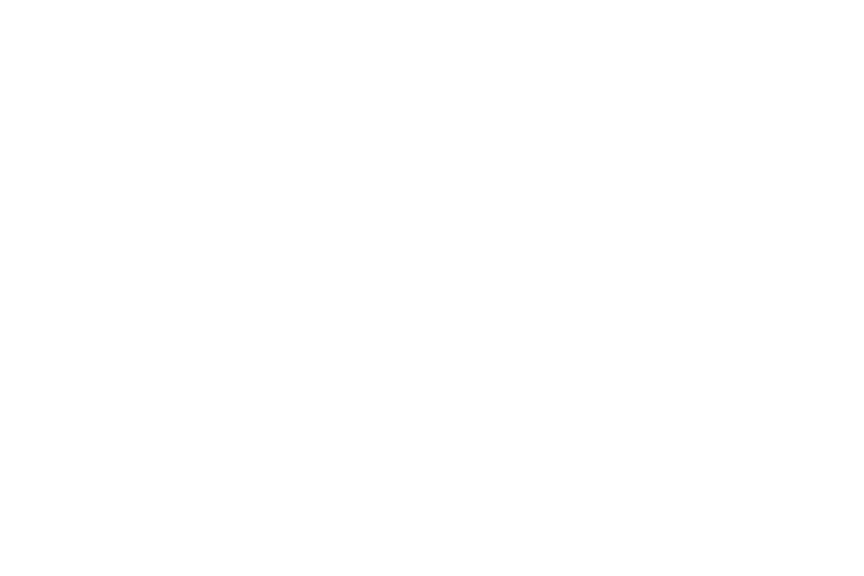

[[<Figure size 432x288 with 5 Axes>]]

In [14]:
cerebro.plot(iplot=True, style="bar")
